## Step-by-step implementation of region-CNN from Scratch Using Tensorflow Keras fig_generator function
Here, the airplane dataset is used to detect the airplanes from the remote sensing images. The dataset is available in the following link http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html

Patches are extracted using Selective Search algorithm based on intersection of Union (IoU) value and saved in a directory. Later, the pathces are splitted into train validation and train dataset. The fine tuned VGG16 model has been trained using keras fit_generator function

### Import libraries

In [1]:
import os
import cv2
import keras
from keras.layers import Dense
from keras import Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
import tensorflow as tf

Using TensorFlow backend.


### Path of image and annotation directory

In [2]:
# This folder contians all the airplanes images
image_path = os.path.join(os.getcwd(), "airplanes/images")
# This folder contians all the annotations of the respective images
annotation_path = os.path.join(os.getcwd(), "airplanes/annotations")

### Display sample images with annotations (ground truth boundary boxes)

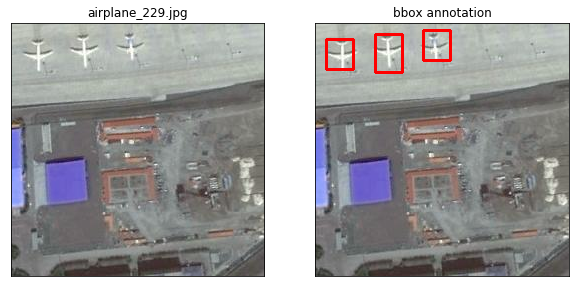

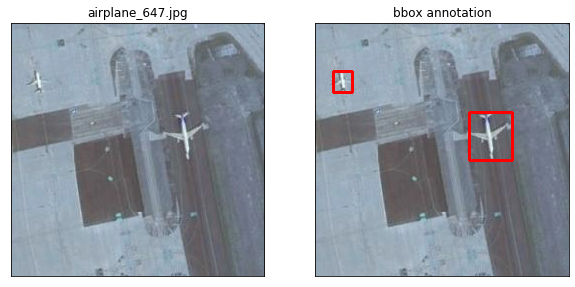

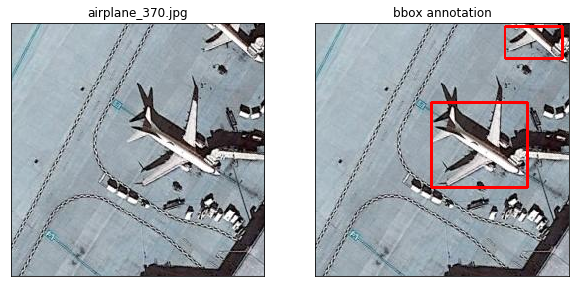

In [3]:
for i in range(3):
    fig = plt.figure(figsize=(10,10))
    idx = np.random.choice(os.listdir(annotation_path))

    img_file = idx.split(".")[0] + ".jpg"
    img = cv2.imread(os.path.join(image_path, img_file))
    annotation = pd.read_csv(os.path.join(annotation_path, idx))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(img_file), plt.xticks([]), plt.yticks([])
    for row in annotation.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2) # (x1,y1) -> start point and (x2,y2) -> end pint of the bbox
    fig.add_subplot(1, 2, 2)
    plt.imshow(img)
    plt.title("bbox annotation"), plt.xticks([]), plt.yticks([])

### Region detection using selective searches and display the results

In [4]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Text(0.5, 1.0, '357 regions detected')

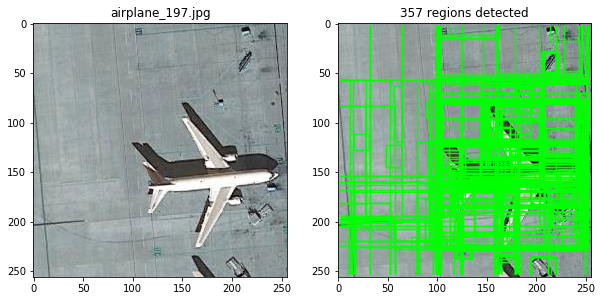

In [5]:
img_file = np.random.choice(os.listdir(image_path))
img = cv2.imread(os.path.join(image_path, img_file))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
regions = ss.process()

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1,2,1)
plt.imshow(img)
plt.title(img_file)

for i, region in enumerate(regions):
    x, y, w, h = region
    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
fig.add_subplot(1,2,2)
plt.imshow(img)
title = str(len(regions)) + " regions detected"
plt.title(title)

### Patch extraction uisng selective search and save to folder
Patch extraction is needed only for the first time. Do not run these (cell 6 to 9) if you run this program second time

#### Define the function to calculate the Intersection of Union (IoU)

In [6]:
def get_iou(bbox1, bbox2):   
    x_left = max(bbox1['x1'], bbox2['x1'])
    y_top = max(bbox1['y1'], bbox2['y1'])
    x_right = min(bbox1['x2'], bbox2['x2'])
    y_bottom = min(bbox1['y2'], bbox2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bbox1_area = (bbox1['x2'] - bbox1['x1']) * (bbox1['y2'] - bbox1['y1'])
    bbox2_area = (bbox2['x2'] - bbox2['x1']) * (bbox2['y2'] - bbox2['y1'])
    
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

#### Manage patch directories

In [7]:
patch_dir = os.path.join(os.getcwd(), "patches")
airplane_patches_dir = os.path.join(patch_dir, "airplanes")
background_patches_dir = os.path.join(patch_dir, "backgorund")

if os.path.exists(patch_dir):
    shutil.rmtree(patch_dir)
os.mkdir(patch_dir)
os.mkdir(airplane_patches_dir)
os.mkdir(background_patches_dir)

#### Extract patches and save to folder

In [8]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [9]:
for i,annotation_file in enumerate(tqdm(os.listdir(annotation_path))):
    img_file = annotation_file.split(".")[0] + '.jpg'
    #print(i, img_file)
    img = cv2.imread(os.path.join(image_path, img_file))
    annotation = pd.read_csv(os.path.join(annotation_path, annotation_file))
    gtbboxes = []

    for row in annotation.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtbboxes.append({'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2})

    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    regions = ss.process() # return region as (x,y,width and height) form

    counter = 0
    falsecounter = 0

    temp_img = img.copy()
    for c, region in enumerate(regions):
        if c < 2000:
            for gtbbox in gtbboxes:
                x,y,w,h = region 
                iou = get_iou(gtbbox, {'x1':x, 'y1':y, 'x2':x+w, 'y2':y+h})
                if counter < 30:
                    if iou > 0.70:
                        cropped_img = temp_img[y:y+h, x:x+w]
                        resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
                        file_name = annotation_file.split(".")[0] + "_" + str(counter) + '.jpg'
                        cv2.imwrite(os.path.join(airplane_patches_dir, file_name), resized_img)
                        counter += 1

                if falsecounter < 30:
                    if iou < 0.3 :
                        cropped_img = temp_img[y:y+h, x:x+w]
                        resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
                        file_name = annotation_file.split(".")[0] + "_" + str(falsecounter) + '.jpg'
                        cv2.imwrite(os.path.join(background_patches_dir, file_name), resized_img)
                        falsecounter += 1

100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [07:05<00:00,  1.64it/s]


### Split the patches into train, validation and test folder

#### Degine the train, validation and test folder. Each folder contains two subfolder 1) airplane 2) background

In [10]:
root_dir = os.path.join(os.getcwd(), "images")

train_dir = os.path.join(root_dir, "train")
train_dir_a = os.path.join(train_dir, "airplane")
train_dir_b = os.path.join(train_dir, "background")

val_dir = os.path.join(root_dir, "val")
val_dir_a = os.path.join(val_dir, "airplane")
val_dir_b = os.path.join(val_dir, "background")

test_dir = os.path.join(root_dir, "test")


#### Create the folders, it will overwrite the folders

In [11]:
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)
os.mkdir(root_dir)

os.mkdir(train_dir)
os.mkdir(train_dir_a)
os.mkdir(train_dir_b)

os.mkdir(val_dir)
os.mkdir(val_dir_a)
os.mkdir(val_dir_b)

os.mkdir(test_dir)

#### Copy the files to respective folders (85% train, 14% validation and 1% for testing)

In [13]:
n_test = int(len(os.listdir(airplane_patches_dir))*0.01)

for path in [airplane_patches_dir, background_patches_dir]:
    n_train = int(len(os.listdir(path))*0.85)
    n_val = int(len(os.listdir(path))*0.14)
    
    train_sample = np.random.choice(os.listdir(path), n_train, replace=False)
    rest = list(set(os.listdir(path)) - set(train_sample))
    val_sample = np.random.choice(rest, n_val, replace=False)
    rest = list(set(rest) - set(val_sample))
    test_sample = np.random.choice(rest, n_test, replace=False)
    
    if path == airplane_patches_dir:
        print("Copying {} train airplane patches...".format(n_train))
        for file in tqdm(train_sample):
            src_file = os.path.join(airplane_patches_dir, file)
            shutil.copy(src_file, train_dir_a) 

        print("Copying {} validation airplane patches...".format(n_val))
        for file in tqdm(val_sample):
            src_file = os.path.join(airplane_patches_dir, file)
            shutil.copy(src_file, val_dir_a)
            
        print("Copying {} test airplane patches...".format(n_test))
        for file in tqdm(test_sample):
            src_file = os.path.join(airplane_patches_dir, file)
            shutil.copy(src_file, test_dir)
    
    if path == background_patches_dir:
        print("Copying {} train background patches...".format(n_train))
        for file in tqdm(train_sample):
            src_file = os.path.join(background_patches_dir, file)
            shutil.copy(src_file, train_dir_b) 

        print("Copying {} validation background patches...".format(n_val))
        for file in tqdm(val_sample):
            src_file = os.path.join(background_patches_dir, file)
            shutil.copy(src_file, val_dir_b)
            
        print("Copying {} test background patches...".format(n_test))
        for file in tqdm(test_sample):
            src_file = os.path.join(background_patches_dir, file)
            shutil.copy(src_file, test_dir)
        

Copying 7895 train airplane patches...


100%|████████████████████████████████████████████████████████████████████████████| 7895/7895 [00:07<00:00, 1066.61it/s]


Copying 1300 validation airplane patches...


100%|█████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:01<00:00, 799.63it/s]


Copying 92 test airplane patches...


100%|█████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 931.35it/s]


Copying 17799 train background patches...


100%|███████████████████████████████████████████████████████████████████████████| 17799/17799 [00:22<00:00, 780.27it/s]


Copying 2931 validation background patches...


100%|█████████████████████████████████████████████████████████████████████████████| 2931/2931 [00:03<00:00, 893.34it/s]


Copying 92 test background patches...


100%|████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 1167.86it/s]


### Develop the model

#### Load the VGG16 model

In [14]:
vggmodel = VGG16(weights='imagenet', include_top=True)
#vggmodel.summary()

#### Fine tune the model

In [15]:
# Freeze the first 15 layers
for layers in (vggmodel.layers)[:15]:
    #print(layers)
    layers.trainable = False

# Remove the last layers and change to class 2 instead of 1000
X = vggmodel.layers[-2].output
predictions = Dense(2, activation='softmax')(X)
model = Model(input=vggmodel.input, output=predictions)
model.summary()

C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Data augmentation using Keras ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(horizontal_flip=True, 
                            vertical_flip=True, 
                            rotation_range=90)
train_data = datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=10)
val_data = datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=10)

Found 25694 images belonging to 2 classes.
Found 4231 images belonging to 2 classes.


### Compile the model

In [17]:
lr = 0.0001
model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=Adam(lr=lr),
                   metrics=['accuracy'])

### Set model checkpoint

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("region_cnn.h5", monitor='val_loss',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

### Train the model

In [19]:
total_train_images = 25694
total_val_images = 4231
batch_size = 10
epochs = 30
trained_model = model.fit_generator(generator=train_data,
                                          steps_per_epoch= total_train_images//batch_size,
                                          epochs=epochs,
                                          validation_data=val_data,
                                          validation_steps=total_val_images//batch_size,
                                          callbacks=[checkpoint, early])

Epoch 1/30


 204/2569 [=>............................] - ETA: 5:18:02 - loss: 1.2956 - acc: 0.40 - ETA: 2:41:05 - loss: 1.3078 - acc: 0.50 - ETA: 1:48:48 - loss: 0.9432 - acc: 0.63 - ETA: 1:23:14 - loss: 1.1036 - acc: 0.67 - ETA: 1:07:27 - loss: 1.2020 - acc: 0.70 - ETA: 56:55 - loss: 1.0957 - acc: 0.7167 - ETA: 49:23 - loss: 0.9563 - acc: 0.74 - ETA: 43:43 - loss: 0.9013 - acc: 0.76 - ETA: 39:18 - loss: 0.8968 - acc: 0.76 - ETA: 35:49 - loss: 1.0706 - acc: 0.77 - ETA: 33:08 - loss: 1.0748 - acc: 0.74 - ETA: 30:42 - loss: 1.1475 - acc: 0.74 - ETA: 28:39 - loss: 1.1846 - acc: 0.73 - ETA: 26:56 - loss: 1.1026 - acc: 0.75 - ETA: 25:26 - loss: 1.0349 - acc: 0.77 - ETA: 24:07 - loss: 0.9995 - acc: 0.77 - ETA: 22:56 - loss: 0.9726 - acc: 0.77 - ETA: 21:54 - loss: 0.9457 - acc: 0.78 - ETA: 20:57 - loss: 0.9212 - acc: 0.78 - ETA: 20:07 - loss: 0.9092 - acc: 0.78 - ETA: 19:21 - loss: 0.8885 - acc: 0.78 - ETA: 18:46 - loss: 0.8814 - acc: 0.78 - ETA: 18:08 - loss: 0.9021 - acc: 0.76 - ETA: 17:33 - loss: 0.88

 408/2569 [===>..........................] - ETA: 8:16 - loss: 0.4212 - acc: 0.867 - ETA: 8:15 - loss: 0.4195 - acc: 0.868 - ETA: 8:14 - loss: 0.4200 - acc: 0.868 - ETA: 8:14 - loss: 0.4185 - acc: 0.868 - ETA: 8:14 - loss: 0.4208 - acc: 0.868 - ETA: 8:13 - loss: 0.4208 - acc: 0.868 - ETA: 8:12 - loss: 0.4188 - acc: 0.869 - ETA: 8:12 - loss: 0.4171 - acc: 0.869 - ETA: 8:11 - loss: 0.4153 - acc: 0.870 - ETA: 8:11 - loss: 0.4146 - acc: 0.870 - ETA: 8:10 - loss: 0.4129 - acc: 0.871 - ETA: 8:10 - loss: 0.4118 - acc: 0.871 - ETA: 8:09 - loss: 0.4102 - acc: 0.871 - ETA: 8:09 - loss: 0.4085 - acc: 0.872 - ETA: 8:08 - loss: 0.4128 - acc: 0.872 - ETA: 8:08 - loss: 0.4128 - acc: 0.871 - ETA: 8:07 - loss: 0.4134 - acc: 0.871 - ETA: 8:07 - loss: 0.4136 - acc: 0.871 - ETA: 8:06 - loss: 0.4121 - acc: 0.871 - ETA: 8:06 - loss: 0.4124 - acc: 0.871 - ETA: 8:05 - loss: 0.4138 - acc: 0.870 - ETA: 8:05 - loss: 0.4126 - acc: 0.870 - ETA: 8:04 - loss: 0.4119 - acc: 0.870 - ETA: 8:04 - loss: 0.4123 - acc: 0.8

 612/2569 [======>.......................] - ETA: 7:03 - loss: 0.3503 - acc: 0.886 - ETA: 7:03 - loss: 0.3498 - acc: 0.886 - ETA: 7:02 - loss: 0.3507 - acc: 0.886 - ETA: 7:02 - loss: 0.3501 - acc: 0.886 - ETA: 7:02 - loss: 0.3494 - acc: 0.887 - ETA: 7:02 - loss: 0.3492 - acc: 0.887 - ETA: 7:01 - loss: 0.3491 - acc: 0.887 - ETA: 7:01 - loss: 0.3488 - acc: 0.887 - ETA: 7:01 - loss: 0.3482 - acc: 0.887 - ETA: 7:01 - loss: 0.3481 - acc: 0.887 - ETA: 7:00 - loss: 0.3475 - acc: 0.887 - ETA: 7:00 - loss: 0.3468 - acc: 0.887 - ETA: 7:00 - loss: 0.3461 - acc: 0.888 - ETA: 6:59 - loss: 0.3457 - acc: 0.888 - ETA: 6:59 - loss: 0.3450 - acc: 0.888 - ETA: 6:59 - loss: 0.3446 - acc: 0.888 - ETA: 6:59 - loss: 0.3438 - acc: 0.888 - ETA: 6:58 - loss: 0.3431 - acc: 0.889 - ETA: 6:58 - loss: 0.3424 - acc: 0.889 - ETA: 6:58 - loss: 0.3420 - acc: 0.889 - ETA: 6:57 - loss: 0.3420 - acc: 0.889 - ETA: 6:57 - loss: 0.3416 - acc: 0.889 - ETA: 6:57 - loss: 0.3408 - acc: 0.889 - ETA: 6:57 - loss: 0.3402 - acc: 0.8

 816/2569 [========>.....................] - ETA: 6:14 - loss: 0.3067 - acc: 0.898 - ETA: 6:14 - loss: 0.3066 - acc: 0.898 - ETA: 6:14 - loss: 0.3068 - acc: 0.898 - ETA: 6:14 - loss: 0.3067 - acc: 0.898 - ETA: 6:13 - loss: 0.3068 - acc: 0.898 - ETA: 6:13 - loss: 0.3068 - acc: 0.898 - ETA: 6:13 - loss: 0.3067 - acc: 0.898 - ETA: 6:13 - loss: 0.3064 - acc: 0.898 - ETA: 6:13 - loss: 0.3064 - acc: 0.898 - ETA: 6:12 - loss: 0.3060 - acc: 0.898 - ETA: 6:12 - loss: 0.3057 - acc: 0.898 - ETA: 6:12 - loss: 0.3059 - acc: 0.898 - ETA: 6:12 - loss: 0.3057 - acc: 0.898 - ETA: 6:11 - loss: 0.3053 - acc: 0.898 - ETA: 6:11 - loss: 0.3048 - acc: 0.898 - ETA: 6:11 - loss: 0.3044 - acc: 0.898 - ETA: 6:11 - loss: 0.3045 - acc: 0.898 - ETA: 6:11 - loss: 0.3040 - acc: 0.898 - ETA: 6:10 - loss: 0.3039 - acc: 0.898 - ETA: 6:10 - loss: 0.3036 - acc: 0.898 - ETA: 6:10 - loss: 0.3031 - acc: 0.899 - ETA: 6:10 - loss: 0.3026 - acc: 0.899 - ETA: 6:09 - loss: 0.3022 - acc: 0.899 - ETA: 6:09 - loss: 0.3017 - acc: 0.8

1020/2569 [==========>...................] - ETA: 5:31 - loss: 0.2861 - acc: 0.904 - ETA: 5:31 - loss: 0.2858 - acc: 0.904 - ETA: 5:30 - loss: 0.2857 - acc: 0.904 - ETA: 5:30 - loss: 0.2856 - acc: 0.904 - ETA: 5:30 - loss: 0.2858 - acc: 0.904 - ETA: 5:30 - loss: 0.2857 - acc: 0.904 - ETA: 5:30 - loss: 0.2860 - acc: 0.904 - ETA: 5:29 - loss: 0.2858 - acc: 0.904 - ETA: 5:29 - loss: 0.2858 - acc: 0.904 - ETA: 5:29 - loss: 0.2854 - acc: 0.904 - ETA: 5:29 - loss: 0.2852 - acc: 0.904 - ETA: 5:29 - loss: 0.2849 - acc: 0.904 - ETA: 5:28 - loss: 0.2845 - acc: 0.904 - ETA: 5:28 - loss: 0.2845 - acc: 0.904 - ETA: 5:28 - loss: 0.2842 - acc: 0.904 - ETA: 5:28 - loss: 0.2848 - acc: 0.904 - ETA: 5:27 - loss: 0.2845 - acc: 0.904 - ETA: 5:27 - loss: 0.2842 - acc: 0.904 - ETA: 5:27 - loss: 0.2840 - acc: 0.905 - ETA: 5:27 - loss: 0.2838 - acc: 0.905 - ETA: 5:27 - loss: 0.2838 - acc: 0.905 - ETA: 5:26 - loss: 0.2844 - acc: 0.905 - ETA: 5:26 - loss: 0.2842 - acc: 0.905 - ETA: 5:26 - loss: 0.2842 - acc: 0.9

1224/2569 [=============>................] - ETA: 4:49 - loss: 0.2733 - acc: 0.909 - ETA: 4:49 - loss: 0.2733 - acc: 0.909 - ETA: 4:49 - loss: 0.2732 - acc: 0.909 - ETA: 4:48 - loss: 0.2731 - acc: 0.909 - ETA: 4:48 - loss: 0.2731 - acc: 0.909 - ETA: 4:48 - loss: 0.2729 - acc: 0.909 - ETA: 4:48 - loss: 0.2728 - acc: 0.909 - ETA: 4:48 - loss: 0.2727 - acc: 0.909 - ETA: 4:47 - loss: 0.2725 - acc: 0.909 - ETA: 4:47 - loss: 0.2723 - acc: 0.909 - ETA: 4:47 - loss: 0.2723 - acc: 0.909 - ETA: 4:47 - loss: 0.2721 - acc: 0.909 - ETA: 4:47 - loss: 0.2724 - acc: 0.909 - ETA: 4:46 - loss: 0.2722 - acc: 0.909 - ETA: 4:46 - loss: 0.2721 - acc: 0.909 - ETA: 4:46 - loss: 0.2721 - acc: 0.909 - ETA: 4:46 - loss: 0.2718 - acc: 0.909 - ETA: 4:46 - loss: 0.2718 - acc: 0.909 - ETA: 4:46 - loss: 0.2716 - acc: 0.909 - ETA: 4:45 - loss: 0.2714 - acc: 0.909 - ETA: 4:45 - loss: 0.2712 - acc: 0.909 - ETA: 4:45 - loss: 0.2712 - acc: 0.909 - ETA: 4:45 - loss: 0.2710 - acc: 0.909 - ETA: 4:45 - loss: 0.2708 - acc: 0.9

1428/2569 [===============>..............] - ETA: 4:09 - loss: 0.2618 - acc: 0.912 - ETA: 4:09 - loss: 0.2621 - acc: 0.912 - ETA: 4:09 - loss: 0.2619 - acc: 0.912 - ETA: 4:09 - loss: 0.2617 - acc: 0.912 - ETA: 4:08 - loss: 0.2615 - acc: 0.912 - ETA: 4:08 - loss: 0.2614 - acc: 0.912 - ETA: 4:08 - loss: 0.2612 - acc: 0.912 - ETA: 4:08 - loss: 0.2611 - acc: 0.912 - ETA: 4:08 - loss: 0.2614 - acc: 0.912 - ETA: 4:08 - loss: 0.2613 - acc: 0.912 - ETA: 4:07 - loss: 0.2611 - acc: 0.912 - ETA: 4:07 - loss: 0.2609 - acc: 0.912 - ETA: 4:07 - loss: 0.2607 - acc: 0.912 - ETA: 4:07 - loss: 0.2606 - acc: 0.912 - ETA: 4:07 - loss: 0.2606 - acc: 0.912 - ETA: 4:06 - loss: 0.2604 - acc: 0.912 - ETA: 4:06 - loss: 0.2603 - acc: 0.912 - ETA: 4:06 - loss: 0.2602 - acc: 0.912 - ETA: 4:06 - loss: 0.2601 - acc: 0.912 - ETA: 4:06 - loss: 0.2600 - acc: 0.912 - ETA: 4:05 - loss: 0.2600 - acc: 0.912 - ETA: 4:05 - loss: 0.2600 - acc: 0.912 - ETA: 4:05 - loss: 0.2599 - acc: 0.912 - ETA: 4:05 - loss: 0.2600 - acc: 0.9

1632/2569 [==================>...........] - ETA: 3:31 - loss: 0.2507 - acc: 0.915 - ETA: 3:31 - loss: 0.2506 - acc: 0.915 - ETA: 3:31 - loss: 0.2505 - acc: 0.915 - ETA: 3:31 - loss: 0.2503 - acc: 0.916 - ETA: 3:30 - loss: 0.2502 - acc: 0.916 - ETA: 3:30 - loss: 0.2501 - acc: 0.916 - ETA: 3:30 - loss: 0.2500 - acc: 0.916 - ETA: 3:30 - loss: 0.2499 - acc: 0.916 - ETA: 3:30 - loss: 0.2499 - acc: 0.916 - ETA: 3:30 - loss: 0.2497 - acc: 0.916 - ETA: 3:29 - loss: 0.2496 - acc: 0.916 - ETA: 3:29 - loss: 0.2495 - acc: 0.916 - ETA: 3:29 - loss: 0.2494 - acc: 0.916 - ETA: 3:29 - loss: 0.2493 - acc: 0.916 - ETA: 3:29 - loss: 0.2492 - acc: 0.916 - ETA: 3:28 - loss: 0.2493 - acc: 0.916 - ETA: 3:28 - loss: 0.2492 - acc: 0.916 - ETA: 3:28 - loss: 0.2494 - acc: 0.916 - ETA: 3:28 - loss: 0.2492 - acc: 0.916 - ETA: 3:28 - loss: 0.2491 - acc: 0.916 - ETA: 3:27 - loss: 0.2489 - acc: 0.916 - ETA: 3:27 - loss: 0.2490 - acc: 0.916 - ETA: 3:27 - loss: 0.2489 - acc: 0.916 - ETA: 3:27 - loss: 0.2489 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:53 - loss: 0.2448 - acc: 0.917 - ETA: 2:53 - loss: 0.2447 - acc: 0.917 - ETA: 2:53 - loss: 0.2446 - acc: 0.917 - ETA: 2:52 - loss: 0.2445 - acc: 0.917 - ETA: 2:52 - loss: 0.2444 - acc: 0.917 - ETA: 2:52 - loss: 0.2445 - acc: 0.917 - ETA: 2:52 - loss: 0.2447 - acc: 0.917 - ETA: 2:52 - loss: 0.2454 - acc: 0.917 - ETA: 2:51 - loss: 0.2452 - acc: 0.917 - ETA: 2:51 - loss: 0.2451 - acc: 0.917 - ETA: 2:51 - loss: 0.2450 - acc: 0.917 - ETA: 2:51 - loss: 0.2449 - acc: 0.917 - ETA: 2:51 - loss: 0.2448 - acc: 0.917 - ETA: 2:50 - loss: 0.2447 - acc: 0.918 - ETA: 2:50 - loss: 0.2449 - acc: 0.917 - ETA: 2:50 - loss: 0.2449 - acc: 0.917 - ETA: 2:50 - loss: 0.2448 - acc: 0.918 - ETA: 2:50 - loss: 0.2451 - acc: 0.917 - ETA: 2:49 - loss: 0.2451 - acc: 0.917 - ETA: 2:49 - loss: 0.2450 - acc: 0.918 - ETA: 2:49 - loss: 0.2450 - acc: 0.918 - ETA: 2:49 - loss: 0.2449 - acc: 0.918 - ETA: 2:49 - loss: 0.2451 - acc: 0.918 - ETA: 2:49 - loss: 0.2451 - acc: 0.9

2040/2569 [======================>.......] - ETA: 2:14 - loss: 0.2420 - acc: 0.919 - ETA: 2:14 - loss: 0.2420 - acc: 0.919 - ETA: 2:14 - loss: 0.2419 - acc: 0.919 - ETA: 2:14 - loss: 0.2418 - acc: 0.919 - ETA: 2:13 - loss: 0.2417 - acc: 0.919 - ETA: 2:13 - loss: 0.2417 - acc: 0.919 - ETA: 2:13 - loss: 0.2416 - acc: 0.919 - ETA: 2:13 - loss: 0.2415 - acc: 0.919 - ETA: 2:13 - loss: 0.2415 - acc: 0.919 - ETA: 2:12 - loss: 0.2416 - acc: 0.919 - ETA: 2:12 - loss: 0.2415 - acc: 0.919 - ETA: 2:12 - loss: 0.2414 - acc: 0.919 - ETA: 2:12 - loss: 0.2413 - acc: 0.919 - ETA: 2:12 - loss: 0.2412 - acc: 0.919 - ETA: 2:11 - loss: 0.2412 - acc: 0.919 - ETA: 2:11 - loss: 0.2411 - acc: 0.919 - ETA: 2:11 - loss: 0.2411 - acc: 0.919 - ETA: 2:11 - loss: 0.2412 - acc: 0.919 - ETA: 2:11 - loss: 0.2411 - acc: 0.919 - ETA: 2:10 - loss: 0.2411 - acc: 0.919 - ETA: 2:10 - loss: 0.2410 - acc: 0.919 - ETA: 2:10 - loss: 0.2410 - acc: 0.919 - ETA: 2:10 - loss: 0.2409 - acc: 0.919 - ETA: 2:10 - loss: 0.2408 - acc: 0.9

2244/2569 [=========================>....] - ETA: 1:36 - loss: 0.2381 - acc: 0.921 - ETA: 1:36 - loss: 0.2382 - acc: 0.921 - ETA: 1:36 - loss: 0.2380 - acc: 0.921 - ETA: 1:35 - loss: 0.2379 - acc: 0.921 - ETA: 1:35 - loss: 0.2379 - acc: 0.921 - ETA: 1:35 - loss: 0.2380 - acc: 0.921 - ETA: 1:35 - loss: 0.2379 - acc: 0.921 - ETA: 1:35 - loss: 0.2378 - acc: 0.921 - ETA: 1:34 - loss: 0.2378 - acc: 0.921 - ETA: 1:34 - loss: 0.2377 - acc: 0.921 - ETA: 1:34 - loss: 0.2376 - acc: 0.921 - ETA: 1:34 - loss: 0.2375 - acc: 0.921 - ETA: 1:34 - loss: 0.2374 - acc: 0.921 - ETA: 1:34 - loss: 0.2373 - acc: 0.921 - ETA: 1:33 - loss: 0.2372 - acc: 0.921 - ETA: 1:33 - loss: 0.2376 - acc: 0.921 - ETA: 1:33 - loss: 0.2377 - acc: 0.921 - ETA: 1:33 - loss: 0.2376 - acc: 0.921 - ETA: 1:33 - loss: 0.2375 - acc: 0.921 - ETA: 1:32 - loss: 0.2374 - acc: 0.921 - ETA: 1:32 - loss: 0.2376 - acc: 0.921 - ETA: 1:32 - loss: 0.2375 - acc: 0.921 - ETA: 1:32 - loss: 0.2380 - acc: 0.921 - ETA: 1:32 - loss: 0.2380 - acc: 0.9

2459/2569 [===========================>..] - ETA: 58s - loss: 0.2341 - acc: 0.92 - ETA: 58s - loss: 0.2341 - acc: 0.92 - ETA: 58s - loss: 0.2340 - acc: 0.92 - ETA: 58s - loss: 0.2339 - acc: 0.92 - ETA: 58s - loss: 0.2339 - acc: 0.92 - ETA: 57s - loss: 0.2338 - acc: 0.92 - ETA: 57s - loss: 0.2338 - acc: 0.92 - ETA: 57s - loss: 0.2337 - acc: 0.92 - ETA: 57s - loss: 0.2337 - acc: 0.92 - ETA: 57s - loss: 0.2336 - acc: 0.92 - ETA: 57s - loss: 0.2335 - acc: 0.92 - ETA: 56s - loss: 0.2336 - acc: 0.92 - ETA: 56s - loss: 0.2335 - acc: 0.92 - ETA: 56s - loss: 0.2337 - acc: 0.92 - ETA: 56s - loss: 0.2336 - acc: 0.92 - ETA: 56s - loss: 0.2336 - acc: 0.92 - ETA: 55s - loss: 0.2336 - acc: 0.92 - ETA: 55s - loss: 0.2336 - acc: 0.92 - ETA: 55s - loss: 0.2335 - acc: 0.92 - ETA: 55s - loss: 0.2335 - acc: 0.92 - ETA: 55s - loss: 0.2335 - acc: 0.92 - ETA: 55s - loss: 0.2334 - acc: 0.92 - ETA: 54s - loss: 0.2333 - acc: 0.92 - ETA: 54s - loss: 0.2332 - acc: 0.92 - ETA: 54s - loss: 0.2331 - acc: 0.92 - ETA: 

2569/2569 [==============================] - ETA: 19s - loss: 0.2279 - acc: 0.92 - ETA: 19s - loss: 0.2279 - acc: 0.92 - ETA: 19s - loss: 0.2280 - acc: 0.92 - ETA: 19s - loss: 0.2280 - acc: 0.92 - ETA: 18s - loss: 0.2279 - acc: 0.92 - ETA: 18s - loss: 0.2279 - acc: 0.92 - ETA: 18s - loss: 0.2278 - acc: 0.92 - ETA: 18s - loss: 0.2278 - acc: 0.92 - ETA: 18s - loss: 0.2277 - acc: 0.92 - ETA: 18s - loss: 0.2277 - acc: 0.92 - ETA: 17s - loss: 0.2276 - acc: 0.92 - ETA: 17s - loss: 0.2276 - acc: 0.92 - ETA: 17s - loss: 0.2276 - acc: 0.92 - ETA: 17s - loss: 0.2275 - acc: 0.92 - ETA: 17s - loss: 0.2274 - acc: 0.92 - ETA: 17s - loss: 0.2274 - acc: 0.92 - ETA: 16s - loss: 0.2275 - acc: 0.92 - ETA: 16s - loss: 0.2274 - acc: 0.92 - ETA: 16s - loss: 0.2273 - acc: 0.92 - ETA: 16s - loss: 0.2276 - acc: 0.92 - ETA: 16s - loss: 0.2276 - acc: 0.92 - ETA: 15s - loss: 0.2275 - acc: 0.92 - ETA: 15s - loss: 0.2274 - acc: 0.92 - ETA: 15s - loss: 0.2274 - acc: 0.92 - ETA: 15s - loss: 0.2275 - acc: 0.92 - ETA: 

 204/2569 [=>............................] - ETA: 15:01 - loss: 0.4860 - acc: 0.75 - ETA: 9:36 - loss: 0.2936 - acc: 0.8250 - ETA: 7:50 - loss: 0.2094 - acc: 0.883 - ETA: 7:06 - loss: 0.1671 - acc: 0.912 - ETA: 6:58 - loss: 0.1447 - acc: 0.930 - ETA: 6:50 - loss: 0.1287 - acc: 0.941 - ETA: 6:44 - loss: 0.1175 - acc: 0.950 - ETA: 6:41 - loss: 0.1107 - acc: 0.956 - ETA: 6:39 - loss: 0.1191 - acc: 0.950 - ETA: 6:36 - loss: 0.1818 - acc: 0.925 - ETA: 6:36 - loss: 0.2115 - acc: 0.913 - ETA: 6:35 - loss: 0.2098 - acc: 0.912 - ETA: 6:33 - loss: 0.1959 - acc: 0.919 - ETA: 6:31 - loss: 0.1828 - acc: 0.925 - ETA: 6:29 - loss: 0.1743 - acc: 0.930 - ETA: 6:28 - loss: 0.2298 - acc: 0.921 - ETA: 6:26 - loss: 0.2272 - acc: 0.920 - ETA: 6:25 - loss: 0.2186 - acc: 0.925 - ETA: 6:24 - loss: 0.2136 - acc: 0.928 - ETA: 6:23 - loss: 0.2066 - acc: 0.932 - ETA: 6:22 - loss: 0.1985 - acc: 0.935 - ETA: 6:22 - loss: 0.1913 - acc: 0.938 - ETA: 6:21 - loss: 0.1924 - acc: 0.937 - ETA: 6:20 - loss: 0.1862 - acc: 0.

 408/2569 [===>..........................] - ETA: 5:41 - loss: 0.1838 - acc: 0.940 - ETA: 5:41 - loss: 0.1830 - acc: 0.940 - ETA: 5:41 - loss: 0.1831 - acc: 0.940 - ETA: 5:41 - loss: 0.1830 - acc: 0.940 - ETA: 5:41 - loss: 0.1822 - acc: 0.940 - ETA: 5:41 - loss: 0.1817 - acc: 0.940 - ETA: 5:41 - loss: 0.1815 - acc: 0.941 - ETA: 5:40 - loss: 0.1807 - acc: 0.941 - ETA: 5:40 - loss: 0.1800 - acc: 0.941 - ETA: 5:40 - loss: 0.1794 - acc: 0.941 - ETA: 5:40 - loss: 0.1790 - acc: 0.942 - ETA: 5:40 - loss: 0.1782 - acc: 0.942 - ETA: 5:40 - loss: 0.1774 - acc: 0.942 - ETA: 5:40 - loss: 0.1768 - acc: 0.942 - ETA: 5:40 - loss: 0.1772 - acc: 0.942 - ETA: 5:40 - loss: 0.1779 - acc: 0.942 - ETA: 5:39 - loss: 0.1773 - acc: 0.942 - ETA: 5:39 - loss: 0.1767 - acc: 0.943 - ETA: 5:39 - loss: 0.1760 - acc: 0.943 - ETA: 5:39 - loss: 0.1752 - acc: 0.943 - ETA: 5:39 - loss: 0.1746 - acc: 0.943 - ETA: 5:39 - loss: 0.1754 - acc: 0.943 - ETA: 5:39 - loss: 0.1747 - acc: 0.943 - ETA: 5:39 - loss: 0.1742 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:09 - loss: 0.1662 - acc: 0.942 - ETA: 5:09 - loss: 0.1660 - acc: 0.943 - ETA: 5:09 - loss: 0.1659 - acc: 0.942 - ETA: 5:09 - loss: 0.1655 - acc: 0.943 - ETA: 5:09 - loss: 0.1659 - acc: 0.943 - ETA: 5:09 - loss: 0.1656 - acc: 0.943 - ETA: 5:09 - loss: 0.1654 - acc: 0.943 - ETA: 5:08 - loss: 0.1655 - acc: 0.943 - ETA: 5:08 - loss: 0.1652 - acc: 0.943 - ETA: 5:08 - loss: 0.1651 - acc: 0.943 - ETA: 5:08 - loss: 0.1654 - acc: 0.943 - ETA: 5:08 - loss: 0.1662 - acc: 0.943 - ETA: 5:08 - loss: 0.1661 - acc: 0.942 - ETA: 5:08 - loss: 0.1660 - acc: 0.943 - ETA: 5:07 - loss: 0.1660 - acc: 0.942 - ETA: 5:07 - loss: 0.1660 - acc: 0.942 - ETA: 5:07 - loss: 0.1663 - acc: 0.942 - ETA: 5:07 - loss: 0.1668 - acc: 0.942 - ETA: 5:07 - loss: 0.1675 - acc: 0.942 - ETA: 5:07 - loss: 0.1672 - acc: 0.942 - ETA: 5:07 - loss: 0.1683 - acc: 0.942 - ETA: 5:07 - loss: 0.1681 - acc: 0.942 - ETA: 5:06 - loss: 0.1679 - acc: 0.942 - ETA: 5:06 - loss: 0.1677 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:41 - loss: 0.1664 - acc: 0.945 - ETA: 4:41 - loss: 0.1663 - acc: 0.945 - ETA: 4:41 - loss: 0.1663 - acc: 0.945 - ETA: 4:41 - loss: 0.1661 - acc: 0.945 - ETA: 4:41 - loss: 0.1659 - acc: 0.945 - ETA: 4:41 - loss: 0.1657 - acc: 0.945 - ETA: 4:40 - loss: 0.1657 - acc: 0.945 - ETA: 4:40 - loss: 0.1656 - acc: 0.945 - ETA: 4:40 - loss: 0.1655 - acc: 0.945 - ETA: 4:40 - loss: 0.1652 - acc: 0.945 - ETA: 4:40 - loss: 0.1650 - acc: 0.945 - ETA: 4:40 - loss: 0.1648 - acc: 0.945 - ETA: 4:40 - loss: 0.1646 - acc: 0.945 - ETA: 4:39 - loss: 0.1646 - acc: 0.945 - ETA: 4:39 - loss: 0.1644 - acc: 0.946 - ETA: 4:39 - loss: 0.1642 - acc: 0.946 - ETA: 4:39 - loss: 0.1639 - acc: 0.946 - ETA: 4:39 - loss: 0.1647 - acc: 0.945 - ETA: 4:39 - loss: 0.1657 - acc: 0.945 - ETA: 4:39 - loss: 0.1658 - acc: 0.945 - ETA: 4:39 - loss: 0.1657 - acc: 0.945 - ETA: 4:38 - loss: 0.1655 - acc: 0.945 - ETA: 4:38 - loss: 0.1653 - acc: 0.945 - ETA: 4:38 - loss: 0.1651 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:12 - loss: 0.1597 - acc: 0.945 - ETA: 4:12 - loss: 0.1595 - acc: 0.945 - ETA: 4:12 - loss: 0.1594 - acc: 0.946 - ETA: 4:12 - loss: 0.1593 - acc: 0.946 - ETA: 4:12 - loss: 0.1592 - acc: 0.946 - ETA: 4:12 - loss: 0.1590 - acc: 0.946 - ETA: 4:12 - loss: 0.1593 - acc: 0.946 - ETA: 4:11 - loss: 0.1591 - acc: 0.946 - ETA: 4:11 - loss: 0.1590 - acc: 0.946 - ETA: 4:11 - loss: 0.1588 - acc: 0.946 - ETA: 4:11 - loss: 0.1589 - acc: 0.946 - ETA: 4:11 - loss: 0.1589 - acc: 0.946 - ETA: 4:11 - loss: 0.1588 - acc: 0.946 - ETA: 4:11 - loss: 0.1589 - acc: 0.946 - ETA: 4:10 - loss: 0.1589 - acc: 0.946 - ETA: 4:10 - loss: 0.1590 - acc: 0.946 - ETA: 4:10 - loss: 0.1589 - acc: 0.946 - ETA: 4:10 - loss: 0.1591 - acc: 0.946 - ETA: 4:10 - loss: 0.1593 - acc: 0.945 - ETA: 4:10 - loss: 0.1592 - acc: 0.946 - ETA: 4:10 - loss: 0.1590 - acc: 0.946 - ETA: 4:09 - loss: 0.1592 - acc: 0.946 - ETA: 4:09 - loss: 0.1590 - acc: 0.946 - ETA: 4:09 - loss: 0.1589 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:43 - loss: 0.1588 - acc: 0.946 - ETA: 3:43 - loss: 0.1588 - acc: 0.946 - ETA: 3:43 - loss: 0.1588 - acc: 0.946 - ETA: 3:43 - loss: 0.1589 - acc: 0.946 - ETA: 3:43 - loss: 0.1589 - acc: 0.946 - ETA: 3:43 - loss: 0.1588 - acc: 0.946 - ETA: 3:42 - loss: 0.1588 - acc: 0.946 - ETA: 3:42 - loss: 0.1592 - acc: 0.946 - ETA: 3:42 - loss: 0.1591 - acc: 0.946 - ETA: 3:42 - loss: 0.1590 - acc: 0.946 - ETA: 3:42 - loss: 0.1590 - acc: 0.946 - ETA: 3:42 - loss: 0.1588 - acc: 0.946 - ETA: 3:42 - loss: 0.1587 - acc: 0.946 - ETA: 3:41 - loss: 0.1586 - acc: 0.946 - ETA: 3:41 - loss: 0.1587 - acc: 0.946 - ETA: 3:41 - loss: 0.1586 - acc: 0.946 - ETA: 3:41 - loss: 0.1585 - acc: 0.946 - ETA: 3:41 - loss: 0.1584 - acc: 0.946 - ETA: 3:41 - loss: 0.1583 - acc: 0.946 - ETA: 3:41 - loss: 0.1583 - acc: 0.946 - ETA: 3:40 - loss: 0.1583 - acc: 0.946 - ETA: 3:40 - loss: 0.1582 - acc: 0.946 - ETA: 3:40 - loss: 0.1581 - acc: 0.946 - ETA: 3:40 - loss: 0.1580 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:16 - loss: 0.1576 - acc: 0.946 - ETA: 3:16 - loss: 0.1576 - acc: 0.946 - ETA: 3:16 - loss: 0.1575 - acc: 0.946 - ETA: 3:16 - loss: 0.1574 - acc: 0.946 - ETA: 3:15 - loss: 0.1574 - acc: 0.946 - ETA: 3:15 - loss: 0.1574 - acc: 0.946 - ETA: 3:15 - loss: 0.1573 - acc: 0.946 - ETA: 3:15 - loss: 0.1573 - acc: 0.946 - ETA: 3:15 - loss: 0.1573 - acc: 0.946 - ETA: 3:15 - loss: 0.1574 - acc: 0.946 - ETA: 3:15 - loss: 0.1578 - acc: 0.946 - ETA: 3:15 - loss: 0.1578 - acc: 0.946 - ETA: 3:14 - loss: 0.1577 - acc: 0.946 - ETA: 3:14 - loss: 0.1577 - acc: 0.946 - ETA: 3:14 - loss: 0.1577 - acc: 0.946 - ETA: 3:14 - loss: 0.1578 - acc: 0.946 - ETA: 3:14 - loss: 0.1577 - acc: 0.946 - ETA: 3:14 - loss: 0.1577 - acc: 0.946 - ETA: 3:14 - loss: 0.1576 - acc: 0.946 - ETA: 3:13 - loss: 0.1576 - acc: 0.946 - ETA: 3:13 - loss: 0.1579 - acc: 0.946 - ETA: 3:13 - loss: 0.1578 - acc: 0.946 - ETA: 3:13 - loss: 0.1579 - acc: 0.946 - ETA: 3:13 - loss: 0.1578 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:47 - loss: 0.1544 - acc: 0.948 - ETA: 2:47 - loss: 0.1544 - acc: 0.948 - ETA: 2:46 - loss: 0.1543 - acc: 0.948 - ETA: 2:46 - loss: 0.1543 - acc: 0.948 - ETA: 2:46 - loss: 0.1544 - acc: 0.948 - ETA: 2:46 - loss: 0.1544 - acc: 0.948 - ETA: 2:46 - loss: 0.1544 - acc: 0.948 - ETA: 2:46 - loss: 0.1545 - acc: 0.948 - ETA: 2:46 - loss: 0.1544 - acc: 0.948 - ETA: 2:45 - loss: 0.1544 - acc: 0.948 - ETA: 2:45 - loss: 0.1543 - acc: 0.948 - ETA: 2:45 - loss: 0.1542 - acc: 0.948 - ETA: 2:45 - loss: 0.1544 - acc: 0.948 - ETA: 2:45 - loss: 0.1543 - acc: 0.948 - ETA: 2:45 - loss: 0.1543 - acc: 0.948 - ETA: 2:44 - loss: 0.1542 - acc: 0.948 - ETA: 2:44 - loss: 0.1542 - acc: 0.948 - ETA: 2:44 - loss: 0.1541 - acc: 0.948 - ETA: 2:44 - loss: 0.1540 - acc: 0.948 - ETA: 2:44 - loss: 0.1539 - acc: 0.948 - ETA: 2:44 - loss: 0.1538 - acc: 0.948 - ETA: 2:44 - loss: 0.1539 - acc: 0.948 - ETA: 2:43 - loss: 0.1538 - acc: 0.948 - ETA: 2:43 - loss: 0.1537 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:17 - loss: 0.1551 - acc: 0.948 - ETA: 2:16 - loss: 0.1551 - acc: 0.948 - ETA: 2:16 - loss: 0.1550 - acc: 0.948 - ETA: 2:16 - loss: 0.1550 - acc: 0.948 - ETA: 2:16 - loss: 0.1550 - acc: 0.948 - ETA: 2:16 - loss: 0.1551 - acc: 0.948 - ETA: 2:16 - loss: 0.1550 - acc: 0.948 - ETA: 2:16 - loss: 0.1550 - acc: 0.948 - ETA: 2:15 - loss: 0.1549 - acc: 0.948 - ETA: 2:15 - loss: 0.1549 - acc: 0.948 - ETA: 2:15 - loss: 0.1549 - acc: 0.948 - ETA: 2:15 - loss: 0.1548 - acc: 0.948 - ETA: 2:15 - loss: 0.1548 - acc: 0.948 - ETA: 2:15 - loss: 0.1548 - acc: 0.948 - ETA: 2:15 - loss: 0.1547 - acc: 0.948 - ETA: 2:14 - loss: 0.1548 - acc: 0.948 - ETA: 2:14 - loss: 0.1553 - acc: 0.948 - ETA: 2:14 - loss: 0.1554 - acc: 0.948 - ETA: 2:14 - loss: 0.1554 - acc: 0.948 - ETA: 2:14 - loss: 0.1556 - acc: 0.948 - ETA: 2:14 - loss: 0.1555 - acc: 0.948 - ETA: 2:14 - loss: 0.1555 - acc: 0.948 - ETA: 2:13 - loss: 0.1554 - acc: 0.948 - ETA: 2:13 - loss: 0.1555 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:47 - loss: 0.1547 - acc: 0.948 - ETA: 1:46 - loss: 0.1547 - acc: 0.948 - ETA: 1:46 - loss: 0.1547 - acc: 0.948 - ETA: 1:46 - loss: 0.1547 - acc: 0.948 - ETA: 1:46 - loss: 0.1548 - acc: 0.948 - ETA: 1:46 - loss: 0.1547 - acc: 0.948 - ETA: 1:46 - loss: 0.1547 - acc: 0.948 - ETA: 1:46 - loss: 0.1547 - acc: 0.948 - ETA: 1:45 - loss: 0.1546 - acc: 0.948 - ETA: 1:45 - loss: 0.1546 - acc: 0.948 - ETA: 1:45 - loss: 0.1546 - acc: 0.948 - ETA: 1:45 - loss: 0.1546 - acc: 0.948 - ETA: 1:45 - loss: 0.1545 - acc: 0.948 - ETA: 1:45 - loss: 0.1545 - acc: 0.948 - ETA: 1:45 - loss: 0.1544 - acc: 0.948 - ETA: 1:44 - loss: 0.1544 - acc: 0.948 - ETA: 1:44 - loss: 0.1543 - acc: 0.948 - ETA: 1:44 - loss: 0.1543 - acc: 0.948 - ETA: 1:44 - loss: 0.1543 - acc: 0.948 - ETA: 1:44 - loss: 0.1542 - acc: 0.948 - ETA: 1:44 - loss: 0.1541 - acc: 0.948 - ETA: 1:44 - loss: 0.1541 - acc: 0.948 - ETA: 1:43 - loss: 0.1541 - acc: 0.948 - ETA: 1:43 - loss: 0.1542 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:17 - loss: 0.1554 - acc: 0.948 - ETA: 1:17 - loss: 0.1555 - acc: 0.948 - ETA: 1:16 - loss: 0.1555 - acc: 0.948 - ETA: 1:16 - loss: 0.1554 - acc: 0.948 - ETA: 1:16 - loss: 0.1554 - acc: 0.948 - ETA: 1:16 - loss: 0.1555 - acc: 0.948 - ETA: 1:16 - loss: 0.1555 - acc: 0.948 - ETA: 1:16 - loss: 0.1554 - acc: 0.948 - ETA: 1:16 - loss: 0.1555 - acc: 0.948 - ETA: 1:15 - loss: 0.1557 - acc: 0.948 - ETA: 1:15 - loss: 0.1557 - acc: 0.948 - ETA: 1:15 - loss: 0.1556 - acc: 0.948 - ETA: 1:15 - loss: 0.1556 - acc: 0.948 - ETA: 1:15 - loss: 0.1556 - acc: 0.948 - ETA: 1:15 - loss: 0.1555 - acc: 0.948 - ETA: 1:15 - loss: 0.1555 - acc: 0.948 - ETA: 1:14 - loss: 0.1554 - acc: 0.948 - ETA: 1:14 - loss: 0.1554 - acc: 0.948 - ETA: 1:14 - loss: 0.1556 - acc: 0.948 - ETA: 1:14 - loss: 0.1556 - acc: 0.948 - ETA: 1:14 - loss: 0.1556 - acc: 0.948 - ETA: 1:14 - loss: 0.1555 - acc: 0.948 - ETA: 1:14 - loss: 0.1555 - acc: 0.948 - ETA: 1:13 - loss: 0.1554 - acc: 0.9

2464/2569 [===========================>..] - ETA: 46s - loss: 0.1563 - acc: 0.94 - ETA: 46s - loss: 0.1563 - acc: 0.94 - ETA: 46s - loss: 0.1563 - acc: 0.94 - ETA: 46s - loss: 0.1563 - acc: 0.94 - ETA: 46s - loss: 0.1564 - acc: 0.94 - ETA: 45s - loss: 0.1564 - acc: 0.94 - ETA: 45s - loss: 0.1563 - acc: 0.94 - ETA: 45s - loss: 0.1563 - acc: 0.94 - ETA: 45s - loss: 0.1563 - acc: 0.94 - ETA: 45s - loss: 0.1562 - acc: 0.94 - ETA: 45s - loss: 0.1562 - acc: 0.94 - ETA: 45s - loss: 0.1563 - acc: 0.94 - ETA: 44s - loss: 0.1563 - acc: 0.94 - ETA: 44s - loss: 0.1562 - acc: 0.94 - ETA: 44s - loss: 0.1562 - acc: 0.94 - ETA: 44s - loss: 0.1565 - acc: 0.94 - ETA: 44s - loss: 0.1566 - acc: 0.94 - ETA: 44s - loss: 0.1566 - acc: 0.94 - ETA: 43s - loss: 0.1566 - acc: 0.94 - ETA: 43s - loss: 0.1565 - acc: 0.94 - ETA: 43s - loss: 0.1566 - acc: 0.94 - ETA: 43s - loss: 0.1565 - acc: 0.94 - ETA: 43s - loss: 0.1565 - acc: 0.94 - ETA: 43s - loss: 0.1564 - acc: 0.94 - ETA: 43s - loss: 0.1565 - acc: 0.94 - ETA: 

2569/2569 [==============================] - ETA: 15s - loss: 0.1538 - acc: 0.94 - ETA: 15s - loss: 0.1537 - acc: 0.94 - ETA: 14s - loss: 0.1538 - acc: 0.94 - ETA: 14s - loss: 0.1538 - acc: 0.94 - ETA: 14s - loss: 0.1537 - acc: 0.94 - ETA: 14s - loss: 0.1537 - acc: 0.94 - ETA: 14s - loss: 0.1536 - acc: 0.94 - ETA: 14s - loss: 0.1536 - acc: 0.94 - ETA: 14s - loss: 0.1537 - acc: 0.94 - ETA: 13s - loss: 0.1537 - acc: 0.94 - ETA: 13s - loss: 0.1538 - acc: 0.94 - ETA: 13s - loss: 0.1537 - acc: 0.94 - ETA: 13s - loss: 0.1540 - acc: 0.94 - ETA: 13s - loss: 0.1540 - acc: 0.94 - ETA: 13s - loss: 0.1539 - acc: 0.94 - ETA: 13s - loss: 0.1539 - acc: 0.94 - ETA: 12s - loss: 0.1538 - acc: 0.94 - ETA: 12s - loss: 0.1538 - acc: 0.94 - ETA: 12s - loss: 0.1541 - acc: 0.94 - ETA: 12s - loss: 0.1540 - acc: 0.94 - ETA: 12s - loss: 0.1540 - acc: 0.94 - ETA: 12s - loss: 0.1539 - acc: 0.94 - ETA: 11s - loss: 0.1540 - acc: 0.94 - ETA: 11s - loss: 0.1544 - acc: 0.94 - ETA: 11s - loss: 0.1543 - acc: 0.94 - ETA: 

 204/2569 [=>............................] - ETA: 4:16 - loss: 0.0494 - acc: 1.000 - ETA: 3:54 - loss: 0.0405 - acc: 1.000 - ETA: 4:40 - loss: 0.0317 - acc: 1.000 - ETA: 5:10 - loss: 0.0608 - acc: 0.975 - ETA: 5:26 - loss: 0.0549 - acc: 0.980 - ETA: 5:12 - loss: 0.0653 - acc: 0.983 - ETA: 5:03 - loss: 0.0622 - acc: 0.985 - ETA: 5:08 - loss: 0.0586 - acc: 0.987 - ETA: 5:19 - loss: 0.0601 - acc: 0.988 - ETA: 5:25 - loss: 0.0592 - acc: 0.990 - ETA: 5:29 - loss: 0.0576 - acc: 0.990 - ETA: 5:32 - loss: 0.0562 - acc: 0.991 - ETA: 5:36 - loss: 0.0526 - acc: 0.992 - ETA: 5:38 - loss: 0.0639 - acc: 0.985 - ETA: 5:39 - loss: 0.0598 - acc: 0.986 - ETA: 5:41 - loss: 0.0561 - acc: 0.987 - ETA: 5:42 - loss: 0.0650 - acc: 0.982 - ETA: 5:44 - loss: 0.0616 - acc: 0.983 - ETA: 5:45 - loss: 0.0611 - acc: 0.984 - ETA: 5:46 - loss: 0.0589 - acc: 0.985 - ETA: 5:46 - loss: 0.0564 - acc: 0.985 - ETA: 5:48 - loss: 0.0828 - acc: 0.981 - ETA: 5:48 - loss: 0.0817 - acc: 0.982 - ETA: 5:49 - loss: 0.0789 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:31 - loss: 0.1401 - acc: 0.960 - ETA: 5:31 - loss: 0.1401 - acc: 0.959 - ETA: 5:31 - loss: 0.1406 - acc: 0.959 - ETA: 5:31 - loss: 0.1404 - acc: 0.959 - ETA: 5:31 - loss: 0.1401 - acc: 0.959 - ETA: 5:30 - loss: 0.1402 - acc: 0.959 - ETA: 5:30 - loss: 0.1405 - acc: 0.959 - ETA: 5:30 - loss: 0.1402 - acc: 0.959 - ETA: 5:30 - loss: 0.1397 - acc: 0.959 - ETA: 5:30 - loss: 0.1393 - acc: 0.959 - ETA: 5:30 - loss: 0.1389 - acc: 0.960 - ETA: 5:30 - loss: 0.1384 - acc: 0.960 - ETA: 5:30 - loss: 0.1379 - acc: 0.960 - ETA: 5:30 - loss: 0.1375 - acc: 0.960 - ETA: 5:30 - loss: 0.1371 - acc: 0.960 - ETA: 5:29 - loss: 0.1380 - acc: 0.960 - ETA: 5:29 - loss: 0.1375 - acc: 0.960 - ETA: 5:29 - loss: 0.1386 - acc: 0.959 - ETA: 5:29 - loss: 0.1390 - acc: 0.959 - ETA: 5:29 - loss: 0.1384 - acc: 0.959 - ETA: 5:29 - loss: 0.1387 - acc: 0.959 - ETA: 5:29 - loss: 0.1402 - acc: 0.959 - ETA: 5:29 - loss: 0.1400 - acc: 0.959 - ETA: 5:29 - loss: 0.1404 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:06 - loss: 0.1508 - acc: 0.952 - ETA: 5:06 - loss: 0.1505 - acc: 0.952 - ETA: 5:06 - loss: 0.1507 - acc: 0.952 - ETA: 5:06 - loss: 0.1505 - acc: 0.952 - ETA: 5:06 - loss: 0.1502 - acc: 0.952 - ETA: 5:06 - loss: 0.1500 - acc: 0.952 - ETA: 5:06 - loss: 0.1503 - acc: 0.952 - ETA: 5:05 - loss: 0.1507 - acc: 0.952 - ETA: 5:05 - loss: 0.1505 - acc: 0.952 - ETA: 5:05 - loss: 0.1504 - acc: 0.952 - ETA: 5:05 - loss: 0.1505 - acc: 0.952 - ETA: 5:05 - loss: 0.1501 - acc: 0.952 - ETA: 5:05 - loss: 0.1499 - acc: 0.952 - ETA: 5:05 - loss: 0.1497 - acc: 0.952 - ETA: 5:05 - loss: 0.1496 - acc: 0.952 - ETA: 5:05 - loss: 0.1500 - acc: 0.952 - ETA: 5:04 - loss: 0.1499 - acc: 0.952 - ETA: 5:04 - loss: 0.1498 - acc: 0.952 - ETA: 5:04 - loss: 0.1495 - acc: 0.952 - ETA: 5:04 - loss: 0.1493 - acc: 0.952 - ETA: 5:04 - loss: 0.1490 - acc: 0.952 - ETA: 5:04 - loss: 0.1514 - acc: 0.952 - ETA: 5:04 - loss: 0.1511 - acc: 0.952 - ETA: 5:03 - loss: 0.1521 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:38 - loss: 0.1554 - acc: 0.950 - ETA: 4:38 - loss: 0.1554 - acc: 0.950 - ETA: 4:38 - loss: 0.1552 - acc: 0.950 - ETA: 4:38 - loss: 0.1550 - acc: 0.950 - ETA: 4:38 - loss: 0.1548 - acc: 0.950 - ETA: 4:37 - loss: 0.1546 - acc: 0.951 - ETA: 4:37 - loss: 0.1544 - acc: 0.951 - ETA: 4:37 - loss: 0.1543 - acc: 0.951 - ETA: 4:37 - loss: 0.1541 - acc: 0.951 - ETA: 4:37 - loss: 0.1539 - acc: 0.951 - ETA: 4:37 - loss: 0.1539 - acc: 0.951 - ETA: 4:37 - loss: 0.1537 - acc: 0.951 - ETA: 4:36 - loss: 0.1536 - acc: 0.951 - ETA: 4:36 - loss: 0.1539 - acc: 0.951 - ETA: 4:36 - loss: 0.1546 - acc: 0.951 - ETA: 4:36 - loss: 0.1544 - acc: 0.951 - ETA: 4:36 - loss: 0.1541 - acc: 0.951 - ETA: 4:36 - loss: 0.1541 - acc: 0.951 - ETA: 4:36 - loss: 0.1539 - acc: 0.951 - ETA: 4:35 - loss: 0.1537 - acc: 0.951 - ETA: 4:35 - loss: 0.1535 - acc: 0.951 - ETA: 4:35 - loss: 0.1546 - acc: 0.951 - ETA: 4:35 - loss: 0.1544 - acc: 0.951 - ETA: 4:35 - loss: 0.1547 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:10 - loss: 0.1555 - acc: 0.949 - ETA: 4:10 - loss: 0.1554 - acc: 0.949 - ETA: 4:10 - loss: 0.1555 - acc: 0.949 - ETA: 4:10 - loss: 0.1554 - acc: 0.949 - ETA: 4:09 - loss: 0.1553 - acc: 0.949 - ETA: 4:09 - loss: 0.1553 - acc: 0.949 - ETA: 4:09 - loss: 0.1551 - acc: 0.949 - ETA: 4:09 - loss: 0.1550 - acc: 0.949 - ETA: 4:09 - loss: 0.1549 - acc: 0.949 - ETA: 4:09 - loss: 0.1548 - acc: 0.949 - ETA: 4:09 - loss: 0.1547 - acc: 0.949 - ETA: 4:08 - loss: 0.1551 - acc: 0.949 - ETA: 4:08 - loss: 0.1550 - acc: 0.949 - ETA: 4:08 - loss: 0.1553 - acc: 0.949 - ETA: 4:08 - loss: 0.1552 - acc: 0.949 - ETA: 4:08 - loss: 0.1550 - acc: 0.949 - ETA: 4:08 - loss: 0.1549 - acc: 0.949 - ETA: 4:08 - loss: 0.1552 - acc: 0.949 - ETA: 4:07 - loss: 0.1553 - acc: 0.949 - ETA: 4:07 - loss: 0.1551 - acc: 0.949 - ETA: 4:07 - loss: 0.1550 - acc: 0.949 - ETA: 4:07 - loss: 0.1548 - acc: 0.950 - ETA: 4:07 - loss: 0.1549 - acc: 0.949 - ETA: 4:07 - loss: 0.1550 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:41 - loss: 0.1512 - acc: 0.951 - ETA: 3:41 - loss: 0.1513 - acc: 0.951 - ETA: 3:41 - loss: 0.1513 - acc: 0.951 - ETA: 3:40 - loss: 0.1511 - acc: 0.951 - ETA: 3:40 - loss: 0.1512 - acc: 0.951 - ETA: 3:40 - loss: 0.1511 - acc: 0.951 - ETA: 3:40 - loss: 0.1511 - acc: 0.951 - ETA: 3:40 - loss: 0.1513 - acc: 0.951 - ETA: 3:40 - loss: 0.1517 - acc: 0.951 - ETA: 3:40 - loss: 0.1515 - acc: 0.951 - ETA: 3:39 - loss: 0.1519 - acc: 0.950 - ETA: 3:39 - loss: 0.1518 - acc: 0.951 - ETA: 3:39 - loss: 0.1522 - acc: 0.950 - ETA: 3:39 - loss: 0.1520 - acc: 0.950 - ETA: 3:39 - loss: 0.1520 - acc: 0.950 - ETA: 3:39 - loss: 0.1521 - acc: 0.950 - ETA: 3:39 - loss: 0.1522 - acc: 0.950 - ETA: 3:38 - loss: 0.1522 - acc: 0.950 - ETA: 3:38 - loss: 0.1521 - acc: 0.950 - ETA: 3:38 - loss: 0.1522 - acc: 0.950 - ETA: 3:38 - loss: 0.1521 - acc: 0.950 - ETA: 3:38 - loss: 0.1520 - acc: 0.950 - ETA: 3:38 - loss: 0.1520 - acc: 0.950 - ETA: 3:38 - loss: 0.1519 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:12 - loss: 0.1562 - acc: 0.948 - ETA: 3:12 - loss: 0.1561 - acc: 0.948 - ETA: 3:12 - loss: 0.1560 - acc: 0.948 - ETA: 3:11 - loss: 0.1559 - acc: 0.948 - ETA: 3:11 - loss: 0.1559 - acc: 0.948 - ETA: 3:11 - loss: 0.1559 - acc: 0.948 - ETA: 3:11 - loss: 0.1558 - acc: 0.948 - ETA: 3:11 - loss: 0.1557 - acc: 0.948 - ETA: 3:11 - loss: 0.1557 - acc: 0.948 - ETA: 3:11 - loss: 0.1556 - acc: 0.948 - ETA: 3:10 - loss: 0.1556 - acc: 0.948 - ETA: 3:10 - loss: 0.1556 - acc: 0.948 - ETA: 3:10 - loss: 0.1556 - acc: 0.948 - ETA: 3:10 - loss: 0.1555 - acc: 0.948 - ETA: 3:10 - loss: 0.1553 - acc: 0.948 - ETA: 3:10 - loss: 0.1553 - acc: 0.948 - ETA: 3:10 - loss: 0.1552 - acc: 0.948 - ETA: 3:09 - loss: 0.1551 - acc: 0.948 - ETA: 3:09 - loss: 0.1550 - acc: 0.948 - ETA: 3:09 - loss: 0.1551 - acc: 0.948 - ETA: 3:09 - loss: 0.1550 - acc: 0.948 - ETA: 3:09 - loss: 0.1550 - acc: 0.948 - ETA: 3:09 - loss: 0.1550 - acc: 0.948 - ETA: 3:09 - loss: 0.1550 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:43 - loss: 0.1547 - acc: 0.949 - ETA: 2:43 - loss: 0.1550 - acc: 0.949 - ETA: 2:42 - loss: 0.1550 - acc: 0.949 - ETA: 2:42 - loss: 0.1551 - acc: 0.949 - ETA: 2:42 - loss: 0.1551 - acc: 0.949 - ETA: 2:42 - loss: 0.1550 - acc: 0.949 - ETA: 2:42 - loss: 0.1550 - acc: 0.949 - ETA: 2:42 - loss: 0.1553 - acc: 0.949 - ETA: 2:42 - loss: 0.1552 - acc: 0.949 - ETA: 2:41 - loss: 0.1551 - acc: 0.949 - ETA: 2:41 - loss: 0.1550 - acc: 0.949 - ETA: 2:41 - loss: 0.1549 - acc: 0.949 - ETA: 2:41 - loss: 0.1548 - acc: 0.949 - ETA: 2:41 - loss: 0.1547 - acc: 0.949 - ETA: 2:41 - loss: 0.1547 - acc: 0.949 - ETA: 2:41 - loss: 0.1546 - acc: 0.949 - ETA: 2:40 - loss: 0.1545 - acc: 0.949 - ETA: 2:40 - loss: 0.1544 - acc: 0.949 - ETA: 2:40 - loss: 0.1543 - acc: 0.949 - ETA: 2:40 - loss: 0.1545 - acc: 0.949 - ETA: 2:40 - loss: 0.1544 - acc: 0.949 - ETA: 2:40 - loss: 0.1545 - acc: 0.949 - ETA: 2:40 - loss: 0.1546 - acc: 0.949 - ETA: 2:39 - loss: 0.1545 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:14 - loss: 0.1523 - acc: 0.950 - ETA: 2:14 - loss: 0.1530 - acc: 0.950 - ETA: 2:13 - loss: 0.1529 - acc: 0.950 - ETA: 2:13 - loss: 0.1528 - acc: 0.950 - ETA: 2:13 - loss: 0.1528 - acc: 0.950 - ETA: 2:13 - loss: 0.1528 - acc: 0.950 - ETA: 2:13 - loss: 0.1528 - acc: 0.950 - ETA: 2:13 - loss: 0.1527 - acc: 0.950 - ETA: 2:13 - loss: 0.1526 - acc: 0.950 - ETA: 2:12 - loss: 0.1527 - acc: 0.950 - ETA: 2:12 - loss: 0.1526 - acc: 0.950 - ETA: 2:12 - loss: 0.1526 - acc: 0.950 - ETA: 2:12 - loss: 0.1525 - acc: 0.950 - ETA: 2:12 - loss: 0.1526 - acc: 0.950 - ETA: 2:12 - loss: 0.1526 - acc: 0.950 - ETA: 2:12 - loss: 0.1526 - acc: 0.950 - ETA: 2:11 - loss: 0.1525 - acc: 0.950 - ETA: 2:11 - loss: 0.1525 - acc: 0.950 - ETA: 2:11 - loss: 0.1524 - acc: 0.950 - ETA: 2:11 - loss: 0.1523 - acc: 0.950 - ETA: 2:11 - loss: 0.1523 - acc: 0.950 - ETA: 2:11 - loss: 0.1522 - acc: 0.950 - ETA: 2:10 - loss: 0.1522 - acc: 0.950 - ETA: 2:10 - loss: 0.1521 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1502 - acc: 0.951 - ETA: 1:44 - loss: 0.1503 - acc: 0.951 - ETA: 1:44 - loss: 0.1503 - acc: 0.951 - ETA: 1:44 - loss: 0.1502 - acc: 0.951 - ETA: 1:44 - loss: 0.1502 - acc: 0.951 - ETA: 1:44 - loss: 0.1501 - acc: 0.951 - ETA: 1:44 - loss: 0.1500 - acc: 0.951 - ETA: 1:43 - loss: 0.1501 - acc: 0.951 - ETA: 1:43 - loss: 0.1501 - acc: 0.951 - ETA: 1:43 - loss: 0.1501 - acc: 0.951 - ETA: 1:43 - loss: 0.1501 - acc: 0.951 - ETA: 1:43 - loss: 0.1501 - acc: 0.951 - ETA: 1:43 - loss: 0.1500 - acc: 0.951 - ETA: 1:43 - loss: 0.1500 - acc: 0.951 - ETA: 1:42 - loss: 0.1499 - acc: 0.951 - ETA: 1:42 - loss: 0.1499 - acc: 0.951 - ETA: 1:42 - loss: 0.1499 - acc: 0.951 - ETA: 1:42 - loss: 0.1498 - acc: 0.951 - ETA: 1:42 - loss: 0.1499 - acc: 0.951 - ETA: 1:42 - loss: 0.1498 - acc: 0.951 - ETA: 1:42 - loss: 0.1498 - acc: 0.951 - ETA: 1:41 - loss: 0.1498 - acc: 0.951 - ETA: 1:41 - loss: 0.1498 - acc: 0.951 - ETA: 1:41 - loss: 0.1497 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1490 - acc: 0.951 - ETA: 1:15 - loss: 0.1490 - acc: 0.951 - ETA: 1:15 - loss: 0.1490 - acc: 0.951 - ETA: 1:15 - loss: 0.1489 - acc: 0.951 - ETA: 1:15 - loss: 0.1490 - acc: 0.951 - ETA: 1:14 - loss: 0.1490 - acc: 0.951 - ETA: 1:14 - loss: 0.1490 - acc: 0.951 - ETA: 1:14 - loss: 0.1490 - acc: 0.951 - ETA: 1:14 - loss: 0.1491 - acc: 0.951 - ETA: 1:14 - loss: 0.1493 - acc: 0.951 - ETA: 1:14 - loss: 0.1492 - acc: 0.951 - ETA: 1:14 - loss: 0.1492 - acc: 0.951 - ETA: 1:13 - loss: 0.1491 - acc: 0.951 - ETA: 1:13 - loss: 0.1491 - acc: 0.951 - ETA: 1:13 - loss: 0.1490 - acc: 0.951 - ETA: 1:13 - loss: 0.1489 - acc: 0.951 - ETA: 1:13 - loss: 0.1489 - acc: 0.951 - ETA: 1:13 - loss: 0.1489 - acc: 0.951 - ETA: 1:13 - loss: 0.1489 - acc: 0.951 - ETA: 1:12 - loss: 0.1488 - acc: 0.951 - ETA: 1:12 - loss: 0.1488 - acc: 0.951 - ETA: 1:12 - loss: 0.1489 - acc: 0.951 - ETA: 1:12 - loss: 0.1488 - acc: 0.951 - ETA: 1:12 - loss: 0.1488 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1491 - acc: 0.95 - ETA: 45s - loss: 0.1490 - acc: 0.95 - ETA: 45s - loss: 0.1490 - acc: 0.95 - ETA: 45s - loss: 0.1489 - acc: 0.95 - ETA: 45s - loss: 0.1488 - acc: 0.95 - ETA: 45s - loss: 0.1488 - acc: 0.95 - ETA: 44s - loss: 0.1488 - acc: 0.95 - ETA: 44s - loss: 0.1488 - acc: 0.95 - ETA: 44s - loss: 0.1489 - acc: 0.95 - ETA: 44s - loss: 0.1489 - acc: 0.95 - ETA: 44s - loss: 0.1489 - acc: 0.95 - ETA: 44s - loss: 0.1489 - acc: 0.95 - ETA: 44s - loss: 0.1488 - acc: 0.95 - ETA: 43s - loss: 0.1488 - acc: 0.95 - ETA: 43s - loss: 0.1488 - acc: 0.95 - ETA: 43s - loss: 0.1487 - acc: 0.95 - ETA: 43s - loss: 0.1487 - acc: 0.95 - ETA: 43s - loss: 0.1487 - acc: 0.95 - ETA: 43s - loss: 0.1486 - acc: 0.95 - ETA: 43s - loss: 0.1486 - acc: 0.95 - ETA: 42s - loss: 0.1485 - acc: 0.95 - ETA: 42s - loss: 0.1485 - acc: 0.95 - ETA: 42s - loss: 0.1487 - acc: 0.95 - ETA: 42s - loss: 0.1490 - acc: 0.95 - ETA: 42s - loss: 0.1491 - acc: 0.95 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1486 - acc: 0.95 - ETA: 14s - loss: 0.1486 - acc: 0.95 - ETA: 14s - loss: 0.1485 - acc: 0.95 - ETA: 14s - loss: 0.1485 - acc: 0.95 - ETA: 14s - loss: 0.1485 - acc: 0.95 - ETA: 14s - loss: 0.1484 - acc: 0.95 - ETA: 14s - loss: 0.1486 - acc: 0.95 - ETA: 13s - loss: 0.1486 - acc: 0.95 - ETA: 13s - loss: 0.1485 - acc: 0.95 - ETA: 13s - loss: 0.1485 - acc: 0.95 - ETA: 13s - loss: 0.1485 - acc: 0.95 - ETA: 13s - loss: 0.1485 - acc: 0.95 - ETA: 13s - loss: 0.1485 - acc: 0.95 - ETA: 13s - loss: 0.1486 - acc: 0.95 - ETA: 12s - loss: 0.1486 - acc: 0.95 - ETA: 12s - loss: 0.1485 - acc: 0.95 - ETA: 12s - loss: 0.1485 - acc: 0.95 - ETA: 12s - loss: 0.1485 - acc: 0.95 - ETA: 12s - loss: 0.1485 - acc: 0.95 - ETA: 12s - loss: 0.1485 - acc: 0.95 - ETA: 12s - loss: 0.1484 - acc: 0.95 - ETA: 11s - loss: 0.1484 - acc: 0.95 - ETA: 11s - loss: 0.1484 - acc: 0.95 - ETA: 11s - loss: 0.1484 - acc: 0.95 - ETA: 11s - loss: 0.1483 - acc: 0.95 - ETA: 

 204/2569 [=>............................] - ETA: 4:16 - loss: 0.1347 - acc: 1.000 - ETA: 4:18 - loss: 0.1311 - acc: 1.000 - ETA: 4:23 - loss: 0.1026 - acc: 1.000 - ETA: 4:19 - loss: 0.0914 - acc: 1.000 - ETA: 4:19 - loss: 0.0836 - acc: 1.000 - ETA: 4:37 - loss: 0.1068 - acc: 0.983 - ETA: 4:54 - loss: 0.1040 - acc: 0.971 - ETA: 5:07 - loss: 0.1579 - acc: 0.950 - ETA: 5:18 - loss: 0.1754 - acc: 0.944 - ETA: 5:23 - loss: 0.1580 - acc: 0.950 - ETA: 5:27 - loss: 0.1499 - acc: 0.954 - ETA: 5:30 - loss: 0.1416 - acc: 0.958 - ETA: 5:33 - loss: 0.1314 - acc: 0.961 - ETA: 5:35 - loss: 0.1233 - acc: 0.964 - ETA: 5:37 - loss: 0.1181 - acc: 0.966 - ETA: 5:40 - loss: 0.1113 - acc: 0.968 - ETA: 5:41 - loss: 0.1150 - acc: 0.964 - ETA: 5:43 - loss: 0.1199 - acc: 0.955 - ETA: 5:44 - loss: 0.1169 - acc: 0.957 - ETA: 5:45 - loss: 0.1129 - acc: 0.960 - ETA: 5:46 - loss: 0.1168 - acc: 0.957 - ETA: 5:47 - loss: 0.1338 - acc: 0.945 - ETA: 5:48 - loss: 0.1353 - acc: 0.943 - ETA: 5:49 - loss: 0.1308 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:30 - loss: 0.1355 - acc: 0.956 - ETA: 5:29 - loss: 0.1349 - acc: 0.956 - ETA: 5:29 - loss: 0.1347 - acc: 0.956 - ETA: 5:29 - loss: 0.1347 - acc: 0.956 - ETA: 5:29 - loss: 0.1373 - acc: 0.955 - ETA: 5:29 - loss: 0.1367 - acc: 0.955 - ETA: 5:29 - loss: 0.1369 - acc: 0.955 - ETA: 5:29 - loss: 0.1367 - acc: 0.955 - ETA: 5:29 - loss: 0.1361 - acc: 0.955 - ETA: 5:29 - loss: 0.1355 - acc: 0.955 - ETA: 5:29 - loss: 0.1364 - acc: 0.955 - ETA: 5:29 - loss: 0.1364 - acc: 0.955 - ETA: 5:28 - loss: 0.1359 - acc: 0.955 - ETA: 5:28 - loss: 0.1354 - acc: 0.956 - ETA: 5:28 - loss: 0.1350 - acc: 0.956 - ETA: 5:28 - loss: 0.1346 - acc: 0.956 - ETA: 5:28 - loss: 0.1342 - acc: 0.956 - ETA: 5:28 - loss: 0.1338 - acc: 0.956 - ETA: 5:28 - loss: 0.1341 - acc: 0.956 - ETA: 5:28 - loss: 0.1340 - acc: 0.956 - ETA: 5:27 - loss: 0.1349 - acc: 0.956 - ETA: 5:27 - loss: 0.1346 - acc: 0.956 - ETA: 5:26 - loss: 0.1341 - acc: 0.956 - ETA: 5:26 - loss: 0.1345 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.1402 - acc: 0.954 - ETA: 5:04 - loss: 0.1405 - acc: 0.954 - ETA: 5:04 - loss: 0.1406 - acc: 0.954 - ETA: 5:04 - loss: 0.1411 - acc: 0.953 - ETA: 5:04 - loss: 0.1411 - acc: 0.953 - ETA: 5:04 - loss: 0.1408 - acc: 0.953 - ETA: 5:04 - loss: 0.1418 - acc: 0.953 - ETA: 5:04 - loss: 0.1416 - acc: 0.953 - ETA: 5:03 - loss: 0.1417 - acc: 0.953 - ETA: 5:03 - loss: 0.1417 - acc: 0.952 - ETA: 5:03 - loss: 0.1419 - acc: 0.953 - ETA: 5:03 - loss: 0.1417 - acc: 0.953 - ETA: 5:03 - loss: 0.1415 - acc: 0.953 - ETA: 5:03 - loss: 0.1413 - acc: 0.953 - ETA: 5:03 - loss: 0.1411 - acc: 0.953 - ETA: 5:02 - loss: 0.1413 - acc: 0.953 - ETA: 5:02 - loss: 0.1412 - acc: 0.953 - ETA: 5:02 - loss: 0.1416 - acc: 0.953 - ETA: 5:02 - loss: 0.1413 - acc: 0.953 - ETA: 5:02 - loss: 0.1410 - acc: 0.953 - ETA: 5:02 - loss: 0.1408 - acc: 0.953 - ETA: 5:02 - loss: 0.1405 - acc: 0.953 - ETA: 5:01 - loss: 0.1403 - acc: 0.953 - ETA: 5:01 - loss: 0.1404 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1416 - acc: 0.952 - ETA: 4:37 - loss: 0.1415 - acc: 0.952 - ETA: 4:37 - loss: 0.1413 - acc: 0.952 - ETA: 4:37 - loss: 0.1411 - acc: 0.952 - ETA: 4:36 - loss: 0.1410 - acc: 0.953 - ETA: 4:36 - loss: 0.1409 - acc: 0.953 - ETA: 4:36 - loss: 0.1407 - acc: 0.953 - ETA: 4:36 - loss: 0.1405 - acc: 0.953 - ETA: 4:36 - loss: 0.1404 - acc: 0.953 - ETA: 4:36 - loss: 0.1403 - acc: 0.953 - ETA: 4:36 - loss: 0.1401 - acc: 0.953 - ETA: 4:35 - loss: 0.1400 - acc: 0.953 - ETA: 4:35 - loss: 0.1401 - acc: 0.953 - ETA: 4:35 - loss: 0.1400 - acc: 0.953 - ETA: 4:35 - loss: 0.1398 - acc: 0.953 - ETA: 4:35 - loss: 0.1399 - acc: 0.953 - ETA: 4:35 - loss: 0.1399 - acc: 0.953 - ETA: 4:35 - loss: 0.1397 - acc: 0.953 - ETA: 4:34 - loss: 0.1407 - acc: 0.953 - ETA: 4:34 - loss: 0.1405 - acc: 0.953 - ETA: 4:34 - loss: 0.1403 - acc: 0.953 - ETA: 4:34 - loss: 0.1402 - acc: 0.953 - ETA: 4:34 - loss: 0.1401 - acc: 0.953 - ETA: 4:34 - loss: 0.1399 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1370 - acc: 0.954 - ETA: 4:08 - loss: 0.1370 - acc: 0.954 - ETA: 4:08 - loss: 0.1369 - acc: 0.954 - ETA: 4:08 - loss: 0.1368 - acc: 0.954 - ETA: 4:08 - loss: 0.1375 - acc: 0.954 - ETA: 4:08 - loss: 0.1374 - acc: 0.954 - ETA: 4:08 - loss: 0.1372 - acc: 0.954 - ETA: 4:08 - loss: 0.1371 - acc: 0.954 - ETA: 4:08 - loss: 0.1370 - acc: 0.954 - ETA: 4:07 - loss: 0.1370 - acc: 0.954 - ETA: 4:07 - loss: 0.1369 - acc: 0.954 - ETA: 4:07 - loss: 0.1370 - acc: 0.954 - ETA: 4:07 - loss: 0.1369 - acc: 0.954 - ETA: 4:07 - loss: 0.1370 - acc: 0.954 - ETA: 4:07 - loss: 0.1371 - acc: 0.954 - ETA: 4:07 - loss: 0.1369 - acc: 0.954 - ETA: 4:06 - loss: 0.1368 - acc: 0.954 - ETA: 4:06 - loss: 0.1368 - acc: 0.954 - ETA: 4:06 - loss: 0.1373 - acc: 0.954 - ETA: 4:06 - loss: 0.1372 - acc: 0.954 - ETA: 4:06 - loss: 0.1374 - acc: 0.954 - ETA: 4:06 - loss: 0.1373 - acc: 0.954 - ETA: 4:06 - loss: 0.1371 - acc: 0.954 - ETA: 4:05 - loss: 0.1370 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1342 - acc: 0.955 - ETA: 3:40 - loss: 0.1345 - acc: 0.955 - ETA: 3:40 - loss: 0.1348 - acc: 0.955 - ETA: 3:40 - loss: 0.1348 - acc: 0.955 - ETA: 3:39 - loss: 0.1351 - acc: 0.955 - ETA: 3:39 - loss: 0.1350 - acc: 0.955 - ETA: 3:39 - loss: 0.1349 - acc: 0.955 - ETA: 3:39 - loss: 0.1348 - acc: 0.955 - ETA: 3:39 - loss: 0.1347 - acc: 0.955 - ETA: 3:39 - loss: 0.1345 - acc: 0.955 - ETA: 3:39 - loss: 0.1350 - acc: 0.955 - ETA: 3:39 - loss: 0.1349 - acc: 0.955 - ETA: 3:38 - loss: 0.1349 - acc: 0.955 - ETA: 3:38 - loss: 0.1358 - acc: 0.955 - ETA: 3:38 - loss: 0.1357 - acc: 0.955 - ETA: 3:38 - loss: 0.1356 - acc: 0.955 - ETA: 3:38 - loss: 0.1355 - acc: 0.955 - ETA: 3:38 - loss: 0.1354 - acc: 0.955 - ETA: 3:38 - loss: 0.1353 - acc: 0.955 - ETA: 3:37 - loss: 0.1352 - acc: 0.955 - ETA: 3:37 - loss: 0.1351 - acc: 0.955 - ETA: 3:37 - loss: 0.1350 - acc: 0.955 - ETA: 3:37 - loss: 0.1352 - acc: 0.955 - ETA: 3:37 - loss: 0.1353 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1381 - acc: 0.955 - ETA: 3:11 - loss: 0.1381 - acc: 0.955 - ETA: 3:11 - loss: 0.1380 - acc: 0.955 - ETA: 3:11 - loss: 0.1380 - acc: 0.955 - ETA: 3:11 - loss: 0.1380 - acc: 0.955 - ETA: 3:10 - loss: 0.1380 - acc: 0.955 - ETA: 3:10 - loss: 0.1379 - acc: 0.955 - ETA: 3:10 - loss: 0.1380 - acc: 0.955 - ETA: 3:10 - loss: 0.1379 - acc: 0.955 - ETA: 3:10 - loss: 0.1379 - acc: 0.955 - ETA: 3:10 - loss: 0.1378 - acc: 0.955 - ETA: 3:10 - loss: 0.1380 - acc: 0.955 - ETA: 3:10 - loss: 0.1379 - acc: 0.955 - ETA: 3:09 - loss: 0.1379 - acc: 0.955 - ETA: 3:09 - loss: 0.1378 - acc: 0.955 - ETA: 3:09 - loss: 0.1377 - acc: 0.955 - ETA: 3:09 - loss: 0.1378 - acc: 0.955 - ETA: 3:09 - loss: 0.1378 - acc: 0.955 - ETA: 3:09 - loss: 0.1378 - acc: 0.955 - ETA: 3:08 - loss: 0.1377 - acc: 0.955 - ETA: 3:08 - loss: 0.1376 - acc: 0.955 - ETA: 3:08 - loss: 0.1376 - acc: 0.955 - ETA: 3:08 - loss: 0.1376 - acc: 0.955 - ETA: 3:08 - loss: 0.1375 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1347 - acc: 0.956 - ETA: 2:42 - loss: 0.1346 - acc: 0.956 - ETA: 2:42 - loss: 0.1345 - acc: 0.956 - ETA: 2:42 - loss: 0.1360 - acc: 0.956 - ETA: 2:42 - loss: 0.1359 - acc: 0.956 - ETA: 2:41 - loss: 0.1358 - acc: 0.956 - ETA: 2:41 - loss: 0.1358 - acc: 0.956 - ETA: 2:41 - loss: 0.1358 - acc: 0.956 - ETA: 2:41 - loss: 0.1357 - acc: 0.956 - ETA: 2:41 - loss: 0.1356 - acc: 0.956 - ETA: 2:41 - loss: 0.1356 - acc: 0.956 - ETA: 2:41 - loss: 0.1355 - acc: 0.956 - ETA: 2:40 - loss: 0.1357 - acc: 0.956 - ETA: 2:40 - loss: 0.1356 - acc: 0.956 - ETA: 2:40 - loss: 0.1360 - acc: 0.956 - ETA: 2:40 - loss: 0.1359 - acc: 0.956 - ETA: 2:40 - loss: 0.1359 - acc: 0.956 - ETA: 2:40 - loss: 0.1360 - acc: 0.956 - ETA: 2:40 - loss: 0.1359 - acc: 0.956 - ETA: 2:39 - loss: 0.1360 - acc: 0.956 - ETA: 2:39 - loss: 0.1360 - acc: 0.956 - ETA: 2:39 - loss: 0.1363 - acc: 0.956 - ETA: 2:39 - loss: 0.1362 - acc: 0.956 - ETA: 2:39 - loss: 0.1361 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1382 - acc: 0.955 - ETA: 2:13 - loss: 0.1381 - acc: 0.955 - ETA: 2:13 - loss: 0.1383 - acc: 0.955 - ETA: 2:13 - loss: 0.1382 - acc: 0.955 - ETA: 2:13 - loss: 0.1383 - acc: 0.955 - ETA: 2:13 - loss: 0.1383 - acc: 0.955 - ETA: 2:13 - loss: 0.1382 - acc: 0.955 - ETA: 2:12 - loss: 0.1382 - acc: 0.955 - ETA: 2:12 - loss: 0.1382 - acc: 0.955 - ETA: 2:12 - loss: 0.1385 - acc: 0.955 - ETA: 2:12 - loss: 0.1384 - acc: 0.955 - ETA: 2:12 - loss: 0.1384 - acc: 0.955 - ETA: 2:12 - loss: 0.1383 - acc: 0.955 - ETA: 2:12 - loss: 0.1383 - acc: 0.955 - ETA: 2:11 - loss: 0.1383 - acc: 0.955 - ETA: 2:11 - loss: 0.1382 - acc: 0.955 - ETA: 2:11 - loss: 0.1382 - acc: 0.955 - ETA: 2:11 - loss: 0.1382 - acc: 0.955 - ETA: 2:11 - loss: 0.1381 - acc: 0.955 - ETA: 2:11 - loss: 0.1382 - acc: 0.955 - ETA: 2:11 - loss: 0.1381 - acc: 0.955 - ETA: 2:10 - loss: 0.1381 - acc: 0.955 - ETA: 2:10 - loss: 0.1384 - acc: 0.955 - ETA: 2:10 - loss: 0.1383 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1370 - acc: 0.956 - ETA: 1:44 - loss: 0.1370 - acc: 0.956 - ETA: 1:44 - loss: 0.1369 - acc: 0.956 - ETA: 1:44 - loss: 0.1368 - acc: 0.956 - ETA: 1:44 - loss: 0.1368 - acc: 0.956 - ETA: 1:44 - loss: 0.1368 - acc: 0.956 - ETA: 1:43 - loss: 0.1369 - acc: 0.956 - ETA: 1:43 - loss: 0.1369 - acc: 0.956 - ETA: 1:43 - loss: 0.1368 - acc: 0.956 - ETA: 1:43 - loss: 0.1368 - acc: 0.956 - ETA: 1:43 - loss: 0.1367 - acc: 0.956 - ETA: 1:43 - loss: 0.1367 - acc: 0.956 - ETA: 1:43 - loss: 0.1367 - acc: 0.956 - ETA: 1:42 - loss: 0.1369 - acc: 0.956 - ETA: 1:42 - loss: 0.1368 - acc: 0.956 - ETA: 1:42 - loss: 0.1370 - acc: 0.956 - ETA: 1:42 - loss: 0.1369 - acc: 0.956 - ETA: 1:42 - loss: 0.1369 - acc: 0.956 - ETA: 1:42 - loss: 0.1368 - acc: 0.956 - ETA: 1:42 - loss: 0.1369 - acc: 0.956 - ETA: 1:41 - loss: 0.1369 - acc: 0.956 - ETA: 1:41 - loss: 0.1369 - acc: 0.956 - ETA: 1:41 - loss: 0.1369 - acc: 0.956 - ETA: 1:41 - loss: 0.1370 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1366 - acc: 0.956 - ETA: 1:15 - loss: 0.1365 - acc: 0.956 - ETA: 1:15 - loss: 0.1365 - acc: 0.956 - ETA: 1:15 - loss: 0.1364 - acc: 0.956 - ETA: 1:15 - loss: 0.1365 - acc: 0.956 - ETA: 1:14 - loss: 0.1366 - acc: 0.956 - ETA: 1:14 - loss: 0.1366 - acc: 0.956 - ETA: 1:14 - loss: 0.1366 - acc: 0.956 - ETA: 1:14 - loss: 0.1366 - acc: 0.956 - ETA: 1:14 - loss: 0.1365 - acc: 0.956 - ETA: 1:14 - loss: 0.1364 - acc: 0.956 - ETA: 1:14 - loss: 0.1364 - acc: 0.956 - ETA: 1:13 - loss: 0.1364 - acc: 0.956 - ETA: 1:13 - loss: 0.1364 - acc: 0.956 - ETA: 1:13 - loss: 0.1365 - acc: 0.956 - ETA: 1:13 - loss: 0.1365 - acc: 0.956 - ETA: 1:13 - loss: 0.1364 - acc: 0.956 - ETA: 1:13 - loss: 0.1365 - acc: 0.956 - ETA: 1:13 - loss: 0.1365 - acc: 0.956 - ETA: 1:12 - loss: 0.1365 - acc: 0.956 - ETA: 1:12 - loss: 0.1364 - acc: 0.956 - ETA: 1:12 - loss: 0.1364 - acc: 0.956 - ETA: 1:12 - loss: 0.1363 - acc: 0.956 - ETA: 1:12 - loss: 0.1363 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1355 - acc: 0.95 - ETA: 45s - loss: 0.1355 - acc: 0.95 - ETA: 45s - loss: 0.1355 - acc: 0.95 - ETA: 45s - loss: 0.1355 - acc: 0.95 - ETA: 45s - loss: 0.1355 - acc: 0.95 - ETA: 44s - loss: 0.1355 - acc: 0.95 - ETA: 44s - loss: 0.1355 - acc: 0.95 - ETA: 44s - loss: 0.1354 - acc: 0.95 - ETA: 44s - loss: 0.1355 - acc: 0.95 - ETA: 44s - loss: 0.1355 - acc: 0.95 - ETA: 44s - loss: 0.1354 - acc: 0.95 - ETA: 44s - loss: 0.1355 - acc: 0.95 - ETA: 43s - loss: 0.1355 - acc: 0.95 - ETA: 43s - loss: 0.1355 - acc: 0.95 - ETA: 43s - loss: 0.1357 - acc: 0.95 - ETA: 43s - loss: 0.1357 - acc: 0.95 - ETA: 43s - loss: 0.1357 - acc: 0.95 - ETA: 43s - loss: 0.1357 - acc: 0.95 - ETA: 43s - loss: 0.1357 - acc: 0.95 - ETA: 42s - loss: 0.1357 - acc: 0.95 - ETA: 42s - loss: 0.1356 - acc: 0.95 - ETA: 42s - loss: 0.1356 - acc: 0.95 - ETA: 42s - loss: 0.1358 - acc: 0.95 - ETA: 42s - loss: 0.1359 - acc: 0.95 - ETA: 42s - loss: 0.1359 - acc: 0.95 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1352 - acc: 0.95 - ETA: 14s - loss: 0.1352 - acc: 0.95 - ETA: 14s - loss: 0.1351 - acc: 0.95 - ETA: 14s - loss: 0.1351 - acc: 0.95 - ETA: 14s - loss: 0.1351 - acc: 0.95 - ETA: 14s - loss: 0.1351 - acc: 0.95 - ETA: 14s - loss: 0.1350 - acc: 0.95 - ETA: 13s - loss: 0.1352 - acc: 0.95 - ETA: 13s - loss: 0.1351 - acc: 0.95 - ETA: 13s - loss: 0.1351 - acc: 0.95 - ETA: 13s - loss: 0.1351 - acc: 0.95 - ETA: 13s - loss: 0.1350 - acc: 0.95 - ETA: 13s - loss: 0.1350 - acc: 0.95 - ETA: 13s - loss: 0.1352 - acc: 0.95 - ETA: 12s - loss: 0.1355 - acc: 0.95 - ETA: 12s - loss: 0.1355 - acc: 0.95 - ETA: 12s - loss: 0.1355 - acc: 0.95 - ETA: 12s - loss: 0.1355 - acc: 0.95 - ETA: 12s - loss: 0.1354 - acc: 0.95 - ETA: 12s - loss: 0.1355 - acc: 0.95 - ETA: 12s - loss: 0.1355 - acc: 0.95 - ETA: 11s - loss: 0.1355 - acc: 0.95 - ETA: 11s - loss: 0.1355 - acc: 0.95 - ETA: 11s - loss: 0.1354 - acc: 0.95 - ETA: 11s - loss: 0.1354 - acc: 0.95 - ETA: 

 204/2569 [=>............................] - ETA: 4:11 - loss: 0.0552 - acc: 1.000 - ETA: 4:18 - loss: 0.0545 - acc: 1.000 - ETA: 4:38 - loss: 0.0370 - acc: 1.000 - ETA: 4:58 - loss: 0.0287 - acc: 1.000 - ETA: 4:47 - loss: 0.0241 - acc: 1.000 - ETA: 4:42 - loss: 0.0303 - acc: 1.000 - ETA: 4:54 - loss: 0.0457 - acc: 0.985 - ETA: 5:10 - loss: 0.0448 - acc: 0.987 - ETA: 5:19 - loss: 0.0447 - acc: 0.988 - ETA: 5:27 - loss: 0.0491 - acc: 0.980 - ETA: 5:30 - loss: 0.0495 - acc: 0.981 - ETA: 5:32 - loss: 0.0523 - acc: 0.983 - ETA: 5:36 - loss: 0.0852 - acc: 0.969 - ETA: 5:38 - loss: 0.0886 - acc: 0.964 - ETA: 5:36 - loss: 0.0848 - acc: 0.966 - ETA: 5:38 - loss: 0.0804 - acc: 0.968 - ETA: 5:32 - loss: 0.0764 - acc: 0.970 - ETA: 5:28 - loss: 0.1197 - acc: 0.961 - ETA: 5:32 - loss: 0.1163 - acc: 0.963 - ETA: 5:33 - loss: 0.1283 - acc: 0.960 - ETA: 5:34 - loss: 0.1263 - acc: 0.957 - ETA: 5:35 - loss: 0.1281 - acc: 0.954 - ETA: 5:36 - loss: 0.1272 - acc: 0.956 - ETA: 5:37 - loss: 0.1362 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:32 - loss: 0.1289 - acc: 0.957 - ETA: 5:32 - loss: 0.1285 - acc: 0.957 - ETA: 5:31 - loss: 0.1281 - acc: 0.958 - ETA: 5:31 - loss: 0.1284 - acc: 0.957 - ETA: 5:31 - loss: 0.1279 - acc: 0.957 - ETA: 5:30 - loss: 0.1279 - acc: 0.957 - ETA: 5:30 - loss: 0.1275 - acc: 0.957 - ETA: 5:30 - loss: 0.1287 - acc: 0.957 - ETA: 5:30 - loss: 0.1287 - acc: 0.957 - ETA: 5:30 - loss: 0.1291 - acc: 0.957 - ETA: 5:30 - loss: 0.1288 - acc: 0.957 - ETA: 5:30 - loss: 0.1292 - acc: 0.956 - ETA: 5:30 - loss: 0.1287 - acc: 0.957 - ETA: 5:30 - loss: 0.1287 - acc: 0.956 - ETA: 5:30 - loss: 0.1311 - acc: 0.956 - ETA: 5:30 - loss: 0.1305 - acc: 0.956 - ETA: 5:29 - loss: 0.1310 - acc: 0.956 - ETA: 5:29 - loss: 0.1311 - acc: 0.955 - ETA: 5:29 - loss: 0.1310 - acc: 0.956 - ETA: 5:29 - loss: 0.1307 - acc: 0.956 - ETA: 5:29 - loss: 0.1307 - acc: 0.956 - ETA: 5:29 - loss: 0.1310 - acc: 0.955 - ETA: 5:29 - loss: 0.1308 - acc: 0.955 - ETA: 5:29 - loss: 0.1305 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1322 - acc: 0.956 - ETA: 5:05 - loss: 0.1320 - acc: 0.956 - ETA: 5:05 - loss: 0.1319 - acc: 0.956 - ETA: 5:04 - loss: 0.1316 - acc: 0.956 - ETA: 5:04 - loss: 0.1314 - acc: 0.956 - ETA: 5:04 - loss: 0.1313 - acc: 0.956 - ETA: 5:04 - loss: 0.1311 - acc: 0.956 - ETA: 5:04 - loss: 0.1309 - acc: 0.956 - ETA: 5:04 - loss: 0.1307 - acc: 0.956 - ETA: 5:04 - loss: 0.1304 - acc: 0.956 - ETA: 5:03 - loss: 0.1303 - acc: 0.957 - ETA: 5:03 - loss: 0.1300 - acc: 0.957 - ETA: 5:03 - loss: 0.1298 - acc: 0.957 - ETA: 5:03 - loss: 0.1295 - acc: 0.957 - ETA: 5:03 - loss: 0.1292 - acc: 0.957 - ETA: 5:03 - loss: 0.1291 - acc: 0.957 - ETA: 5:03 - loss: 0.1290 - acc: 0.957 - ETA: 5:03 - loss: 0.1288 - acc: 0.957 - ETA: 5:03 - loss: 0.1295 - acc: 0.956 - ETA: 5:02 - loss: 0.1296 - acc: 0.956 - ETA: 5:02 - loss: 0.1297 - acc: 0.956 - ETA: 5:02 - loss: 0.1300 - acc: 0.956 - ETA: 5:02 - loss: 0.1317 - acc: 0.955 - ETA: 5:02 - loss: 0.1315 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1562 - acc: 0.953 - ETA: 4:37 - loss: 0.1589 - acc: 0.952 - ETA: 4:37 - loss: 0.1587 - acc: 0.952 - ETA: 4:37 - loss: 0.1585 - acc: 0.952 - ETA: 4:36 - loss: 0.1611 - acc: 0.952 - ETA: 4:36 - loss: 0.1609 - acc: 0.952 - ETA: 4:36 - loss: 0.1609 - acc: 0.952 - ETA: 4:36 - loss: 0.1607 - acc: 0.952 - ETA: 4:36 - loss: 0.1604 - acc: 0.953 - ETA: 4:36 - loss: 0.1602 - acc: 0.953 - ETA: 4:36 - loss: 0.1608 - acc: 0.952 - ETA: 4:36 - loss: 0.1606 - acc: 0.952 - ETA: 4:35 - loss: 0.1633 - acc: 0.952 - ETA: 4:35 - loss: 0.1632 - acc: 0.952 - ETA: 4:35 - loss: 0.1640 - acc: 0.952 - ETA: 4:35 - loss: 0.1638 - acc: 0.952 - ETA: 4:35 - loss: 0.1640 - acc: 0.952 - ETA: 4:35 - loss: 0.1644 - acc: 0.952 - ETA: 4:35 - loss: 0.1642 - acc: 0.952 - ETA: 4:35 - loss: 0.1639 - acc: 0.952 - ETA: 4:34 - loss: 0.1637 - acc: 0.952 - ETA: 4:34 - loss: 0.1635 - acc: 0.952 - ETA: 4:34 - loss: 0.1633 - acc: 0.952 - ETA: 4:34 - loss: 0.1632 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1592 - acc: 0.953 - ETA: 4:09 - loss: 0.1593 - acc: 0.953 - ETA: 4:09 - loss: 0.1592 - acc: 0.953 - ETA: 4:08 - loss: 0.1592 - acc: 0.953 - ETA: 4:08 - loss: 0.1591 - acc: 0.953 - ETA: 4:08 - loss: 0.1589 - acc: 0.953 - ETA: 4:08 - loss: 0.1590 - acc: 0.953 - ETA: 4:08 - loss: 0.1592 - acc: 0.953 - ETA: 4:08 - loss: 0.1594 - acc: 0.953 - ETA: 4:08 - loss: 0.1594 - acc: 0.953 - ETA: 4:07 - loss: 0.1597 - acc: 0.952 - ETA: 4:07 - loss: 0.1596 - acc: 0.952 - ETA: 4:07 - loss: 0.1599 - acc: 0.952 - ETA: 4:07 - loss: 0.1598 - acc: 0.952 - ETA: 4:07 - loss: 0.1597 - acc: 0.952 - ETA: 4:07 - loss: 0.1597 - acc: 0.952 - ETA: 4:07 - loss: 0.1598 - acc: 0.952 - ETA: 4:06 - loss: 0.1597 - acc: 0.952 - ETA: 4:06 - loss: 0.1597 - acc: 0.952 - ETA: 4:06 - loss: 0.1596 - acc: 0.952 - ETA: 4:06 - loss: 0.1596 - acc: 0.952 - ETA: 4:06 - loss: 0.1595 - acc: 0.952 - ETA: 4:06 - loss: 0.1594 - acc: 0.952 - ETA: 4:06 - loss: 0.1596 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1534 - acc: 0.953 - ETA: 3:40 - loss: 0.1535 - acc: 0.953 - ETA: 3:40 - loss: 0.1534 - acc: 0.953 - ETA: 3:40 - loss: 0.1533 - acc: 0.953 - ETA: 3:40 - loss: 0.1534 - acc: 0.953 - ETA: 3:40 - loss: 0.1535 - acc: 0.953 - ETA: 3:40 - loss: 0.1536 - acc: 0.953 - ETA: 3:39 - loss: 0.1535 - acc: 0.953 - ETA: 3:39 - loss: 0.1537 - acc: 0.953 - ETA: 3:39 - loss: 0.1537 - acc: 0.953 - ETA: 3:39 - loss: 0.1542 - acc: 0.953 - ETA: 3:39 - loss: 0.1541 - acc: 0.953 - ETA: 3:39 - loss: 0.1543 - acc: 0.953 - ETA: 3:39 - loss: 0.1545 - acc: 0.953 - ETA: 3:39 - loss: 0.1544 - acc: 0.953 - ETA: 3:38 - loss: 0.1544 - acc: 0.953 - ETA: 3:38 - loss: 0.1543 - acc: 0.953 - ETA: 3:38 - loss: 0.1542 - acc: 0.953 - ETA: 3:38 - loss: 0.1542 - acc: 0.953 - ETA: 3:38 - loss: 0.1542 - acc: 0.953 - ETA: 3:38 - loss: 0.1543 - acc: 0.953 - ETA: 3:38 - loss: 0.1542 - acc: 0.953 - ETA: 3:37 - loss: 0.1540 - acc: 0.953 - ETA: 3:37 - loss: 0.1540 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:12 - loss: 0.1503 - acc: 0.953 - ETA: 3:11 - loss: 0.1502 - acc: 0.953 - ETA: 3:11 - loss: 0.1501 - acc: 0.953 - ETA: 3:11 - loss: 0.1500 - acc: 0.953 - ETA: 3:11 - loss: 0.1499 - acc: 0.953 - ETA: 3:11 - loss: 0.1501 - acc: 0.953 - ETA: 3:11 - loss: 0.1500 - acc: 0.953 - ETA: 3:11 - loss: 0.1499 - acc: 0.953 - ETA: 3:10 - loss: 0.1498 - acc: 0.953 - ETA: 3:10 - loss: 0.1498 - acc: 0.953 - ETA: 3:10 - loss: 0.1499 - acc: 0.953 - ETA: 3:10 - loss: 0.1498 - acc: 0.953 - ETA: 3:10 - loss: 0.1497 - acc: 0.953 - ETA: 3:10 - loss: 0.1497 - acc: 0.953 - ETA: 3:10 - loss: 0.1499 - acc: 0.953 - ETA: 3:09 - loss: 0.1497 - acc: 0.953 - ETA: 3:09 - loss: 0.1497 - acc: 0.953 - ETA: 3:09 - loss: 0.1497 - acc: 0.953 - ETA: 3:09 - loss: 0.1497 - acc: 0.953 - ETA: 3:09 - loss: 0.1496 - acc: 0.953 - ETA: 3:09 - loss: 0.1495 - acc: 0.953 - ETA: 3:09 - loss: 0.1498 - acc: 0.953 - ETA: 3:08 - loss: 0.1502 - acc: 0.953 - ETA: 3:08 - loss: 0.1501 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:43 - loss: 0.1458 - acc: 0.954 - ETA: 2:42 - loss: 0.1457 - acc: 0.954 - ETA: 2:42 - loss: 0.1456 - acc: 0.954 - ETA: 2:42 - loss: 0.1455 - acc: 0.954 - ETA: 2:42 - loss: 0.1455 - acc: 0.954 - ETA: 2:42 - loss: 0.1454 - acc: 0.954 - ETA: 2:42 - loss: 0.1456 - acc: 0.954 - ETA: 2:42 - loss: 0.1456 - acc: 0.954 - ETA: 2:41 - loss: 0.1455 - acc: 0.954 - ETA: 2:41 - loss: 0.1454 - acc: 0.954 - ETA: 2:41 - loss: 0.1453 - acc: 0.954 - ETA: 2:41 - loss: 0.1453 - acc: 0.954 - ETA: 2:41 - loss: 0.1452 - acc: 0.954 - ETA: 2:41 - loss: 0.1451 - acc: 0.954 - ETA: 2:41 - loss: 0.1455 - acc: 0.954 - ETA: 2:40 - loss: 0.1454 - acc: 0.954 - ETA: 2:40 - loss: 0.1455 - acc: 0.954 - ETA: 2:40 - loss: 0.1455 - acc: 0.954 - ETA: 2:40 - loss: 0.1454 - acc: 0.954 - ETA: 2:40 - loss: 0.1453 - acc: 0.954 - ETA: 2:40 - loss: 0.1452 - acc: 0.954 - ETA: 2:40 - loss: 0.1451 - acc: 0.954 - ETA: 2:39 - loss: 0.1455 - acc: 0.954 - ETA: 2:39 - loss: 0.1454 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1412 - acc: 0.955 - ETA: 2:13 - loss: 0.1411 - acc: 0.955 - ETA: 2:13 - loss: 0.1410 - acc: 0.955 - ETA: 2:13 - loss: 0.1413 - acc: 0.955 - ETA: 2:13 - loss: 0.1413 - acc: 0.955 - ETA: 2:13 - loss: 0.1412 - acc: 0.955 - ETA: 2:13 - loss: 0.1411 - acc: 0.955 - ETA: 2:12 - loss: 0.1411 - acc: 0.955 - ETA: 2:12 - loss: 0.1413 - acc: 0.955 - ETA: 2:12 - loss: 0.1413 - acc: 0.955 - ETA: 2:12 - loss: 0.1412 - acc: 0.955 - ETA: 2:12 - loss: 0.1412 - acc: 0.955 - ETA: 2:12 - loss: 0.1412 - acc: 0.955 - ETA: 2:12 - loss: 0.1414 - acc: 0.955 - ETA: 2:11 - loss: 0.1415 - acc: 0.955 - ETA: 2:11 - loss: 0.1414 - acc: 0.955 - ETA: 2:11 - loss: 0.1414 - acc: 0.955 - ETA: 2:11 - loss: 0.1413 - acc: 0.955 - ETA: 2:11 - loss: 0.1413 - acc: 0.955 - ETA: 2:11 - loss: 0.1412 - acc: 0.955 - ETA: 2:11 - loss: 0.1412 - acc: 0.955 - ETA: 2:10 - loss: 0.1411 - acc: 0.955 - ETA: 2:10 - loss: 0.1412 - acc: 0.955 - ETA: 2:10 - loss: 0.1411 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1401 - acc: 0.955 - ETA: 1:44 - loss: 0.1401 - acc: 0.955 - ETA: 1:44 - loss: 0.1401 - acc: 0.955 - ETA: 1:44 - loss: 0.1401 - acc: 0.955 - ETA: 1:44 - loss: 0.1400 - acc: 0.955 - ETA: 1:44 - loss: 0.1399 - acc: 0.955 - ETA: 1:43 - loss: 0.1399 - acc: 0.955 - ETA: 1:43 - loss: 0.1398 - acc: 0.955 - ETA: 1:43 - loss: 0.1399 - acc: 0.955 - ETA: 1:43 - loss: 0.1398 - acc: 0.955 - ETA: 1:43 - loss: 0.1397 - acc: 0.955 - ETA: 1:43 - loss: 0.1397 - acc: 0.955 - ETA: 1:43 - loss: 0.1396 - acc: 0.955 - ETA: 1:42 - loss: 0.1395 - acc: 0.955 - ETA: 1:42 - loss: 0.1395 - acc: 0.955 - ETA: 1:42 - loss: 0.1399 - acc: 0.955 - ETA: 1:42 - loss: 0.1399 - acc: 0.955 - ETA: 1:42 - loss: 0.1398 - acc: 0.955 - ETA: 1:42 - loss: 0.1397 - acc: 0.955 - ETA: 1:42 - loss: 0.1397 - acc: 0.955 - ETA: 1:41 - loss: 0.1398 - acc: 0.955 - ETA: 1:41 - loss: 0.1398 - acc: 0.955 - ETA: 1:41 - loss: 0.1399 - acc: 0.955 - ETA: 1:41 - loss: 0.1399 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1383 - acc: 0.956 - ETA: 1:15 - loss: 0.1382 - acc: 0.956 - ETA: 1:15 - loss: 0.1382 - acc: 0.956 - ETA: 1:15 - loss: 0.1382 - acc: 0.956 - ETA: 1:15 - loss: 0.1382 - acc: 0.956 - ETA: 1:14 - loss: 0.1382 - acc: 0.956 - ETA: 1:14 - loss: 0.1381 - acc: 0.956 - ETA: 1:14 - loss: 0.1381 - acc: 0.956 - ETA: 1:14 - loss: 0.1383 - acc: 0.956 - ETA: 1:14 - loss: 0.1382 - acc: 0.956 - ETA: 1:14 - loss: 0.1382 - acc: 0.956 - ETA: 1:14 - loss: 0.1382 - acc: 0.956 - ETA: 1:13 - loss: 0.1383 - acc: 0.956 - ETA: 1:13 - loss: 0.1382 - acc: 0.956 - ETA: 1:13 - loss: 0.1382 - acc: 0.956 - ETA: 1:13 - loss: 0.1381 - acc: 0.956 - ETA: 1:13 - loss: 0.1381 - acc: 0.956 - ETA: 1:13 - loss: 0.1384 - acc: 0.955 - ETA: 1:13 - loss: 0.1386 - acc: 0.955 - ETA: 1:12 - loss: 0.1385 - acc: 0.955 - ETA: 1:12 - loss: 0.1385 - acc: 0.955 - ETA: 1:12 - loss: 0.1384 - acc: 0.955 - ETA: 1:12 - loss: 0.1384 - acc: 0.955 - ETA: 1:12 - loss: 0.1384 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1373 - acc: 0.95 - ETA: 45s - loss: 0.1372 - acc: 0.95 - ETA: 45s - loss: 0.1372 - acc: 0.95 - ETA: 45s - loss: 0.1372 - acc: 0.95 - ETA: 45s - loss: 0.1371 - acc: 0.95 - ETA: 45s - loss: 0.1372 - acc: 0.95 - ETA: 44s - loss: 0.1372 - acc: 0.95 - ETA: 44s - loss: 0.1372 - acc: 0.95 - ETA: 44s - loss: 0.1371 - acc: 0.95 - ETA: 44s - loss: 0.1371 - acc: 0.95 - ETA: 44s - loss: 0.1371 - acc: 0.95 - ETA: 44s - loss: 0.1370 - acc: 0.95 - ETA: 44s - loss: 0.1370 - acc: 0.95 - ETA: 43s - loss: 0.1370 - acc: 0.95 - ETA: 43s - loss: 0.1370 - acc: 0.95 - ETA: 43s - loss: 0.1370 - acc: 0.95 - ETA: 43s - loss: 0.1370 - acc: 0.95 - ETA: 43s - loss: 0.1371 - acc: 0.95 - ETA: 43s - loss: 0.1370 - acc: 0.95 - ETA: 43s - loss: 0.1370 - acc: 0.95 - ETA: 42s - loss: 0.1369 - acc: 0.95 - ETA: 42s - loss: 0.1369 - acc: 0.95 - ETA: 42s - loss: 0.1372 - acc: 0.95 - ETA: 42s - loss: 0.1371 - acc: 0.95 - ETA: 42s - loss: 0.1371 - acc: 0.95 - ETA: 

2569/2569 [==============================] - ETA: 15s - loss: 0.1368 - acc: 0.95 - ETA: 14s - loss: 0.1369 - acc: 0.95 - ETA: 14s - loss: 0.1369 - acc: 0.95 - ETA: 14s - loss: 0.1369 - acc: 0.95 - ETA: 14s - loss: 0.1369 - acc: 0.95 - ETA: 14s - loss: 0.1369 - acc: 0.95 - ETA: 14s - loss: 0.1369 - acc: 0.95 - ETA: 14s - loss: 0.1368 - acc: 0.95 - ETA: 13s - loss: 0.1368 - acc: 0.95 - ETA: 13s - loss: 0.1368 - acc: 0.95 - ETA: 13s - loss: 0.1368 - acc: 0.95 - ETA: 13s - loss: 0.1367 - acc: 0.95 - ETA: 13s - loss: 0.1367 - acc: 0.95 - ETA: 13s - loss: 0.1366 - acc: 0.95 - ETA: 13s - loss: 0.1366 - acc: 0.95 - ETA: 12s - loss: 0.1366 - acc: 0.95 - ETA: 12s - loss: 0.1367 - acc: 0.95 - ETA: 12s - loss: 0.1367 - acc: 0.95 - ETA: 12s - loss: 0.1367 - acc: 0.95 - ETA: 12s - loss: 0.1366 - acc: 0.95 - ETA: 12s - loss: 0.1366 - acc: 0.95 - ETA: 12s - loss: 0.1366 - acc: 0.95 - ETA: 11s - loss: 0.1365 - acc: 0.95 - ETA: 11s - loss: 0.1366 - acc: 0.95 - ETA: 11s - loss: 0.1368 - acc: 0.95 - ETA: 

 204/2569 [=>............................] - ETA: 4:16 - loss: 0.0550 - acc: 1.000 - ETA: 4:18 - loss: 0.1028 - acc: 0.950 - ETA: 4:51 - loss: 0.1191 - acc: 0.933 - ETA: 4:42 - loss: 0.1030 - acc: 0.950 - ETA: 4:26 - loss: 0.0841 - acc: 0.960 - ETA: 4:26 - loss: 0.1124 - acc: 0.950 - ETA: 4:24 - loss: 0.1012 - acc: 0.957 - ETA: 4:42 - loss: 0.0903 - acc: 0.962 - ETA: 4:39 - loss: 0.0899 - acc: 0.955 - ETA: 4:37 - loss: 0.0865 - acc: 0.960 - ETA: 4:51 - loss: 0.0897 - acc: 0.954 - ETA: 4:47 - loss: 0.0870 - acc: 0.958 - ETA: 4:45 - loss: 0.0861 - acc: 0.961 - ETA: 4:47 - loss: 0.1114 - acc: 0.957 - ETA: 4:54 - loss: 0.1070 - acc: 0.960 - ETA: 5:01 - loss: 0.1188 - acc: 0.956 - ETA: 5:06 - loss: 0.1171 - acc: 0.952 - ETA: 5:11 - loss: 0.1136 - acc: 0.955 - ETA: 5:15 - loss: 0.1106 - acc: 0.957 - ETA: 5:11 - loss: 0.1133 - acc: 0.955 - ETA: 5:10 - loss: 0.1101 - acc: 0.957 - ETA: 5:11 - loss: 0.1062 - acc: 0.959 - ETA: 5:08 - loss: 0.1017 - acc: 0.960 - ETA: 5:06 - loss: 0.1025 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:51 - loss: 0.1057 - acc: 0.960 - ETA: 5:51 - loss: 0.1052 - acc: 0.960 - ETA: 5:51 - loss: 0.1048 - acc: 0.960 - ETA: 5:51 - loss: 0.1046 - acc: 0.961 - ETA: 5:51 - loss: 0.1072 - acc: 0.960 - ETA: 5:51 - loss: 0.1088 - acc: 0.960 - ETA: 5:50 - loss: 0.1084 - acc: 0.960 - ETA: 5:50 - loss: 0.1099 - acc: 0.959 - ETA: 5:50 - loss: 0.1097 - acc: 0.960 - ETA: 5:50 - loss: 0.1094 - acc: 0.960 - ETA: 5:50 - loss: 0.1101 - acc: 0.960 - ETA: 5:50 - loss: 0.1102 - acc: 0.959 - ETA: 5:50 - loss: 0.1097 - acc: 0.959 - ETA: 5:50 - loss: 0.1094 - acc: 0.960 - ETA: 5:50 - loss: 0.1092 - acc: 0.960 - ETA: 5:50 - loss: 0.1095 - acc: 0.960 - ETA: 5:50 - loss: 0.1091 - acc: 0.960 - ETA: 5:49 - loss: 0.1090 - acc: 0.960 - ETA: 5:49 - loss: 0.1092 - acc: 0.960 - ETA: 5:49 - loss: 0.1088 - acc: 0.960 - ETA: 5:49 - loss: 0.1083 - acc: 0.960 - ETA: 5:49 - loss: 0.1092 - acc: 0.960 - ETA: 5:49 - loss: 0.1088 - acc: 0.960 - ETA: 5:49 - loss: 0.1084 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:28 - loss: 0.1146 - acc: 0.958 - ETA: 5:28 - loss: 0.1143 - acc: 0.958 - ETA: 5:28 - loss: 0.1156 - acc: 0.958 - ETA: 5:27 - loss: 0.1154 - acc: 0.958 - ETA: 5:27 - loss: 0.1152 - acc: 0.958 - ETA: 5:27 - loss: 0.1149 - acc: 0.958 - ETA: 5:27 - loss: 0.1148 - acc: 0.958 - ETA: 5:27 - loss: 0.1145 - acc: 0.958 - ETA: 5:27 - loss: 0.1143 - acc: 0.959 - ETA: 5:27 - loss: 0.1145 - acc: 0.958 - ETA: 5:26 - loss: 0.1143 - acc: 0.958 - ETA: 5:26 - loss: 0.1141 - acc: 0.959 - ETA: 5:26 - loss: 0.1144 - acc: 0.958 - ETA: 5:26 - loss: 0.1149 - acc: 0.958 - ETA: 5:26 - loss: 0.1147 - acc: 0.958 - ETA: 5:26 - loss: 0.1162 - acc: 0.958 - ETA: 5:26 - loss: 0.1161 - acc: 0.958 - ETA: 5:26 - loss: 0.1168 - acc: 0.958 - ETA: 5:25 - loss: 0.1178 - acc: 0.958 - ETA: 5:25 - loss: 0.1175 - acc: 0.958 - ETA: 5:25 - loss: 0.1179 - acc: 0.958 - ETA: 5:25 - loss: 0.1178 - acc: 0.958 - ETA: 5:25 - loss: 0.1178 - acc: 0.958 - ETA: 5:25 - loss: 0.1180 - acc: 0.9

 816/2569 [========>.....................] - ETA: 5:00 - loss: 0.1243 - acc: 0.956 - ETA: 5:00 - loss: 0.1243 - acc: 0.956 - ETA: 5:00 - loss: 0.1241 - acc: 0.956 - ETA: 4:59 - loss: 0.1242 - acc: 0.956 - ETA: 4:59 - loss: 0.1241 - acc: 0.956 - ETA: 4:59 - loss: 0.1240 - acc: 0.956 - ETA: 4:59 - loss: 0.1239 - acc: 0.956 - ETA: 4:59 - loss: 0.1238 - acc: 0.956 - ETA: 4:59 - loss: 0.1237 - acc: 0.957 - ETA: 4:59 - loss: 0.1239 - acc: 0.956 - ETA: 4:58 - loss: 0.1237 - acc: 0.957 - ETA: 4:58 - loss: 0.1237 - acc: 0.957 - ETA: 4:58 - loss: 0.1236 - acc: 0.957 - ETA: 4:58 - loss: 0.1240 - acc: 0.956 - ETA: 4:58 - loss: 0.1239 - acc: 0.956 - ETA: 4:58 - loss: 0.1237 - acc: 0.957 - ETA: 4:58 - loss: 0.1236 - acc: 0.957 - ETA: 4:57 - loss: 0.1234 - acc: 0.957 - ETA: 4:57 - loss: 0.1233 - acc: 0.957 - ETA: 4:57 - loss: 0.1232 - acc: 0.957 - ETA: 4:57 - loss: 0.1231 - acc: 0.957 - ETA: 4:57 - loss: 0.1231 - acc: 0.957 - ETA: 4:57 - loss: 0.1232 - acc: 0.957 - ETA: 4:57 - loss: 0.1231 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:30 - loss: 0.1246 - acc: 0.958 - ETA: 4:30 - loss: 0.1246 - acc: 0.958 - ETA: 4:30 - loss: 0.1245 - acc: 0.958 - ETA: 4:29 - loss: 0.1243 - acc: 0.958 - ETA: 4:29 - loss: 0.1242 - acc: 0.958 - ETA: 4:29 - loss: 0.1241 - acc: 0.958 - ETA: 4:29 - loss: 0.1242 - acc: 0.958 - ETA: 4:29 - loss: 0.1241 - acc: 0.958 - ETA: 4:29 - loss: 0.1239 - acc: 0.958 - ETA: 4:28 - loss: 0.1238 - acc: 0.958 - ETA: 4:28 - loss: 0.1237 - acc: 0.958 - ETA: 4:28 - loss: 0.1236 - acc: 0.958 - ETA: 4:28 - loss: 0.1235 - acc: 0.959 - ETA: 4:28 - loss: 0.1234 - acc: 0.959 - ETA: 4:28 - loss: 0.1234 - acc: 0.959 - ETA: 4:28 - loss: 0.1232 - acc: 0.959 - ETA: 4:27 - loss: 0.1231 - acc: 0.959 - ETA: 4:27 - loss: 0.1231 - acc: 0.959 - ETA: 4:27 - loss: 0.1231 - acc: 0.959 - ETA: 4:27 - loss: 0.1229 - acc: 0.959 - ETA: 4:27 - loss: 0.1228 - acc: 0.959 - ETA: 4:27 - loss: 0.1227 - acc: 0.959 - ETA: 4:27 - loss: 0.1232 - acc: 0.959 - ETA: 4:26 - loss: 0.1230 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:59 - loss: 0.1219 - acc: 0.959 - ETA: 3:59 - loss: 0.1218 - acc: 0.959 - ETA: 3:59 - loss: 0.1219 - acc: 0.959 - ETA: 3:58 - loss: 0.1218 - acc: 0.959 - ETA: 3:58 - loss: 0.1217 - acc: 0.959 - ETA: 3:58 - loss: 0.1222 - acc: 0.959 - ETA: 3:58 - loss: 0.1223 - acc: 0.959 - ETA: 3:58 - loss: 0.1223 - acc: 0.959 - ETA: 3:58 - loss: 0.1222 - acc: 0.959 - ETA: 3:58 - loss: 0.1221 - acc: 0.959 - ETA: 3:57 - loss: 0.1222 - acc: 0.959 - ETA: 3:57 - loss: 0.1223 - acc: 0.959 - ETA: 3:57 - loss: 0.1224 - acc: 0.959 - ETA: 3:57 - loss: 0.1224 - acc: 0.959 - ETA: 3:57 - loss: 0.1223 - acc: 0.959 - ETA: 3:57 - loss: 0.1223 - acc: 0.959 - ETA: 3:56 - loss: 0.1222 - acc: 0.959 - ETA: 3:56 - loss: 0.1224 - acc: 0.959 - ETA: 3:56 - loss: 0.1227 - acc: 0.958 - ETA: 3:56 - loss: 0.1228 - acc: 0.958 - ETA: 3:56 - loss: 0.1228 - acc: 0.958 - ETA: 3:56 - loss: 0.1230 - acc: 0.958 - ETA: 3:56 - loss: 0.1231 - acc: 0.958 - ETA: 3:55 - loss: 0.1230 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:28 - loss: 0.1241 - acc: 0.958 - ETA: 3:28 - loss: 0.1240 - acc: 0.958 - ETA: 3:28 - loss: 0.1240 - acc: 0.958 - ETA: 3:27 - loss: 0.1242 - acc: 0.958 - ETA: 3:27 - loss: 0.1244 - acc: 0.958 - ETA: 3:27 - loss: 0.1243 - acc: 0.958 - ETA: 3:27 - loss: 0.1242 - acc: 0.958 - ETA: 3:27 - loss: 0.1241 - acc: 0.958 - ETA: 3:27 - loss: 0.1244 - acc: 0.958 - ETA: 3:26 - loss: 0.1243 - acc: 0.958 - ETA: 3:26 - loss: 0.1246 - acc: 0.958 - ETA: 3:26 - loss: 0.1247 - acc: 0.958 - ETA: 3:26 - loss: 0.1247 - acc: 0.958 - ETA: 3:26 - loss: 0.1246 - acc: 0.958 - ETA: 3:26 - loss: 0.1245 - acc: 0.958 - ETA: 3:25 - loss: 0.1246 - acc: 0.958 - ETA: 3:25 - loss: 0.1248 - acc: 0.958 - ETA: 3:25 - loss: 0.1248 - acc: 0.958 - ETA: 3:25 - loss: 0.1248 - acc: 0.958 - ETA: 3:25 - loss: 0.1248 - acc: 0.958 - ETA: 3:25 - loss: 0.1247 - acc: 0.958 - ETA: 3:25 - loss: 0.1247 - acc: 0.958 - ETA: 3:24 - loss: 0.1246 - acc: 0.958 - ETA: 3:24 - loss: 0.1246 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:56 - loss: 0.1228 - acc: 0.959 - ETA: 2:56 - loss: 0.1227 - acc: 0.959 - ETA: 2:56 - loss: 0.1227 - acc: 0.959 - ETA: 2:56 - loss: 0.1227 - acc: 0.959 - ETA: 2:56 - loss: 0.1228 - acc: 0.959 - ETA: 2:55 - loss: 0.1228 - acc: 0.959 - ETA: 2:55 - loss: 0.1229 - acc: 0.959 - ETA: 2:55 - loss: 0.1229 - acc: 0.959 - ETA: 2:55 - loss: 0.1230 - acc: 0.959 - ETA: 2:55 - loss: 0.1232 - acc: 0.959 - ETA: 2:55 - loss: 0.1233 - acc: 0.959 - ETA: 2:55 - loss: 0.1233 - acc: 0.959 - ETA: 2:54 - loss: 0.1234 - acc: 0.959 - ETA: 2:54 - loss: 0.1233 - acc: 0.959 - ETA: 2:54 - loss: 0.1233 - acc: 0.959 - ETA: 2:54 - loss: 0.1233 - acc: 0.959 - ETA: 2:54 - loss: 0.1233 - acc: 0.959 - ETA: 2:54 - loss: 0.1233 - acc: 0.959 - ETA: 2:53 - loss: 0.1232 - acc: 0.959 - ETA: 2:53 - loss: 0.1232 - acc: 0.959 - ETA: 2:53 - loss: 0.1232 - acc: 0.959 - ETA: 2:53 - loss: 0.1232 - acc: 0.959 - ETA: 2:53 - loss: 0.1232 - acc: 0.959 - ETA: 2:53 - loss: 0.1232 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:25 - loss: 0.1214 - acc: 0.960 - ETA: 2:25 - loss: 0.1213 - acc: 0.960 - ETA: 2:24 - loss: 0.1214 - acc: 0.960 - ETA: 2:24 - loss: 0.1214 - acc: 0.960 - ETA: 2:24 - loss: 0.1214 - acc: 0.960 - ETA: 2:24 - loss: 0.1215 - acc: 0.960 - ETA: 2:24 - loss: 0.1214 - acc: 0.960 - ETA: 2:24 - loss: 0.1216 - acc: 0.960 - ETA: 2:23 - loss: 0.1216 - acc: 0.960 - ETA: 2:23 - loss: 0.1217 - acc: 0.960 - ETA: 2:23 - loss: 0.1217 - acc: 0.960 - ETA: 2:23 - loss: 0.1216 - acc: 0.960 - ETA: 2:23 - loss: 0.1216 - acc: 0.960 - ETA: 2:23 - loss: 0.1216 - acc: 0.960 - ETA: 2:22 - loss: 0.1216 - acc: 0.960 - ETA: 2:22 - loss: 0.1216 - acc: 0.960 - ETA: 2:22 - loss: 0.1216 - acc: 0.960 - ETA: 2:22 - loss: 0.1215 - acc: 0.960 - ETA: 2:22 - loss: 0.1215 - acc: 0.960 - ETA: 2:22 - loss: 0.1215 - acc: 0.960 - ETA: 2:22 - loss: 0.1214 - acc: 0.960 - ETA: 2:21 - loss: 0.1215 - acc: 0.960 - ETA: 2:21 - loss: 0.1214 - acc: 0.960 - ETA: 2:21 - loss: 0.1214 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:53 - loss: 0.1253 - acc: 0.959 - ETA: 1:53 - loss: 0.1256 - acc: 0.959 - ETA: 1:53 - loss: 0.1255 - acc: 0.959 - ETA: 1:53 - loss: 0.1256 - acc: 0.959 - ETA: 1:53 - loss: 0.1255 - acc: 0.959 - ETA: 1:52 - loss: 0.1255 - acc: 0.959 - ETA: 1:52 - loss: 0.1255 - acc: 0.959 - ETA: 1:52 - loss: 0.1254 - acc: 0.959 - ETA: 1:52 - loss: 0.1254 - acc: 0.959 - ETA: 1:52 - loss: 0.1253 - acc: 0.959 - ETA: 1:52 - loss: 0.1253 - acc: 0.959 - ETA: 1:51 - loss: 0.1253 - acc: 0.959 - ETA: 1:51 - loss: 0.1253 - acc: 0.959 - ETA: 1:51 - loss: 0.1252 - acc: 0.959 - ETA: 1:51 - loss: 0.1252 - acc: 0.959 - ETA: 1:51 - loss: 0.1255 - acc: 0.959 - ETA: 1:51 - loss: 0.1254 - acc: 0.959 - ETA: 1:50 - loss: 0.1254 - acc: 0.959 - ETA: 1:50 - loss: 0.1255 - acc: 0.959 - ETA: 1:50 - loss: 0.1255 - acc: 0.959 - ETA: 1:50 - loss: 0.1260 - acc: 0.959 - ETA: 1:50 - loss: 0.1263 - acc: 0.959 - ETA: 1:50 - loss: 0.1262 - acc: 0.959 - ETA: 1:50 - loss: 0.1262 - acc: 0.9

2247/2569 [=========================>....] - ETA: 1:21 - loss: 0.1254 - acc: 0.959 - ETA: 1:21 - loss: 0.1254 - acc: 0.959 - ETA: 1:21 - loss: 0.1254 - acc: 0.959 - ETA: 1:21 - loss: 0.1253 - acc: 0.959 - ETA: 1:21 - loss: 0.1254 - acc: 0.959 - ETA: 1:21 - loss: 0.1255 - acc: 0.959 - ETA: 1:21 - loss: 0.1254 - acc: 0.959 - ETA: 1:20 - loss: 0.1254 - acc: 0.959 - ETA: 1:20 - loss: 0.1255 - acc: 0.959 - ETA: 1:20 - loss: 0.1255 - acc: 0.959 - ETA: 1:20 - loss: 0.1255 - acc: 0.959 - ETA: 1:20 - loss: 0.1254 - acc: 0.959 - ETA: 1:20 - loss: 0.1255 - acc: 0.959 - ETA: 1:19 - loss: 0.1256 - acc: 0.959 - ETA: 1:19 - loss: 0.1255 - acc: 0.959 - ETA: 1:19 - loss: 0.1255 - acc: 0.959 - ETA: 1:19 - loss: 0.1255 - acc: 0.959 - ETA: 1:19 - loss: 0.1255 - acc: 0.959 - ETA: 1:19 - loss: 0.1255 - acc: 0.959 - ETA: 1:19 - loss: 0.1254 - acc: 0.959 - ETA: 1:18 - loss: 0.1255 - acc: 0.959 - ETA: 1:18 - loss: 0.1254 - acc: 0.959 - ETA: 1:18 - loss: 0.1254 - acc: 0.959 - ETA: 1:18 - loss: 0.1254 - acc: 0.9

2462/2569 [===========================>..] - ETA: 49s - loss: 0.1268 - acc: 0.95 - ETA: 49s - loss: 0.1268 - acc: 0.95 - ETA: 49s - loss: 0.1267 - acc: 0.95 - ETA: 49s - loss: 0.1267 - acc: 0.95 - ETA: 49s - loss: 0.1267 - acc: 0.95 - ETA: 49s - loss: 0.1266 - acc: 0.95 - ETA: 48s - loss: 0.1268 - acc: 0.95 - ETA: 48s - loss: 0.1267 - acc: 0.95 - ETA: 48s - loss: 0.1269 - acc: 0.95 - ETA: 48s - loss: 0.1269 - acc: 0.95 - ETA: 48s - loss: 0.1269 - acc: 0.95 - ETA: 48s - loss: 0.1269 - acc: 0.95 - ETA: 48s - loss: 0.1270 - acc: 0.95 - ETA: 47s - loss: 0.1270 - acc: 0.95 - ETA: 47s - loss: 0.1270 - acc: 0.95 - ETA: 47s - loss: 0.1269 - acc: 0.95 - ETA: 47s - loss: 0.1269 - acc: 0.95 - ETA: 47s - loss: 0.1270 - acc: 0.95 - ETA: 47s - loss: 0.1270 - acc: 0.95 - ETA: 46s - loss: 0.1270 - acc: 0.95 - ETA: 46s - loss: 0.1270 - acc: 0.95 - ETA: 46s - loss: 0.1270 - acc: 0.95 - ETA: 46s - loss: 0.1270 - acc: 0.95 - ETA: 46s - loss: 0.1270 - acc: 0.95 - ETA: 46s - loss: 0.1270 - acc: 0.95 - ETA: 

2569/2569 [==============================] - ETA: 16s - loss: 0.1271 - acc: 0.95 - ETA: 16s - loss: 0.1272 - acc: 0.95 - ETA: 16s - loss: 0.1271 - acc: 0.95 - ETA: 15s - loss: 0.1271 - acc: 0.95 - ETA: 15s - loss: 0.1273 - acc: 0.95 - ETA: 15s - loss: 0.1273 - acc: 0.95 - ETA: 15s - loss: 0.1273 - acc: 0.95 - ETA: 15s - loss: 0.1273 - acc: 0.95 - ETA: 15s - loss: 0.1273 - acc: 0.95 - ETA: 14s - loss: 0.1273 - acc: 0.95 - ETA: 14s - loss: 0.1272 - acc: 0.95 - ETA: 14s - loss: 0.1272 - acc: 0.95 - ETA: 14s - loss: 0.1271 - acc: 0.95 - ETA: 14s - loss: 0.1271 - acc: 0.95 - ETA: 14s - loss: 0.1271 - acc: 0.95 - ETA: 14s - loss: 0.1271 - acc: 0.95 - ETA: 13s - loss: 0.1270 - acc: 0.95 - ETA: 13s - loss: 0.1271 - acc: 0.95 - ETA: 13s - loss: 0.1271 - acc: 0.95 - ETA: 13s - loss: 0.1271 - acc: 0.95 - ETA: 13s - loss: 0.1272 - acc: 0.95 - ETA: 13s - loss: 0.1271 - acc: 0.95 - ETA: 12s - loss: 0.1271 - acc: 0.95 - ETA: 12s - loss: 0.1271 - acc: 0.95 - ETA: 12s - loss: 0.1270 - acc: 0.95 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0505 - acc: 1.000 - ETA: 4:09 - loss: 0.1395 - acc: 0.950 - ETA: 4:41 - loss: 0.1121 - acc: 0.966 - ETA: 5:08 - loss: 0.1218 - acc: 0.950 - ETA: 5:22 - loss: 0.1527 - acc: 0.920 - ETA: 5:04 - loss: 0.1273 - acc: 0.933 - ETA: 4:56 - loss: 0.1149 - acc: 0.942 - ETA: 4:50 - loss: 0.1185 - acc: 0.937 - ETA: 4:46 - loss: 0.1093 - acc: 0.944 - ETA: 4:48 - loss: 0.1043 - acc: 0.950 - ETA: 4:58 - loss: 0.1019 - acc: 0.954 - ETA: 4:53 - loss: 0.0992 - acc: 0.958 - ETA: 4:51 - loss: 0.0951 - acc: 0.961 - ETA: 4:55 - loss: 0.0934 - acc: 0.964 - ETA: 5:00 - loss: 0.0919 - acc: 0.966 - ETA: 5:05 - loss: 0.0926 - acc: 0.962 - ETA: 5:08 - loss: 0.0926 - acc: 0.958 - ETA: 5:11 - loss: 0.0892 - acc: 0.961 - ETA: 5:14 - loss: 0.0880 - acc: 0.963 - ETA: 5:18 - loss: 0.1029 - acc: 0.960 - ETA: 5:19 - loss: 0.0999 - acc: 0.961 - ETA: 5:22 - loss: 0.1034 - acc: 0.959 - ETA: 5:24 - loss: 0.1027 - acc: 0.960 - ETA: 5:26 - loss: 0.1024 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:28 - loss: 0.1076 - acc: 0.961 - ETA: 5:28 - loss: 0.1081 - acc: 0.961 - ETA: 5:28 - loss: 0.1078 - acc: 0.961 - ETA: 5:28 - loss: 0.1078 - acc: 0.961 - ETA: 5:27 - loss: 0.1076 - acc: 0.961 - ETA: 5:27 - loss: 0.1082 - acc: 0.961 - ETA: 5:27 - loss: 0.1096 - acc: 0.960 - ETA: 5:27 - loss: 0.1095 - acc: 0.960 - ETA: 5:27 - loss: 0.1097 - acc: 0.960 - ETA: 5:26 - loss: 0.1093 - acc: 0.960 - ETA: 5:26 - loss: 0.1089 - acc: 0.960 - ETA: 5:26 - loss: 0.1085 - acc: 0.961 - ETA: 5:26 - loss: 0.1085 - acc: 0.960 - ETA: 5:26 - loss: 0.1085 - acc: 0.961 - ETA: 5:26 - loss: 0.1080 - acc: 0.961 - ETA: 5:26 - loss: 0.1081 - acc: 0.960 - ETA: 5:26 - loss: 0.1077 - acc: 0.961 - ETA: 5:26 - loss: 0.1073 - acc: 0.961 - ETA: 5:26 - loss: 0.1068 - acc: 0.961 - ETA: 5:26 - loss: 0.1067 - acc: 0.961 - ETA: 5:25 - loss: 0.1066 - acc: 0.961 - ETA: 5:25 - loss: 0.1063 - acc: 0.961 - ETA: 5:25 - loss: 0.1061 - acc: 0.961 - ETA: 5:25 - loss: 0.1057 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.1100 - acc: 0.962 - ETA: 5:04 - loss: 0.1099 - acc: 0.962 - ETA: 5:04 - loss: 0.1096 - acc: 0.962 - ETA: 5:04 - loss: 0.1094 - acc: 0.962 - ETA: 5:04 - loss: 0.1092 - acc: 0.962 - ETA: 5:04 - loss: 0.1092 - acc: 0.962 - ETA: 5:03 - loss: 0.1090 - acc: 0.962 - ETA: 5:03 - loss: 0.1096 - acc: 0.962 - ETA: 5:03 - loss: 0.1108 - acc: 0.961 - ETA: 5:03 - loss: 0.1106 - acc: 0.962 - ETA: 5:03 - loss: 0.1108 - acc: 0.961 - ETA: 5:03 - loss: 0.1115 - acc: 0.961 - ETA: 5:03 - loss: 0.1113 - acc: 0.961 - ETA: 5:02 - loss: 0.1111 - acc: 0.961 - ETA: 5:02 - loss: 0.1109 - acc: 0.961 - ETA: 5:02 - loss: 0.1114 - acc: 0.961 - ETA: 5:02 - loss: 0.1118 - acc: 0.961 - ETA: 5:02 - loss: 0.1130 - acc: 0.961 - ETA: 5:02 - loss: 0.1130 - acc: 0.961 - ETA: 5:02 - loss: 0.1129 - acc: 0.961 - ETA: 5:01 - loss: 0.1128 - acc: 0.961 - ETA: 5:01 - loss: 0.1133 - acc: 0.961 - ETA: 5:01 - loss: 0.1131 - acc: 0.961 - ETA: 5:01 - loss: 0.1130 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1140 - acc: 0.961 - ETA: 4:37 - loss: 0.1142 - acc: 0.960 - ETA: 4:36 - loss: 0.1142 - acc: 0.960 - ETA: 4:36 - loss: 0.1141 - acc: 0.960 - ETA: 4:36 - loss: 0.1139 - acc: 0.960 - ETA: 4:36 - loss: 0.1141 - acc: 0.960 - ETA: 4:36 - loss: 0.1141 - acc: 0.960 - ETA: 4:36 - loss: 0.1142 - acc: 0.960 - ETA: 4:36 - loss: 0.1143 - acc: 0.960 - ETA: 4:36 - loss: 0.1142 - acc: 0.960 - ETA: 4:35 - loss: 0.1141 - acc: 0.960 - ETA: 4:35 - loss: 0.1139 - acc: 0.960 - ETA: 4:35 - loss: 0.1139 - acc: 0.960 - ETA: 4:35 - loss: 0.1140 - acc: 0.960 - ETA: 4:35 - loss: 0.1139 - acc: 0.960 - ETA: 4:35 - loss: 0.1137 - acc: 0.960 - ETA: 4:35 - loss: 0.1136 - acc: 0.960 - ETA: 4:35 - loss: 0.1134 - acc: 0.961 - ETA: 4:34 - loss: 0.1136 - acc: 0.960 - ETA: 4:34 - loss: 0.1136 - acc: 0.960 - ETA: 4:34 - loss: 0.1134 - acc: 0.961 - ETA: 4:34 - loss: 0.1133 - acc: 0.961 - ETA: 4:34 - loss: 0.1131 - acc: 0.961 - ETA: 4:34 - loss: 0.1130 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1214 - acc: 0.960 - ETA: 4:08 - loss: 0.1213 - acc: 0.960 - ETA: 4:08 - loss: 0.1213 - acc: 0.960 - ETA: 4:08 - loss: 0.1215 - acc: 0.960 - ETA: 4:08 - loss: 0.1215 - acc: 0.960 - ETA: 4:08 - loss: 0.1214 - acc: 0.960 - ETA: 4:08 - loss: 0.1213 - acc: 0.960 - ETA: 4:08 - loss: 0.1212 - acc: 0.960 - ETA: 4:08 - loss: 0.1211 - acc: 0.960 - ETA: 4:07 - loss: 0.1213 - acc: 0.960 - ETA: 4:07 - loss: 0.1213 - acc: 0.960 - ETA: 4:07 - loss: 0.1212 - acc: 0.960 - ETA: 4:07 - loss: 0.1210 - acc: 0.960 - ETA: 4:07 - loss: 0.1210 - acc: 0.960 - ETA: 4:07 - loss: 0.1209 - acc: 0.960 - ETA: 4:07 - loss: 0.1208 - acc: 0.960 - ETA: 4:06 - loss: 0.1207 - acc: 0.960 - ETA: 4:06 - loss: 0.1206 - acc: 0.960 - ETA: 4:06 - loss: 0.1210 - acc: 0.960 - ETA: 4:06 - loss: 0.1209 - acc: 0.960 - ETA: 4:06 - loss: 0.1208 - acc: 0.960 - ETA: 4:06 - loss: 0.1211 - acc: 0.960 - ETA: 4:06 - loss: 0.1210 - acc: 0.960 - ETA: 4:05 - loss: 0.1208 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1201 - acc: 0.959 - ETA: 3:40 - loss: 0.1202 - acc: 0.959 - ETA: 3:40 - loss: 0.1202 - acc: 0.959 - ETA: 3:39 - loss: 0.1201 - acc: 0.959 - ETA: 3:39 - loss: 0.1200 - acc: 0.959 - ETA: 3:39 - loss: 0.1202 - acc: 0.959 - ETA: 3:39 - loss: 0.1201 - acc: 0.959 - ETA: 3:39 - loss: 0.1200 - acc: 0.959 - ETA: 3:39 - loss: 0.1200 - acc: 0.959 - ETA: 3:39 - loss: 0.1199 - acc: 0.959 - ETA: 3:38 - loss: 0.1198 - acc: 0.959 - ETA: 3:38 - loss: 0.1197 - acc: 0.959 - ETA: 3:38 - loss: 0.1196 - acc: 0.959 - ETA: 3:38 - loss: 0.1198 - acc: 0.959 - ETA: 3:38 - loss: 0.1197 - acc: 0.959 - ETA: 3:38 - loss: 0.1197 - acc: 0.959 - ETA: 3:38 - loss: 0.1197 - acc: 0.959 - ETA: 3:38 - loss: 0.1199 - acc: 0.959 - ETA: 3:37 - loss: 0.1199 - acc: 0.959 - ETA: 3:37 - loss: 0.1199 - acc: 0.959 - ETA: 3:37 - loss: 0.1198 - acc: 0.959 - ETA: 3:37 - loss: 0.1198 - acc: 0.959 - ETA: 3:37 - loss: 0.1199 - acc: 0.959 - ETA: 3:37 - loss: 0.1198 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1190 - acc: 0.960 - ETA: 3:11 - loss: 0.1191 - acc: 0.960 - ETA: 3:11 - loss: 0.1190 - acc: 0.960 - ETA: 3:11 - loss: 0.1193 - acc: 0.959 - ETA: 3:11 - loss: 0.1194 - acc: 0.959 - ETA: 3:11 - loss: 0.1194 - acc: 0.959 - ETA: 3:10 - loss: 0.1194 - acc: 0.959 - ETA: 3:10 - loss: 0.1195 - acc: 0.959 - ETA: 3:10 - loss: 0.1197 - acc: 0.959 - ETA: 3:10 - loss: 0.1197 - acc: 0.959 - ETA: 3:10 - loss: 0.1197 - acc: 0.959 - ETA: 3:10 - loss: 0.1197 - acc: 0.959 - ETA: 3:09 - loss: 0.1197 - acc: 0.959 - ETA: 3:09 - loss: 0.1196 - acc: 0.959 - ETA: 3:09 - loss: 0.1196 - acc: 0.959 - ETA: 3:09 - loss: 0.1196 - acc: 0.959 - ETA: 3:09 - loss: 0.1196 - acc: 0.959 - ETA: 3:09 - loss: 0.1195 - acc: 0.959 - ETA: 3:09 - loss: 0.1194 - acc: 0.959 - ETA: 3:08 - loss: 0.1195 - acc: 0.959 - ETA: 3:08 - loss: 0.1195 - acc: 0.959 - ETA: 3:08 - loss: 0.1196 - acc: 0.959 - ETA: 3:08 - loss: 0.1196 - acc: 0.959 - ETA: 3:08 - loss: 0.1196 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1227 - acc: 0.960 - ETA: 2:42 - loss: 0.1228 - acc: 0.960 - ETA: 2:42 - loss: 0.1229 - acc: 0.960 - ETA: 2:42 - loss: 0.1229 - acc: 0.959 - ETA: 2:42 - loss: 0.1228 - acc: 0.959 - ETA: 2:41 - loss: 0.1228 - acc: 0.959 - ETA: 2:41 - loss: 0.1228 - acc: 0.959 - ETA: 2:41 - loss: 0.1227 - acc: 0.960 - ETA: 2:41 - loss: 0.1228 - acc: 0.959 - ETA: 2:41 - loss: 0.1231 - acc: 0.959 - ETA: 2:41 - loss: 0.1230 - acc: 0.959 - ETA: 2:41 - loss: 0.1229 - acc: 0.959 - ETA: 2:40 - loss: 0.1230 - acc: 0.959 - ETA: 2:40 - loss: 0.1231 - acc: 0.959 - ETA: 2:40 - loss: 0.1233 - acc: 0.959 - ETA: 2:40 - loss: 0.1232 - acc: 0.959 - ETA: 2:40 - loss: 0.1235 - acc: 0.959 - ETA: 2:40 - loss: 0.1234 - acc: 0.959 - ETA: 2:40 - loss: 0.1234 - acc: 0.959 - ETA: 2:39 - loss: 0.1233 - acc: 0.959 - ETA: 2:39 - loss: 0.1234 - acc: 0.959 - ETA: 2:39 - loss: 0.1235 - acc: 0.959 - ETA: 2:39 - loss: 0.1234 - acc: 0.959 - ETA: 2:39 - loss: 0.1234 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1235 - acc: 0.959 - ETA: 2:13 - loss: 0.1235 - acc: 0.959 - ETA: 2:13 - loss: 0.1234 - acc: 0.959 - ETA: 2:13 - loss: 0.1235 - acc: 0.959 - ETA: 2:13 - loss: 0.1235 - acc: 0.959 - ETA: 2:12 - loss: 0.1234 - acc: 0.959 - ETA: 2:12 - loss: 0.1234 - acc: 0.959 - ETA: 2:12 - loss: 0.1235 - acc: 0.959 - ETA: 2:12 - loss: 0.1234 - acc: 0.959 - ETA: 2:12 - loss: 0.1234 - acc: 0.959 - ETA: 2:12 - loss: 0.1234 - acc: 0.959 - ETA: 2:12 - loss: 0.1235 - acc: 0.959 - ETA: 2:11 - loss: 0.1236 - acc: 0.959 - ETA: 2:11 - loss: 0.1236 - acc: 0.959 - ETA: 2:11 - loss: 0.1236 - acc: 0.959 - ETA: 2:11 - loss: 0.1236 - acc: 0.959 - ETA: 2:11 - loss: 0.1236 - acc: 0.959 - ETA: 2:11 - loss: 0.1235 - acc: 0.959 - ETA: 2:11 - loss: 0.1236 - acc: 0.959 - ETA: 2:10 - loss: 0.1236 - acc: 0.959 - ETA: 2:10 - loss: 0.1235 - acc: 0.959 - ETA: 2:10 - loss: 0.1235 - acc: 0.959 - ETA: 2:10 - loss: 0.1234 - acc: 0.959 - ETA: 2:10 - loss: 0.1234 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1238 - acc: 0.958 - ETA: 1:44 - loss: 0.1238 - acc: 0.958 - ETA: 1:44 - loss: 0.1238 - acc: 0.958 - ETA: 1:44 - loss: 0.1237 - acc: 0.958 - ETA: 1:43 - loss: 0.1237 - acc: 0.958 - ETA: 1:43 - loss: 0.1236 - acc: 0.958 - ETA: 1:43 - loss: 0.1235 - acc: 0.958 - ETA: 1:43 - loss: 0.1235 - acc: 0.958 - ETA: 1:43 - loss: 0.1235 - acc: 0.959 - ETA: 1:43 - loss: 0.1234 - acc: 0.959 - ETA: 1:43 - loss: 0.1234 - acc: 0.959 - ETA: 1:42 - loss: 0.1233 - acc: 0.959 - ETA: 1:42 - loss: 0.1233 - acc: 0.959 - ETA: 1:42 - loss: 0.1232 - acc: 0.959 - ETA: 1:42 - loss: 0.1232 - acc: 0.959 - ETA: 1:42 - loss: 0.1232 - acc: 0.959 - ETA: 1:42 - loss: 0.1232 - acc: 0.959 - ETA: 1:42 - loss: 0.1234 - acc: 0.959 - ETA: 1:41 - loss: 0.1233 - acc: 0.959 - ETA: 1:41 - loss: 0.1233 - acc: 0.959 - ETA: 1:41 - loss: 0.1234 - acc: 0.959 - ETA: 1:41 - loss: 0.1235 - acc: 0.958 - ETA: 1:41 - loss: 0.1234 - acc: 0.959 - ETA: 1:41 - loss: 0.1233 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1224 - acc: 0.959 - ETA: 1:15 - loss: 0.1223 - acc: 0.959 - ETA: 1:15 - loss: 0.1223 - acc: 0.959 - ETA: 1:15 - loss: 0.1223 - acc: 0.959 - ETA: 1:14 - loss: 0.1223 - acc: 0.959 - ETA: 1:14 - loss: 0.1223 - acc: 0.959 - ETA: 1:14 - loss: 0.1222 - acc: 0.959 - ETA: 1:14 - loss: 0.1222 - acc: 0.959 - ETA: 1:14 - loss: 0.1223 - acc: 0.959 - ETA: 1:14 - loss: 0.1223 - acc: 0.959 - ETA: 1:14 - loss: 0.1223 - acc: 0.959 - ETA: 1:13 - loss: 0.1222 - acc: 0.959 - ETA: 1:13 - loss: 0.1222 - acc: 0.959 - ETA: 1:13 - loss: 0.1221 - acc: 0.959 - ETA: 1:13 - loss: 0.1222 - acc: 0.959 - ETA: 1:13 - loss: 0.1221 - acc: 0.959 - ETA: 1:13 - loss: 0.1221 - acc: 0.959 - ETA: 1:13 - loss: 0.1223 - acc: 0.959 - ETA: 1:12 - loss: 0.1223 - acc: 0.959 - ETA: 1:12 - loss: 0.1222 - acc: 0.959 - ETA: 1:12 - loss: 0.1222 - acc: 0.959 - ETA: 1:12 - loss: 0.1221 - acc: 0.959 - ETA: 1:12 - loss: 0.1221 - acc: 0.959 - ETA: 1:12 - loss: 0.1221 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1230 - acc: 0.95 - ETA: 45s - loss: 0.1230 - acc: 0.95 - ETA: 45s - loss: 0.1230 - acc: 0.95 - ETA: 45s - loss: 0.1230 - acc: 0.95 - ETA: 45s - loss: 0.1230 - acc: 0.95 - ETA: 44s - loss: 0.1230 - acc: 0.95 - ETA: 44s - loss: 0.1230 - acc: 0.95 - ETA: 44s - loss: 0.1230 - acc: 0.95 - ETA: 44s - loss: 0.1229 - acc: 0.95 - ETA: 44s - loss: 0.1230 - acc: 0.95 - ETA: 44s - loss: 0.1229 - acc: 0.95 - ETA: 44s - loss: 0.1229 - acc: 0.95 - ETA: 43s - loss: 0.1230 - acc: 0.95 - ETA: 43s - loss: 0.1230 - acc: 0.95 - ETA: 43s - loss: 0.1230 - acc: 0.95 - ETA: 43s - loss: 0.1229 - acc: 0.95 - ETA: 43s - loss: 0.1230 - acc: 0.95 - ETA: 43s - loss: 0.1230 - acc: 0.95 - ETA: 43s - loss: 0.1229 - acc: 0.95 - ETA: 42s - loss: 0.1229 - acc: 0.95 - ETA: 42s - loss: 0.1228 - acc: 0.95 - ETA: 42s - loss: 0.1228 - acc: 0.95 - ETA: 42s - loss: 0.1228 - acc: 0.95 - ETA: 42s - loss: 0.1228 - acc: 0.95 - ETA: 42s - loss: 0.1228 - acc: 0.95 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1222 - acc: 0.95 - ETA: 14s - loss: 0.1222 - acc: 0.95 - ETA: 14s - loss: 0.1221 - acc: 0.95 - ETA: 14s - loss: 0.1221 - acc: 0.95 - ETA: 14s - loss: 0.1221 - acc: 0.95 - ETA: 14s - loss: 0.1220 - acc: 0.95 - ETA: 14s - loss: 0.1220 - acc: 0.95 - ETA: 13s - loss: 0.1221 - acc: 0.95 - ETA: 13s - loss: 0.1223 - acc: 0.95 - ETA: 13s - loss: 0.1223 - acc: 0.95 - ETA: 13s - loss: 0.1222 - acc: 0.95 - ETA: 13s - loss: 0.1222 - acc: 0.95 - ETA: 13s - loss: 0.1222 - acc: 0.95 - ETA: 13s - loss: 0.1222 - acc: 0.95 - ETA: 12s - loss: 0.1222 - acc: 0.95 - ETA: 12s - loss: 0.1221 - acc: 0.95 - ETA: 12s - loss: 0.1222 - acc: 0.95 - ETA: 12s - loss: 0.1221 - acc: 0.95 - ETA: 12s - loss: 0.1221 - acc: 0.95 - ETA: 12s - loss: 0.1221 - acc: 0.95 - ETA: 12s - loss: 0.1222 - acc: 0.95 - ETA: 11s - loss: 0.1221 - acc: 0.95 - ETA: 11s - loss: 0.1221 - acc: 0.95 - ETA: 11s - loss: 0.1221 - acc: 0.95 - ETA: 11s - loss: 0.1220 - acc: 0.95 - ETA: 

 204/2569 [=>............................] - ETA: 4:16 - loss: 0.0658 - acc: 1.000 - ETA: 4:19 - loss: 0.0700 - acc: 1.000 - ETA: 4:37 - loss: 0.0934 - acc: 1.000 - ETA: 5:06 - loss: 0.1301 - acc: 0.975 - ETA: 4:54 - loss: 0.1151 - acc: 0.980 - ETA: 4:48 - loss: 0.1180 - acc: 0.966 - ETA: 4:52 - loss: 0.1115 - acc: 0.971 - ETA: 4:46 - loss: 0.1011 - acc: 0.975 - ETA: 4:42 - loss: 0.0966 - acc: 0.977 - ETA: 4:54 - loss: 0.0953 - acc: 0.980 - ETA: 5:01 - loss: 0.0904 - acc: 0.981 - ETA: 5:07 - loss: 0.0844 - acc: 0.983 - ETA: 5:12 - loss: 0.0857 - acc: 0.984 - ETA: 5:15 - loss: 0.0820 - acc: 0.985 - ETA: 5:18 - loss: 0.0793 - acc: 0.986 - ETA: 5:21 - loss: 0.1040 - acc: 0.975 - ETA: 5:23 - loss: 0.0987 - acc: 0.976 - ETA: 5:26 - loss: 0.0947 - acc: 0.977 - ETA: 5:28 - loss: 0.1013 - acc: 0.973 - ETA: 5:30 - loss: 0.0967 - acc: 0.975 - ETA: 5:30 - loss: 0.0923 - acc: 0.976 - ETA: 5:26 - loss: 0.0890 - acc: 0.977 - ETA: 5:23 - loss: 0.0884 - acc: 0.978 - ETA: 5:21 - loss: 0.0893 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:32 - loss: 0.1175 - acc: 0.966 - ETA: 5:31 - loss: 0.1185 - acc: 0.966 - ETA: 5:31 - loss: 0.1180 - acc: 0.966 - ETA: 5:31 - loss: 0.1185 - acc: 0.965 - ETA: 5:31 - loss: 0.1182 - acc: 0.966 - ETA: 5:31 - loss: 0.1188 - acc: 0.965 - ETA: 5:31 - loss: 0.1184 - acc: 0.965 - ETA: 5:31 - loss: 0.1191 - acc: 0.965 - ETA: 5:31 - loss: 0.1209 - acc: 0.964 - ETA: 5:31 - loss: 0.1205 - acc: 0.965 - ETA: 5:30 - loss: 0.1204 - acc: 0.965 - ETA: 5:30 - loss: 0.1201 - acc: 0.965 - ETA: 5:30 - loss: 0.1197 - acc: 0.965 - ETA: 5:30 - loss: 0.1194 - acc: 0.965 - ETA: 5:30 - loss: 0.1198 - acc: 0.965 - ETA: 5:30 - loss: 0.1199 - acc: 0.965 - ETA: 5:30 - loss: 0.1197 - acc: 0.965 - ETA: 5:30 - loss: 0.1198 - acc: 0.965 - ETA: 5:30 - loss: 0.1198 - acc: 0.965 - ETA: 5:30 - loss: 0.1198 - acc: 0.965 - ETA: 5:29 - loss: 0.1208 - acc: 0.965 - ETA: 5:29 - loss: 0.1203 - acc: 0.965 - ETA: 5:29 - loss: 0.1208 - acc: 0.965 - ETA: 5:29 - loss: 0.1204 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1237 - acc: 0.960 - ETA: 5:04 - loss: 0.1234 - acc: 0.960 - ETA: 5:04 - loss: 0.1232 - acc: 0.960 - ETA: 5:04 - loss: 0.1232 - acc: 0.960 - ETA: 5:04 - loss: 0.1230 - acc: 0.960 - ETA: 5:04 - loss: 0.1227 - acc: 0.960 - ETA: 5:04 - loss: 0.1226 - acc: 0.960 - ETA: 5:04 - loss: 0.1224 - acc: 0.960 - ETA: 5:04 - loss: 0.1221 - acc: 0.960 - ETA: 5:03 - loss: 0.1218 - acc: 0.960 - ETA: 5:03 - loss: 0.1216 - acc: 0.960 - ETA: 5:03 - loss: 0.1213 - acc: 0.961 - ETA: 5:03 - loss: 0.1211 - acc: 0.961 - ETA: 5:03 - loss: 0.1209 - acc: 0.961 - ETA: 5:03 - loss: 0.1207 - acc: 0.961 - ETA: 5:03 - loss: 0.1205 - acc: 0.961 - ETA: 5:03 - loss: 0.1202 - acc: 0.961 - ETA: 5:02 - loss: 0.1199 - acc: 0.961 - ETA: 5:02 - loss: 0.1198 - acc: 0.961 - ETA: 5:02 - loss: 0.1213 - acc: 0.961 - ETA: 5:02 - loss: 0.1210 - acc: 0.961 - ETA: 5:02 - loss: 0.1213 - acc: 0.961 - ETA: 5:02 - loss: 0.1211 - acc: 0.961 - ETA: 5:02 - loss: 0.1213 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1206 - acc: 0.961 - ETA: 4:37 - loss: 0.1205 - acc: 0.961 - ETA: 4:37 - loss: 0.1205 - acc: 0.961 - ETA: 4:37 - loss: 0.1204 - acc: 0.961 - ETA: 4:36 - loss: 0.1202 - acc: 0.961 - ETA: 4:36 - loss: 0.1202 - acc: 0.961 - ETA: 4:36 - loss: 0.1201 - acc: 0.961 - ETA: 4:36 - loss: 0.1199 - acc: 0.961 - ETA: 4:36 - loss: 0.1198 - acc: 0.961 - ETA: 4:36 - loss: 0.1198 - acc: 0.961 - ETA: 4:36 - loss: 0.1197 - acc: 0.961 - ETA: 4:35 - loss: 0.1195 - acc: 0.961 - ETA: 4:35 - loss: 0.1194 - acc: 0.961 - ETA: 4:35 - loss: 0.1193 - acc: 0.961 - ETA: 4:35 - loss: 0.1192 - acc: 0.961 - ETA: 4:35 - loss: 0.1190 - acc: 0.961 - ETA: 4:35 - loss: 0.1190 - acc: 0.961 - ETA: 4:35 - loss: 0.1188 - acc: 0.961 - ETA: 4:34 - loss: 0.1192 - acc: 0.961 - ETA: 4:34 - loss: 0.1190 - acc: 0.961 - ETA: 4:34 - loss: 0.1189 - acc: 0.961 - ETA: 4:34 - loss: 0.1197 - acc: 0.961 - ETA: 4:34 - loss: 0.1199 - acc: 0.961 - ETA: 4:34 - loss: 0.1197 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1183 - acc: 0.961 - ETA: 4:09 - loss: 0.1185 - acc: 0.961 - ETA: 4:08 - loss: 0.1184 - acc: 0.961 - ETA: 4:08 - loss: 0.1182 - acc: 0.961 - ETA: 4:08 - loss: 0.1182 - acc: 0.961 - ETA: 4:08 - loss: 0.1181 - acc: 0.961 - ETA: 4:08 - loss: 0.1182 - acc: 0.961 - ETA: 4:08 - loss: 0.1181 - acc: 0.961 - ETA: 4:08 - loss: 0.1180 - acc: 0.961 - ETA: 4:07 - loss: 0.1179 - acc: 0.961 - ETA: 4:07 - loss: 0.1178 - acc: 0.961 - ETA: 4:07 - loss: 0.1178 - acc: 0.961 - ETA: 4:07 - loss: 0.1179 - acc: 0.961 - ETA: 4:07 - loss: 0.1179 - acc: 0.961 - ETA: 4:07 - loss: 0.1178 - acc: 0.961 - ETA: 4:07 - loss: 0.1177 - acc: 0.961 - ETA: 4:06 - loss: 0.1176 - acc: 0.961 - ETA: 4:06 - loss: 0.1175 - acc: 0.961 - ETA: 4:06 - loss: 0.1177 - acc: 0.961 - ETA: 4:06 - loss: 0.1176 - acc: 0.961 - ETA: 4:06 - loss: 0.1185 - acc: 0.961 - ETA: 4:06 - loss: 0.1184 - acc: 0.961 - ETA: 4:06 - loss: 0.1184 - acc: 0.961 - ETA: 4:06 - loss: 0.1182 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1184 - acc: 0.961 - ETA: 3:40 - loss: 0.1184 - acc: 0.961 - ETA: 3:40 - loss: 0.1184 - acc: 0.961 - ETA: 3:40 - loss: 0.1187 - acc: 0.961 - ETA: 3:39 - loss: 0.1186 - acc: 0.961 - ETA: 3:39 - loss: 0.1188 - acc: 0.961 - ETA: 3:39 - loss: 0.1187 - acc: 0.961 - ETA: 3:39 - loss: 0.1189 - acc: 0.960 - ETA: 3:39 - loss: 0.1201 - acc: 0.960 - ETA: 3:39 - loss: 0.1200 - acc: 0.960 - ETA: 3:39 - loss: 0.1199 - acc: 0.960 - ETA: 3:38 - loss: 0.1199 - acc: 0.960 - ETA: 3:38 - loss: 0.1200 - acc: 0.960 - ETA: 3:38 - loss: 0.1199 - acc: 0.960 - ETA: 3:38 - loss: 0.1200 - acc: 0.960 - ETA: 3:38 - loss: 0.1199 - acc: 0.960 - ETA: 3:38 - loss: 0.1198 - acc: 0.960 - ETA: 3:38 - loss: 0.1197 - acc: 0.960 - ETA: 3:37 - loss: 0.1197 - acc: 0.960 - ETA: 3:37 - loss: 0.1197 - acc: 0.960 - ETA: 3:37 - loss: 0.1197 - acc: 0.960 - ETA: 3:37 - loss: 0.1196 - acc: 0.960 - ETA: 3:37 - loss: 0.1198 - acc: 0.960 - ETA: 3:37 - loss: 0.1197 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1197 - acc: 0.961 - ETA: 3:11 - loss: 0.1198 - acc: 0.961 - ETA: 3:11 - loss: 0.1198 - acc: 0.961 - ETA: 3:11 - loss: 0.1198 - acc: 0.961 - ETA: 3:11 - loss: 0.1197 - acc: 0.961 - ETA: 3:10 - loss: 0.1196 - acc: 0.961 - ETA: 3:10 - loss: 0.1197 - acc: 0.961 - ETA: 3:10 - loss: 0.1197 - acc: 0.961 - ETA: 3:10 - loss: 0.1196 - acc: 0.961 - ETA: 3:10 - loss: 0.1196 - acc: 0.961 - ETA: 3:10 - loss: 0.1196 - acc: 0.961 - ETA: 3:10 - loss: 0.1196 - acc: 0.961 - ETA: 3:09 - loss: 0.1195 - acc: 0.961 - ETA: 3:09 - loss: 0.1195 - acc: 0.961 - ETA: 3:09 - loss: 0.1194 - acc: 0.961 - ETA: 3:09 - loss: 0.1194 - acc: 0.961 - ETA: 3:09 - loss: 0.1194 - acc: 0.961 - ETA: 3:09 - loss: 0.1193 - acc: 0.961 - ETA: 3:09 - loss: 0.1193 - acc: 0.961 - ETA: 3:08 - loss: 0.1193 - acc: 0.961 - ETA: 3:08 - loss: 0.1196 - acc: 0.961 - ETA: 3:08 - loss: 0.1198 - acc: 0.961 - ETA: 3:08 - loss: 0.1197 - acc: 0.961 - ETA: 3:08 - loss: 0.1198 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1208 - acc: 0.960 - ETA: 2:42 - loss: 0.1209 - acc: 0.960 - ETA: 2:42 - loss: 0.1209 - acc: 0.960 - ETA: 2:42 - loss: 0.1212 - acc: 0.960 - ETA: 2:42 - loss: 0.1212 - acc: 0.960 - ETA: 2:41 - loss: 0.1212 - acc: 0.960 - ETA: 2:41 - loss: 0.1212 - acc: 0.960 - ETA: 2:41 - loss: 0.1212 - acc: 0.960 - ETA: 2:41 - loss: 0.1211 - acc: 0.960 - ETA: 2:41 - loss: 0.1211 - acc: 0.960 - ETA: 2:41 - loss: 0.1210 - acc: 0.960 - ETA: 2:41 - loss: 0.1210 - acc: 0.960 - ETA: 2:40 - loss: 0.1209 - acc: 0.960 - ETA: 2:40 - loss: 0.1208 - acc: 0.960 - ETA: 2:40 - loss: 0.1209 - acc: 0.960 - ETA: 2:40 - loss: 0.1209 - acc: 0.960 - ETA: 2:40 - loss: 0.1210 - acc: 0.960 - ETA: 2:40 - loss: 0.1209 - acc: 0.960 - ETA: 2:40 - loss: 0.1209 - acc: 0.960 - ETA: 2:39 - loss: 0.1208 - acc: 0.960 - ETA: 2:39 - loss: 0.1208 - acc: 0.960 - ETA: 2:39 - loss: 0.1208 - acc: 0.960 - ETA: 2:39 - loss: 0.1208 - acc: 0.960 - ETA: 2:39 - loss: 0.1208 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1205 - acc: 0.961 - ETA: 2:13 - loss: 0.1204 - acc: 0.961 - ETA: 2:13 - loss: 0.1204 - acc: 0.961 - ETA: 2:13 - loss: 0.1203 - acc: 0.961 - ETA: 2:13 - loss: 0.1203 - acc: 0.961 - ETA: 2:12 - loss: 0.1202 - acc: 0.961 - ETA: 2:12 - loss: 0.1201 - acc: 0.961 - ETA: 2:12 - loss: 0.1201 - acc: 0.961 - ETA: 2:12 - loss: 0.1201 - acc: 0.961 - ETA: 2:12 - loss: 0.1211 - acc: 0.961 - ETA: 2:12 - loss: 0.1211 - acc: 0.961 - ETA: 2:12 - loss: 0.1211 - acc: 0.961 - ETA: 2:11 - loss: 0.1211 - acc: 0.961 - ETA: 2:11 - loss: 0.1210 - acc: 0.961 - ETA: 2:11 - loss: 0.1210 - acc: 0.961 - ETA: 2:11 - loss: 0.1210 - acc: 0.961 - ETA: 2:11 - loss: 0.1211 - acc: 0.961 - ETA: 2:11 - loss: 0.1212 - acc: 0.960 - ETA: 2:11 - loss: 0.1211 - acc: 0.960 - ETA: 2:10 - loss: 0.1211 - acc: 0.961 - ETA: 2:10 - loss: 0.1211 - acc: 0.961 - ETA: 2:10 - loss: 0.1210 - acc: 0.961 - ETA: 2:10 - loss: 0.1210 - acc: 0.961 - ETA: 2:10 - loss: 0.1209 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1206 - acc: 0.961 - ETA: 1:44 - loss: 0.1206 - acc: 0.961 - ETA: 1:44 - loss: 0.1206 - acc: 0.961 - ETA: 1:44 - loss: 0.1206 - acc: 0.961 - ETA: 1:43 - loss: 0.1205 - acc: 0.961 - ETA: 1:43 - loss: 0.1205 - acc: 0.961 - ETA: 1:43 - loss: 0.1205 - acc: 0.961 - ETA: 1:43 - loss: 0.1205 - acc: 0.961 - ETA: 1:43 - loss: 0.1205 - acc: 0.961 - ETA: 1:43 - loss: 0.1204 - acc: 0.961 - ETA: 1:43 - loss: 0.1205 - acc: 0.961 - ETA: 1:42 - loss: 0.1205 - acc: 0.961 - ETA: 1:42 - loss: 0.1204 - acc: 0.961 - ETA: 1:42 - loss: 0.1204 - acc: 0.961 - ETA: 1:42 - loss: 0.1204 - acc: 0.961 - ETA: 1:42 - loss: 0.1205 - acc: 0.961 - ETA: 1:42 - loss: 0.1205 - acc: 0.961 - ETA: 1:42 - loss: 0.1204 - acc: 0.961 - ETA: 1:41 - loss: 0.1204 - acc: 0.961 - ETA: 1:41 - loss: 0.1203 - acc: 0.961 - ETA: 1:41 - loss: 0.1203 - acc: 0.961 - ETA: 1:41 - loss: 0.1204 - acc: 0.961 - ETA: 1:41 - loss: 0.1206 - acc: 0.961 - ETA: 1:41 - loss: 0.1205 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1201 - acc: 0.961 - ETA: 1:15 - loss: 0.1201 - acc: 0.961 - ETA: 1:15 - loss: 0.1201 - acc: 0.962 - ETA: 1:14 - loss: 0.1201 - acc: 0.962 - ETA: 1:14 - loss: 0.1201 - acc: 0.962 - ETA: 1:14 - loss: 0.1201 - acc: 0.962 - ETA: 1:14 - loss: 0.1200 - acc: 0.962 - ETA: 1:14 - loss: 0.1201 - acc: 0.962 - ETA: 1:14 - loss: 0.1201 - acc: 0.962 - ETA: 1:14 - loss: 0.1201 - acc: 0.962 - ETA: 1:13 - loss: 0.1201 - acc: 0.962 - ETA: 1:13 - loss: 0.1200 - acc: 0.962 - ETA: 1:13 - loss: 0.1201 - acc: 0.962 - ETA: 1:13 - loss: 0.1201 - acc: 0.962 - ETA: 1:13 - loss: 0.1201 - acc: 0.962 - ETA: 1:13 - loss: 0.1200 - acc: 0.962 - ETA: 1:13 - loss: 0.1200 - acc: 0.962 - ETA: 1:12 - loss: 0.1201 - acc: 0.962 - ETA: 1:12 - loss: 0.1200 - acc: 0.962 - ETA: 1:12 - loss: 0.1203 - acc: 0.962 - ETA: 1:12 - loss: 0.1203 - acc: 0.962 - ETA: 1:12 - loss: 0.1202 - acc: 0.962 - ETA: 1:12 - loss: 0.1203 - acc: 0.962 - ETA: 1:12 - loss: 0.1202 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1214 - acc: 0.96 - ETA: 45s - loss: 0.1215 - acc: 0.96 - ETA: 45s - loss: 0.1214 - acc: 0.96 - ETA: 45s - loss: 0.1214 - acc: 0.96 - ETA: 45s - loss: 0.1214 - acc: 0.96 - ETA: 44s - loss: 0.1213 - acc: 0.96 - ETA: 44s - loss: 0.1214 - acc: 0.96 - ETA: 44s - loss: 0.1213 - acc: 0.96 - ETA: 44s - loss: 0.1213 - acc: 0.96 - ETA: 44s - loss: 0.1214 - acc: 0.96 - ETA: 44s - loss: 0.1213 - acc: 0.96 - ETA: 44s - loss: 0.1213 - acc: 0.96 - ETA: 43s - loss: 0.1213 - acc: 0.96 - ETA: 43s - loss: 0.1213 - acc: 0.96 - ETA: 43s - loss: 0.1212 - acc: 0.96 - ETA: 43s - loss: 0.1212 - acc: 0.96 - ETA: 43s - loss: 0.1213 - acc: 0.96 - ETA: 43s - loss: 0.1213 - acc: 0.96 - ETA: 43s - loss: 0.1212 - acc: 0.96 - ETA: 42s - loss: 0.1212 - acc: 0.96 - ETA: 42s - loss: 0.1212 - acc: 0.96 - ETA: 42s - loss: 0.1212 - acc: 0.96 - ETA: 42s - loss: 0.1212 - acc: 0.96 - ETA: 42s - loss: 0.1213 - acc: 0.96 - ETA: 42s - loss: 0.1213 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1203 - acc: 0.96 - ETA: 14s - loss: 0.1203 - acc: 0.96 - ETA: 14s - loss: 0.1203 - acc: 0.96 - ETA: 14s - loss: 0.1202 - acc: 0.96 - ETA: 14s - loss: 0.1202 - acc: 0.96 - ETA: 14s - loss: 0.1202 - acc: 0.96 - ETA: 14s - loss: 0.1203 - acc: 0.96 - ETA: 13s - loss: 0.1202 - acc: 0.96 - ETA: 13s - loss: 0.1202 - acc: 0.96 - ETA: 13s - loss: 0.1202 - acc: 0.96 - ETA: 13s - loss: 0.1202 - acc: 0.96 - ETA: 13s - loss: 0.1202 - acc: 0.96 - ETA: 13s - loss: 0.1201 - acc: 0.96 - ETA: 13s - loss: 0.1201 - acc: 0.96 - ETA: 12s - loss: 0.1202 - acc: 0.96 - ETA: 12s - loss: 0.1201 - acc: 0.96 - ETA: 12s - loss: 0.1201 - acc: 0.96 - ETA: 12s - loss: 0.1201 - acc: 0.96 - ETA: 12s - loss: 0.1201 - acc: 0.96 - ETA: 12s - loss: 0.1200 - acc: 0.96 - ETA: 12s - loss: 0.1200 - acc: 0.96 - ETA: 11s - loss: 0.1200 - acc: 0.96 - ETA: 11s - loss: 0.1201 - acc: 0.96 - ETA: 11s - loss: 0.1200 - acc: 0.96 - ETA: 11s - loss: 0.1200 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:13 - loss: 0.2659 - acc: 0.900 - ETA: 4:21 - loss: 0.1491 - acc: 0.950 - ETA: 4:39 - loss: 0.1282 - acc: 0.966 - ETA: 4:34 - loss: 0.1040 - acc: 0.975 - ETA: 4:38 - loss: 0.0890 - acc: 0.980 - ETA: 4:42 - loss: 0.1273 - acc: 0.966 - ETA: 4:37 - loss: 0.1134 - acc: 0.971 - ETA: 4:30 - loss: 0.1176 - acc: 0.975 - ETA: 4:43 - loss: 0.1078 - acc: 0.977 - ETA: 4:52 - loss: 0.1025 - acc: 0.980 - ETA: 4:47 - loss: 0.1052 - acc: 0.981 - ETA: 4:45 - loss: 0.0997 - acc: 0.983 - ETA: 4:46 - loss: 0.2185 - acc: 0.976 - ETA: 4:51 - loss: 0.2210 - acc: 0.971 - ETA: 4:56 - loss: 0.2075 - acc: 0.973 - ETA: 5:01 - loss: 0.1984 - acc: 0.975 - ETA: 5:04 - loss: 0.1932 - acc: 0.976 - ETA: 5:08 - loss: 0.1847 - acc: 0.977 - ETA: 5:10 - loss: 0.1784 - acc: 0.978 - ETA: 5:13 - loss: 0.1730 - acc: 0.980 - ETA: 5:17 - loss: 0.1675 - acc: 0.981 - ETA: 5:18 - loss: 0.1602 - acc: 0.981 - ETA: 5:20 - loss: 0.1536 - acc: 0.982 - ETA: 5:22 - loss: 0.1474 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:26 - loss: 0.1254 - acc: 0.957 - ETA: 5:26 - loss: 0.1256 - acc: 0.957 - ETA: 5:26 - loss: 0.1250 - acc: 0.957 - ETA: 5:26 - loss: 0.1252 - acc: 0.957 - ETA: 5:26 - loss: 0.1250 - acc: 0.956 - ETA: 5:25 - loss: 0.1244 - acc: 0.957 - ETA: 5:25 - loss: 0.1242 - acc: 0.956 - ETA: 5:25 - loss: 0.1237 - acc: 0.957 - ETA: 5:25 - loss: 0.1232 - acc: 0.957 - ETA: 5:25 - loss: 0.1232 - acc: 0.957 - ETA: 5:25 - loss: 0.1234 - acc: 0.956 - ETA: 5:25 - loss: 0.1230 - acc: 0.956 - ETA: 5:25 - loss: 0.1240 - acc: 0.955 - ETA: 5:25 - loss: 0.1235 - acc: 0.956 - ETA: 5:25 - loss: 0.1232 - acc: 0.956 - ETA: 5:25 - loss: 0.1227 - acc: 0.956 - ETA: 5:25 - loss: 0.1223 - acc: 0.956 - ETA: 5:24 - loss: 0.1220 - acc: 0.956 - ETA: 5:25 - loss: 0.1218 - acc: 0.956 - ETA: 5:24 - loss: 0.1213 - acc: 0.956 - ETA: 5:24 - loss: 0.1209 - acc: 0.956 - ETA: 5:24 - loss: 0.1204 - acc: 0.957 - ETA: 5:24 - loss: 0.1200 - acc: 0.957 - ETA: 5:24 - loss: 0.1201 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:03 - loss: 0.1110 - acc: 0.961 - ETA: 5:03 - loss: 0.1108 - acc: 0.961 - ETA: 5:03 - loss: 0.1116 - acc: 0.961 - ETA: 5:03 - loss: 0.1120 - acc: 0.960 - ETA: 5:03 - loss: 0.1123 - acc: 0.960 - ETA: 5:02 - loss: 0.1124 - acc: 0.960 - ETA: 5:02 - loss: 0.1139 - acc: 0.960 - ETA: 5:02 - loss: 0.1137 - acc: 0.960 - ETA: 5:02 - loss: 0.1135 - acc: 0.960 - ETA: 5:02 - loss: 0.1133 - acc: 0.960 - ETA: 5:02 - loss: 0.1134 - acc: 0.960 - ETA: 5:02 - loss: 0.1154 - acc: 0.959 - ETA: 5:01 - loss: 0.1153 - acc: 0.959 - ETA: 5:02 - loss: 0.1151 - acc: 0.960 - ETA: 5:01 - loss: 0.1149 - acc: 0.960 - ETA: 5:01 - loss: 0.1164 - acc: 0.959 - ETA: 5:01 - loss: 0.1164 - acc: 0.959 - ETA: 5:01 - loss: 0.1170 - acc: 0.959 - ETA: 5:01 - loss: 0.1170 - acc: 0.959 - ETA: 5:01 - loss: 0.1170 - acc: 0.959 - ETA: 5:01 - loss: 0.1169 - acc: 0.959 - ETA: 5:01 - loss: 0.1172 - acc: 0.959 - ETA: 5:00 - loss: 0.1170 - acc: 0.959 - ETA: 5:00 - loss: 0.1171 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:36 - loss: 0.1217 - acc: 0.958 - ETA: 4:36 - loss: 0.1216 - acc: 0.958 - ETA: 4:36 - loss: 0.1214 - acc: 0.958 - ETA: 4:36 - loss: 0.1216 - acc: 0.958 - ETA: 4:36 - loss: 0.1215 - acc: 0.958 - ETA: 4:35 - loss: 0.1213 - acc: 0.958 - ETA: 4:35 - loss: 0.1211 - acc: 0.959 - ETA: 4:35 - loss: 0.1211 - acc: 0.959 - ETA: 4:35 - loss: 0.1214 - acc: 0.958 - ETA: 4:35 - loss: 0.1219 - acc: 0.958 - ETA: 4:35 - loss: 0.1218 - acc: 0.958 - ETA: 4:35 - loss: 0.1217 - acc: 0.958 - ETA: 4:34 - loss: 0.1215 - acc: 0.958 - ETA: 4:34 - loss: 0.1214 - acc: 0.958 - ETA: 4:34 - loss: 0.1212 - acc: 0.958 - ETA: 4:34 - loss: 0.1211 - acc: 0.958 - ETA: 4:34 - loss: 0.1211 - acc: 0.959 - ETA: 4:34 - loss: 0.1209 - acc: 0.959 - ETA: 4:34 - loss: 0.1207 - acc: 0.959 - ETA: 4:33 - loss: 0.1207 - acc: 0.959 - ETA: 4:33 - loss: 0.1207 - acc: 0.959 - ETA: 4:33 - loss: 0.1206 - acc: 0.959 - ETA: 4:33 - loss: 0.1205 - acc: 0.959 - ETA: 4:33 - loss: 0.1203 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:08 - loss: 0.1228 - acc: 0.958 - ETA: 4:08 - loss: 0.1230 - acc: 0.958 - ETA: 4:08 - loss: 0.1229 - acc: 0.958 - ETA: 4:08 - loss: 0.1229 - acc: 0.958 - ETA: 4:07 - loss: 0.1229 - acc: 0.958 - ETA: 4:07 - loss: 0.1229 - acc: 0.958 - ETA: 4:07 - loss: 0.1228 - acc: 0.958 - ETA: 4:07 - loss: 0.1229 - acc: 0.958 - ETA: 4:07 - loss: 0.1231 - acc: 0.958 - ETA: 4:07 - loss: 0.1231 - acc: 0.958 - ETA: 4:07 - loss: 0.1231 - acc: 0.958 - ETA: 4:07 - loss: 0.1235 - acc: 0.958 - ETA: 4:06 - loss: 0.1234 - acc: 0.958 - ETA: 4:06 - loss: 0.1233 - acc: 0.958 - ETA: 4:06 - loss: 0.1233 - acc: 0.958 - ETA: 4:06 - loss: 0.1232 - acc: 0.958 - ETA: 4:06 - loss: 0.1231 - acc: 0.958 - ETA: 4:06 - loss: 0.1230 - acc: 0.958 - ETA: 4:05 - loss: 0.1229 - acc: 0.958 - ETA: 4:05 - loss: 0.1230 - acc: 0.958 - ETA: 4:05 - loss: 0.1231 - acc: 0.958 - ETA: 4:05 - loss: 0.1231 - acc: 0.958 - ETA: 4:05 - loss: 0.1232 - acc: 0.958 - ETA: 4:05 - loss: 0.1231 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1213 - acc: 0.958 - ETA: 3:39 - loss: 0.1212 - acc: 0.958 - ETA: 3:39 - loss: 0.1215 - acc: 0.958 - ETA: 3:39 - loss: 0.1216 - acc: 0.958 - ETA: 3:39 - loss: 0.1216 - acc: 0.958 - ETA: 3:39 - loss: 0.1219 - acc: 0.958 - ETA: 3:39 - loss: 0.1218 - acc: 0.958 - ETA: 3:39 - loss: 0.1217 - acc: 0.958 - ETA: 3:38 - loss: 0.1217 - acc: 0.958 - ETA: 3:38 - loss: 0.1216 - acc: 0.958 - ETA: 3:38 - loss: 0.1215 - acc: 0.958 - ETA: 3:38 - loss: 0.1214 - acc: 0.958 - ETA: 3:38 - loss: 0.1217 - acc: 0.958 - ETA: 3:38 - loss: 0.1217 - acc: 0.958 - ETA: 3:38 - loss: 0.1219 - acc: 0.958 - ETA: 3:37 - loss: 0.1221 - acc: 0.958 - ETA: 3:37 - loss: 0.1220 - acc: 0.958 - ETA: 3:37 - loss: 0.1220 - acc: 0.958 - ETA: 3:37 - loss: 0.1219 - acc: 0.958 - ETA: 3:37 - loss: 0.1219 - acc: 0.958 - ETA: 3:37 - loss: 0.1218 - acc: 0.958 - ETA: 3:37 - loss: 0.1217 - acc: 0.958 - ETA: 3:36 - loss: 0.1217 - acc: 0.959 - ETA: 3:36 - loss: 0.1216 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1190 - acc: 0.959 - ETA: 3:11 - loss: 0.1190 - acc: 0.959 - ETA: 3:10 - loss: 0.1189 - acc: 0.959 - ETA: 3:10 - loss: 0.1189 - acc: 0.959 - ETA: 3:10 - loss: 0.1188 - acc: 0.959 - ETA: 3:10 - loss: 0.1187 - acc: 0.959 - ETA: 3:10 - loss: 0.1187 - acc: 0.959 - ETA: 3:10 - loss: 0.1190 - acc: 0.959 - ETA: 3:10 - loss: 0.1189 - acc: 0.959 - ETA: 3:10 - loss: 0.1190 - acc: 0.959 - ETA: 3:09 - loss: 0.1189 - acc: 0.959 - ETA: 3:09 - loss: 0.1189 - acc: 0.959 - ETA: 3:09 - loss: 0.1188 - acc: 0.959 - ETA: 3:09 - loss: 0.1187 - acc: 0.959 - ETA: 3:09 - loss: 0.1186 - acc: 0.959 - ETA: 3:09 - loss: 0.1188 - acc: 0.959 - ETA: 3:09 - loss: 0.1187 - acc: 0.959 - ETA: 3:08 - loss: 0.1187 - acc: 0.959 - ETA: 3:08 - loss: 0.1187 - acc: 0.959 - ETA: 3:08 - loss: 0.1187 - acc: 0.959 - ETA: 3:08 - loss: 0.1187 - acc: 0.959 - ETA: 3:08 - loss: 0.1186 - acc: 0.959 - ETA: 3:08 - loss: 0.1186 - acc: 0.959 - ETA: 3:08 - loss: 0.1186 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1192 - acc: 0.959 - ETA: 2:42 - loss: 0.1193 - acc: 0.959 - ETA: 2:42 - loss: 0.1193 - acc: 0.959 - ETA: 2:41 - loss: 0.1192 - acc: 0.959 - ETA: 2:41 - loss: 0.1191 - acc: 0.959 - ETA: 2:41 - loss: 0.1191 - acc: 0.959 - ETA: 2:41 - loss: 0.1190 - acc: 0.959 - ETA: 2:41 - loss: 0.1190 - acc: 0.959 - ETA: 2:41 - loss: 0.1189 - acc: 0.959 - ETA: 2:41 - loss: 0.1188 - acc: 0.959 - ETA: 2:40 - loss: 0.1188 - acc: 0.959 - ETA: 2:40 - loss: 0.1187 - acc: 0.959 - ETA: 2:40 - loss: 0.1186 - acc: 0.959 - ETA: 2:40 - loss: 0.1186 - acc: 0.959 - ETA: 2:40 - loss: 0.1185 - acc: 0.959 - ETA: 2:40 - loss: 0.1187 - acc: 0.959 - ETA: 2:40 - loss: 0.1187 - acc: 0.959 - ETA: 2:39 - loss: 0.1186 - acc: 0.959 - ETA: 2:39 - loss: 0.1185 - acc: 0.959 - ETA: 2:39 - loss: 0.1185 - acc: 0.959 - ETA: 2:39 - loss: 0.1185 - acc: 0.959 - ETA: 2:39 - loss: 0.1184 - acc: 0.959 - ETA: 2:39 - loss: 0.1185 - acc: 0.959 - ETA: 2:39 - loss: 0.1185 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1175 - acc: 0.960 - ETA: 2:13 - loss: 0.1175 - acc: 0.960 - ETA: 2:13 - loss: 0.1175 - acc: 0.960 - ETA: 2:13 - loss: 0.1175 - acc: 0.960 - ETA: 2:12 - loss: 0.1176 - acc: 0.960 - ETA: 2:12 - loss: 0.1175 - acc: 0.960 - ETA: 2:12 - loss: 0.1174 - acc: 0.960 - ETA: 2:12 - loss: 0.1174 - acc: 0.960 - ETA: 2:12 - loss: 0.1174 - acc: 0.960 - ETA: 2:12 - loss: 0.1174 - acc: 0.960 - ETA: 2:12 - loss: 0.1175 - acc: 0.960 - ETA: 2:11 - loss: 0.1176 - acc: 0.960 - ETA: 2:11 - loss: 0.1181 - acc: 0.960 - ETA: 2:11 - loss: 0.1180 - acc: 0.960 - ETA: 2:11 - loss: 0.1182 - acc: 0.960 - ETA: 2:11 - loss: 0.1182 - acc: 0.960 - ETA: 2:11 - loss: 0.1181 - acc: 0.960 - ETA: 2:11 - loss: 0.1182 - acc: 0.960 - ETA: 2:10 - loss: 0.1182 - acc: 0.960 - ETA: 2:10 - loss: 0.1181 - acc: 0.960 - ETA: 2:10 - loss: 0.1181 - acc: 0.960 - ETA: 2:10 - loss: 0.1181 - acc: 0.960 - ETA: 2:10 - loss: 0.1181 - acc: 0.960 - ETA: 2:10 - loss: 0.1181 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1172 - acc: 0.960 - ETA: 1:44 - loss: 0.1172 - acc: 0.960 - ETA: 1:44 - loss: 0.1172 - acc: 0.960 - ETA: 1:44 - loss: 0.1172 - acc: 0.960 - ETA: 1:43 - loss: 0.1172 - acc: 0.960 - ETA: 1:43 - loss: 0.1172 - acc: 0.960 - ETA: 1:43 - loss: 0.1171 - acc: 0.960 - ETA: 1:43 - loss: 0.1171 - acc: 0.960 - ETA: 1:43 - loss: 0.1171 - acc: 0.960 - ETA: 1:43 - loss: 0.1171 - acc: 0.960 - ETA: 1:43 - loss: 0.1171 - acc: 0.960 - ETA: 1:42 - loss: 0.1170 - acc: 0.960 - ETA: 1:42 - loss: 0.1171 - acc: 0.960 - ETA: 1:42 - loss: 0.1171 - acc: 0.960 - ETA: 1:42 - loss: 0.1171 - acc: 0.960 - ETA: 1:42 - loss: 0.1170 - acc: 0.960 - ETA: 1:42 - loss: 0.1170 - acc: 0.960 - ETA: 1:42 - loss: 0.1169 - acc: 0.960 - ETA: 1:41 - loss: 0.1169 - acc: 0.960 - ETA: 1:41 - loss: 0.1169 - acc: 0.960 - ETA: 1:41 - loss: 0.1171 - acc: 0.960 - ETA: 1:41 - loss: 0.1172 - acc: 0.960 - ETA: 1:41 - loss: 0.1172 - acc: 0.960 - ETA: 1:41 - loss: 0.1172 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1182 - acc: 0.960 - ETA: 1:15 - loss: 0.1182 - acc: 0.960 - ETA: 1:15 - loss: 0.1182 - acc: 0.960 - ETA: 1:14 - loss: 0.1182 - acc: 0.960 - ETA: 1:14 - loss: 0.1181 - acc: 0.960 - ETA: 1:14 - loss: 0.1181 - acc: 0.960 - ETA: 1:14 - loss: 0.1181 - acc: 0.960 - ETA: 1:14 - loss: 0.1181 - acc: 0.960 - ETA: 1:14 - loss: 0.1181 - acc: 0.960 - ETA: 1:14 - loss: 0.1181 - acc: 0.960 - ETA: 1:13 - loss: 0.1181 - acc: 0.960 - ETA: 1:13 - loss: 0.1180 - acc: 0.960 - ETA: 1:13 - loss: 0.1180 - acc: 0.960 - ETA: 1:13 - loss: 0.1179 - acc: 0.960 - ETA: 1:13 - loss: 0.1179 - acc: 0.960 - ETA: 1:13 - loss: 0.1179 - acc: 0.960 - ETA: 1:13 - loss: 0.1179 - acc: 0.960 - ETA: 1:12 - loss: 0.1179 - acc: 0.960 - ETA: 1:12 - loss: 0.1179 - acc: 0.960 - ETA: 1:12 - loss: 0.1179 - acc: 0.960 - ETA: 1:12 - loss: 0.1179 - acc: 0.960 - ETA: 1:12 - loss: 0.1178 - acc: 0.960 - ETA: 1:12 - loss: 0.1179 - acc: 0.960 - ETA: 1:12 - loss: 0.1179 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1165 - acc: 0.96 - ETA: 45s - loss: 0.1165 - acc: 0.96 - ETA: 45s - loss: 0.1165 - acc: 0.96 - ETA: 45s - loss: 0.1167 - acc: 0.96 - ETA: 44s - loss: 0.1167 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1165 - acc: 0.96 - ETA: 44s - loss: 0.1165 - acc: 0.96 - ETA: 43s - loss: 0.1165 - acc: 0.96 - ETA: 43s - loss: 0.1165 - acc: 0.96 - ETA: 43s - loss: 0.1165 - acc: 0.96 - ETA: 43s - loss: 0.1164 - acc: 0.96 - ETA: 43s - loss: 0.1164 - acc: 0.96 - ETA: 43s - loss: 0.1166 - acc: 0.96 - ETA: 43s - loss: 0.1166 - acc: 0.96 - ETA: 42s - loss: 0.1166 - acc: 0.96 - ETA: 42s - loss: 0.1165 - acc: 0.96 - ETA: 42s - loss: 0.1165 - acc: 0.96 - ETA: 42s - loss: 0.1165 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1156 - acc: 0.96 - ETA: 14s - loss: 0.1157 - acc: 0.96 - ETA: 14s - loss: 0.1157 - acc: 0.96 - ETA: 14s - loss: 0.1156 - acc: 0.96 - ETA: 14s - loss: 0.1156 - acc: 0.96 - ETA: 14s - loss: 0.1156 - acc: 0.96 - ETA: 14s - loss: 0.1156 - acc: 0.96 - ETA: 13s - loss: 0.1155 - acc: 0.96 - ETA: 13s - loss: 0.1155 - acc: 0.96 - ETA: 13s - loss: 0.1155 - acc: 0.96 - ETA: 13s - loss: 0.1156 - acc: 0.96 - ETA: 13s - loss: 0.1156 - acc: 0.96 - ETA: 13s - loss: 0.1155 - acc: 0.96 - ETA: 13s - loss: 0.1155 - acc: 0.96 - ETA: 12s - loss: 0.1155 - acc: 0.96 - ETA: 12s - loss: 0.1155 - acc: 0.96 - ETA: 12s - loss: 0.1155 - acc: 0.96 - ETA: 12s - loss: 0.1155 - acc: 0.96 - ETA: 12s - loss: 0.1155 - acc: 0.96 - ETA: 12s - loss: 0.1155 - acc: 0.96 - ETA: 12s - loss: 0.1156 - acc: 0.96 - ETA: 11s - loss: 0.1155 - acc: 0.96 - ETA: 11s - loss: 0.1155 - acc: 0.96 - ETA: 11s - loss: 0.1156 - acc: 0.96 - ETA: 11s - loss: 0.1158 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:13 - loss: 0.0819 - acc: 0.900 - ETA: 4:19 - loss: 0.0529 - acc: 0.950 - ETA: 4:38 - loss: 0.0601 - acc: 0.966 - ETA: 5:07 - loss: 0.1052 - acc: 0.950 - ETA: 4:55 - loss: 0.1020 - acc: 0.940 - ETA: 4:48 - loss: 0.1271 - acc: 0.933 - ETA: 4:58 - loss: 0.1148 - acc: 0.942 - ETA: 4:51 - loss: 0.1061 - acc: 0.950 - ETA: 4:42 - loss: 0.0945 - acc: 0.955 - ETA: 4:54 - loss: 0.0887 - acc: 0.960 - ETA: 5:00 - loss: 0.0871 - acc: 0.963 - ETA: 5:06 - loss: 0.0809 - acc: 0.966 - ETA: 5:11 - loss: 0.0897 - acc: 0.961 - ETA: 5:15 - loss: 0.0837 - acc: 0.964 - ETA: 5:18 - loss: 0.0783 - acc: 0.966 - ETA: 5:22 - loss: 0.0765 - acc: 0.968 - ETA: 5:24 - loss: 0.0742 - acc: 0.970 - ETA: 5:26 - loss: 0.0890 - acc: 0.961 - ETA: 5:29 - loss: 0.0853 - acc: 0.963 - ETA: 5:32 - loss: 0.0904 - acc: 0.960 - ETA: 5:34 - loss: 0.0873 - acc: 0.961 - ETA: 5:30 - loss: 0.0959 - acc: 0.959 - ETA: 5:27 - loss: 0.1061 - acc: 0.956 - ETA: 5:27 - loss: 0.1048 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:35 - loss: 0.1227 - acc: 0.962 - ETA: 5:35 - loss: 0.1225 - acc: 0.962 - ETA: 5:34 - loss: 0.1220 - acc: 0.962 - ETA: 5:34 - loss: 0.1216 - acc: 0.963 - ETA: 5:33 - loss: 0.1217 - acc: 0.962 - ETA: 5:33 - loss: 0.1235 - acc: 0.962 - ETA: 5:33 - loss: 0.1236 - acc: 0.962 - ETA: 5:32 - loss: 0.1233 - acc: 0.962 - ETA: 5:32 - loss: 0.1234 - acc: 0.962 - ETA: 5:32 - loss: 0.1228 - acc: 0.962 - ETA: 5:32 - loss: 0.1223 - acc: 0.962 - ETA: 5:32 - loss: 0.1220 - acc: 0.962 - ETA: 5:32 - loss: 0.1217 - acc: 0.962 - ETA: 5:32 - loss: 0.1212 - acc: 0.962 - ETA: 5:32 - loss: 0.1215 - acc: 0.962 - ETA: 5:32 - loss: 0.1245 - acc: 0.962 - ETA: 5:32 - loss: 0.1239 - acc: 0.962 - ETA: 5:31 - loss: 0.1237 - acc: 0.962 - ETA: 5:31 - loss: 0.1232 - acc: 0.962 - ETA: 5:31 - loss: 0.1227 - acc: 0.962 - ETA: 5:31 - loss: 0.1229 - acc: 0.962 - ETA: 5:31 - loss: 0.1228 - acc: 0.962 - ETA: 5:31 - loss: 0.1224 - acc: 0.962 - ETA: 5:31 - loss: 0.1224 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:07 - loss: 0.1179 - acc: 0.959 - ETA: 5:06 - loss: 0.1182 - acc: 0.959 - ETA: 5:06 - loss: 0.1181 - acc: 0.959 - ETA: 5:06 - loss: 0.1181 - acc: 0.959 - ETA: 5:06 - loss: 0.1180 - acc: 0.959 - ETA: 5:06 - loss: 0.1178 - acc: 0.959 - ETA: 5:06 - loss: 0.1176 - acc: 0.959 - ETA: 5:06 - loss: 0.1173 - acc: 0.959 - ETA: 5:06 - loss: 0.1172 - acc: 0.960 - ETA: 5:05 - loss: 0.1176 - acc: 0.959 - ETA: 5:05 - loss: 0.1179 - acc: 0.959 - ETA: 5:05 - loss: 0.1178 - acc: 0.959 - ETA: 5:05 - loss: 0.1176 - acc: 0.959 - ETA: 5:05 - loss: 0.1177 - acc: 0.959 - ETA: 5:05 - loss: 0.1176 - acc: 0.959 - ETA: 5:05 - loss: 0.1175 - acc: 0.959 - ETA: 5:05 - loss: 0.1181 - acc: 0.959 - ETA: 5:04 - loss: 0.1186 - acc: 0.959 - ETA: 5:04 - loss: 0.1189 - acc: 0.959 - ETA: 5:04 - loss: 0.1188 - acc: 0.959 - ETA: 5:04 - loss: 0.1190 - acc: 0.959 - ETA: 5:04 - loss: 0.1197 - acc: 0.959 - ETA: 5:04 - loss: 0.1194 - acc: 0.959 - ETA: 5:04 - loss: 0.1192 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:39 - loss: 0.1111 - acc: 0.961 - ETA: 4:39 - loss: 0.1110 - acc: 0.961 - ETA: 4:39 - loss: 0.1110 - acc: 0.961 - ETA: 4:38 - loss: 0.1109 - acc: 0.961 - ETA: 4:38 - loss: 0.1108 - acc: 0.961 - ETA: 4:38 - loss: 0.1111 - acc: 0.961 - ETA: 4:38 - loss: 0.1114 - acc: 0.961 - ETA: 4:38 - loss: 0.1114 - acc: 0.961 - ETA: 4:38 - loss: 0.1112 - acc: 0.961 - ETA: 4:38 - loss: 0.1110 - acc: 0.961 - ETA: 4:37 - loss: 0.1118 - acc: 0.961 - ETA: 4:37 - loss: 0.1117 - acc: 0.961 - ETA: 4:37 - loss: 0.1118 - acc: 0.961 - ETA: 4:37 - loss: 0.1117 - acc: 0.961 - ETA: 4:37 - loss: 0.1116 - acc: 0.961 - ETA: 4:37 - loss: 0.1115 - acc: 0.961 - ETA: 4:37 - loss: 0.1114 - acc: 0.961 - ETA: 4:36 - loss: 0.1112 - acc: 0.961 - ETA: 4:36 - loss: 0.1112 - acc: 0.961 - ETA: 4:36 - loss: 0.1111 - acc: 0.961 - ETA: 4:36 - loss: 0.1109 - acc: 0.961 - ETA: 4:36 - loss: 0.1109 - acc: 0.961 - ETA: 4:36 - loss: 0.1115 - acc: 0.961 - ETA: 4:36 - loss: 0.1114 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:10 - loss: 0.1162 - acc: 0.961 - ETA: 4:09 - loss: 0.1161 - acc: 0.961 - ETA: 4:09 - loss: 0.1160 - acc: 0.961 - ETA: 4:09 - loss: 0.1158 - acc: 0.961 - ETA: 4:09 - loss: 0.1159 - acc: 0.961 - ETA: 4:09 - loss: 0.1161 - acc: 0.961 - ETA: 4:09 - loss: 0.1160 - acc: 0.961 - ETA: 4:09 - loss: 0.1161 - acc: 0.961 - ETA: 4:08 - loss: 0.1160 - acc: 0.961 - ETA: 4:08 - loss: 0.1159 - acc: 0.961 - ETA: 4:08 - loss: 0.1158 - acc: 0.961 - ETA: 4:08 - loss: 0.1157 - acc: 0.961 - ETA: 4:08 - loss: 0.1155 - acc: 0.961 - ETA: 4:08 - loss: 0.1154 - acc: 0.961 - ETA: 4:08 - loss: 0.1153 - acc: 0.961 - ETA: 4:08 - loss: 0.1152 - acc: 0.961 - ETA: 4:07 - loss: 0.1152 - acc: 0.961 - ETA: 4:07 - loss: 0.1152 - acc: 0.961 - ETA: 4:07 - loss: 0.1151 - acc: 0.961 - ETA: 4:07 - loss: 0.1149 - acc: 0.961 - ETA: 4:07 - loss: 0.1149 - acc: 0.961 - ETA: 4:07 - loss: 0.1149 - acc: 0.961 - ETA: 4:07 - loss: 0.1147 - acc: 0.962 - ETA: 4:06 - loss: 0.1146 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:41 - loss: 0.1185 - acc: 0.961 - ETA: 3:41 - loss: 0.1185 - acc: 0.961 - ETA: 3:40 - loss: 0.1187 - acc: 0.960 - ETA: 3:40 - loss: 0.1190 - acc: 0.960 - ETA: 3:40 - loss: 0.1198 - acc: 0.960 - ETA: 3:40 - loss: 0.1197 - acc: 0.960 - ETA: 3:40 - loss: 0.1196 - acc: 0.960 - ETA: 3:40 - loss: 0.1195 - acc: 0.960 - ETA: 3:40 - loss: 0.1194 - acc: 0.960 - ETA: 3:39 - loss: 0.1197 - acc: 0.960 - ETA: 3:39 - loss: 0.1197 - acc: 0.960 - ETA: 3:39 - loss: 0.1198 - acc: 0.960 - ETA: 3:39 - loss: 0.1199 - acc: 0.960 - ETA: 3:39 - loss: 0.1198 - acc: 0.960 - ETA: 3:39 - loss: 0.1198 - acc: 0.960 - ETA: 3:39 - loss: 0.1197 - acc: 0.960 - ETA: 3:38 - loss: 0.1197 - acc: 0.960 - ETA: 3:38 - loss: 0.1196 - acc: 0.960 - ETA: 3:38 - loss: 0.1197 - acc: 0.960 - ETA: 3:38 - loss: 0.1197 - acc: 0.960 - ETA: 3:38 - loss: 0.1197 - acc: 0.960 - ETA: 3:38 - loss: 0.1196 - acc: 0.960 - ETA: 3:38 - loss: 0.1195 - acc: 0.960 - ETA: 3:37 - loss: 0.1195 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:12 - loss: 0.1185 - acc: 0.961 - ETA: 3:12 - loss: 0.1184 - acc: 0.961 - ETA: 3:11 - loss: 0.1184 - acc: 0.961 - ETA: 3:11 - loss: 0.1183 - acc: 0.961 - ETA: 3:11 - loss: 0.1183 - acc: 0.961 - ETA: 3:11 - loss: 0.1183 - acc: 0.961 - ETA: 3:11 - loss: 0.1182 - acc: 0.961 - ETA: 3:11 - loss: 0.1182 - acc: 0.961 - ETA: 3:11 - loss: 0.1182 - acc: 0.961 - ETA: 3:10 - loss: 0.1184 - acc: 0.961 - ETA: 3:10 - loss: 0.1184 - acc: 0.961 - ETA: 3:10 - loss: 0.1183 - acc: 0.961 - ETA: 3:10 - loss: 0.1182 - acc: 0.961 - ETA: 3:10 - loss: 0.1182 - acc: 0.961 - ETA: 3:10 - loss: 0.1184 - acc: 0.961 - ETA: 3:10 - loss: 0.1184 - acc: 0.961 - ETA: 3:09 - loss: 0.1183 - acc: 0.961 - ETA: 3:09 - loss: 0.1183 - acc: 0.961 - ETA: 3:09 - loss: 0.1182 - acc: 0.961 - ETA: 3:09 - loss: 0.1183 - acc: 0.961 - ETA: 3:09 - loss: 0.1183 - acc: 0.961 - ETA: 3:09 - loss: 0.1183 - acc: 0.961 - ETA: 3:09 - loss: 0.1182 - acc: 0.961 - ETA: 3:08 - loss: 0.1181 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:43 - loss: 0.1172 - acc: 0.961 - ETA: 2:43 - loss: 0.1171 - acc: 0.961 - ETA: 2:42 - loss: 0.1176 - acc: 0.961 - ETA: 2:42 - loss: 0.1175 - acc: 0.961 - ETA: 2:42 - loss: 0.1175 - acc: 0.961 - ETA: 2:42 - loss: 0.1175 - acc: 0.961 - ETA: 2:42 - loss: 0.1174 - acc: 0.961 - ETA: 2:42 - loss: 0.1177 - acc: 0.961 - ETA: 2:41 - loss: 0.1181 - acc: 0.961 - ETA: 2:41 - loss: 0.1181 - acc: 0.961 - ETA: 2:41 - loss: 0.1181 - acc: 0.961 - ETA: 2:41 - loss: 0.1180 - acc: 0.961 - ETA: 2:41 - loss: 0.1180 - acc: 0.961 - ETA: 2:41 - loss: 0.1179 - acc: 0.961 - ETA: 2:41 - loss: 0.1179 - acc: 0.961 - ETA: 2:41 - loss: 0.1179 - acc: 0.961 - ETA: 2:40 - loss: 0.1179 - acc: 0.961 - ETA: 2:40 - loss: 0.1179 - acc: 0.961 - ETA: 2:40 - loss: 0.1180 - acc: 0.961 - ETA: 2:40 - loss: 0.1180 - acc: 0.961 - ETA: 2:40 - loss: 0.1180 - acc: 0.961 - ETA: 2:40 - loss: 0.1179 - acc: 0.961 - ETA: 2:40 - loss: 0.1179 - acc: 0.961 - ETA: 2:39 - loss: 0.1179 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:14 - loss: 0.1173 - acc: 0.961 - ETA: 2:13 - loss: 0.1173 - acc: 0.961 - ETA: 2:13 - loss: 0.1173 - acc: 0.961 - ETA: 2:13 - loss: 0.1173 - acc: 0.961 - ETA: 2:13 - loss: 0.1173 - acc: 0.961 - ETA: 2:13 - loss: 0.1173 - acc: 0.961 - ETA: 2:13 - loss: 0.1172 - acc: 0.961 - ETA: 2:13 - loss: 0.1172 - acc: 0.961 - ETA: 2:12 - loss: 0.1171 - acc: 0.961 - ETA: 2:12 - loss: 0.1171 - acc: 0.961 - ETA: 2:12 - loss: 0.1171 - acc: 0.961 - ETA: 2:12 - loss: 0.1171 - acc: 0.961 - ETA: 2:12 - loss: 0.1171 - acc: 0.961 - ETA: 2:12 - loss: 0.1171 - acc: 0.961 - ETA: 2:12 - loss: 0.1172 - acc: 0.961 - ETA: 2:11 - loss: 0.1171 - acc: 0.961 - ETA: 2:11 - loss: 0.1170 - acc: 0.961 - ETA: 2:11 - loss: 0.1170 - acc: 0.961 - ETA: 2:11 - loss: 0.1171 - acc: 0.961 - ETA: 2:11 - loss: 0.1172 - acc: 0.961 - ETA: 2:11 - loss: 0.1171 - acc: 0.961 - ETA: 2:11 - loss: 0.1171 - acc: 0.961 - ETA: 2:10 - loss: 0.1172 - acc: 0.961 - ETA: 2:10 - loss: 0.1171 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1151 - acc: 0.962 - ETA: 1:44 - loss: 0.1151 - acc: 0.962 - ETA: 1:44 - loss: 0.1150 - acc: 0.962 - ETA: 1:44 - loss: 0.1150 - acc: 0.962 - ETA: 1:44 - loss: 0.1149 - acc: 0.962 - ETA: 1:44 - loss: 0.1149 - acc: 0.962 - ETA: 1:43 - loss: 0.1150 - acc: 0.962 - ETA: 1:43 - loss: 0.1149 - acc: 0.962 - ETA: 1:43 - loss: 0.1149 - acc: 0.962 - ETA: 1:43 - loss: 0.1148 - acc: 0.962 - ETA: 1:43 - loss: 0.1147 - acc: 0.962 - ETA: 1:43 - loss: 0.1147 - acc: 0.962 - ETA: 1:43 - loss: 0.1148 - acc: 0.962 - ETA: 1:43 - loss: 0.1148 - acc: 0.962 - ETA: 1:42 - loss: 0.1147 - acc: 0.962 - ETA: 1:42 - loss: 0.1147 - acc: 0.962 - ETA: 1:42 - loss: 0.1146 - acc: 0.962 - ETA: 1:42 - loss: 0.1146 - acc: 0.962 - ETA: 1:42 - loss: 0.1147 - acc: 0.962 - ETA: 1:42 - loss: 0.1146 - acc: 0.962 - ETA: 1:42 - loss: 0.1146 - acc: 0.962 - ETA: 1:41 - loss: 0.1146 - acc: 0.962 - ETA: 1:41 - loss: 0.1145 - acc: 0.962 - ETA: 1:41 - loss: 0.1144 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1151 - acc: 0.962 - ETA: 1:15 - loss: 0.1151 - acc: 0.962 - ETA: 1:15 - loss: 0.1150 - acc: 0.962 - ETA: 1:15 - loss: 0.1150 - acc: 0.962 - ETA: 1:15 - loss: 0.1157 - acc: 0.962 - ETA: 1:14 - loss: 0.1159 - acc: 0.961 - ETA: 1:14 - loss: 0.1159 - acc: 0.961 - ETA: 1:14 - loss: 0.1158 - acc: 0.962 - ETA: 1:14 - loss: 0.1158 - acc: 0.962 - ETA: 1:14 - loss: 0.1157 - acc: 0.962 - ETA: 1:14 - loss: 0.1157 - acc: 0.962 - ETA: 1:14 - loss: 0.1159 - acc: 0.961 - ETA: 1:13 - loss: 0.1159 - acc: 0.962 - ETA: 1:13 - loss: 0.1160 - acc: 0.961 - ETA: 1:13 - loss: 0.1160 - acc: 0.961 - ETA: 1:13 - loss: 0.1159 - acc: 0.962 - ETA: 1:13 - loss: 0.1159 - acc: 0.962 - ETA: 1:13 - loss: 0.1159 - acc: 0.962 - ETA: 1:13 - loss: 0.1159 - acc: 0.961 - ETA: 1:12 - loss: 0.1162 - acc: 0.961 - ETA: 1:12 - loss: 0.1162 - acc: 0.961 - ETA: 1:12 - loss: 0.1162 - acc: 0.961 - ETA: 1:12 - loss: 0.1161 - acc: 0.961 - ETA: 1:12 - loss: 0.1163 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1165 - acc: 0.96 - ETA: 45s - loss: 0.1165 - acc: 0.96 - ETA: 45s - loss: 0.1165 - acc: 0.96 - ETA: 45s - loss: 0.1165 - acc: 0.96 - ETA: 45s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 44s - loss: 0.1167 - acc: 0.96 - ETA: 44s - loss: 0.1166 - acc: 0.96 - ETA: 43s - loss: 0.1166 - acc: 0.96 - ETA: 43s - loss: 0.1166 - acc: 0.96 - ETA: 43s - loss: 0.1166 - acc: 0.96 - ETA: 43s - loss: 0.1165 - acc: 0.96 - ETA: 43s - loss: 0.1165 - acc: 0.96 - ETA: 43s - loss: 0.1165 - acc: 0.96 - ETA: 43s - loss: 0.1165 - acc: 0.96 - ETA: 42s - loss: 0.1165 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 42s - loss: 0.1164 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1162 - acc: 0.96 - ETA: 14s - loss: 0.1163 - acc: 0.96 - ETA: 14s - loss: 0.1163 - acc: 0.96 - ETA: 14s - loss: 0.1163 - acc: 0.96 - ETA: 14s - loss: 0.1162 - acc: 0.96 - ETA: 14s - loss: 0.1162 - acc: 0.96 - ETA: 14s - loss: 0.1161 - acc: 0.96 - ETA: 13s - loss: 0.1161 - acc: 0.96 - ETA: 13s - loss: 0.1161 - acc: 0.96 - ETA: 13s - loss: 0.1160 - acc: 0.96 - ETA: 13s - loss: 0.1160 - acc: 0.96 - ETA: 13s - loss: 0.1160 - acc: 0.96 - ETA: 13s - loss: 0.1159 - acc: 0.96 - ETA: 13s - loss: 0.1161 - acc: 0.96 - ETA: 12s - loss: 0.1161 - acc: 0.96 - ETA: 12s - loss: 0.1161 - acc: 0.96 - ETA: 12s - loss: 0.1162 - acc: 0.96 - ETA: 12s - loss: 0.1162 - acc: 0.96 - ETA: 12s - loss: 0.1161 - acc: 0.96 - ETA: 12s - loss: 0.1161 - acc: 0.96 - ETA: 12s - loss: 0.1161 - acc: 0.96 - ETA: 11s - loss: 0.1160 - acc: 0.96 - ETA: 11s - loss: 0.1161 - acc: 0.96 - ETA: 11s - loss: 0.1161 - acc: 0.96 - ETA: 11s - loss: 0.1160 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.1682 - acc: 0.900 - ETA: 4:07 - loss: 0.1244 - acc: 0.950 - ETA: 4:39 - loss: 0.1846 - acc: 0.933 - ETA: 5:12 - loss: 0.2017 - acc: 0.925 - ETA: 5:29 - loss: 0.1669 - acc: 0.940 - ETA: 5:40 - loss: 0.1624 - acc: 0.950 - ETA: 5:43 - loss: 0.1513 - acc: 0.957 - ETA: 5:32 - loss: 0.1585 - acc: 0.950 - ETA: 5:25 - loss: 0.1508 - acc: 0.955 - ETA: 5:20 - loss: 0.1357 - acc: 0.960 - ETA: 5:14 - loss: 0.1452 - acc: 0.954 - ETA: 5:09 - loss: 0.1337 - acc: 0.958 - ETA: 5:15 - loss: 0.1239 - acc: 0.961 - ETA: 5:19 - loss: 0.1187 - acc: 0.964 - ETA: 5:21 - loss: 0.1129 - acc: 0.966 - ETA: 5:24 - loss: 0.1133 - acc: 0.962 - ETA: 5:27 - loss: 0.1080 - acc: 0.964 - ETA: 5:29 - loss: 0.1031 - acc: 0.966 - ETA: 5:31 - loss: 0.0997 - acc: 0.968 - ETA: 5:32 - loss: 0.1043 - acc: 0.965 - ETA: 5:34 - loss: 0.1043 - acc: 0.961 - ETA: 5:35 - loss: 0.1064 - acc: 0.959 - ETA: 5:37 - loss: 0.1147 - acc: 0.956 - ETA: 5:37 - loss: 0.1145 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:31 - loss: 0.1004 - acc: 0.968 - ETA: 5:31 - loss: 0.1005 - acc: 0.968 - ETA: 5:31 - loss: 0.1001 - acc: 0.968 - ETA: 5:31 - loss: 0.1003 - acc: 0.968 - ETA: 5:31 - loss: 0.1012 - acc: 0.968 - ETA: 5:30 - loss: 0.1008 - acc: 0.968 - ETA: 5:30 - loss: 0.1005 - acc: 0.968 - ETA: 5:30 - loss: 0.1000 - acc: 0.968 - ETA: 5:30 - loss: 0.0997 - acc: 0.969 - ETA: 5:30 - loss: 0.0994 - acc: 0.969 - ETA: 5:30 - loss: 0.0991 - acc: 0.969 - ETA: 5:30 - loss: 0.0989 - acc: 0.969 - ETA: 5:30 - loss: 0.1000 - acc: 0.969 - ETA: 5:30 - loss: 0.1009 - acc: 0.968 - ETA: 5:30 - loss: 0.1017 - acc: 0.968 - ETA: 5:29 - loss: 0.1014 - acc: 0.968 - ETA: 5:28 - loss: 0.1026 - acc: 0.968 - ETA: 5:28 - loss: 0.1024 - acc: 0.968 - ETA: 5:28 - loss: 0.1020 - acc: 0.968 - ETA: 5:28 - loss: 0.1016 - acc: 0.968 - ETA: 5:28 - loss: 0.1012 - acc: 0.968 - ETA: 5:28 - loss: 0.1008 - acc: 0.969 - ETA: 5:28 - loss: 0.1005 - acc: 0.969 - ETA: 5:27 - loss: 0.1001 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1167 - acc: 0.962 - ETA: 5:05 - loss: 0.1166 - acc: 0.962 - ETA: 5:05 - loss: 0.1166 - acc: 0.962 - ETA: 5:05 - loss: 0.1164 - acc: 0.962 - ETA: 5:04 - loss: 0.1163 - acc: 0.963 - ETA: 5:04 - loss: 0.1162 - acc: 0.963 - ETA: 5:04 - loss: 0.1165 - acc: 0.962 - ETA: 5:04 - loss: 0.1164 - acc: 0.962 - ETA: 5:04 - loss: 0.1163 - acc: 0.962 - ETA: 5:04 - loss: 0.1167 - acc: 0.962 - ETA: 5:04 - loss: 0.1171 - acc: 0.962 - ETA: 5:03 - loss: 0.1170 - acc: 0.962 - ETA: 5:03 - loss: 0.1168 - acc: 0.962 - ETA: 5:03 - loss: 0.1168 - acc: 0.962 - ETA: 5:03 - loss: 0.1166 - acc: 0.962 - ETA: 5:03 - loss: 0.1167 - acc: 0.963 - ETA: 5:03 - loss: 0.1165 - acc: 0.963 - ETA: 5:03 - loss: 0.1164 - acc: 0.963 - ETA: 5:03 - loss: 0.1162 - acc: 0.963 - ETA: 5:02 - loss: 0.1160 - acc: 0.963 - ETA: 5:02 - loss: 0.1158 - acc: 0.963 - ETA: 5:02 - loss: 0.1156 - acc: 0.963 - ETA: 5:02 - loss: 0.1153 - acc: 0.963 - ETA: 5:02 - loss: 0.1151 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:38 - loss: 0.1142 - acc: 0.962 - ETA: 4:38 - loss: 0.1140 - acc: 0.962 - ETA: 4:37 - loss: 0.1139 - acc: 0.962 - ETA: 4:37 - loss: 0.1138 - acc: 0.962 - ETA: 4:37 - loss: 0.1136 - acc: 0.962 - ETA: 4:37 - loss: 0.1135 - acc: 0.962 - ETA: 4:37 - loss: 0.1134 - acc: 0.963 - ETA: 4:37 - loss: 0.1132 - acc: 0.963 - ETA: 4:36 - loss: 0.1131 - acc: 0.963 - ETA: 4:36 - loss: 0.1130 - acc: 0.963 - ETA: 4:36 - loss: 0.1128 - acc: 0.963 - ETA: 4:36 - loss: 0.1128 - acc: 0.963 - ETA: 4:36 - loss: 0.1132 - acc: 0.963 - ETA: 4:36 - loss: 0.1130 - acc: 0.963 - ETA: 4:36 - loss: 0.1129 - acc: 0.963 - ETA: 4:36 - loss: 0.1134 - acc: 0.963 - ETA: 4:35 - loss: 0.1132 - acc: 0.963 - ETA: 4:35 - loss: 0.1131 - acc: 0.963 - ETA: 4:35 - loss: 0.1129 - acc: 0.963 - ETA: 4:35 - loss: 0.1128 - acc: 0.963 - ETA: 4:35 - loss: 0.1126 - acc: 0.963 - ETA: 4:35 - loss: 0.1125 - acc: 0.963 - ETA: 4:35 - loss: 0.1127 - acc: 0.963 - ETA: 4:34 - loss: 0.1127 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1109 - acc: 0.963 - ETA: 4:09 - loss: 0.1108 - acc: 0.963 - ETA: 4:09 - loss: 0.1106 - acc: 0.963 - ETA: 4:09 - loss: 0.1105 - acc: 0.963 - ETA: 4:09 - loss: 0.1106 - acc: 0.963 - ETA: 4:09 - loss: 0.1107 - acc: 0.963 - ETA: 4:08 - loss: 0.1107 - acc: 0.963 - ETA: 4:08 - loss: 0.1106 - acc: 0.963 - ETA: 4:08 - loss: 0.1109 - acc: 0.962 - ETA: 4:08 - loss: 0.1108 - acc: 0.963 - ETA: 4:08 - loss: 0.1107 - acc: 0.963 - ETA: 4:08 - loss: 0.1106 - acc: 0.963 - ETA: 4:08 - loss: 0.1106 - acc: 0.963 - ETA: 4:08 - loss: 0.1105 - acc: 0.963 - ETA: 4:07 - loss: 0.1105 - acc: 0.962 - ETA: 4:07 - loss: 0.1104 - acc: 0.963 - ETA: 4:07 - loss: 0.1103 - acc: 0.963 - ETA: 4:07 - loss: 0.1102 - acc: 0.963 - ETA: 4:07 - loss: 0.1101 - acc: 0.963 - ETA: 4:07 - loss: 0.1100 - acc: 0.963 - ETA: 4:07 - loss: 0.1099 - acc: 0.963 - ETA: 4:06 - loss: 0.1098 - acc: 0.963 - ETA: 4:06 - loss: 0.1097 - acc: 0.963 - ETA: 4:06 - loss: 0.1097 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:41 - loss: 0.1091 - acc: 0.964 - ETA: 3:40 - loss: 0.1091 - acc: 0.964 - ETA: 3:40 - loss: 0.1090 - acc: 0.964 - ETA: 3:40 - loss: 0.1089 - acc: 0.964 - ETA: 3:40 - loss: 0.1088 - acc: 0.964 - ETA: 3:40 - loss: 0.1087 - acc: 0.964 - ETA: 3:40 - loss: 0.1086 - acc: 0.964 - ETA: 3:40 - loss: 0.1086 - acc: 0.964 - ETA: 3:39 - loss: 0.1085 - acc: 0.964 - ETA: 3:39 - loss: 0.1085 - acc: 0.964 - ETA: 3:39 - loss: 0.1084 - acc: 0.964 - ETA: 3:39 - loss: 0.1083 - acc: 0.964 - ETA: 3:39 - loss: 0.1082 - acc: 0.964 - ETA: 3:39 - loss: 0.1081 - acc: 0.964 - ETA: 3:39 - loss: 0.1081 - acc: 0.964 - ETA: 3:38 - loss: 0.1085 - acc: 0.964 - ETA: 3:38 - loss: 0.1088 - acc: 0.964 - ETA: 3:38 - loss: 0.1087 - acc: 0.964 - ETA: 3:38 - loss: 0.1090 - acc: 0.964 - ETA: 3:38 - loss: 0.1089 - acc: 0.964 - ETA: 3:38 - loss: 0.1089 - acc: 0.964 - ETA: 3:38 - loss: 0.1089 - acc: 0.964 - ETA: 3:37 - loss: 0.1093 - acc: 0.964 - ETA: 3:37 - loss: 0.1093 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:12 - loss: 0.1093 - acc: 0.964 - ETA: 3:11 - loss: 0.1092 - acc: 0.964 - ETA: 3:11 - loss: 0.1092 - acc: 0.964 - ETA: 3:11 - loss: 0.1091 - acc: 0.964 - ETA: 3:11 - loss: 0.1090 - acc: 0.964 - ETA: 3:11 - loss: 0.1090 - acc: 0.964 - ETA: 3:11 - loss: 0.1089 - acc: 0.964 - ETA: 3:11 - loss: 0.1088 - acc: 0.964 - ETA: 3:10 - loss: 0.1087 - acc: 0.964 - ETA: 3:10 - loss: 0.1089 - acc: 0.964 - ETA: 3:10 - loss: 0.1094 - acc: 0.964 - ETA: 3:10 - loss: 0.1096 - acc: 0.964 - ETA: 3:10 - loss: 0.1096 - acc: 0.964 - ETA: 3:10 - loss: 0.1097 - acc: 0.964 - ETA: 3:10 - loss: 0.1096 - acc: 0.964 - ETA: 3:09 - loss: 0.1096 - acc: 0.964 - ETA: 3:09 - loss: 0.1095 - acc: 0.964 - ETA: 3:09 - loss: 0.1096 - acc: 0.964 - ETA: 3:09 - loss: 0.1098 - acc: 0.964 - ETA: 3:09 - loss: 0.1098 - acc: 0.964 - ETA: 3:09 - loss: 0.1099 - acc: 0.964 - ETA: 3:09 - loss: 0.1102 - acc: 0.964 - ETA: 3:08 - loss: 0.1103 - acc: 0.964 - ETA: 3:08 - loss: 0.1104 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1115 - acc: 0.963 - ETA: 2:42 - loss: 0.1115 - acc: 0.963 - ETA: 2:42 - loss: 0.1114 - acc: 0.963 - ETA: 2:42 - loss: 0.1114 - acc: 0.963 - ETA: 2:42 - loss: 0.1113 - acc: 0.963 - ETA: 2:42 - loss: 0.1112 - acc: 0.963 - ETA: 2:42 - loss: 0.1112 - acc: 0.963 - ETA: 2:41 - loss: 0.1111 - acc: 0.963 - ETA: 2:41 - loss: 0.1112 - acc: 0.963 - ETA: 2:41 - loss: 0.1112 - acc: 0.963 - ETA: 2:41 - loss: 0.1111 - acc: 0.963 - ETA: 2:41 - loss: 0.1111 - acc: 0.963 - ETA: 2:41 - loss: 0.1112 - acc: 0.963 - ETA: 2:41 - loss: 0.1111 - acc: 0.963 - ETA: 2:40 - loss: 0.1111 - acc: 0.963 - ETA: 2:40 - loss: 0.1111 - acc: 0.963 - ETA: 2:40 - loss: 0.1110 - acc: 0.963 - ETA: 2:40 - loss: 0.1111 - acc: 0.963 - ETA: 2:40 - loss: 0.1111 - acc: 0.963 - ETA: 2:40 - loss: 0.1111 - acc: 0.963 - ETA: 2:40 - loss: 0.1110 - acc: 0.963 - ETA: 2:39 - loss: 0.1110 - acc: 0.963 - ETA: 2:39 - loss: 0.1110 - acc: 0.963 - ETA: 2:39 - loss: 0.1112 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1126 - acc: 0.963 - ETA: 2:13 - loss: 0.1129 - acc: 0.963 - ETA: 2:13 - loss: 0.1129 - acc: 0.963 - ETA: 2:13 - loss: 0.1128 - acc: 0.963 - ETA: 2:13 - loss: 0.1128 - acc: 0.963 - ETA: 2:13 - loss: 0.1128 - acc: 0.963 - ETA: 2:12 - loss: 0.1128 - acc: 0.963 - ETA: 2:12 - loss: 0.1128 - acc: 0.963 - ETA: 2:12 - loss: 0.1129 - acc: 0.963 - ETA: 2:12 - loss: 0.1128 - acc: 0.963 - ETA: 2:12 - loss: 0.1128 - acc: 0.963 - ETA: 2:12 - loss: 0.1127 - acc: 0.963 - ETA: 2:12 - loss: 0.1130 - acc: 0.963 - ETA: 2:11 - loss: 0.1130 - acc: 0.963 - ETA: 2:11 - loss: 0.1130 - acc: 0.963 - ETA: 2:11 - loss: 0.1130 - acc: 0.963 - ETA: 2:11 - loss: 0.1130 - acc: 0.963 - ETA: 2:11 - loss: 0.1129 - acc: 0.963 - ETA: 2:11 - loss: 0.1129 - acc: 0.963 - ETA: 2:11 - loss: 0.1128 - acc: 0.963 - ETA: 2:10 - loss: 0.1129 - acc: 0.963 - ETA: 2:10 - loss: 0.1128 - acc: 0.963 - ETA: 2:10 - loss: 0.1128 - acc: 0.963 - ETA: 2:10 - loss: 0.1127 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1142 - acc: 0.963 - ETA: 1:44 - loss: 0.1142 - acc: 0.963 - ETA: 1:44 - loss: 0.1142 - acc: 0.963 - ETA: 1:44 - loss: 0.1142 - acc: 0.963 - ETA: 1:44 - loss: 0.1142 - acc: 0.963 - ETA: 1:43 - loss: 0.1141 - acc: 0.963 - ETA: 1:43 - loss: 0.1141 - acc: 0.963 - ETA: 1:43 - loss: 0.1142 - acc: 0.963 - ETA: 1:43 - loss: 0.1142 - acc: 0.963 - ETA: 1:43 - loss: 0.1141 - acc: 0.963 - ETA: 1:43 - loss: 0.1141 - acc: 0.963 - ETA: 1:43 - loss: 0.1141 - acc: 0.962 - ETA: 1:42 - loss: 0.1141 - acc: 0.963 - ETA: 1:42 - loss: 0.1140 - acc: 0.963 - ETA: 1:42 - loss: 0.1141 - acc: 0.962 - ETA: 1:42 - loss: 0.1141 - acc: 0.962 - ETA: 1:42 - loss: 0.1144 - acc: 0.962 - ETA: 1:42 - loss: 0.1144 - acc: 0.962 - ETA: 1:42 - loss: 0.1143 - acc: 0.962 - ETA: 1:41 - loss: 0.1143 - acc: 0.962 - ETA: 1:41 - loss: 0.1143 - acc: 0.963 - ETA: 1:41 - loss: 0.1142 - acc: 0.963 - ETA: 1:41 - loss: 0.1142 - acc: 0.963 - ETA: 1:41 - loss: 0.1141 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1125 - acc: 0.963 - ETA: 1:15 - loss: 0.1124 - acc: 0.963 - ETA: 1:15 - loss: 0.1124 - acc: 0.963 - ETA: 1:15 - loss: 0.1125 - acc: 0.963 - ETA: 1:14 - loss: 0.1125 - acc: 0.963 - ETA: 1:14 - loss: 0.1125 - acc: 0.963 - ETA: 1:14 - loss: 0.1124 - acc: 0.963 - ETA: 1:14 - loss: 0.1124 - acc: 0.963 - ETA: 1:14 - loss: 0.1125 - acc: 0.963 - ETA: 1:14 - loss: 0.1126 - acc: 0.963 - ETA: 1:14 - loss: 0.1125 - acc: 0.963 - ETA: 1:13 - loss: 0.1125 - acc: 0.963 - ETA: 1:13 - loss: 0.1124 - acc: 0.963 - ETA: 1:13 - loss: 0.1124 - acc: 0.963 - ETA: 1:13 - loss: 0.1124 - acc: 0.963 - ETA: 1:13 - loss: 0.1123 - acc: 0.963 - ETA: 1:13 - loss: 0.1123 - acc: 0.963 - ETA: 1:13 - loss: 0.1123 - acc: 0.963 - ETA: 1:12 - loss: 0.1124 - acc: 0.963 - ETA: 1:12 - loss: 0.1124 - acc: 0.963 - ETA: 1:12 - loss: 0.1124 - acc: 0.963 - ETA: 1:12 - loss: 0.1124 - acc: 0.963 - ETA: 1:12 - loss: 0.1124 - acc: 0.963 - ETA: 1:12 - loss: 0.1124 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1121 - acc: 0.96 - ETA: 45s - loss: 0.1121 - acc: 0.96 - ETA: 45s - loss: 0.1120 - acc: 0.96 - ETA: 45s - loss: 0.1120 - acc: 0.96 - ETA: 45s - loss: 0.1119 - acc: 0.96 - ETA: 44s - loss: 0.1119 - acc: 0.96 - ETA: 44s - loss: 0.1118 - acc: 0.96 - ETA: 44s - loss: 0.1118 - acc: 0.96 - ETA: 44s - loss: 0.1118 - acc: 0.96 - ETA: 44s - loss: 0.1117 - acc: 0.96 - ETA: 44s - loss: 0.1117 - acc: 0.96 - ETA: 44s - loss: 0.1117 - acc: 0.96 - ETA: 43s - loss: 0.1117 - acc: 0.96 - ETA: 43s - loss: 0.1117 - acc: 0.96 - ETA: 43s - loss: 0.1116 - acc: 0.96 - ETA: 43s - loss: 0.1121 - acc: 0.96 - ETA: 43s - loss: 0.1120 - acc: 0.96 - ETA: 43s - loss: 0.1121 - acc: 0.96 - ETA: 43s - loss: 0.1121 - acc: 0.96 - ETA: 42s - loss: 0.1120 - acc: 0.96 - ETA: 42s - loss: 0.1120 - acc: 0.96 - ETA: 42s - loss: 0.1121 - acc: 0.96 - ETA: 42s - loss: 0.1122 - acc: 0.96 - ETA: 42s - loss: 0.1121 - acc: 0.96 - ETA: 42s - loss: 0.1123 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1135 - acc: 0.96 - ETA: 14s - loss: 0.1135 - acc: 0.96 - ETA: 14s - loss: 0.1139 - acc: 0.96 - ETA: 14s - loss: 0.1139 - acc: 0.96 - ETA: 14s - loss: 0.1140 - acc: 0.96 - ETA: 14s - loss: 0.1139 - acc: 0.96 - ETA: 14s - loss: 0.1140 - acc: 0.96 - ETA: 13s - loss: 0.1140 - acc: 0.96 - ETA: 13s - loss: 0.1139 - acc: 0.96 - ETA: 13s - loss: 0.1139 - acc: 0.96 - ETA: 13s - loss: 0.1139 - acc: 0.96 - ETA: 13s - loss: 0.1138 - acc: 0.96 - ETA: 13s - loss: 0.1138 - acc: 0.96 - ETA: 13s - loss: 0.1138 - acc: 0.96 - ETA: 12s - loss: 0.1137 - acc: 0.96 - ETA: 12s - loss: 0.1137 - acc: 0.96 - ETA: 12s - loss: 0.1137 - acc: 0.96 - ETA: 12s - loss: 0.1136 - acc: 0.96 - ETA: 12s - loss: 0.1136 - acc: 0.96 - ETA: 12s - loss: 0.1138 - acc: 0.96 - ETA: 12s - loss: 0.1137 - acc: 0.96 - ETA: 11s - loss: 0.1137 - acc: 0.96 - ETA: 11s - loss: 0.1136 - acc: 0.96 - ETA: 11s - loss: 0.1137 - acc: 0.96 - ETA: 11s - loss: 0.1136 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0210 - acc: 1.000 - ETA: 4:12 - loss: 0.0211 - acc: 1.000 - ETA: 4:33 - loss: 0.0209 - acc: 1.000 - ETA: 5:08 - loss: 0.0185 - acc: 1.000 - ETA: 5:29 - loss: 0.0189 - acc: 1.000 - ETA: 5:32 - loss: 0.1025 - acc: 0.983 - ETA: 5:21 - loss: 0.0984 - acc: 0.985 - ETA: 5:13 - loss: 0.0871 - acc: 0.987 - ETA: 5:20 - loss: 0.1822 - acc: 0.966 - ETA: 5:29 - loss: 0.1895 - acc: 0.960 - ETA: 5:26 - loss: 0.1740 - acc: 0.963 - ETA: 5:19 - loss: 0.1627 - acc: 0.966 - ETA: 5:16 - loss: 0.1513 - acc: 0.969 - ETA: 5:19 - loss: 0.1453 - acc: 0.971 - ETA: 5:22 - loss: 0.1396 - acc: 0.973 - ETA: 5:26 - loss: 0.1318 - acc: 0.975 - ETA: 5:29 - loss: 0.1309 - acc: 0.970 - ETA: 5:32 - loss: 0.1388 - acc: 0.966 - ETA: 5:33 - loss: 0.1400 - acc: 0.963 - ETA: 5:35 - loss: 0.1343 - acc: 0.965 - ETA: 5:36 - loss: 0.1400 - acc: 0.957 - ETA: 5:37 - loss: 0.1367 - acc: 0.959 - ETA: 5:39 - loss: 0.1327 - acc: 0.960 - ETA: 5:40 - loss: 0.1310 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:30 - loss: 0.1314 - acc: 0.956 - ETA: 5:30 - loss: 0.1316 - acc: 0.956 - ETA: 5:30 - loss: 0.1318 - acc: 0.957 - ETA: 5:30 - loss: 0.1313 - acc: 0.957 - ETA: 5:30 - loss: 0.1307 - acc: 0.957 - ETA: 5:30 - loss: 0.1303 - acc: 0.957 - ETA: 5:30 - loss: 0.1297 - acc: 0.957 - ETA: 5:30 - loss: 0.1292 - acc: 0.958 - ETA: 5:29 - loss: 0.1287 - acc: 0.958 - ETA: 5:29 - loss: 0.1282 - acc: 0.958 - ETA: 5:29 - loss: 0.1277 - acc: 0.958 - ETA: 5:29 - loss: 0.1310 - acc: 0.957 - ETA: 5:29 - loss: 0.1308 - acc: 0.958 - ETA: 5:29 - loss: 0.1330 - acc: 0.957 - ETA: 5:29 - loss: 0.1324 - acc: 0.957 - ETA: 5:29 - loss: 0.1320 - acc: 0.957 - ETA: 5:29 - loss: 0.1315 - acc: 0.957 - ETA: 5:29 - loss: 0.1309 - acc: 0.958 - ETA: 5:29 - loss: 0.1304 - acc: 0.958 - ETA: 5:29 - loss: 0.1298 - acc: 0.958 - ETA: 5:28 - loss: 0.1293 - acc: 0.958 - ETA: 5:28 - loss: 0.1288 - acc: 0.958 - ETA: 5:28 - loss: 0.1285 - acc: 0.959 - ETA: 5:28 - loss: 0.1280 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1232 - acc: 0.960 - ETA: 5:05 - loss: 0.1235 - acc: 0.960 - ETA: 5:05 - loss: 0.1233 - acc: 0.960 - ETA: 5:05 - loss: 0.1230 - acc: 0.960 - ETA: 5:05 - loss: 0.1229 - acc: 0.960 - ETA: 5:05 - loss: 0.1228 - acc: 0.960 - ETA: 5:05 - loss: 0.1225 - acc: 0.960 - ETA: 5:04 - loss: 0.1230 - acc: 0.960 - ETA: 5:04 - loss: 0.1230 - acc: 0.960 - ETA: 5:04 - loss: 0.1231 - acc: 0.960 - ETA: 5:04 - loss: 0.1229 - acc: 0.960 - ETA: 5:04 - loss: 0.1235 - acc: 0.960 - ETA: 5:04 - loss: 0.1245 - acc: 0.960 - ETA: 5:04 - loss: 0.1242 - acc: 0.960 - ETA: 5:03 - loss: 0.1240 - acc: 0.960 - ETA: 5:03 - loss: 0.1238 - acc: 0.960 - ETA: 5:03 - loss: 0.1243 - acc: 0.960 - ETA: 5:03 - loss: 0.1241 - acc: 0.960 - ETA: 5:03 - loss: 0.1243 - acc: 0.960 - ETA: 5:03 - loss: 0.1240 - acc: 0.960 - ETA: 5:03 - loss: 0.1238 - acc: 0.960 - ETA: 5:03 - loss: 0.1240 - acc: 0.960 - ETA: 5:02 - loss: 0.1237 - acc: 0.960 - ETA: 5:02 - loss: 0.1237 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:38 - loss: 0.1190 - acc: 0.961 - ETA: 4:38 - loss: 0.1189 - acc: 0.961 - ETA: 4:37 - loss: 0.1187 - acc: 0.961 - ETA: 4:37 - loss: 0.1186 - acc: 0.961 - ETA: 4:37 - loss: 0.1190 - acc: 0.961 - ETA: 4:37 - loss: 0.1188 - acc: 0.961 - ETA: 4:37 - loss: 0.1186 - acc: 0.961 - ETA: 4:37 - loss: 0.1185 - acc: 0.961 - ETA: 4:37 - loss: 0.1183 - acc: 0.961 - ETA: 4:37 - loss: 0.1182 - acc: 0.961 - ETA: 4:36 - loss: 0.1180 - acc: 0.961 - ETA: 4:36 - loss: 0.1186 - acc: 0.961 - ETA: 4:36 - loss: 0.1185 - acc: 0.961 - ETA: 4:36 - loss: 0.1184 - acc: 0.961 - ETA: 4:36 - loss: 0.1186 - acc: 0.961 - ETA: 4:36 - loss: 0.1185 - acc: 0.961 - ETA: 4:36 - loss: 0.1184 - acc: 0.961 - ETA: 4:35 - loss: 0.1186 - acc: 0.961 - ETA: 4:35 - loss: 0.1184 - acc: 0.961 - ETA: 4:35 - loss: 0.1183 - acc: 0.961 - ETA: 4:35 - loss: 0.1185 - acc: 0.961 - ETA: 4:35 - loss: 0.1183 - acc: 0.961 - ETA: 4:35 - loss: 0.1182 - acc: 0.961 - ETA: 4:35 - loss: 0.1180 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1158 - acc: 0.962 - ETA: 4:09 - loss: 0.1159 - acc: 0.962 - ETA: 4:09 - loss: 0.1158 - acc: 0.962 - ETA: 4:09 - loss: 0.1158 - acc: 0.962 - ETA: 4:09 - loss: 0.1157 - acc: 0.962 - ETA: 4:09 - loss: 0.1158 - acc: 0.962 - ETA: 4:09 - loss: 0.1157 - acc: 0.962 - ETA: 4:08 - loss: 0.1156 - acc: 0.962 - ETA: 4:08 - loss: 0.1158 - acc: 0.962 - ETA: 4:08 - loss: 0.1157 - acc: 0.962 - ETA: 4:08 - loss: 0.1156 - acc: 0.962 - ETA: 4:08 - loss: 0.1155 - acc: 0.962 - ETA: 4:08 - loss: 0.1156 - acc: 0.962 - ETA: 4:08 - loss: 0.1157 - acc: 0.962 - ETA: 4:08 - loss: 0.1158 - acc: 0.962 - ETA: 4:07 - loss: 0.1157 - acc: 0.962 - ETA: 4:07 - loss: 0.1156 - acc: 0.962 - ETA: 4:07 - loss: 0.1155 - acc: 0.962 - ETA: 4:07 - loss: 0.1155 - acc: 0.962 - ETA: 4:07 - loss: 0.1154 - acc: 0.962 - ETA: 4:07 - loss: 0.1154 - acc: 0.962 - ETA: 4:07 - loss: 0.1154 - acc: 0.962 - ETA: 4:06 - loss: 0.1153 - acc: 0.962 - ETA: 4:06 - loss: 0.1151 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:41 - loss: 0.1166 - acc: 0.962 - ETA: 3:40 - loss: 0.1167 - acc: 0.962 - ETA: 3:40 - loss: 0.1166 - acc: 0.962 - ETA: 3:40 - loss: 0.1166 - acc: 0.962 - ETA: 3:40 - loss: 0.1166 - acc: 0.962 - ETA: 3:40 - loss: 0.1166 - acc: 0.962 - ETA: 3:40 - loss: 0.1165 - acc: 0.962 - ETA: 3:40 - loss: 0.1164 - acc: 0.962 - ETA: 3:39 - loss: 0.1164 - acc: 0.962 - ETA: 3:39 - loss: 0.1163 - acc: 0.962 - ETA: 3:39 - loss: 0.1162 - acc: 0.962 - ETA: 3:39 - loss: 0.1161 - acc: 0.962 - ETA: 3:39 - loss: 0.1160 - acc: 0.962 - ETA: 3:39 - loss: 0.1160 - acc: 0.962 - ETA: 3:39 - loss: 0.1159 - acc: 0.962 - ETA: 3:38 - loss: 0.1159 - acc: 0.962 - ETA: 3:38 - loss: 0.1158 - acc: 0.962 - ETA: 3:38 - loss: 0.1158 - acc: 0.962 - ETA: 3:38 - loss: 0.1157 - acc: 0.962 - ETA: 3:38 - loss: 0.1159 - acc: 0.962 - ETA: 3:38 - loss: 0.1159 - acc: 0.962 - ETA: 3:38 - loss: 0.1159 - acc: 0.962 - ETA: 3:37 - loss: 0.1163 - acc: 0.961 - ETA: 3:37 - loss: 0.1162 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1191 - acc: 0.961 - ETA: 3:11 - loss: 0.1193 - acc: 0.961 - ETA: 3:11 - loss: 0.1194 - acc: 0.961 - ETA: 3:11 - loss: 0.1194 - acc: 0.961 - ETA: 3:11 - loss: 0.1194 - acc: 0.961 - ETA: 3:11 - loss: 0.1193 - acc: 0.961 - ETA: 3:11 - loss: 0.1193 - acc: 0.961 - ETA: 3:10 - loss: 0.1193 - acc: 0.961 - ETA: 3:10 - loss: 0.1192 - acc: 0.961 - ETA: 3:10 - loss: 0.1192 - acc: 0.961 - ETA: 3:10 - loss: 0.1191 - acc: 0.961 - ETA: 3:10 - loss: 0.1191 - acc: 0.961 - ETA: 3:10 - loss: 0.1191 - acc: 0.961 - ETA: 3:10 - loss: 0.1190 - acc: 0.961 - ETA: 3:09 - loss: 0.1189 - acc: 0.961 - ETA: 3:09 - loss: 0.1190 - acc: 0.961 - ETA: 3:09 - loss: 0.1189 - acc: 0.961 - ETA: 3:09 - loss: 0.1188 - acc: 0.961 - ETA: 3:09 - loss: 0.1187 - acc: 0.961 - ETA: 3:09 - loss: 0.1186 - acc: 0.961 - ETA: 3:09 - loss: 0.1186 - acc: 0.961 - ETA: 3:08 - loss: 0.1188 - acc: 0.961 - ETA: 3:08 - loss: 0.1187 - acc: 0.961 - ETA: 3:08 - loss: 0.1186 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1168 - acc: 0.962 - ETA: 2:42 - loss: 0.1169 - acc: 0.962 - ETA: 2:42 - loss: 0.1168 - acc: 0.962 - ETA: 2:42 - loss: 0.1168 - acc: 0.962 - ETA: 2:42 - loss: 0.1168 - acc: 0.962 - ETA: 2:42 - loss: 0.1167 - acc: 0.962 - ETA: 2:42 - loss: 0.1167 - acc: 0.962 - ETA: 2:41 - loss: 0.1168 - acc: 0.962 - ETA: 2:41 - loss: 0.1168 - acc: 0.962 - ETA: 2:41 - loss: 0.1167 - acc: 0.962 - ETA: 2:41 - loss: 0.1166 - acc: 0.962 - ETA: 2:41 - loss: 0.1166 - acc: 0.962 - ETA: 2:41 - loss: 0.1165 - acc: 0.962 - ETA: 2:41 - loss: 0.1165 - acc: 0.962 - ETA: 2:41 - loss: 0.1164 - acc: 0.962 - ETA: 2:40 - loss: 0.1163 - acc: 0.962 - ETA: 2:40 - loss: 0.1162 - acc: 0.962 - ETA: 2:40 - loss: 0.1162 - acc: 0.962 - ETA: 2:40 - loss: 0.1162 - acc: 0.962 - ETA: 2:40 - loss: 0.1161 - acc: 0.962 - ETA: 2:40 - loss: 0.1161 - acc: 0.962 - ETA: 2:40 - loss: 0.1160 - acc: 0.962 - ETA: 2:39 - loss: 0.1159 - acc: 0.962 - ETA: 2:39 - loss: 0.1162 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1168 - acc: 0.962 - ETA: 2:13 - loss: 0.1167 - acc: 0.962 - ETA: 2:13 - loss: 0.1167 - acc: 0.962 - ETA: 2:13 - loss: 0.1167 - acc: 0.962 - ETA: 2:13 - loss: 0.1167 - acc: 0.962 - ETA: 2:13 - loss: 0.1167 - acc: 0.962 - ETA: 2:13 - loss: 0.1167 - acc: 0.962 - ETA: 2:12 - loss: 0.1166 - acc: 0.962 - ETA: 2:12 - loss: 0.1166 - acc: 0.962 - ETA: 2:12 - loss: 0.1166 - acc: 0.962 - ETA: 2:12 - loss: 0.1165 - acc: 0.962 - ETA: 2:12 - loss: 0.1166 - acc: 0.962 - ETA: 2:12 - loss: 0.1165 - acc: 0.962 - ETA: 2:12 - loss: 0.1166 - acc: 0.962 - ETA: 2:11 - loss: 0.1166 - acc: 0.962 - ETA: 2:11 - loss: 0.1167 - acc: 0.962 - ETA: 2:11 - loss: 0.1166 - acc: 0.962 - ETA: 2:11 - loss: 0.1166 - acc: 0.962 - ETA: 2:11 - loss: 0.1167 - acc: 0.962 - ETA: 2:11 - loss: 0.1170 - acc: 0.962 - ETA: 2:11 - loss: 0.1170 - acc: 0.962 - ETA: 2:10 - loss: 0.1169 - acc: 0.962 - ETA: 2:10 - loss: 0.1169 - acc: 0.962 - ETA: 2:10 - loss: 0.1169 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1168 - acc: 0.962 - ETA: 1:44 - loss: 0.1168 - acc: 0.962 - ETA: 1:44 - loss: 0.1167 - acc: 0.962 - ETA: 1:44 - loss: 0.1169 - acc: 0.962 - ETA: 1:44 - loss: 0.1168 - acc: 0.962 - ETA: 1:44 - loss: 0.1168 - acc: 0.962 - ETA: 1:43 - loss: 0.1173 - acc: 0.962 - ETA: 1:43 - loss: 0.1172 - acc: 0.962 - ETA: 1:43 - loss: 0.1172 - acc: 0.962 - ETA: 1:43 - loss: 0.1173 - acc: 0.962 - ETA: 1:43 - loss: 0.1172 - acc: 0.962 - ETA: 1:43 - loss: 0.1172 - acc: 0.962 - ETA: 1:43 - loss: 0.1173 - acc: 0.962 - ETA: 1:42 - loss: 0.1173 - acc: 0.962 - ETA: 1:42 - loss: 0.1173 - acc: 0.962 - ETA: 1:42 - loss: 0.1172 - acc: 0.962 - ETA: 1:42 - loss: 0.1172 - acc: 0.962 - ETA: 1:42 - loss: 0.1172 - acc: 0.962 - ETA: 1:42 - loss: 0.1171 - acc: 0.962 - ETA: 1:42 - loss: 0.1171 - acc: 0.962 - ETA: 1:41 - loss: 0.1170 - acc: 0.962 - ETA: 1:41 - loss: 0.1170 - acc: 0.962 - ETA: 1:41 - loss: 0.1169 - acc: 0.962 - ETA: 1:41 - loss: 0.1169 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1155 - acc: 0.962 - ETA: 1:15 - loss: 0.1155 - acc: 0.962 - ETA: 1:15 - loss: 0.1155 - acc: 0.962 - ETA: 1:15 - loss: 0.1154 - acc: 0.962 - ETA: 1:15 - loss: 0.1157 - acc: 0.962 - ETA: 1:14 - loss: 0.1156 - acc: 0.962 - ETA: 1:14 - loss: 0.1155 - acc: 0.962 - ETA: 1:14 - loss: 0.1156 - acc: 0.962 - ETA: 1:14 - loss: 0.1155 - acc: 0.962 - ETA: 1:14 - loss: 0.1156 - acc: 0.962 - ETA: 1:14 - loss: 0.1156 - acc: 0.962 - ETA: 1:14 - loss: 0.1161 - acc: 0.962 - ETA: 1:13 - loss: 0.1161 - acc: 0.962 - ETA: 1:13 - loss: 0.1161 - acc: 0.962 - ETA: 1:13 - loss: 0.1163 - acc: 0.962 - ETA: 1:13 - loss: 0.1163 - acc: 0.962 - ETA: 1:13 - loss: 0.1164 - acc: 0.962 - ETA: 1:13 - loss: 0.1164 - acc: 0.962 - ETA: 1:13 - loss: 0.1163 - acc: 0.962 - ETA: 1:12 - loss: 0.1163 - acc: 0.962 - ETA: 1:12 - loss: 0.1163 - acc: 0.962 - ETA: 1:12 - loss: 0.1163 - acc: 0.962 - ETA: 1:12 - loss: 0.1162 - acc: 0.962 - ETA: 1:12 - loss: 0.1162 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1146 - acc: 0.96 - ETA: 45s - loss: 0.1145 - acc: 0.96 - ETA: 45s - loss: 0.1145 - acc: 0.96 - ETA: 45s - loss: 0.1144 - acc: 0.96 - ETA: 45s - loss: 0.1146 - acc: 0.96 - ETA: 44s - loss: 0.1145 - acc: 0.96 - ETA: 44s - loss: 0.1145 - acc: 0.96 - ETA: 44s - loss: 0.1145 - acc: 0.96 - ETA: 44s - loss: 0.1144 - acc: 0.96 - ETA: 44s - loss: 0.1144 - acc: 0.96 - ETA: 44s - loss: 0.1146 - acc: 0.96 - ETA: 44s - loss: 0.1145 - acc: 0.96 - ETA: 43s - loss: 0.1145 - acc: 0.96 - ETA: 43s - loss: 0.1147 - acc: 0.96 - ETA: 43s - loss: 0.1147 - acc: 0.96 - ETA: 43s - loss: 0.1146 - acc: 0.96 - ETA: 43s - loss: 0.1146 - acc: 0.96 - ETA: 43s - loss: 0.1146 - acc: 0.96 - ETA: 43s - loss: 0.1145 - acc: 0.96 - ETA: 42s - loss: 0.1145 - acc: 0.96 - ETA: 42s - loss: 0.1145 - acc: 0.96 - ETA: 42s - loss: 0.1145 - acc: 0.96 - ETA: 42s - loss: 0.1145 - acc: 0.96 - ETA: 42s - loss: 0.1145 - acc: 0.96 - ETA: 42s - loss: 0.1144 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1132 - acc: 0.96 - ETA: 14s - loss: 0.1132 - acc: 0.96 - ETA: 14s - loss: 0.1131 - acc: 0.96 - ETA: 14s - loss: 0.1131 - acc: 0.96 - ETA: 14s - loss: 0.1131 - acc: 0.96 - ETA: 14s - loss: 0.1131 - acc: 0.96 - ETA: 14s - loss: 0.1131 - acc: 0.96 - ETA: 13s - loss: 0.1132 - acc: 0.96 - ETA: 13s - loss: 0.1132 - acc: 0.96 - ETA: 13s - loss: 0.1132 - acc: 0.96 - ETA: 13s - loss: 0.1134 - acc: 0.96 - ETA: 13s - loss: 0.1134 - acc: 0.96 - ETA: 13s - loss: 0.1135 - acc: 0.96 - ETA: 13s - loss: 0.1135 - acc: 0.96 - ETA: 12s - loss: 0.1136 - acc: 0.96 - ETA: 12s - loss: 0.1135 - acc: 0.96 - ETA: 12s - loss: 0.1136 - acc: 0.96 - ETA: 12s - loss: 0.1135 - acc: 0.96 - ETA: 12s - loss: 0.1135 - acc: 0.96 - ETA: 12s - loss: 0.1135 - acc: 0.96 - ETA: 12s - loss: 0.1135 - acc: 0.96 - ETA: 11s - loss: 0.1135 - acc: 0.96 - ETA: 11s - loss: 0.1136 - acc: 0.96 - ETA: 11s - loss: 0.1136 - acc: 0.96 - ETA: 11s - loss: 0.1136 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0731 - acc: 0.900 - ETA: 4:12 - loss: 0.3713 - acc: 0.900 - ETA: 4:15 - loss: 0.2500 - acc: 0.933 - ETA: 4:39 - loss: 0.2310 - acc: 0.925 - ETA: 4:33 - loss: 0.1853 - acc: 0.940 - ETA: 4:29 - loss: 0.4238 - acc: 0.933 - ETA: 4:42 - loss: 0.3667 - acc: 0.942 - ETA: 4:56 - loss: 0.3747 - acc: 0.937 - ETA: 5:08 - loss: 0.3395 - acc: 0.944 - ETA: 5:02 - loss: 0.3519 - acc: 0.930 - ETA: 5:01 - loss: 0.3560 - acc: 0.927 - ETA: 4:57 - loss: 0.3295 - acc: 0.933 - ETA: 4:53 - loss: 0.3069 - acc: 0.938 - ETA: 4:51 - loss: 0.2855 - acc: 0.942 - ETA: 4:57 - loss: 0.2894 - acc: 0.940 - ETA: 4:53 - loss: 0.2874 - acc: 0.937 - ETA: 4:51 - loss: 0.2726 - acc: 0.941 - ETA: 4:51 - loss: 0.2673 - acc: 0.938 - ETA: 4:54 - loss: 0.2550 - acc: 0.942 - ETA: 4:58 - loss: 0.2431 - acc: 0.945 - ETA: 5:01 - loss: 0.2325 - acc: 0.947 - ETA: 5:04 - loss: 0.2233 - acc: 0.950 - ETA: 5:07 - loss: 0.2176 - acc: 0.947 - ETA: 5:09 - loss: 0.2176 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:27 - loss: 0.1292 - acc: 0.958 - ETA: 5:27 - loss: 0.1297 - acc: 0.957 - ETA: 5:27 - loss: 0.1291 - acc: 0.958 - ETA: 5:27 - loss: 0.1292 - acc: 0.957 - ETA: 5:26 - loss: 0.1306 - acc: 0.957 - ETA: 5:26 - loss: 0.1310 - acc: 0.957 - ETA: 5:26 - loss: 0.1304 - acc: 0.957 - ETA: 5:26 - loss: 0.1299 - acc: 0.957 - ETA: 5:26 - loss: 0.1297 - acc: 0.957 - ETA: 5:26 - loss: 0.1293 - acc: 0.957 - ETA: 5:26 - loss: 0.1299 - acc: 0.957 - ETA: 5:26 - loss: 0.1293 - acc: 0.957 - ETA: 5:26 - loss: 0.1288 - acc: 0.958 - ETA: 5:25 - loss: 0.1300 - acc: 0.957 - ETA: 5:25 - loss: 0.1296 - acc: 0.958 - ETA: 5:25 - loss: 0.1296 - acc: 0.957 - ETA: 5:25 - loss: 0.1291 - acc: 0.957 - ETA: 5:25 - loss: 0.1294 - acc: 0.957 - ETA: 5:25 - loss: 0.1290 - acc: 0.957 - ETA: 5:25 - loss: 0.1286 - acc: 0.958 - ETA: 5:25 - loss: 0.1287 - acc: 0.957 - ETA: 5:25 - loss: 0.1296 - acc: 0.957 - ETA: 5:25 - loss: 0.1291 - acc: 0.957 - ETA: 5:25 - loss: 0.1291 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.1171 - acc: 0.960 - ETA: 5:04 - loss: 0.1168 - acc: 0.960 - ETA: 5:04 - loss: 0.1191 - acc: 0.959 - ETA: 5:04 - loss: 0.1188 - acc: 0.960 - ETA: 5:04 - loss: 0.1186 - acc: 0.960 - ETA: 5:04 - loss: 0.1184 - acc: 0.960 - ETA: 5:03 - loss: 0.1181 - acc: 0.960 - ETA: 5:03 - loss: 0.1185 - acc: 0.960 - ETA: 5:03 - loss: 0.1192 - acc: 0.960 - ETA: 5:03 - loss: 0.1189 - acc: 0.960 - ETA: 5:03 - loss: 0.1187 - acc: 0.960 - ETA: 5:03 - loss: 0.1186 - acc: 0.960 - ETA: 5:03 - loss: 0.1188 - acc: 0.960 - ETA: 5:03 - loss: 0.1185 - acc: 0.960 - ETA: 5:02 - loss: 0.1190 - acc: 0.960 - ETA: 5:02 - loss: 0.1198 - acc: 0.959 - ETA: 5:02 - loss: 0.1200 - acc: 0.959 - ETA: 5:02 - loss: 0.1199 - acc: 0.959 - ETA: 5:02 - loss: 0.1197 - acc: 0.959 - ETA: 5:02 - loss: 0.1199 - acc: 0.959 - ETA: 5:02 - loss: 0.1197 - acc: 0.959 - ETA: 5:01 - loss: 0.1196 - acc: 0.959 - ETA: 5:01 - loss: 0.1194 - acc: 0.959 - ETA: 5:01 - loss: 0.1193 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1219 - acc: 0.959 - ETA: 4:37 - loss: 0.1222 - acc: 0.959 - ETA: 4:36 - loss: 0.1223 - acc: 0.959 - ETA: 4:36 - loss: 0.1225 - acc: 0.959 - ETA: 4:36 - loss: 0.1226 - acc: 0.959 - ETA: 4:36 - loss: 0.1224 - acc: 0.959 - ETA: 4:36 - loss: 0.1224 - acc: 0.959 - ETA: 4:36 - loss: 0.1223 - acc: 0.959 - ETA: 4:36 - loss: 0.1221 - acc: 0.959 - ETA: 4:35 - loss: 0.1220 - acc: 0.959 - ETA: 4:35 - loss: 0.1220 - acc: 0.959 - ETA: 4:35 - loss: 0.1219 - acc: 0.959 - ETA: 4:35 - loss: 0.1218 - acc: 0.959 - ETA: 4:35 - loss: 0.1217 - acc: 0.959 - ETA: 4:35 - loss: 0.1215 - acc: 0.960 - ETA: 4:35 - loss: 0.1213 - acc: 0.960 - ETA: 4:35 - loss: 0.1212 - acc: 0.960 - ETA: 4:34 - loss: 0.1234 - acc: 0.960 - ETA: 4:34 - loss: 0.1232 - acc: 0.960 - ETA: 4:34 - loss: 0.1231 - acc: 0.960 - ETA: 4:34 - loss: 0.1229 - acc: 0.960 - ETA: 4:34 - loss: 0.1229 - acc: 0.960 - ETA: 4:34 - loss: 0.1228 - acc: 0.960 - ETA: 4:34 - loss: 0.1227 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1161 - acc: 0.962 - ETA: 4:09 - loss: 0.1159 - acc: 0.962 - ETA: 4:09 - loss: 0.1158 - acc: 0.962 - ETA: 4:09 - loss: 0.1157 - acc: 0.962 - ETA: 4:09 - loss: 0.1156 - acc: 0.962 - ETA: 4:09 - loss: 0.1160 - acc: 0.962 - ETA: 4:09 - loss: 0.1159 - acc: 0.962 - ETA: 4:08 - loss: 0.1158 - acc: 0.962 - ETA: 4:08 - loss: 0.1158 - acc: 0.962 - ETA: 4:08 - loss: 0.1157 - acc: 0.962 - ETA: 4:08 - loss: 0.1156 - acc: 0.962 - ETA: 4:08 - loss: 0.1155 - acc: 0.962 - ETA: 4:08 - loss: 0.1154 - acc: 0.962 - ETA: 4:08 - loss: 0.1153 - acc: 0.962 - ETA: 4:07 - loss: 0.1157 - acc: 0.962 - ETA: 4:07 - loss: 0.1157 - acc: 0.962 - ETA: 4:07 - loss: 0.1156 - acc: 0.962 - ETA: 4:07 - loss: 0.1157 - acc: 0.962 - ETA: 4:07 - loss: 0.1156 - acc: 0.962 - ETA: 4:07 - loss: 0.1155 - acc: 0.962 - ETA: 4:07 - loss: 0.1154 - acc: 0.962 - ETA: 4:06 - loss: 0.1157 - acc: 0.962 - ETA: 4:06 - loss: 0.1156 - acc: 0.962 - ETA: 4:06 - loss: 0.1155 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:41 - loss: 0.1191 - acc: 0.961 - ETA: 3:40 - loss: 0.1190 - acc: 0.961 - ETA: 3:40 - loss: 0.1189 - acc: 0.961 - ETA: 3:40 - loss: 0.1188 - acc: 0.961 - ETA: 3:40 - loss: 0.1188 - acc: 0.961 - ETA: 3:40 - loss: 0.1188 - acc: 0.961 - ETA: 3:40 - loss: 0.1187 - acc: 0.961 - ETA: 3:40 - loss: 0.1186 - acc: 0.961 - ETA: 3:39 - loss: 0.1185 - acc: 0.961 - ETA: 3:39 - loss: 0.1184 - acc: 0.961 - ETA: 3:39 - loss: 0.1183 - acc: 0.961 - ETA: 3:39 - loss: 0.1182 - acc: 0.961 - ETA: 3:39 - loss: 0.1181 - acc: 0.961 - ETA: 3:39 - loss: 0.1185 - acc: 0.961 - ETA: 3:39 - loss: 0.1184 - acc: 0.961 - ETA: 3:39 - loss: 0.1183 - acc: 0.961 - ETA: 3:38 - loss: 0.1183 - acc: 0.961 - ETA: 3:38 - loss: 0.1182 - acc: 0.961 - ETA: 3:38 - loss: 0.1185 - acc: 0.961 - ETA: 3:38 - loss: 0.1184 - acc: 0.961 - ETA: 3:38 - loss: 0.1183 - acc: 0.961 - ETA: 3:38 - loss: 0.1182 - acc: 0.961 - ETA: 3:38 - loss: 0.1181 - acc: 0.961 - ETA: 3:37 - loss: 0.1184 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:12 - loss: 0.1172 - acc: 0.961 - ETA: 3:11 - loss: 0.1171 - acc: 0.961 - ETA: 3:11 - loss: 0.1170 - acc: 0.961 - ETA: 3:11 - loss: 0.1171 - acc: 0.961 - ETA: 3:11 - loss: 0.1170 - acc: 0.961 - ETA: 3:11 - loss: 0.1169 - acc: 0.961 - ETA: 3:11 - loss: 0.1169 - acc: 0.961 - ETA: 3:11 - loss: 0.1168 - acc: 0.961 - ETA: 3:10 - loss: 0.1167 - acc: 0.962 - ETA: 3:10 - loss: 0.1166 - acc: 0.962 - ETA: 3:10 - loss: 0.1166 - acc: 0.962 - ETA: 3:10 - loss: 0.1165 - acc: 0.962 - ETA: 3:10 - loss: 0.1164 - acc: 0.962 - ETA: 3:10 - loss: 0.1164 - acc: 0.962 - ETA: 3:10 - loss: 0.1163 - acc: 0.962 - ETA: 3:10 - loss: 0.1162 - acc: 0.962 - ETA: 3:09 - loss: 0.1162 - acc: 0.962 - ETA: 3:09 - loss: 0.1161 - acc: 0.962 - ETA: 3:09 - loss: 0.1160 - acc: 0.962 - ETA: 3:09 - loss: 0.1163 - acc: 0.962 - ETA: 3:09 - loss: 0.1164 - acc: 0.962 - ETA: 3:09 - loss: 0.1165 - acc: 0.962 - ETA: 3:09 - loss: 0.1165 - acc: 0.962 - ETA: 3:08 - loss: 0.1164 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:43 - loss: 0.1156 - acc: 0.962 - ETA: 2:42 - loss: 0.1155 - acc: 0.962 - ETA: 2:42 - loss: 0.1155 - acc: 0.962 - ETA: 2:42 - loss: 0.1154 - acc: 0.962 - ETA: 2:42 - loss: 0.1154 - acc: 0.962 - ETA: 2:42 - loss: 0.1154 - acc: 0.962 - ETA: 2:42 - loss: 0.1153 - acc: 0.962 - ETA: 2:42 - loss: 0.1152 - acc: 0.962 - ETA: 2:41 - loss: 0.1154 - acc: 0.962 - ETA: 2:41 - loss: 0.1153 - acc: 0.962 - ETA: 2:41 - loss: 0.1152 - acc: 0.962 - ETA: 2:41 - loss: 0.1151 - acc: 0.962 - ETA: 2:41 - loss: 0.1154 - acc: 0.962 - ETA: 2:41 - loss: 0.1157 - acc: 0.962 - ETA: 2:41 - loss: 0.1156 - acc: 0.962 - ETA: 2:40 - loss: 0.1155 - acc: 0.962 - ETA: 2:40 - loss: 0.1155 - acc: 0.962 - ETA: 2:40 - loss: 0.1154 - acc: 0.962 - ETA: 2:40 - loss: 0.1153 - acc: 0.962 - ETA: 2:40 - loss: 0.1153 - acc: 0.962 - ETA: 2:40 - loss: 0.1154 - acc: 0.962 - ETA: 2:40 - loss: 0.1154 - acc: 0.962 - ETA: 2:39 - loss: 0.1153 - acc: 0.962 - ETA: 2:39 - loss: 0.1152 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1162 - acc: 0.962 - ETA: 2:13 - loss: 0.1162 - acc: 0.962 - ETA: 2:13 - loss: 0.1164 - acc: 0.962 - ETA: 2:13 - loss: 0.1163 - acc: 0.962 - ETA: 2:13 - loss: 0.1165 - acc: 0.962 - ETA: 2:13 - loss: 0.1164 - acc: 0.962 - ETA: 2:13 - loss: 0.1164 - acc: 0.962 - ETA: 2:12 - loss: 0.1163 - acc: 0.962 - ETA: 2:12 - loss: 0.1163 - acc: 0.962 - ETA: 2:12 - loss: 0.1163 - acc: 0.962 - ETA: 2:12 - loss: 0.1163 - acc: 0.962 - ETA: 2:12 - loss: 0.1163 - acc: 0.962 - ETA: 2:12 - loss: 0.1162 - acc: 0.962 - ETA: 2:12 - loss: 0.1161 - acc: 0.962 - ETA: 2:11 - loss: 0.1161 - acc: 0.962 - ETA: 2:11 - loss: 0.1160 - acc: 0.962 - ETA: 2:11 - loss: 0.1160 - acc: 0.962 - ETA: 2:11 - loss: 0.1160 - acc: 0.962 - ETA: 2:11 - loss: 0.1159 - acc: 0.962 - ETA: 2:11 - loss: 0.1159 - acc: 0.962 - ETA: 2:11 - loss: 0.1158 - acc: 0.962 - ETA: 2:10 - loss: 0.1159 - acc: 0.962 - ETA: 2:10 - loss: 0.1161 - acc: 0.962 - ETA: 2:10 - loss: 0.1160 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1146 - acc: 0.962 - ETA: 1:44 - loss: 0.1146 - acc: 0.962 - ETA: 1:44 - loss: 0.1149 - acc: 0.962 - ETA: 1:44 - loss: 0.1149 - acc: 0.962 - ETA: 1:44 - loss: 0.1148 - acc: 0.962 - ETA: 1:44 - loss: 0.1148 - acc: 0.962 - ETA: 1:43 - loss: 0.1149 - acc: 0.962 - ETA: 1:43 - loss: 0.1148 - acc: 0.962 - ETA: 1:43 - loss: 0.1148 - acc: 0.962 - ETA: 1:43 - loss: 0.1148 - acc: 0.962 - ETA: 1:43 - loss: 0.1148 - acc: 0.962 - ETA: 1:43 - loss: 0.1148 - acc: 0.962 - ETA: 1:43 - loss: 0.1147 - acc: 0.962 - ETA: 1:42 - loss: 0.1147 - acc: 0.962 - ETA: 1:42 - loss: 0.1147 - acc: 0.962 - ETA: 1:42 - loss: 0.1147 - acc: 0.962 - ETA: 1:42 - loss: 0.1147 - acc: 0.962 - ETA: 1:42 - loss: 0.1146 - acc: 0.962 - ETA: 1:42 - loss: 0.1146 - acc: 0.963 - ETA: 1:42 - loss: 0.1146 - acc: 0.963 - ETA: 1:41 - loss: 0.1146 - acc: 0.963 - ETA: 1:41 - loss: 0.1145 - acc: 0.963 - ETA: 1:41 - loss: 0.1145 - acc: 0.963 - ETA: 1:41 - loss: 0.1146 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1142 - acc: 0.963 - ETA: 1:15 - loss: 0.1142 - acc: 0.963 - ETA: 1:15 - loss: 0.1142 - acc: 0.963 - ETA: 1:15 - loss: 0.1141 - acc: 0.963 - ETA: 1:15 - loss: 0.1141 - acc: 0.963 - ETA: 1:14 - loss: 0.1141 - acc: 0.963 - ETA: 1:14 - loss: 0.1141 - acc: 0.963 - ETA: 1:14 - loss: 0.1141 - acc: 0.963 - ETA: 1:14 - loss: 0.1140 - acc: 0.963 - ETA: 1:14 - loss: 0.1140 - acc: 0.963 - ETA: 1:14 - loss: 0.1139 - acc: 0.963 - ETA: 1:14 - loss: 0.1142 - acc: 0.963 - ETA: 1:13 - loss: 0.1141 - acc: 0.963 - ETA: 1:13 - loss: 0.1141 - acc: 0.963 - ETA: 1:13 - loss: 0.1141 - acc: 0.963 - ETA: 1:13 - loss: 0.1141 - acc: 0.963 - ETA: 1:13 - loss: 0.1141 - acc: 0.963 - ETA: 1:13 - loss: 0.1141 - acc: 0.963 - ETA: 1:13 - loss: 0.1140 - acc: 0.963 - ETA: 1:12 - loss: 0.1140 - acc: 0.963 - ETA: 1:12 - loss: 0.1142 - acc: 0.963 - ETA: 1:12 - loss: 0.1141 - acc: 0.963 - ETA: 1:12 - loss: 0.1141 - acc: 0.963 - ETA: 1:12 - loss: 0.1140 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1142 - acc: 0.96 - ETA: 45s - loss: 0.1142 - acc: 0.96 - ETA: 45s - loss: 0.1141 - acc: 0.96 - ETA: 45s - loss: 0.1141 - acc: 0.96 - ETA: 45s - loss: 0.1142 - acc: 0.96 - ETA: 44s - loss: 0.1142 - acc: 0.96 - ETA: 44s - loss: 0.1142 - acc: 0.96 - ETA: 44s - loss: 0.1141 - acc: 0.96 - ETA: 44s - loss: 0.1141 - acc: 0.96 - ETA: 44s - loss: 0.1141 - acc: 0.96 - ETA: 44s - loss: 0.1141 - acc: 0.96 - ETA: 44s - loss: 0.1140 - acc: 0.96 - ETA: 43s - loss: 0.1140 - acc: 0.96 - ETA: 43s - loss: 0.1141 - acc: 0.96 - ETA: 43s - loss: 0.1141 - acc: 0.96 - ETA: 43s - loss: 0.1141 - acc: 0.96 - ETA: 43s - loss: 0.1141 - acc: 0.96 - ETA: 43s - loss: 0.1142 - acc: 0.96 - ETA: 43s - loss: 0.1142 - acc: 0.96 - ETA: 42s - loss: 0.1141 - acc: 0.96 - ETA: 42s - loss: 0.1141 - acc: 0.96 - ETA: 42s - loss: 0.1141 - acc: 0.96 - ETA: 42s - loss: 0.1143 - acc: 0.96 - ETA: 42s - loss: 0.1142 - acc: 0.96 - ETA: 42s - loss: 0.1142 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1141 - acc: 0.96 - ETA: 14s - loss: 0.1141 - acc: 0.96 - ETA: 14s - loss: 0.1140 - acc: 0.96 - ETA: 14s - loss: 0.1140 - acc: 0.96 - ETA: 14s - loss: 0.1140 - acc: 0.96 - ETA: 14s - loss: 0.1139 - acc: 0.96 - ETA: 14s - loss: 0.1139 - acc: 0.96 - ETA: 13s - loss: 0.1139 - acc: 0.96 - ETA: 13s - loss: 0.1138 - acc: 0.96 - ETA: 13s - loss: 0.1139 - acc: 0.96 - ETA: 13s - loss: 0.1141 - acc: 0.96 - ETA: 13s - loss: 0.1141 - acc: 0.96 - ETA: 13s - loss: 0.1140 - acc: 0.96 - ETA: 13s - loss: 0.1140 - acc: 0.96 - ETA: 12s - loss: 0.1139 - acc: 0.96 - ETA: 12s - loss: 0.1139 - acc: 0.96 - ETA: 12s - loss: 0.1139 - acc: 0.96 - ETA: 12s - loss: 0.1139 - acc: 0.96 - ETA: 12s - loss: 0.1139 - acc: 0.96 - ETA: 12s - loss: 0.1139 - acc: 0.96 - ETA: 12s - loss: 0.1138 - acc: 0.96 - ETA: 11s - loss: 0.1138 - acc: 0.96 - ETA: 11s - loss: 0.1138 - acc: 0.96 - ETA: 11s - loss: 0.1138 - acc: 0.96 - ETA: 11s - loss: 0.1138 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0262 - acc: 1.000 - ETA: 4:08 - loss: 0.0352 - acc: 1.000 - ETA: 4:38 - loss: 0.1142 - acc: 0.966 - ETA: 4:38 - loss: 0.1293 - acc: 0.975 - ETA: 5:00 - loss: 0.1527 - acc: 0.960 - ETA: 5:20 - loss: 0.1318 - acc: 0.966 - ETA: 5:29 - loss: 0.1479 - acc: 0.942 - ETA: 5:38 - loss: 0.1480 - acc: 0.937 - ETA: 5:44 - loss: 0.1346 - acc: 0.944 - ETA: 5:34 - loss: 0.1238 - acc: 0.950 - ETA: 5:27 - loss: 0.1165 - acc: 0.954 - ETA: 5:29 - loss: 0.1164 - acc: 0.950 - ETA: 5:30 - loss: 0.1095 - acc: 0.953 - ETA: 5:36 - loss: 0.1031 - acc: 0.957 - ETA: 5:38 - loss: 0.0974 - acc: 0.960 - ETA: 5:40 - loss: 0.0916 - acc: 0.962 - ETA: 5:42 - loss: 0.1214 - acc: 0.952 - ETA: 5:43 - loss: 0.1158 - acc: 0.955 - ETA: 5:44 - loss: 0.1255 - acc: 0.947 - ETA: 5:46 - loss: 0.1212 - acc: 0.950 - ETA: 5:41 - loss: 0.1170 - acc: 0.952 - ETA: 5:37 - loss: 0.1123 - acc: 0.954 - ETA: 5:38 - loss: 0.1085 - acc: 0.956 - ETA: 5:39 - loss: 0.1067 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:35 - loss: 0.0999 - acc: 0.964 - ETA: 5:35 - loss: 0.0996 - acc: 0.965 - ETA: 5:35 - loss: 0.1001 - acc: 0.964 - ETA: 5:34 - loss: 0.1002 - acc: 0.964 - ETA: 5:34 - loss: 0.1000 - acc: 0.965 - ETA: 5:34 - loss: 0.0997 - acc: 0.965 - ETA: 5:34 - loss: 0.0996 - acc: 0.965 - ETA: 5:34 - loss: 0.0992 - acc: 0.965 - ETA: 5:34 - loss: 0.0989 - acc: 0.965 - ETA: 5:34 - loss: 0.0989 - acc: 0.965 - ETA: 5:34 - loss: 0.0985 - acc: 0.966 - ETA: 5:34 - loss: 0.0985 - acc: 0.966 - ETA: 5:34 - loss: 0.0998 - acc: 0.965 - ETA: 5:33 - loss: 0.0996 - acc: 0.965 - ETA: 5:33 - loss: 0.0992 - acc: 0.965 - ETA: 5:33 - loss: 0.0998 - acc: 0.965 - ETA: 5:32 - loss: 0.0994 - acc: 0.965 - ETA: 5:32 - loss: 0.0995 - acc: 0.965 - ETA: 5:32 - loss: 0.0991 - acc: 0.965 - ETA: 5:32 - loss: 0.0986 - acc: 0.966 - ETA: 5:31 - loss: 0.0985 - acc: 0.966 - ETA: 5:31 - loss: 0.0981 - acc: 0.966 - ETA: 5:31 - loss: 0.0981 - acc: 0.966 - ETA: 5:31 - loss: 0.0976 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1089 - acc: 0.965 - ETA: 5:05 - loss: 0.1094 - acc: 0.964 - ETA: 5:05 - loss: 0.1092 - acc: 0.965 - ETA: 5:05 - loss: 0.1093 - acc: 0.964 - ETA: 5:04 - loss: 0.1091 - acc: 0.964 - ETA: 5:04 - loss: 0.1092 - acc: 0.964 - ETA: 5:04 - loss: 0.1095 - acc: 0.964 - ETA: 5:04 - loss: 0.1093 - acc: 0.964 - ETA: 5:04 - loss: 0.1095 - acc: 0.964 - ETA: 5:04 - loss: 0.1093 - acc: 0.964 - ETA: 5:04 - loss: 0.1091 - acc: 0.964 - ETA: 5:04 - loss: 0.1095 - acc: 0.964 - ETA: 5:04 - loss: 0.1093 - acc: 0.964 - ETA: 5:03 - loss: 0.1090 - acc: 0.964 - ETA: 5:03 - loss: 0.1088 - acc: 0.964 - ETA: 5:03 - loss: 0.1086 - acc: 0.964 - ETA: 5:03 - loss: 0.1084 - acc: 0.964 - ETA: 5:03 - loss: 0.1082 - acc: 0.965 - ETA: 5:03 - loss: 0.1080 - acc: 0.965 - ETA: 5:03 - loss: 0.1080 - acc: 0.965 - ETA: 5:02 - loss: 0.1078 - acc: 0.965 - ETA: 5:02 - loss: 0.1076 - acc: 0.965 - ETA: 5:02 - loss: 0.1074 - acc: 0.965 - ETA: 5:02 - loss: 0.1082 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:38 - loss: 0.1075 - acc: 0.965 - ETA: 4:37 - loss: 0.1073 - acc: 0.965 - ETA: 4:37 - loss: 0.1072 - acc: 0.965 - ETA: 4:37 - loss: 0.1070 - acc: 0.965 - ETA: 4:37 - loss: 0.1070 - acc: 0.965 - ETA: 4:37 - loss: 0.1072 - acc: 0.965 - ETA: 4:37 - loss: 0.1072 - acc: 0.965 - ETA: 4:37 - loss: 0.1071 - acc: 0.965 - ETA: 4:36 - loss: 0.1074 - acc: 0.965 - ETA: 4:36 - loss: 0.1073 - acc: 0.965 - ETA: 4:36 - loss: 0.1071 - acc: 0.965 - ETA: 4:36 - loss: 0.1076 - acc: 0.965 - ETA: 4:36 - loss: 0.1074 - acc: 0.965 - ETA: 4:36 - loss: 0.1074 - acc: 0.965 - ETA: 4:36 - loss: 0.1077 - acc: 0.965 - ETA: 4:35 - loss: 0.1076 - acc: 0.965 - ETA: 4:35 - loss: 0.1075 - acc: 0.965 - ETA: 4:35 - loss: 0.1074 - acc: 0.965 - ETA: 4:35 - loss: 0.1072 - acc: 0.965 - ETA: 4:35 - loss: 0.1073 - acc: 0.965 - ETA: 4:35 - loss: 0.1073 - acc: 0.965 - ETA: 4:35 - loss: 0.1073 - acc: 0.965 - ETA: 4:34 - loss: 0.1072 - acc: 0.965 - ETA: 4:34 - loss: 0.1073 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1069 - acc: 0.966 - ETA: 4:09 - loss: 0.1067 - acc: 0.966 - ETA: 4:09 - loss: 0.1069 - acc: 0.965 - ETA: 4:08 - loss: 0.1069 - acc: 0.966 - ETA: 4:08 - loss: 0.1068 - acc: 0.966 - ETA: 4:08 - loss: 0.1070 - acc: 0.965 - ETA: 4:08 - loss: 0.1068 - acc: 0.966 - ETA: 4:08 - loss: 0.1068 - acc: 0.966 - ETA: 4:08 - loss: 0.1067 - acc: 0.965 - ETA: 4:08 - loss: 0.1067 - acc: 0.966 - ETA: 4:08 - loss: 0.1067 - acc: 0.965 - ETA: 4:07 - loss: 0.1066 - acc: 0.965 - ETA: 4:07 - loss: 0.1065 - acc: 0.966 - ETA: 4:07 - loss: 0.1065 - acc: 0.966 - ETA: 4:07 - loss: 0.1064 - acc: 0.966 - ETA: 4:07 - loss: 0.1063 - acc: 0.966 - ETA: 4:07 - loss: 0.1062 - acc: 0.966 - ETA: 4:07 - loss: 0.1064 - acc: 0.966 - ETA: 4:06 - loss: 0.1064 - acc: 0.966 - ETA: 4:06 - loss: 0.1067 - acc: 0.965 - ETA: 4:06 - loss: 0.1067 - acc: 0.965 - ETA: 4:06 - loss: 0.1066 - acc: 0.966 - ETA: 4:06 - loss: 0.1065 - acc: 0.966 - ETA: 4:06 - loss: 0.1064 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1082 - acc: 0.966 - ETA: 3:40 - loss: 0.1081 - acc: 0.966 - ETA: 3:40 - loss: 0.1080 - acc: 0.966 - ETA: 3:40 - loss: 0.1081 - acc: 0.966 - ETA: 3:40 - loss: 0.1081 - acc: 0.966 - ETA: 3:40 - loss: 0.1080 - acc: 0.966 - ETA: 3:39 - loss: 0.1079 - acc: 0.966 - ETA: 3:39 - loss: 0.1078 - acc: 0.966 - ETA: 3:39 - loss: 0.1078 - acc: 0.966 - ETA: 3:39 - loss: 0.1078 - acc: 0.966 - ETA: 3:39 - loss: 0.1078 - acc: 0.966 - ETA: 3:39 - loss: 0.1078 - acc: 0.966 - ETA: 3:39 - loss: 0.1077 - acc: 0.966 - ETA: 3:38 - loss: 0.1076 - acc: 0.966 - ETA: 3:38 - loss: 0.1075 - acc: 0.966 - ETA: 3:38 - loss: 0.1074 - acc: 0.966 - ETA: 3:38 - loss: 0.1073 - acc: 0.966 - ETA: 3:38 - loss: 0.1073 - acc: 0.966 - ETA: 3:38 - loss: 0.1074 - acc: 0.966 - ETA: 3:38 - loss: 0.1073 - acc: 0.966 - ETA: 3:38 - loss: 0.1076 - acc: 0.966 - ETA: 3:37 - loss: 0.1075 - acc: 0.966 - ETA: 3:37 - loss: 0.1078 - acc: 0.966 - ETA: 3:37 - loss: 0.1077 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1078 - acc: 0.964 - ETA: 3:11 - loss: 0.1079 - acc: 0.964 - ETA: 3:11 - loss: 0.1079 - acc: 0.964 - ETA: 3:11 - loss: 0.1080 - acc: 0.964 - ETA: 3:11 - loss: 0.1079 - acc: 0.964 - ETA: 3:11 - loss: 0.1078 - acc: 0.964 - ETA: 3:11 - loss: 0.1078 - acc: 0.964 - ETA: 3:10 - loss: 0.1078 - acc: 0.964 - ETA: 3:10 - loss: 0.1077 - acc: 0.964 - ETA: 3:10 - loss: 0.1080 - acc: 0.964 - ETA: 3:10 - loss: 0.1082 - acc: 0.964 - ETA: 3:10 - loss: 0.1082 - acc: 0.964 - ETA: 3:10 - loss: 0.1082 - acc: 0.964 - ETA: 3:10 - loss: 0.1081 - acc: 0.964 - ETA: 3:09 - loss: 0.1081 - acc: 0.964 - ETA: 3:09 - loss: 0.1081 - acc: 0.964 - ETA: 3:09 - loss: 0.1082 - acc: 0.964 - ETA: 3:09 - loss: 0.1084 - acc: 0.964 - ETA: 3:09 - loss: 0.1083 - acc: 0.964 - ETA: 3:09 - loss: 0.1083 - acc: 0.964 - ETA: 3:09 - loss: 0.1082 - acc: 0.964 - ETA: 3:08 - loss: 0.1082 - acc: 0.964 - ETA: 3:08 - loss: 0.1081 - acc: 0.964 - ETA: 3:08 - loss: 0.1081 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1078 - acc: 0.964 - ETA: 2:42 - loss: 0.1078 - acc: 0.964 - ETA: 2:42 - loss: 0.1077 - acc: 0.964 - ETA: 2:42 - loss: 0.1077 - acc: 0.964 - ETA: 2:42 - loss: 0.1077 - acc: 0.964 - ETA: 2:42 - loss: 0.1077 - acc: 0.964 - ETA: 2:42 - loss: 0.1078 - acc: 0.964 - ETA: 2:41 - loss: 0.1078 - acc: 0.964 - ETA: 2:41 - loss: 0.1078 - acc: 0.964 - ETA: 2:41 - loss: 0.1077 - acc: 0.964 - ETA: 2:41 - loss: 0.1077 - acc: 0.964 - ETA: 2:41 - loss: 0.1078 - acc: 0.964 - ETA: 2:41 - loss: 0.1078 - acc: 0.964 - ETA: 2:41 - loss: 0.1077 - acc: 0.964 - ETA: 2:40 - loss: 0.1077 - acc: 0.964 - ETA: 2:40 - loss: 0.1076 - acc: 0.964 - ETA: 2:40 - loss: 0.1076 - acc: 0.964 - ETA: 2:40 - loss: 0.1076 - acc: 0.964 - ETA: 2:40 - loss: 0.1076 - acc: 0.964 - ETA: 2:40 - loss: 0.1078 - acc: 0.964 - ETA: 2:40 - loss: 0.1078 - acc: 0.964 - ETA: 2:39 - loss: 0.1079 - acc: 0.963 - ETA: 2:39 - loss: 0.1078 - acc: 0.964 - ETA: 2:39 - loss: 0.1078 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1075 - acc: 0.963 - ETA: 2:13 - loss: 0.1075 - acc: 0.963 - ETA: 2:13 - loss: 0.1074 - acc: 0.963 - ETA: 2:13 - loss: 0.1074 - acc: 0.963 - ETA: 2:13 - loss: 0.1074 - acc: 0.963 - ETA: 2:13 - loss: 0.1074 - acc: 0.963 - ETA: 2:12 - loss: 0.1073 - acc: 0.963 - ETA: 2:12 - loss: 0.1073 - acc: 0.963 - ETA: 2:12 - loss: 0.1072 - acc: 0.963 - ETA: 2:12 - loss: 0.1072 - acc: 0.963 - ETA: 2:12 - loss: 0.1071 - acc: 0.963 - ETA: 2:12 - loss: 0.1071 - acc: 0.963 - ETA: 2:12 - loss: 0.1070 - acc: 0.964 - ETA: 2:11 - loss: 0.1070 - acc: 0.964 - ETA: 2:11 - loss: 0.1071 - acc: 0.963 - ETA: 2:11 - loss: 0.1072 - acc: 0.963 - ETA: 2:11 - loss: 0.1072 - acc: 0.963 - ETA: 2:11 - loss: 0.1072 - acc: 0.963 - ETA: 2:11 - loss: 0.1071 - acc: 0.963 - ETA: 2:11 - loss: 0.1071 - acc: 0.963 - ETA: 2:10 - loss: 0.1070 - acc: 0.963 - ETA: 2:10 - loss: 0.1070 - acc: 0.963 - ETA: 2:10 - loss: 0.1070 - acc: 0.963 - ETA: 2:10 - loss: 0.1070 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1089 - acc: 0.964 - ETA: 1:44 - loss: 0.1088 - acc: 0.964 - ETA: 1:44 - loss: 0.1090 - acc: 0.964 - ETA: 1:44 - loss: 0.1090 - acc: 0.964 - ETA: 1:44 - loss: 0.1090 - acc: 0.964 - ETA: 1:43 - loss: 0.1095 - acc: 0.964 - ETA: 1:43 - loss: 0.1094 - acc: 0.964 - ETA: 1:43 - loss: 0.1098 - acc: 0.963 - ETA: 1:43 - loss: 0.1097 - acc: 0.964 - ETA: 1:43 - loss: 0.1097 - acc: 0.964 - ETA: 1:43 - loss: 0.1096 - acc: 0.964 - ETA: 1:43 - loss: 0.1096 - acc: 0.964 - ETA: 1:42 - loss: 0.1098 - acc: 0.963 - ETA: 1:42 - loss: 0.1097 - acc: 0.963 - ETA: 1:42 - loss: 0.1097 - acc: 0.964 - ETA: 1:42 - loss: 0.1097 - acc: 0.964 - ETA: 1:42 - loss: 0.1096 - acc: 0.964 - ETA: 1:42 - loss: 0.1096 - acc: 0.964 - ETA: 1:42 - loss: 0.1096 - acc: 0.964 - ETA: 1:41 - loss: 0.1096 - acc: 0.964 - ETA: 1:41 - loss: 0.1097 - acc: 0.964 - ETA: 1:41 - loss: 0.1096 - acc: 0.964 - ETA: 1:41 - loss: 0.1096 - acc: 0.964 - ETA: 1:41 - loss: 0.1095 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1088 - acc: 0.964 - ETA: 1:15 - loss: 0.1088 - acc: 0.964 - ETA: 1:15 - loss: 0.1088 - acc: 0.964 - ETA: 1:15 - loss: 0.1087 - acc: 0.964 - ETA: 1:14 - loss: 0.1087 - acc: 0.964 - ETA: 1:14 - loss: 0.1087 - acc: 0.964 - ETA: 1:14 - loss: 0.1086 - acc: 0.964 - ETA: 1:14 - loss: 0.1086 - acc: 0.964 - ETA: 1:14 - loss: 0.1085 - acc: 0.964 - ETA: 1:14 - loss: 0.1087 - acc: 0.964 - ETA: 1:14 - loss: 0.1087 - acc: 0.964 - ETA: 1:13 - loss: 0.1087 - acc: 0.964 - ETA: 1:13 - loss: 0.1086 - acc: 0.964 - ETA: 1:13 - loss: 0.1086 - acc: 0.964 - ETA: 1:13 - loss: 0.1086 - acc: 0.964 - ETA: 1:13 - loss: 0.1085 - acc: 0.964 - ETA: 1:13 - loss: 0.1085 - acc: 0.964 - ETA: 1:13 - loss: 0.1085 - acc: 0.964 - ETA: 1:12 - loss: 0.1085 - acc: 0.964 - ETA: 1:12 - loss: 0.1087 - acc: 0.964 - ETA: 1:12 - loss: 0.1087 - acc: 0.963 - ETA: 1:12 - loss: 0.1088 - acc: 0.963 - ETA: 1:12 - loss: 0.1087 - acc: 0.963 - ETA: 1:12 - loss: 0.1087 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1075 - acc: 0.96 - ETA: 45s - loss: 0.1075 - acc: 0.96 - ETA: 45s - loss: 0.1075 - acc: 0.96 - ETA: 45s - loss: 0.1076 - acc: 0.96 - ETA: 45s - loss: 0.1076 - acc: 0.96 - ETA: 44s - loss: 0.1076 - acc: 0.96 - ETA: 44s - loss: 0.1075 - acc: 0.96 - ETA: 44s - loss: 0.1075 - acc: 0.96 - ETA: 44s - loss: 0.1075 - acc: 0.96 - ETA: 44s - loss: 0.1075 - acc: 0.96 - ETA: 44s - loss: 0.1075 - acc: 0.96 - ETA: 44s - loss: 0.1075 - acc: 0.96 - ETA: 43s - loss: 0.1074 - acc: 0.96 - ETA: 43s - loss: 0.1075 - acc: 0.96 - ETA: 43s - loss: 0.1075 - acc: 0.96 - ETA: 43s - loss: 0.1074 - acc: 0.96 - ETA: 43s - loss: 0.1076 - acc: 0.96 - ETA: 43s - loss: 0.1075 - acc: 0.96 - ETA: 43s - loss: 0.1076 - acc: 0.96 - ETA: 42s - loss: 0.1076 - acc: 0.96 - ETA: 42s - loss: 0.1076 - acc: 0.96 - ETA: 42s - loss: 0.1077 - acc: 0.96 - ETA: 42s - loss: 0.1077 - acc: 0.96 - ETA: 42s - loss: 0.1076 - acc: 0.96 - ETA: 42s - loss: 0.1076 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1089 - acc: 0.96 - ETA: 14s - loss: 0.1089 - acc: 0.96 - ETA: 14s - loss: 0.1089 - acc: 0.96 - ETA: 14s - loss: 0.1089 - acc: 0.96 - ETA: 14s - loss: 0.1089 - acc: 0.96 - ETA: 14s - loss: 0.1090 - acc: 0.96 - ETA: 14s - loss: 0.1090 - acc: 0.96 - ETA: 13s - loss: 0.1092 - acc: 0.96 - ETA: 13s - loss: 0.1092 - acc: 0.96 - ETA: 13s - loss: 0.1092 - acc: 0.96 - ETA: 13s - loss: 0.1091 - acc: 0.96 - ETA: 13s - loss: 0.1091 - acc: 0.96 - ETA: 13s - loss: 0.1091 - acc: 0.96 - ETA: 13s - loss: 0.1091 - acc: 0.96 - ETA: 12s - loss: 0.1090 - acc: 0.96 - ETA: 12s - loss: 0.1090 - acc: 0.96 - ETA: 12s - loss: 0.1090 - acc: 0.96 - ETA: 12s - loss: 0.1089 - acc: 0.96 - ETA: 12s - loss: 0.1089 - acc: 0.96 - ETA: 12s - loss: 0.1088 - acc: 0.96 - ETA: 12s - loss: 0.1088 - acc: 0.96 - ETA: 11s - loss: 0.1088 - acc: 0.96 - ETA: 11s - loss: 0.1087 - acc: 0.96 - ETA: 11s - loss: 0.1087 - acc: 0.96 - ETA: 11s - loss: 0.1087 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:05 - loss: 0.1470 - acc: 1.000 - ETA: 4:09 - loss: 0.1567 - acc: 0.950 - ETA: 4:37 - loss: 0.1284 - acc: 0.966 - ETA: 4:30 - loss: 0.1614 - acc: 0.925 - ETA: 4:28 - loss: 0.1682 - acc: 0.920 - ETA: 4:27 - loss: 0.1483 - acc: 0.933 - ETA: 4:45 - loss: 0.1400 - acc: 0.942 - ETA: 4:57 - loss: 0.1366 - acc: 0.950 - ETA: 5:12 - loss: 0.1242 - acc: 0.955 - ETA: 5:21 - loss: 0.1264 - acc: 0.960 - ETA: 5:24 - loss: 0.1175 - acc: 0.963 - ETA: 5:30 - loss: 0.1078 - acc: 0.966 - ETA: 5:35 - loss: 0.1145 - acc: 0.961 - ETA: 5:34 - loss: 0.1103 - acc: 0.964 - ETA: 5:28 - loss: 0.1060 - acc: 0.966 - ETA: 5:24 - loss: 0.1038 - acc: 0.968 - ETA: 5:24 - loss: 0.1090 - acc: 0.964 - ETA: 5:26 - loss: 0.1136 - acc: 0.966 - ETA: 5:28 - loss: 0.1137 - acc: 0.963 - ETA: 5:30 - loss: 0.1105 - acc: 0.965 - ETA: 5:31 - loss: 0.1060 - acc: 0.966 - ETA: 5:32 - loss: 0.1048 - acc: 0.963 - ETA: 5:34 - loss: 0.1047 - acc: 0.960 - ETA: 5:35 - loss: 0.1012 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:27 - loss: 0.1073 - acc: 0.962 - ETA: 5:27 - loss: 0.1071 - acc: 0.962 - ETA: 5:27 - loss: 0.1066 - acc: 0.962 - ETA: 5:27 - loss: 0.1070 - acc: 0.962 - ETA: 5:26 - loss: 0.1066 - acc: 0.962 - ETA: 5:26 - loss: 0.1063 - acc: 0.962 - ETA: 5:26 - loss: 0.1060 - acc: 0.963 - ETA: 5:26 - loss: 0.1056 - acc: 0.963 - ETA: 5:26 - loss: 0.1058 - acc: 0.962 - ETA: 5:26 - loss: 0.1053 - acc: 0.963 - ETA: 5:26 - loss: 0.1048 - acc: 0.963 - ETA: 5:26 - loss: 0.1060 - acc: 0.963 - ETA: 5:26 - loss: 0.1058 - acc: 0.963 - ETA: 5:26 - loss: 0.1054 - acc: 0.963 - ETA: 5:26 - loss: 0.1051 - acc: 0.963 - ETA: 5:26 - loss: 0.1053 - acc: 0.963 - ETA: 5:26 - loss: 0.1048 - acc: 0.963 - ETA: 5:25 - loss: 0.1047 - acc: 0.963 - ETA: 5:25 - loss: 0.1044 - acc: 0.963 - ETA: 5:25 - loss: 0.1039 - acc: 0.963 - ETA: 5:25 - loss: 0.1046 - acc: 0.963 - ETA: 5:25 - loss: 0.1042 - acc: 0.963 - ETA: 5:25 - loss: 0.1038 - acc: 0.963 - ETA: 5:25 - loss: 0.1034 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:03 - loss: 0.1125 - acc: 0.964 - ETA: 5:03 - loss: 0.1123 - acc: 0.964 - ETA: 5:03 - loss: 0.1121 - acc: 0.965 - ETA: 5:03 - loss: 0.1124 - acc: 0.964 - ETA: 5:03 - loss: 0.1123 - acc: 0.964 - ETA: 5:02 - loss: 0.1121 - acc: 0.965 - ETA: 5:02 - loss: 0.1118 - acc: 0.965 - ETA: 5:02 - loss: 0.1125 - acc: 0.964 - ETA: 5:02 - loss: 0.1123 - acc: 0.964 - ETA: 5:02 - loss: 0.1121 - acc: 0.964 - ETA: 5:02 - loss: 0.1118 - acc: 0.964 - ETA: 5:02 - loss: 0.1120 - acc: 0.964 - ETA: 5:01 - loss: 0.1118 - acc: 0.964 - ETA: 5:01 - loss: 0.1115 - acc: 0.964 - ETA: 5:01 - loss: 0.1114 - acc: 0.965 - ETA: 5:01 - loss: 0.1112 - acc: 0.965 - ETA: 5:01 - loss: 0.1110 - acc: 0.965 - ETA: 5:01 - loss: 0.1110 - acc: 0.965 - ETA: 5:01 - loss: 0.1107 - acc: 0.965 - ETA: 5:01 - loss: 0.1105 - acc: 0.965 - ETA: 5:00 - loss: 0.1103 - acc: 0.965 - ETA: 5:00 - loss: 0.1102 - acc: 0.965 - ETA: 5:00 - loss: 0.1112 - acc: 0.965 - ETA: 5:00 - loss: 0.1122 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:36 - loss: 0.1100 - acc: 0.964 - ETA: 4:36 - loss: 0.1099 - acc: 0.964 - ETA: 4:36 - loss: 0.1098 - acc: 0.964 - ETA: 4:35 - loss: 0.1097 - acc: 0.964 - ETA: 4:35 - loss: 0.1096 - acc: 0.964 - ETA: 4:35 - loss: 0.1095 - acc: 0.964 - ETA: 4:35 - loss: 0.1093 - acc: 0.964 - ETA: 4:35 - loss: 0.1092 - acc: 0.964 - ETA: 4:35 - loss: 0.1090 - acc: 0.964 - ETA: 4:35 - loss: 0.1090 - acc: 0.965 - ETA: 4:34 - loss: 0.1088 - acc: 0.965 - ETA: 4:34 - loss: 0.1086 - acc: 0.965 - ETA: 4:34 - loss: 0.1089 - acc: 0.965 - ETA: 4:34 - loss: 0.1088 - acc: 0.965 - ETA: 4:34 - loss: 0.1087 - acc: 0.965 - ETA: 4:34 - loss: 0.1090 - acc: 0.965 - ETA: 4:34 - loss: 0.1090 - acc: 0.965 - ETA: 4:33 - loss: 0.1089 - acc: 0.965 - ETA: 4:33 - loss: 0.1087 - acc: 0.965 - ETA: 4:33 - loss: 0.1086 - acc: 0.965 - ETA: 4:33 - loss: 0.1085 - acc: 0.965 - ETA: 4:33 - loss: 0.1083 - acc: 0.965 - ETA: 4:33 - loss: 0.1082 - acc: 0.965 - ETA: 4:33 - loss: 0.1081 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:08 - loss: 0.1071 - acc: 0.965 - ETA: 4:07 - loss: 0.1070 - acc: 0.965 - ETA: 4:07 - loss: 0.1068 - acc: 0.965 - ETA: 4:07 - loss: 0.1067 - acc: 0.965 - ETA: 4:07 - loss: 0.1067 - acc: 0.965 - ETA: 4:07 - loss: 0.1067 - acc: 0.965 - ETA: 4:07 - loss: 0.1066 - acc: 0.965 - ETA: 4:07 - loss: 0.1065 - acc: 0.965 - ETA: 4:07 - loss: 0.1065 - acc: 0.965 - ETA: 4:06 - loss: 0.1064 - acc: 0.965 - ETA: 4:06 - loss: 0.1063 - acc: 0.965 - ETA: 4:06 - loss: 0.1062 - acc: 0.965 - ETA: 4:06 - loss: 0.1062 - acc: 0.965 - ETA: 4:06 - loss: 0.1061 - acc: 0.965 - ETA: 4:06 - loss: 0.1060 - acc: 0.965 - ETA: 4:06 - loss: 0.1065 - acc: 0.965 - ETA: 4:05 - loss: 0.1064 - acc: 0.965 - ETA: 4:05 - loss: 0.1074 - acc: 0.965 - ETA: 4:05 - loss: 0.1073 - acc: 0.965 - ETA: 4:05 - loss: 0.1071 - acc: 0.965 - ETA: 4:05 - loss: 0.1070 - acc: 0.965 - ETA: 4:05 - loss: 0.1071 - acc: 0.965 - ETA: 4:05 - loss: 0.1070 - acc: 0.965 - ETA: 4:05 - loss: 0.1069 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:39 - loss: 0.1081 - acc: 0.965 - ETA: 3:39 - loss: 0.1083 - acc: 0.965 - ETA: 3:39 - loss: 0.1085 - acc: 0.965 - ETA: 3:39 - loss: 0.1085 - acc: 0.965 - ETA: 3:39 - loss: 0.1084 - acc: 0.965 - ETA: 3:38 - loss: 0.1083 - acc: 0.965 - ETA: 3:38 - loss: 0.1083 - acc: 0.965 - ETA: 3:38 - loss: 0.1083 - acc: 0.965 - ETA: 3:38 - loss: 0.1083 - acc: 0.965 - ETA: 3:38 - loss: 0.1082 - acc: 0.965 - ETA: 3:38 - loss: 0.1082 - acc: 0.965 - ETA: 3:38 - loss: 0.1081 - acc: 0.965 - ETA: 3:37 - loss: 0.1080 - acc: 0.965 - ETA: 3:37 - loss: 0.1084 - acc: 0.965 - ETA: 3:37 - loss: 0.1083 - acc: 0.965 - ETA: 3:37 - loss: 0.1082 - acc: 0.965 - ETA: 3:37 - loss: 0.1083 - acc: 0.965 - ETA: 3:37 - loss: 0.1082 - acc: 0.965 - ETA: 3:37 - loss: 0.1081 - acc: 0.965 - ETA: 3:36 - loss: 0.1081 - acc: 0.965 - ETA: 3:36 - loss: 0.1080 - acc: 0.965 - ETA: 3:36 - loss: 0.1079 - acc: 0.965 - ETA: 3:36 - loss: 0.1079 - acc: 0.965 - ETA: 3:36 - loss: 0.1078 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:10 - loss: 0.1099 - acc: 0.965 - ETA: 3:10 - loss: 0.1100 - acc: 0.965 - ETA: 3:10 - loss: 0.1101 - acc: 0.965 - ETA: 3:10 - loss: 0.1100 - acc: 0.965 - ETA: 3:10 - loss: 0.1100 - acc: 0.965 - ETA: 3:10 - loss: 0.1099 - acc: 0.965 - ETA: 3:10 - loss: 0.1098 - acc: 0.965 - ETA: 3:09 - loss: 0.1098 - acc: 0.965 - ETA: 3:09 - loss: 0.1097 - acc: 0.965 - ETA: 3:09 - loss: 0.1099 - acc: 0.965 - ETA: 3:09 - loss: 0.1098 - acc: 0.965 - ETA: 3:09 - loss: 0.1098 - acc: 0.965 - ETA: 3:09 - loss: 0.1097 - acc: 0.965 - ETA: 3:09 - loss: 0.1103 - acc: 0.965 - ETA: 3:08 - loss: 0.1103 - acc: 0.965 - ETA: 3:08 - loss: 0.1104 - acc: 0.965 - ETA: 3:08 - loss: 0.1104 - acc: 0.965 - ETA: 3:08 - loss: 0.1104 - acc: 0.965 - ETA: 3:08 - loss: 0.1105 - acc: 0.965 - ETA: 3:08 - loss: 0.1108 - acc: 0.965 - ETA: 3:08 - loss: 0.1108 - acc: 0.965 - ETA: 3:07 - loss: 0.1107 - acc: 0.965 - ETA: 3:07 - loss: 0.1106 - acc: 0.965 - ETA: 3:07 - loss: 0.1106 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1090 - acc: 0.965 - ETA: 2:41 - loss: 0.1092 - acc: 0.965 - ETA: 2:41 - loss: 0.1092 - acc: 0.965 - ETA: 2:41 - loss: 0.1092 - acc: 0.965 - ETA: 2:41 - loss: 0.1091 - acc: 0.965 - ETA: 2:41 - loss: 0.1091 - acc: 0.965 - ETA: 2:41 - loss: 0.1090 - acc: 0.965 - ETA: 2:41 - loss: 0.1090 - acc: 0.965 - ETA: 2:40 - loss: 0.1089 - acc: 0.965 - ETA: 2:40 - loss: 0.1088 - acc: 0.965 - ETA: 2:40 - loss: 0.1088 - acc: 0.965 - ETA: 2:40 - loss: 0.1087 - acc: 0.965 - ETA: 2:40 - loss: 0.1087 - acc: 0.965 - ETA: 2:40 - loss: 0.1087 - acc: 0.965 - ETA: 2:40 - loss: 0.1087 - acc: 0.965 - ETA: 2:39 - loss: 0.1086 - acc: 0.965 - ETA: 2:39 - loss: 0.1085 - acc: 0.965 - ETA: 2:39 - loss: 0.1085 - acc: 0.965 - ETA: 2:39 - loss: 0.1085 - acc: 0.965 - ETA: 2:39 - loss: 0.1085 - acc: 0.965 - ETA: 2:39 - loss: 0.1085 - acc: 0.965 - ETA: 2:39 - loss: 0.1089 - acc: 0.965 - ETA: 2:38 - loss: 0.1089 - acc: 0.965 - ETA: 2:38 - loss: 0.1090 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1074 - acc: 0.966 - ETA: 2:13 - loss: 0.1073 - acc: 0.966 - ETA: 2:12 - loss: 0.1073 - acc: 0.966 - ETA: 2:12 - loss: 0.1074 - acc: 0.966 - ETA: 2:12 - loss: 0.1074 - acc: 0.966 - ETA: 2:12 - loss: 0.1075 - acc: 0.966 - ETA: 2:12 - loss: 0.1075 - acc: 0.966 - ETA: 2:12 - loss: 0.1076 - acc: 0.966 - ETA: 2:12 - loss: 0.1075 - acc: 0.966 - ETA: 2:11 - loss: 0.1075 - acc: 0.966 - ETA: 2:11 - loss: 0.1074 - acc: 0.966 - ETA: 2:11 - loss: 0.1074 - acc: 0.966 - ETA: 2:11 - loss: 0.1074 - acc: 0.966 - ETA: 2:11 - loss: 0.1073 - acc: 0.966 - ETA: 2:11 - loss: 0.1073 - acc: 0.966 - ETA: 2:11 - loss: 0.1073 - acc: 0.966 - ETA: 2:10 - loss: 0.1073 - acc: 0.966 - ETA: 2:10 - loss: 0.1074 - acc: 0.966 - ETA: 2:10 - loss: 0.1073 - acc: 0.966 - ETA: 2:10 - loss: 0.1073 - acc: 0.966 - ETA: 2:10 - loss: 0.1072 - acc: 0.966 - ETA: 2:10 - loss: 0.1074 - acc: 0.966 - ETA: 2:10 - loss: 0.1073 - acc: 0.966 - ETA: 2:09 - loss: 0.1073 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1075 - acc: 0.965 - ETA: 1:44 - loss: 0.1075 - acc: 0.965 - ETA: 1:44 - loss: 0.1075 - acc: 0.965 - ETA: 1:43 - loss: 0.1075 - acc: 0.965 - ETA: 1:43 - loss: 0.1075 - acc: 0.965 - ETA: 1:43 - loss: 0.1075 - acc: 0.965 - ETA: 1:43 - loss: 0.1075 - acc: 0.965 - ETA: 1:43 - loss: 0.1074 - acc: 0.965 - ETA: 1:43 - loss: 0.1074 - acc: 0.966 - ETA: 1:43 - loss: 0.1074 - acc: 0.966 - ETA: 1:42 - loss: 0.1073 - acc: 0.966 - ETA: 1:42 - loss: 0.1073 - acc: 0.966 - ETA: 1:42 - loss: 0.1073 - acc: 0.966 - ETA: 1:42 - loss: 0.1074 - acc: 0.965 - ETA: 1:42 - loss: 0.1073 - acc: 0.966 - ETA: 1:42 - loss: 0.1073 - acc: 0.966 - ETA: 1:42 - loss: 0.1073 - acc: 0.966 - ETA: 1:41 - loss: 0.1072 - acc: 0.966 - ETA: 1:41 - loss: 0.1072 - acc: 0.966 - ETA: 1:41 - loss: 0.1071 - acc: 0.966 - ETA: 1:41 - loss: 0.1072 - acc: 0.966 - ETA: 1:41 - loss: 0.1072 - acc: 0.966 - ETA: 1:41 - loss: 0.1072 - acc: 0.966 - ETA: 1:41 - loss: 0.1071 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1076 - acc: 0.965 - ETA: 1:15 - loss: 0.1077 - acc: 0.965 - ETA: 1:14 - loss: 0.1076 - acc: 0.965 - ETA: 1:14 - loss: 0.1076 - acc: 0.965 - ETA: 1:14 - loss: 0.1076 - acc: 0.965 - ETA: 1:14 - loss: 0.1075 - acc: 0.965 - ETA: 1:14 - loss: 0.1075 - acc: 0.965 - ETA: 1:14 - loss: 0.1075 - acc: 0.965 - ETA: 1:14 - loss: 0.1074 - acc: 0.965 - ETA: 1:13 - loss: 0.1075 - acc: 0.965 - ETA: 1:13 - loss: 0.1075 - acc: 0.965 - ETA: 1:13 - loss: 0.1074 - acc: 0.965 - ETA: 1:13 - loss: 0.1074 - acc: 0.966 - ETA: 1:13 - loss: 0.1075 - acc: 0.965 - ETA: 1:13 - loss: 0.1074 - acc: 0.965 - ETA: 1:13 - loss: 0.1074 - acc: 0.966 - ETA: 1:13 - loss: 0.1073 - acc: 0.966 - ETA: 1:12 - loss: 0.1074 - acc: 0.965 - ETA: 1:12 - loss: 0.1074 - acc: 0.965 - ETA: 1:12 - loss: 0.1074 - acc: 0.965 - ETA: 1:12 - loss: 0.1073 - acc: 0.965 - ETA: 1:12 - loss: 0.1073 - acc: 0.966 - ETA: 1:12 - loss: 0.1072 - acc: 0.966 - ETA: 1:12 - loss: 0.1072 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1078 - acc: 0.96 - ETA: 45s - loss: 0.1079 - acc: 0.96 - ETA: 45s - loss: 0.1079 - acc: 0.96 - ETA: 45s - loss: 0.1079 - acc: 0.96 - ETA: 44s - loss: 0.1080 - acc: 0.96 - ETA: 44s - loss: 0.1081 - acc: 0.96 - ETA: 44s - loss: 0.1081 - acc: 0.96 - ETA: 44s - loss: 0.1080 - acc: 0.96 - ETA: 44s - loss: 0.1080 - acc: 0.96 - ETA: 44s - loss: 0.1079 - acc: 0.96 - ETA: 44s - loss: 0.1079 - acc: 0.96 - ETA: 43s - loss: 0.1079 - acc: 0.96 - ETA: 43s - loss: 0.1078 - acc: 0.96 - ETA: 43s - loss: 0.1078 - acc: 0.96 - ETA: 43s - loss: 0.1078 - acc: 0.96 - ETA: 43s - loss: 0.1078 - acc: 0.96 - ETA: 43s - loss: 0.1077 - acc: 0.96 - ETA: 43s - loss: 0.1077 - acc: 0.96 - ETA: 42s - loss: 0.1077 - acc: 0.96 - ETA: 42s - loss: 0.1076 - acc: 0.96 - ETA: 42s - loss: 0.1076 - acc: 0.96 - ETA: 42s - loss: 0.1076 - acc: 0.96 - ETA: 42s - loss: 0.1075 - acc: 0.96 - ETA: 42s - loss: 0.1075 - acc: 0.96 - ETA: 42s - loss: 0.1075 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1074 - acc: 0.96 - ETA: 14s - loss: 0.1075 - acc: 0.96 - ETA: 14s - loss: 0.1074 - acc: 0.96 - ETA: 14s - loss: 0.1074 - acc: 0.96 - ETA: 14s - loss: 0.1074 - acc: 0.96 - ETA: 14s - loss: 0.1074 - acc: 0.96 - ETA: 13s - loss: 0.1073 - acc: 0.96 - ETA: 13s - loss: 0.1073 - acc: 0.96 - ETA: 13s - loss: 0.1073 - acc: 0.96 - ETA: 13s - loss: 0.1072 - acc: 0.96 - ETA: 13s - loss: 0.1073 - acc: 0.96 - ETA: 13s - loss: 0.1072 - acc: 0.96 - ETA: 13s - loss: 0.1073 - acc: 0.96 - ETA: 12s - loss: 0.1075 - acc: 0.96 - ETA: 12s - loss: 0.1075 - acc: 0.96 - ETA: 12s - loss: 0.1075 - acc: 0.96 - ETA: 12s - loss: 0.1075 - acc: 0.96 - ETA: 12s - loss: 0.1075 - acc: 0.96 - ETA: 12s - loss: 0.1075 - acc: 0.96 - ETA: 12s - loss: 0.1075 - acc: 0.96 - ETA: 11s - loss: 0.1075 - acc: 0.96 - ETA: 11s - loss: 0.1075 - acc: 0.96 - ETA: 11s - loss: 0.1075 - acc: 0.96 - ETA: 11s - loss: 0.1076 - acc: 0.96 - ETA: 11s - loss: 0.1076 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0255 - acc: 1.000 - ETA: 4:08 - loss: 0.0139 - acc: 1.000 - ETA: 4:42 - loss: 0.0836 - acc: 0.966 - ETA: 4:33 - loss: 0.0648 - acc: 0.975 - ETA: 4:34 - loss: 0.0545 - acc: 0.980 - ETA: 4:46 - loss: 0.0464 - acc: 0.983 - ETA: 4:48 - loss: 0.0484 - acc: 0.985 - ETA: 5:03 - loss: 0.0499 - acc: 0.987 - ETA: 4:57 - loss: 0.0454 - acc: 0.988 - ETA: 4:53 - loss: 0.0428 - acc: 0.990 - ETA: 4:58 - loss: 0.0469 - acc: 0.990 - ETA: 5:04 - loss: 0.0438 - acc: 0.991 - ETA: 4:59 - loss: 0.1594 - acc: 0.984 - ETA: 4:56 - loss: 0.1482 - acc: 0.985 - ETA: 4:55 - loss: 0.1384 - acc: 0.986 - ETA: 4:52 - loss: 0.1369 - acc: 0.981 - ETA: 4:50 - loss: 0.1294 - acc: 0.982 - ETA: 4:50 - loss: 0.1229 - acc: 0.983 - ETA: 4:54 - loss: 0.1204 - acc: 0.978 - ETA: 4:51 - loss: 0.1171 - acc: 0.980 - ETA: 4:50 - loss: 0.1134 - acc: 0.981 - ETA: 4:50 - loss: 0.1084 - acc: 0.981 - ETA: 4:53 - loss: 0.1062 - acc: 0.982 - ETA: 4:56 - loss: 0.1150 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:27 - loss: 0.1532 - acc: 0.969 - ETA: 5:28 - loss: 0.1527 - acc: 0.969 - ETA: 5:28 - loss: 0.1520 - acc: 0.969 - ETA: 5:27 - loss: 0.1515 - acc: 0.969 - ETA: 5:27 - loss: 0.1509 - acc: 0.969 - ETA: 5:27 - loss: 0.1503 - acc: 0.970 - ETA: 5:27 - loss: 0.1501 - acc: 0.969 - ETA: 5:27 - loss: 0.1509 - acc: 0.969 - ETA: 5:27 - loss: 0.1503 - acc: 0.969 - ETA: 5:27 - loss: 0.1497 - acc: 0.969 - ETA: 5:27 - loss: 0.1495 - acc: 0.969 - ETA: 5:27 - loss: 0.1494 - acc: 0.969 - ETA: 5:26 - loss: 0.1487 - acc: 0.969 - ETA: 5:26 - loss: 0.1497 - acc: 0.969 - ETA: 5:26 - loss: 0.1491 - acc: 0.969 - ETA: 5:26 - loss: 0.1521 - acc: 0.968 - ETA: 5:26 - loss: 0.1519 - acc: 0.968 - ETA: 5:26 - loss: 0.1513 - acc: 0.968 - ETA: 5:26 - loss: 0.1508 - acc: 0.968 - ETA: 5:26 - loss: 0.1502 - acc: 0.968 - ETA: 5:26 - loss: 0.1500 - acc: 0.968 - ETA: 5:25 - loss: 0.1495 - acc: 0.968 - ETA: 5:25 - loss: 0.1489 - acc: 0.968 - ETA: 5:25 - loss: 0.1487 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:03 - loss: 0.1387 - acc: 0.964 - ETA: 5:03 - loss: 0.1391 - acc: 0.964 - ETA: 5:03 - loss: 0.1388 - acc: 0.964 - ETA: 5:03 - loss: 0.1386 - acc: 0.964 - ETA: 5:03 - loss: 0.1390 - acc: 0.964 - ETA: 5:02 - loss: 0.1388 - acc: 0.964 - ETA: 5:02 - loss: 0.1385 - acc: 0.964 - ETA: 5:02 - loss: 0.1386 - acc: 0.963 - ETA: 5:02 - loss: 0.1384 - acc: 0.964 - ETA: 5:02 - loss: 0.1385 - acc: 0.963 - ETA: 5:02 - loss: 0.1382 - acc: 0.964 - ETA: 5:02 - loss: 0.1380 - acc: 0.964 - ETA: 5:02 - loss: 0.1380 - acc: 0.963 - ETA: 5:02 - loss: 0.1377 - acc: 0.964 - ETA: 5:01 - loss: 0.1374 - acc: 0.964 - ETA: 5:01 - loss: 0.1374 - acc: 0.963 - ETA: 5:01 - loss: 0.1382 - acc: 0.963 - ETA: 5:01 - loss: 0.1384 - acc: 0.963 - ETA: 5:01 - loss: 0.1382 - acc: 0.963 - ETA: 5:01 - loss: 0.1379 - acc: 0.963 - ETA: 5:01 - loss: 0.1377 - acc: 0.963 - ETA: 5:01 - loss: 0.1375 - acc: 0.963 - ETA: 5:00 - loss: 0.1372 - acc: 0.963 - ETA: 5:00 - loss: 0.1372 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1298 - acc: 0.963 - ETA: 4:36 - loss: 0.1296 - acc: 0.963 - ETA: 4:36 - loss: 0.1306 - acc: 0.962 - ETA: 4:36 - loss: 0.1306 - acc: 0.962 - ETA: 4:36 - loss: 0.1306 - acc: 0.962 - ETA: 4:36 - loss: 0.1305 - acc: 0.962 - ETA: 4:36 - loss: 0.1303 - acc: 0.963 - ETA: 4:36 - loss: 0.1306 - acc: 0.962 - ETA: 4:35 - loss: 0.1306 - acc: 0.963 - ETA: 4:35 - loss: 0.1304 - acc: 0.963 - ETA: 4:35 - loss: 0.1302 - acc: 0.963 - ETA: 4:35 - loss: 0.1301 - acc: 0.963 - ETA: 4:35 - loss: 0.1300 - acc: 0.963 - ETA: 4:35 - loss: 0.1299 - acc: 0.963 - ETA: 4:35 - loss: 0.1307 - acc: 0.963 - ETA: 4:35 - loss: 0.1306 - acc: 0.963 - ETA: 4:34 - loss: 0.1304 - acc: 0.963 - ETA: 4:34 - loss: 0.1302 - acc: 0.963 - ETA: 4:34 - loss: 0.1301 - acc: 0.963 - ETA: 4:34 - loss: 0.1299 - acc: 0.963 - ETA: 4:34 - loss: 0.1300 - acc: 0.963 - ETA: 4:34 - loss: 0.1298 - acc: 0.963 - ETA: 4:34 - loss: 0.1299 - acc: 0.963 - ETA: 4:33 - loss: 0.1297 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1248 - acc: 0.963 - ETA: 4:08 - loss: 0.1247 - acc: 0.963 - ETA: 4:08 - loss: 0.1248 - acc: 0.963 - ETA: 4:08 - loss: 0.1248 - acc: 0.963 - ETA: 4:08 - loss: 0.1247 - acc: 0.963 - ETA: 4:08 - loss: 0.1245 - acc: 0.963 - ETA: 4:08 - loss: 0.1244 - acc: 0.963 - ETA: 4:08 - loss: 0.1245 - acc: 0.963 - ETA: 4:07 - loss: 0.1244 - acc: 0.963 - ETA: 4:07 - loss: 0.1242 - acc: 0.963 - ETA: 4:07 - loss: 0.1243 - acc: 0.963 - ETA: 4:07 - loss: 0.1242 - acc: 0.963 - ETA: 4:07 - loss: 0.1241 - acc: 0.963 - ETA: 4:07 - loss: 0.1241 - acc: 0.964 - ETA: 4:07 - loss: 0.1240 - acc: 0.964 - ETA: 4:06 - loss: 0.1238 - acc: 0.964 - ETA: 4:06 - loss: 0.1238 - acc: 0.964 - ETA: 4:06 - loss: 0.1238 - acc: 0.964 - ETA: 4:06 - loss: 0.1237 - acc: 0.964 - ETA: 4:06 - loss: 0.1236 - acc: 0.964 - ETA: 4:06 - loss: 0.1235 - acc: 0.964 - ETA: 4:06 - loss: 0.1234 - acc: 0.964 - ETA: 4:06 - loss: 0.1233 - acc: 0.964 - ETA: 4:05 - loss: 0.1232 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1213 - acc: 0.964 - ETA: 3:40 - loss: 0.1214 - acc: 0.964 - ETA: 3:40 - loss: 0.1220 - acc: 0.963 - ETA: 3:40 - loss: 0.1220 - acc: 0.964 - ETA: 3:39 - loss: 0.1219 - acc: 0.964 - ETA: 3:39 - loss: 0.1220 - acc: 0.963 - ETA: 3:39 - loss: 0.1219 - acc: 0.964 - ETA: 3:39 - loss: 0.1220 - acc: 0.964 - ETA: 3:39 - loss: 0.1221 - acc: 0.963 - ETA: 3:39 - loss: 0.1220 - acc: 0.964 - ETA: 3:39 - loss: 0.1219 - acc: 0.964 - ETA: 3:38 - loss: 0.1218 - acc: 0.964 - ETA: 3:38 - loss: 0.1218 - acc: 0.964 - ETA: 3:38 - loss: 0.1217 - acc: 0.964 - ETA: 3:38 - loss: 0.1216 - acc: 0.964 - ETA: 3:38 - loss: 0.1215 - acc: 0.964 - ETA: 3:38 - loss: 0.1214 - acc: 0.964 - ETA: 3:38 - loss: 0.1213 - acc: 0.964 - ETA: 3:38 - loss: 0.1212 - acc: 0.964 - ETA: 3:37 - loss: 0.1212 - acc: 0.964 - ETA: 3:37 - loss: 0.1211 - acc: 0.964 - ETA: 3:37 - loss: 0.1211 - acc: 0.964 - ETA: 3:37 - loss: 0.1209 - acc: 0.964 - ETA: 3:37 - loss: 0.1212 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1200 - acc: 0.964 - ETA: 3:11 - loss: 0.1200 - acc: 0.964 - ETA: 3:11 - loss: 0.1199 - acc: 0.964 - ETA: 3:11 - loss: 0.1199 - acc: 0.964 - ETA: 3:10 - loss: 0.1199 - acc: 0.964 - ETA: 3:10 - loss: 0.1198 - acc: 0.964 - ETA: 3:10 - loss: 0.1198 - acc: 0.964 - ETA: 3:10 - loss: 0.1198 - acc: 0.964 - ETA: 3:10 - loss: 0.1197 - acc: 0.964 - ETA: 3:10 - loss: 0.1197 - acc: 0.964 - ETA: 3:10 - loss: 0.1199 - acc: 0.964 - ETA: 3:10 - loss: 0.1198 - acc: 0.964 - ETA: 3:09 - loss: 0.1199 - acc: 0.964 - ETA: 3:09 - loss: 0.1198 - acc: 0.964 - ETA: 3:09 - loss: 0.1197 - acc: 0.964 - ETA: 3:09 - loss: 0.1196 - acc: 0.964 - ETA: 3:09 - loss: 0.1196 - acc: 0.964 - ETA: 3:09 - loss: 0.1195 - acc: 0.964 - ETA: 3:09 - loss: 0.1194 - acc: 0.964 - ETA: 3:08 - loss: 0.1194 - acc: 0.965 - ETA: 3:08 - loss: 0.1194 - acc: 0.965 - ETA: 3:08 - loss: 0.1193 - acc: 0.965 - ETA: 3:08 - loss: 0.1192 - acc: 0.965 - ETA: 3:08 - loss: 0.1192 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1193 - acc: 0.965 - ETA: 2:42 - loss: 0.1194 - acc: 0.965 - ETA: 2:42 - loss: 0.1193 - acc: 0.965 - ETA: 2:42 - loss: 0.1193 - acc: 0.965 - ETA: 2:42 - loss: 0.1192 - acc: 0.965 - ETA: 2:41 - loss: 0.1194 - acc: 0.965 - ETA: 2:41 - loss: 0.1193 - acc: 0.965 - ETA: 2:41 - loss: 0.1192 - acc: 0.965 - ETA: 2:41 - loss: 0.1192 - acc: 0.965 - ETA: 2:41 - loss: 0.1193 - acc: 0.965 - ETA: 2:41 - loss: 0.1192 - acc: 0.965 - ETA: 2:41 - loss: 0.1192 - acc: 0.965 - ETA: 2:41 - loss: 0.1192 - acc: 0.965 - ETA: 2:40 - loss: 0.1192 - acc: 0.965 - ETA: 2:40 - loss: 0.1191 - acc: 0.965 - ETA: 2:40 - loss: 0.1191 - acc: 0.965 - ETA: 2:40 - loss: 0.1191 - acc: 0.965 - ETA: 2:40 - loss: 0.1191 - acc: 0.965 - ETA: 2:40 - loss: 0.1190 - acc: 0.965 - ETA: 2:40 - loss: 0.1190 - acc: 0.965 - ETA: 2:39 - loss: 0.1190 - acc: 0.965 - ETA: 2:39 - loss: 0.1189 - acc: 0.965 - ETA: 2:39 - loss: 0.1189 - acc: 0.965 - ETA: 2:39 - loss: 0.1190 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1185 - acc: 0.965 - ETA: 2:13 - loss: 0.1185 - acc: 0.965 - ETA: 2:13 - loss: 0.1184 - acc: 0.965 - ETA: 2:13 - loss: 0.1184 - acc: 0.965 - ETA: 2:13 - loss: 0.1183 - acc: 0.965 - ETA: 2:12 - loss: 0.1182 - acc: 0.965 - ETA: 2:12 - loss: 0.1182 - acc: 0.965 - ETA: 2:12 - loss: 0.1182 - acc: 0.965 - ETA: 2:12 - loss: 0.1181 - acc: 0.965 - ETA: 2:12 - loss: 0.1181 - acc: 0.965 - ETA: 2:12 - loss: 0.1183 - acc: 0.965 - ETA: 2:12 - loss: 0.1182 - acc: 0.965 - ETA: 2:11 - loss: 0.1183 - acc: 0.965 - ETA: 2:11 - loss: 0.1183 - acc: 0.965 - ETA: 2:11 - loss: 0.1182 - acc: 0.965 - ETA: 2:11 - loss: 0.1181 - acc: 0.965 - ETA: 2:11 - loss: 0.1181 - acc: 0.965 - ETA: 2:11 - loss: 0.1181 - acc: 0.965 - ETA: 2:11 - loss: 0.1181 - acc: 0.965 - ETA: 2:10 - loss: 0.1181 - acc: 0.965 - ETA: 2:10 - loss: 0.1182 - acc: 0.965 - ETA: 2:10 - loss: 0.1182 - acc: 0.965 - ETA: 2:10 - loss: 0.1182 - acc: 0.965 - ETA: 2:10 - loss: 0.1182 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1161 - acc: 0.965 - ETA: 1:44 - loss: 0.1160 - acc: 0.965 - ETA: 1:44 - loss: 0.1160 - acc: 0.965 - ETA: 1:44 - loss: 0.1159 - acc: 0.965 - ETA: 1:43 - loss: 0.1160 - acc: 0.965 - ETA: 1:43 - loss: 0.1160 - acc: 0.965 - ETA: 1:43 - loss: 0.1160 - acc: 0.965 - ETA: 1:43 - loss: 0.1159 - acc: 0.965 - ETA: 1:43 - loss: 0.1160 - acc: 0.965 - ETA: 1:43 - loss: 0.1160 - acc: 0.965 - ETA: 1:43 - loss: 0.1159 - acc: 0.965 - ETA: 1:42 - loss: 0.1159 - acc: 0.965 - ETA: 1:42 - loss: 0.1160 - acc: 0.965 - ETA: 1:42 - loss: 0.1159 - acc: 0.965 - ETA: 1:42 - loss: 0.1160 - acc: 0.965 - ETA: 1:42 - loss: 0.1159 - acc: 0.965 - ETA: 1:42 - loss: 0.1160 - acc: 0.965 - ETA: 1:42 - loss: 0.1160 - acc: 0.965 - ETA: 1:41 - loss: 0.1160 - acc: 0.965 - ETA: 1:41 - loss: 0.1159 - acc: 0.965 - ETA: 1:41 - loss: 0.1159 - acc: 0.965 - ETA: 1:41 - loss: 0.1158 - acc: 0.965 - ETA: 1:41 - loss: 0.1159 - acc: 0.965 - ETA: 1:41 - loss: 0.1159 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1139 - acc: 0.965 - ETA: 1:15 - loss: 0.1138 - acc: 0.965 - ETA: 1:15 - loss: 0.1138 - acc: 0.965 - ETA: 1:15 - loss: 0.1138 - acc: 0.965 - ETA: 1:14 - loss: 0.1138 - acc: 0.965 - ETA: 1:14 - loss: 0.1137 - acc: 0.965 - ETA: 1:14 - loss: 0.1137 - acc: 0.965 - ETA: 1:14 - loss: 0.1136 - acc: 0.965 - ETA: 1:14 - loss: 0.1136 - acc: 0.965 - ETA: 1:14 - loss: 0.1135 - acc: 0.965 - ETA: 1:14 - loss: 0.1136 - acc: 0.965 - ETA: 1:13 - loss: 0.1135 - acc: 0.965 - ETA: 1:13 - loss: 0.1135 - acc: 0.965 - ETA: 1:13 - loss: 0.1135 - acc: 0.965 - ETA: 1:13 - loss: 0.1134 - acc: 0.965 - ETA: 1:13 - loss: 0.1134 - acc: 0.965 - ETA: 1:13 - loss: 0.1133 - acc: 0.965 - ETA: 1:13 - loss: 0.1133 - acc: 0.965 - ETA: 1:12 - loss: 0.1132 - acc: 0.965 - ETA: 1:12 - loss: 0.1132 - acc: 0.965 - ETA: 1:12 - loss: 0.1132 - acc: 0.965 - ETA: 1:12 - loss: 0.1131 - acc: 0.965 - ETA: 1:12 - loss: 0.1131 - acc: 0.965 - ETA: 1:12 - loss: 0.1131 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1134 - acc: 0.96 - ETA: 45s - loss: 0.1133 - acc: 0.96 - ETA: 45s - loss: 0.1134 - acc: 0.96 - ETA: 45s - loss: 0.1133 - acc: 0.96 - ETA: 45s - loss: 0.1133 - acc: 0.96 - ETA: 44s - loss: 0.1133 - acc: 0.96 - ETA: 44s - loss: 0.1132 - acc: 0.96 - ETA: 44s - loss: 0.1132 - acc: 0.96 - ETA: 44s - loss: 0.1132 - acc: 0.96 - ETA: 44s - loss: 0.1133 - acc: 0.96 - ETA: 44s - loss: 0.1132 - acc: 0.96 - ETA: 44s - loss: 0.1132 - acc: 0.96 - ETA: 43s - loss: 0.1131 - acc: 0.96 - ETA: 43s - loss: 0.1131 - acc: 0.96 - ETA: 43s - loss: 0.1131 - acc: 0.96 - ETA: 43s - loss: 0.1131 - acc: 0.96 - ETA: 43s - loss: 0.1130 - acc: 0.96 - ETA: 43s - loss: 0.1130 - acc: 0.96 - ETA: 43s - loss: 0.1130 - acc: 0.96 - ETA: 42s - loss: 0.1130 - acc: 0.96 - ETA: 42s - loss: 0.1129 - acc: 0.96 - ETA: 42s - loss: 0.1129 - acc: 0.96 - ETA: 42s - loss: 0.1131 - acc: 0.96 - ETA: 42s - loss: 0.1131 - acc: 0.96 - ETA: 42s - loss: 0.1132 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1127 - acc: 0.96 - ETA: 14s - loss: 0.1127 - acc: 0.96 - ETA: 14s - loss: 0.1126 - acc: 0.96 - ETA: 14s - loss: 0.1126 - acc: 0.96 - ETA: 14s - loss: 0.1126 - acc: 0.96 - ETA: 14s - loss: 0.1126 - acc: 0.96 - ETA: 14s - loss: 0.1125 - acc: 0.96 - ETA: 13s - loss: 0.1125 - acc: 0.96 - ETA: 13s - loss: 0.1126 - acc: 0.96 - ETA: 13s - loss: 0.1129 - acc: 0.96 - ETA: 13s - loss: 0.1129 - acc: 0.96 - ETA: 13s - loss: 0.1129 - acc: 0.96 - ETA: 13s - loss: 0.1128 - acc: 0.96 - ETA: 13s - loss: 0.1128 - acc: 0.96 - ETA: 12s - loss: 0.1127 - acc: 0.96 - ETA: 12s - loss: 0.1128 - acc: 0.96 - ETA: 12s - loss: 0.1128 - acc: 0.96 - ETA: 12s - loss: 0.1128 - acc: 0.96 - ETA: 12s - loss: 0.1127 - acc: 0.96 - ETA: 12s - loss: 0.1127 - acc: 0.96 - ETA: 12s - loss: 0.1128 - acc: 0.96 - ETA: 11s - loss: 0.1128 - acc: 0.96 - ETA: 11s - loss: 0.1127 - acc: 0.96 - ETA: 11s - loss: 0.1127 - acc: 0.96 - ETA: 11s - loss: 0.1127 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:13 - loss: 0.6422 - acc: 0.800 - ETA: 4:19 - loss: 0.3269 - acc: 0.900 - ETA: 4:34 - loss: 0.2203 - acc: 0.933 - ETA: 4:28 - loss: 0.1684 - acc: 0.950 - ETA: 4:26 - loss: 0.1388 - acc: 0.960 - ETA: 4:40 - loss: 0.1163 - acc: 0.966 - ETA: 4:59 - loss: 0.1613 - acc: 0.942 - ETA: 4:56 - loss: 0.1633 - acc: 0.937 - ETA: 5:09 - loss: 0.1658 - acc: 0.933 - ETA: 5:17 - loss: 0.1512 - acc: 0.940 - ETA: 5:24 - loss: 0.1435 - acc: 0.945 - ETA: 5:25 - loss: 0.1491 - acc: 0.941 - ETA: 5:19 - loss: 0.1414 - acc: 0.946 - ETA: 5:15 - loss: 0.1330 - acc: 0.950 - ETA: 5:14 - loss: 0.1382 - acc: 0.946 - ETA: 5:14 - loss: 0.1308 - acc: 0.950 - ETA: 5:10 - loss: 0.1344 - acc: 0.947 - ETA: 5:07 - loss: 0.1417 - acc: 0.944 - ETA: 5:06 - loss: 0.1355 - acc: 0.947 - ETA: 5:09 - loss: 0.1290 - acc: 0.950 - ETA: 5:12 - loss: 0.1383 - acc: 0.942 - ETA: 5:14 - loss: 0.1327 - acc: 0.945 - ETA: 5:17 - loss: 0.1271 - acc: 0.947 - ETA: 5:18 - loss: 0.1333 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:33 - loss: 0.0969 - acc: 0.968 - ETA: 5:33 - loss: 0.0965 - acc: 0.968 - ETA: 5:33 - loss: 0.0961 - acc: 0.969 - ETA: 5:33 - loss: 0.0965 - acc: 0.968 - ETA: 5:33 - loss: 0.0962 - acc: 0.968 - ETA: 5:33 - loss: 0.0959 - acc: 0.969 - ETA: 5:33 - loss: 0.0956 - acc: 0.969 - ETA: 5:33 - loss: 0.0955 - acc: 0.969 - ETA: 5:33 - loss: 0.0965 - acc: 0.969 - ETA: 5:33 - loss: 0.0962 - acc: 0.969 - ETA: 5:32 - loss: 0.0960 - acc: 0.969 - ETA: 5:32 - loss: 0.0956 - acc: 0.969 - ETA: 5:32 - loss: 0.0955 - acc: 0.969 - ETA: 5:32 - loss: 0.0953 - acc: 0.969 - ETA: 5:32 - loss: 0.0958 - acc: 0.969 - ETA: 5:32 - loss: 0.0956 - acc: 0.969 - ETA: 5:32 - loss: 0.0953 - acc: 0.969 - ETA: 5:32 - loss: 0.0951 - acc: 0.969 - ETA: 5:31 - loss: 0.0947 - acc: 0.970 - ETA: 5:30 - loss: 0.0946 - acc: 0.970 - ETA: 5:30 - loss: 0.0943 - acc: 0.970 - ETA: 5:30 - loss: 0.0940 - acc: 0.970 - ETA: 5:30 - loss: 0.0940 - acc: 0.970 - ETA: 5:30 - loss: 0.0936 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:06 - loss: 0.1031 - acc: 0.968 - ETA: 5:05 - loss: 0.1032 - acc: 0.967 - ETA: 5:05 - loss: 0.1031 - acc: 0.967 - ETA: 5:05 - loss: 0.1029 - acc: 0.968 - ETA: 5:05 - loss: 0.1028 - acc: 0.968 - ETA: 5:05 - loss: 0.1026 - acc: 0.968 - ETA: 5:05 - loss: 0.1033 - acc: 0.968 - ETA: 5:05 - loss: 0.1031 - acc: 0.968 - ETA: 5:05 - loss: 0.1029 - acc: 0.968 - ETA: 5:05 - loss: 0.1027 - acc: 0.968 - ETA: 5:04 - loss: 0.1026 - acc: 0.968 - ETA: 5:04 - loss: 0.1024 - acc: 0.968 - ETA: 5:04 - loss: 0.1022 - acc: 0.968 - ETA: 5:04 - loss: 0.1020 - acc: 0.968 - ETA: 5:04 - loss: 0.1025 - acc: 0.968 - ETA: 5:04 - loss: 0.1027 - acc: 0.968 - ETA: 5:04 - loss: 0.1025 - acc: 0.968 - ETA: 5:03 - loss: 0.1023 - acc: 0.968 - ETA: 5:03 - loss: 0.1023 - acc: 0.968 - ETA: 5:03 - loss: 0.1033 - acc: 0.968 - ETA: 5:03 - loss: 0.1031 - acc: 0.968 - ETA: 5:03 - loss: 0.1030 - acc: 0.968 - ETA: 5:03 - loss: 0.1029 - acc: 0.968 - ETA: 5:03 - loss: 0.1027 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:38 - loss: 0.1029 - acc: 0.965 - ETA: 4:38 - loss: 0.1028 - acc: 0.965 - ETA: 4:38 - loss: 0.1028 - acc: 0.965 - ETA: 4:37 - loss: 0.1027 - acc: 0.965 - ETA: 4:37 - loss: 0.1030 - acc: 0.965 - ETA: 4:37 - loss: 0.1038 - acc: 0.965 - ETA: 4:37 - loss: 0.1037 - acc: 0.965 - ETA: 4:37 - loss: 0.1036 - acc: 0.965 - ETA: 4:37 - loss: 0.1034 - acc: 0.965 - ETA: 4:37 - loss: 0.1034 - acc: 0.965 - ETA: 4:37 - loss: 0.1033 - acc: 0.966 - ETA: 4:36 - loss: 0.1031 - acc: 0.966 - ETA: 4:36 - loss: 0.1033 - acc: 0.965 - ETA: 4:36 - loss: 0.1032 - acc: 0.966 - ETA: 4:36 - loss: 0.1035 - acc: 0.965 - ETA: 4:36 - loss: 0.1034 - acc: 0.965 - ETA: 4:36 - loss: 0.1033 - acc: 0.966 - ETA: 4:36 - loss: 0.1032 - acc: 0.966 - ETA: 4:35 - loss: 0.1031 - acc: 0.966 - ETA: 4:35 - loss: 0.1033 - acc: 0.966 - ETA: 4:35 - loss: 0.1032 - acc: 0.966 - ETA: 4:35 - loss: 0.1034 - acc: 0.965 - ETA: 4:35 - loss: 0.1035 - acc: 0.965 - ETA: 4:35 - loss: 0.1035 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1065 - acc: 0.966 - ETA: 4:09 - loss: 0.1066 - acc: 0.966 - ETA: 4:09 - loss: 0.1069 - acc: 0.966 - ETA: 4:09 - loss: 0.1068 - acc: 0.966 - ETA: 4:09 - loss: 0.1067 - acc: 0.966 - ETA: 4:09 - loss: 0.1066 - acc: 0.966 - ETA: 4:09 - loss: 0.1065 - acc: 0.966 - ETA: 4:08 - loss: 0.1065 - acc: 0.966 - ETA: 4:08 - loss: 0.1064 - acc: 0.966 - ETA: 4:08 - loss: 0.1066 - acc: 0.966 - ETA: 4:08 - loss: 0.1069 - acc: 0.966 - ETA: 4:08 - loss: 0.1072 - acc: 0.966 - ETA: 4:08 - loss: 0.1071 - acc: 0.966 - ETA: 4:08 - loss: 0.1070 - acc: 0.966 - ETA: 4:07 - loss: 0.1070 - acc: 0.966 - ETA: 4:07 - loss: 0.1069 - acc: 0.966 - ETA: 4:07 - loss: 0.1069 - acc: 0.966 - ETA: 4:07 - loss: 0.1069 - acc: 0.966 - ETA: 4:07 - loss: 0.1069 - acc: 0.966 - ETA: 4:07 - loss: 0.1070 - acc: 0.966 - ETA: 4:07 - loss: 0.1069 - acc: 0.966 - ETA: 4:06 - loss: 0.1077 - acc: 0.966 - ETA: 4:06 - loss: 0.1078 - acc: 0.966 - ETA: 4:06 - loss: 0.1078 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1083 - acc: 0.965 - ETA: 3:40 - loss: 0.1082 - acc: 0.965 - ETA: 3:40 - loss: 0.1083 - acc: 0.965 - ETA: 3:40 - loss: 0.1083 - acc: 0.965 - ETA: 3:40 - loss: 0.1082 - acc: 0.965 - ETA: 3:40 - loss: 0.1083 - acc: 0.965 - ETA: 3:40 - loss: 0.1083 - acc: 0.965 - ETA: 3:39 - loss: 0.1083 - acc: 0.965 - ETA: 3:39 - loss: 0.1082 - acc: 0.965 - ETA: 3:39 - loss: 0.1081 - acc: 0.965 - ETA: 3:39 - loss: 0.1080 - acc: 0.965 - ETA: 3:39 - loss: 0.1080 - acc: 0.965 - ETA: 3:39 - loss: 0.1079 - acc: 0.965 - ETA: 3:39 - loss: 0.1079 - acc: 0.965 - ETA: 3:38 - loss: 0.1079 - acc: 0.965 - ETA: 3:38 - loss: 0.1083 - acc: 0.965 - ETA: 3:38 - loss: 0.1084 - acc: 0.965 - ETA: 3:38 - loss: 0.1084 - acc: 0.965 - ETA: 3:38 - loss: 0.1083 - acc: 0.965 - ETA: 3:38 - loss: 0.1082 - acc: 0.965 - ETA: 3:38 - loss: 0.1084 - acc: 0.965 - ETA: 3:37 - loss: 0.1084 - acc: 0.965 - ETA: 3:37 - loss: 0.1084 - acc: 0.965 - ETA: 3:37 - loss: 0.1083 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:12 - loss: 0.1076 - acc: 0.965 - ETA: 3:12 - loss: 0.1075 - acc: 0.965 - ETA: 3:11 - loss: 0.1079 - acc: 0.965 - ETA: 3:11 - loss: 0.1079 - acc: 0.965 - ETA: 3:11 - loss: 0.1080 - acc: 0.965 - ETA: 3:11 - loss: 0.1079 - acc: 0.965 - ETA: 3:11 - loss: 0.1079 - acc: 0.965 - ETA: 3:11 - loss: 0.1078 - acc: 0.965 - ETA: 3:11 - loss: 0.1077 - acc: 0.965 - ETA: 3:10 - loss: 0.1080 - acc: 0.965 - ETA: 3:10 - loss: 0.1079 - acc: 0.965 - ETA: 3:10 - loss: 0.1078 - acc: 0.965 - ETA: 3:10 - loss: 0.1078 - acc: 0.965 - ETA: 3:10 - loss: 0.1078 - acc: 0.965 - ETA: 3:10 - loss: 0.1079 - acc: 0.965 - ETA: 3:10 - loss: 0.1079 - acc: 0.965 - ETA: 3:09 - loss: 0.1078 - acc: 0.965 - ETA: 3:09 - loss: 0.1078 - acc: 0.965 - ETA: 3:09 - loss: 0.1077 - acc: 0.965 - ETA: 3:09 - loss: 0.1077 - acc: 0.965 - ETA: 3:09 - loss: 0.1079 - acc: 0.965 - ETA: 3:09 - loss: 0.1078 - acc: 0.965 - ETA: 3:09 - loss: 0.1083 - acc: 0.965 - ETA: 3:08 - loss: 0.1084 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:43 - loss: 0.1101 - acc: 0.964 - ETA: 2:42 - loss: 0.1101 - acc: 0.964 - ETA: 2:42 - loss: 0.1101 - acc: 0.964 - ETA: 2:42 - loss: 0.1101 - acc: 0.964 - ETA: 2:42 - loss: 0.1101 - acc: 0.964 - ETA: 2:42 - loss: 0.1101 - acc: 0.964 - ETA: 2:42 - loss: 0.1101 - acc: 0.964 - ETA: 2:42 - loss: 0.1101 - acc: 0.964 - ETA: 2:41 - loss: 0.1101 - acc: 0.964 - ETA: 2:41 - loss: 0.1101 - acc: 0.964 - ETA: 2:41 - loss: 0.1100 - acc: 0.964 - ETA: 2:41 - loss: 0.1100 - acc: 0.964 - ETA: 2:41 - loss: 0.1099 - acc: 0.965 - ETA: 2:41 - loss: 0.1099 - acc: 0.965 - ETA: 2:41 - loss: 0.1098 - acc: 0.965 - ETA: 2:40 - loss: 0.1098 - acc: 0.965 - ETA: 2:40 - loss: 0.1098 - acc: 0.965 - ETA: 2:40 - loss: 0.1098 - acc: 0.965 - ETA: 2:40 - loss: 0.1103 - acc: 0.964 - ETA: 2:40 - loss: 0.1103 - acc: 0.964 - ETA: 2:40 - loss: 0.1103 - acc: 0.964 - ETA: 2:40 - loss: 0.1104 - acc: 0.964 - ETA: 2:39 - loss: 0.1104 - acc: 0.964 - ETA: 2:39 - loss: 0.1103 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1087 - acc: 0.965 - ETA: 2:13 - loss: 0.1087 - acc: 0.965 - ETA: 2:13 - loss: 0.1088 - acc: 0.965 - ETA: 2:13 - loss: 0.1089 - acc: 0.965 - ETA: 2:13 - loss: 0.1089 - acc: 0.965 - ETA: 2:13 - loss: 0.1088 - acc: 0.965 - ETA: 2:13 - loss: 0.1088 - acc: 0.965 - ETA: 2:12 - loss: 0.1087 - acc: 0.965 - ETA: 2:12 - loss: 0.1087 - acc: 0.965 - ETA: 2:12 - loss: 0.1087 - acc: 0.965 - ETA: 2:12 - loss: 0.1086 - acc: 0.965 - ETA: 2:12 - loss: 0.1086 - acc: 0.965 - ETA: 2:12 - loss: 0.1086 - acc: 0.965 - ETA: 2:12 - loss: 0.1086 - acc: 0.965 - ETA: 2:11 - loss: 0.1085 - acc: 0.965 - ETA: 2:11 - loss: 0.1085 - acc: 0.965 - ETA: 2:11 - loss: 0.1084 - acc: 0.965 - ETA: 2:11 - loss: 0.1084 - acc: 0.965 - ETA: 2:11 - loss: 0.1085 - acc: 0.965 - ETA: 2:11 - loss: 0.1085 - acc: 0.965 - ETA: 2:11 - loss: 0.1084 - acc: 0.965 - ETA: 2:10 - loss: 0.1084 - acc: 0.965 - ETA: 2:10 - loss: 0.1084 - acc: 0.965 - ETA: 2:10 - loss: 0.1084 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1072 - acc: 0.965 - ETA: 1:44 - loss: 0.1072 - acc: 0.965 - ETA: 1:44 - loss: 0.1071 - acc: 0.965 - ETA: 1:44 - loss: 0.1071 - acc: 0.965 - ETA: 1:44 - loss: 0.1070 - acc: 0.965 - ETA: 1:44 - loss: 0.1072 - acc: 0.965 - ETA: 1:43 - loss: 0.1072 - acc: 0.965 - ETA: 1:43 - loss: 0.1072 - acc: 0.965 - ETA: 1:43 - loss: 0.1071 - acc: 0.965 - ETA: 1:43 - loss: 0.1071 - acc: 0.965 - ETA: 1:43 - loss: 0.1071 - acc: 0.965 - ETA: 1:43 - loss: 0.1070 - acc: 0.965 - ETA: 1:43 - loss: 0.1070 - acc: 0.965 - ETA: 1:42 - loss: 0.1070 - acc: 0.965 - ETA: 1:42 - loss: 0.1070 - acc: 0.965 - ETA: 1:42 - loss: 0.1069 - acc: 0.965 - ETA: 1:42 - loss: 0.1069 - acc: 0.965 - ETA: 1:42 - loss: 0.1070 - acc: 0.965 - ETA: 1:42 - loss: 0.1069 - acc: 0.965 - ETA: 1:42 - loss: 0.1070 - acc: 0.965 - ETA: 1:41 - loss: 0.1071 - acc: 0.965 - ETA: 1:41 - loss: 0.1070 - acc: 0.965 - ETA: 1:41 - loss: 0.1070 - acc: 0.965 - ETA: 1:41 - loss: 0.1069 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1070 - acc: 0.965 - ETA: 1:15 - loss: 0.1069 - acc: 0.965 - ETA: 1:15 - loss: 0.1069 - acc: 0.965 - ETA: 1:15 - loss: 0.1069 - acc: 0.965 - ETA: 1:14 - loss: 0.1069 - acc: 0.965 - ETA: 1:14 - loss: 0.1068 - acc: 0.965 - ETA: 1:14 - loss: 0.1068 - acc: 0.965 - ETA: 1:14 - loss: 0.1068 - acc: 0.965 - ETA: 1:14 - loss: 0.1067 - acc: 0.965 - ETA: 1:14 - loss: 0.1068 - acc: 0.965 - ETA: 1:14 - loss: 0.1070 - acc: 0.965 - ETA: 1:13 - loss: 0.1070 - acc: 0.965 - ETA: 1:13 - loss: 0.1069 - acc: 0.965 - ETA: 1:13 - loss: 0.1070 - acc: 0.965 - ETA: 1:13 - loss: 0.1069 - acc: 0.965 - ETA: 1:13 - loss: 0.1069 - acc: 0.965 - ETA: 1:13 - loss: 0.1069 - acc: 0.965 - ETA: 1:13 - loss: 0.1069 - acc: 0.965 - ETA: 1:12 - loss: 0.1069 - acc: 0.965 - ETA: 1:12 - loss: 0.1069 - acc: 0.965 - ETA: 1:12 - loss: 0.1068 - acc: 0.965 - ETA: 1:12 - loss: 0.1068 - acc: 0.965 - ETA: 1:12 - loss: 0.1068 - acc: 0.965 - ETA: 1:12 - loss: 0.1067 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1056 - acc: 0.96 - ETA: 45s - loss: 0.1057 - acc: 0.96 - ETA: 45s - loss: 0.1057 - acc: 0.96 - ETA: 45s - loss: 0.1057 - acc: 0.96 - ETA: 45s - loss: 0.1058 - acc: 0.96 - ETA: 44s - loss: 0.1057 - acc: 0.96 - ETA: 44s - loss: 0.1057 - acc: 0.96 - ETA: 44s - loss: 0.1058 - acc: 0.96 - ETA: 44s - loss: 0.1058 - acc: 0.96 - ETA: 44s - loss: 0.1058 - acc: 0.96 - ETA: 44s - loss: 0.1058 - acc: 0.96 - ETA: 44s - loss: 0.1058 - acc: 0.96 - ETA: 43s - loss: 0.1059 - acc: 0.96 - ETA: 43s - loss: 0.1059 - acc: 0.96 - ETA: 43s - loss: 0.1059 - acc: 0.96 - ETA: 43s - loss: 0.1059 - acc: 0.96 - ETA: 43s - loss: 0.1059 - acc: 0.96 - ETA: 43s - loss: 0.1059 - acc: 0.96 - ETA: 43s - loss: 0.1058 - acc: 0.96 - ETA: 42s - loss: 0.1058 - acc: 0.96 - ETA: 42s - loss: 0.1058 - acc: 0.96 - ETA: 42s - loss: 0.1057 - acc: 0.96 - ETA: 42s - loss: 0.1062 - acc: 0.96 - ETA: 42s - loss: 0.1062 - acc: 0.96 - ETA: 42s - loss: 0.1062 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1066 - acc: 0.96 - ETA: 14s - loss: 0.1066 - acc: 0.96 - ETA: 14s - loss: 0.1066 - acc: 0.96 - ETA: 14s - loss: 0.1066 - acc: 0.96 - ETA: 14s - loss: 0.1065 - acc: 0.96 - ETA: 14s - loss: 0.1065 - acc: 0.96 - ETA: 14s - loss: 0.1065 - acc: 0.96 - ETA: 13s - loss: 0.1065 - acc: 0.96 - ETA: 13s - loss: 0.1065 - acc: 0.96 - ETA: 13s - loss: 0.1065 - acc: 0.96 - ETA: 13s - loss: 0.1064 - acc: 0.96 - ETA: 13s - loss: 0.1064 - acc: 0.96 - ETA: 13s - loss: 0.1064 - acc: 0.96 - ETA: 13s - loss: 0.1063 - acc: 0.96 - ETA: 12s - loss: 0.1063 - acc: 0.96 - ETA: 12s - loss: 0.1063 - acc: 0.96 - ETA: 12s - loss: 0.1062 - acc: 0.96 - ETA: 12s - loss: 0.1062 - acc: 0.96 - ETA: 12s - loss: 0.1062 - acc: 0.96 - ETA: 12s - loss: 0.1061 - acc: 0.96 - ETA: 12s - loss: 0.1061 - acc: 0.96 - ETA: 11s - loss: 0.1061 - acc: 0.96 - ETA: 11s - loss: 0.1060 - acc: 0.96 - ETA: 11s - loss: 0.1061 - acc: 0.96 - ETA: 11s - loss: 0.1061 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0320 - acc: 1.000 - ETA: 4:08 - loss: 0.0278 - acc: 1.000 - ETA: 4:40 - loss: 0.1636 - acc: 0.900 - ETA: 5:15 - loss: 0.1268 - acc: 0.925 - ETA: 5:24 - loss: 0.1116 - acc: 0.940 - ETA: 5:39 - loss: 0.1099 - acc: 0.950 - ETA: 5:48 - loss: 0.1391 - acc: 0.942 - ETA: 5:41 - loss: 0.1272 - acc: 0.950 - ETA: 5:47 - loss: 0.1752 - acc: 0.933 - ETA: 5:52 - loss: 0.1607 - acc: 0.940 - ETA: 5:56 - loss: 0.1603 - acc: 0.936 - ETA: 6:01 - loss: 0.1503 - acc: 0.941 - ETA: 6:03 - loss: 0.1425 - acc: 0.946 - ETA: 6:02 - loss: 0.1439 - acc: 0.942 - ETA: 6:03 - loss: 0.1529 - acc: 0.940 - ETA: 6:03 - loss: 0.1575 - acc: 0.937 - ETA: 6:00 - loss: 0.1512 - acc: 0.941 - ETA: 5:53 - loss: 0.1508 - acc: 0.944 - ETA: 5:48 - loss: 0.1435 - acc: 0.947 - ETA: 5:47 - loss: 0.1410 - acc: 0.950 - ETA: 5:48 - loss: 0.1363 - acc: 0.952 - ETA: 5:49 - loss: 0.1452 - acc: 0.945 - ETA: 5:49 - loss: 0.1435 - acc: 0.947 - ETA: 5:50 - loss: 0.1436 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:31 - loss: 0.0954 - acc: 0.971 - ETA: 5:31 - loss: 0.0968 - acc: 0.970 - ETA: 5:31 - loss: 0.0974 - acc: 0.970 - ETA: 5:31 - loss: 0.0971 - acc: 0.970 - ETA: 5:31 - loss: 0.0971 - acc: 0.970 - ETA: 5:31 - loss: 0.0967 - acc: 0.970 - ETA: 5:31 - loss: 0.0963 - acc: 0.970 - ETA: 5:31 - loss: 0.0959 - acc: 0.970 - ETA: 5:31 - loss: 0.0956 - acc: 0.970 - ETA: 5:31 - loss: 0.0952 - acc: 0.971 - ETA: 5:31 - loss: 0.0957 - acc: 0.970 - ETA: 5:30 - loss: 0.0953 - acc: 0.970 - ETA: 5:30 - loss: 0.0961 - acc: 0.970 - ETA: 5:30 - loss: 0.0963 - acc: 0.970 - ETA: 5:30 - loss: 0.0959 - acc: 0.970 - ETA: 5:30 - loss: 0.0956 - acc: 0.970 - ETA: 5:30 - loss: 0.0965 - acc: 0.970 - ETA: 5:30 - loss: 0.0962 - acc: 0.970 - ETA: 5:30 - loss: 0.0958 - acc: 0.970 - ETA: 5:30 - loss: 0.0956 - acc: 0.970 - ETA: 5:30 - loss: 0.0951 - acc: 0.970 - ETA: 5:30 - loss: 0.0947 - acc: 0.970 - ETA: 5:30 - loss: 0.0945 - acc: 0.970 - ETA: 5:29 - loss: 0.0941 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.0901 - acc: 0.972 - ETA: 5:05 - loss: 0.0902 - acc: 0.972 - ETA: 5:05 - loss: 0.0900 - acc: 0.972 - ETA: 5:05 - loss: 0.0899 - acc: 0.972 - ETA: 5:05 - loss: 0.0897 - acc: 0.972 - ETA: 5:05 - loss: 0.0895 - acc: 0.972 - ETA: 5:04 - loss: 0.0894 - acc: 0.972 - ETA: 5:04 - loss: 0.0899 - acc: 0.972 - ETA: 5:04 - loss: 0.0897 - acc: 0.972 - ETA: 5:04 - loss: 0.0916 - acc: 0.971 - ETA: 5:04 - loss: 0.0914 - acc: 0.971 - ETA: 5:04 - loss: 0.0923 - acc: 0.971 - ETA: 5:04 - loss: 0.0921 - acc: 0.971 - ETA: 5:04 - loss: 0.0919 - acc: 0.971 - ETA: 5:03 - loss: 0.0919 - acc: 0.971 - ETA: 5:03 - loss: 0.0918 - acc: 0.971 - ETA: 5:03 - loss: 0.0929 - acc: 0.971 - ETA: 5:03 - loss: 0.0928 - acc: 0.971 - ETA: 5:03 - loss: 0.0930 - acc: 0.971 - ETA: 5:03 - loss: 0.0932 - acc: 0.971 - ETA: 5:03 - loss: 0.0931 - acc: 0.971 - ETA: 5:02 - loss: 0.0932 - acc: 0.971 - ETA: 5:02 - loss: 0.0932 - acc: 0.971 - ETA: 5:02 - loss: 0.0933 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.0990 - acc: 0.968 - ETA: 4:37 - loss: 0.0989 - acc: 0.968 - ETA: 4:37 - loss: 0.0987 - acc: 0.968 - ETA: 4:37 - loss: 0.0986 - acc: 0.968 - ETA: 4:37 - loss: 0.0991 - acc: 0.967 - ETA: 4:37 - loss: 0.0990 - acc: 0.968 - ETA: 4:37 - loss: 0.0994 - acc: 0.967 - ETA: 4:37 - loss: 0.0993 - acc: 0.967 - ETA: 4:36 - loss: 0.0992 - acc: 0.968 - ETA: 4:36 - loss: 0.0992 - acc: 0.968 - ETA: 4:36 - loss: 0.0991 - acc: 0.967 - ETA: 4:36 - loss: 0.0990 - acc: 0.967 - ETA: 4:36 - loss: 0.0992 - acc: 0.967 - ETA: 4:36 - loss: 0.0999 - acc: 0.967 - ETA: 4:36 - loss: 0.0997 - acc: 0.967 - ETA: 4:36 - loss: 0.0997 - acc: 0.967 - ETA: 4:35 - loss: 0.0996 - acc: 0.967 - ETA: 4:35 - loss: 0.0995 - acc: 0.967 - ETA: 4:35 - loss: 0.0994 - acc: 0.967 - ETA: 4:35 - loss: 0.0994 - acc: 0.967 - ETA: 4:35 - loss: 0.0994 - acc: 0.967 - ETA: 4:35 - loss: 0.0992 - acc: 0.967 - ETA: 4:34 - loss: 0.0991 - acc: 0.967 - ETA: 4:34 - loss: 0.0990 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1019 - acc: 0.966 - ETA: 4:09 - loss: 0.1020 - acc: 0.966 - ETA: 4:09 - loss: 0.1019 - acc: 0.966 - ETA: 4:08 - loss: 0.1019 - acc: 0.966 - ETA: 4:08 - loss: 0.1017 - acc: 0.966 - ETA: 4:08 - loss: 0.1016 - acc: 0.966 - ETA: 4:08 - loss: 0.1016 - acc: 0.966 - ETA: 4:08 - loss: 0.1015 - acc: 0.966 - ETA: 4:08 - loss: 0.1014 - acc: 0.966 - ETA: 4:08 - loss: 0.1032 - acc: 0.966 - ETA: 4:07 - loss: 0.1031 - acc: 0.966 - ETA: 4:07 - loss: 0.1033 - acc: 0.966 - ETA: 4:07 - loss: 0.1032 - acc: 0.966 - ETA: 4:07 - loss: 0.1037 - acc: 0.966 - ETA: 4:07 - loss: 0.1036 - acc: 0.966 - ETA: 4:07 - loss: 0.1035 - acc: 0.966 - ETA: 4:07 - loss: 0.1034 - acc: 0.966 - ETA: 4:06 - loss: 0.1033 - acc: 0.966 - ETA: 4:06 - loss: 0.1033 - acc: 0.966 - ETA: 4:06 - loss: 0.1032 - acc: 0.966 - ETA: 4:06 - loss: 0.1031 - acc: 0.966 - ETA: 4:06 - loss: 0.1030 - acc: 0.966 - ETA: 4:06 - loss: 0.1029 - acc: 0.966 - ETA: 4:06 - loss: 0.1027 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1054 - acc: 0.965 - ETA: 3:40 - loss: 0.1054 - acc: 0.965 - ETA: 3:40 - loss: 0.1053 - acc: 0.965 - ETA: 3:40 - loss: 0.1052 - acc: 0.965 - ETA: 3:40 - loss: 0.1052 - acc: 0.965 - ETA: 3:39 - loss: 0.1052 - acc: 0.965 - ETA: 3:39 - loss: 0.1051 - acc: 0.965 - ETA: 3:39 - loss: 0.1050 - acc: 0.965 - ETA: 3:39 - loss: 0.1050 - acc: 0.965 - ETA: 3:39 - loss: 0.1049 - acc: 0.965 - ETA: 3:39 - loss: 0.1050 - acc: 0.965 - ETA: 3:39 - loss: 0.1049 - acc: 0.965 - ETA: 3:38 - loss: 0.1048 - acc: 0.965 - ETA: 3:38 - loss: 0.1048 - acc: 0.965 - ETA: 3:38 - loss: 0.1047 - acc: 0.965 - ETA: 3:38 - loss: 0.1046 - acc: 0.965 - ETA: 3:38 - loss: 0.1046 - acc: 0.965 - ETA: 3:38 - loss: 0.1045 - acc: 0.965 - ETA: 3:38 - loss: 0.1044 - acc: 0.965 - ETA: 3:38 - loss: 0.1044 - acc: 0.966 - ETA: 3:37 - loss: 0.1043 - acc: 0.966 - ETA: 3:37 - loss: 0.1042 - acc: 0.966 - ETA: 3:37 - loss: 0.1041 - acc: 0.966 - ETA: 3:37 - loss: 0.1046 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1040 - acc: 0.965 - ETA: 3:11 - loss: 0.1040 - acc: 0.965 - ETA: 3:11 - loss: 0.1040 - acc: 0.965 - ETA: 3:11 - loss: 0.1041 - acc: 0.965 - ETA: 3:11 - loss: 0.1040 - acc: 0.965 - ETA: 3:11 - loss: 0.1040 - acc: 0.965 - ETA: 3:11 - loss: 0.1040 - acc: 0.965 - ETA: 3:10 - loss: 0.1039 - acc: 0.965 - ETA: 3:10 - loss: 0.1039 - acc: 0.965 - ETA: 3:10 - loss: 0.1040 - acc: 0.965 - ETA: 3:10 - loss: 0.1041 - acc: 0.965 - ETA: 3:10 - loss: 0.1040 - acc: 0.965 - ETA: 3:10 - loss: 0.1040 - acc: 0.965 - ETA: 3:10 - loss: 0.1041 - acc: 0.965 - ETA: 3:09 - loss: 0.1040 - acc: 0.965 - ETA: 3:09 - loss: 0.1040 - acc: 0.965 - ETA: 3:09 - loss: 0.1039 - acc: 0.965 - ETA: 3:09 - loss: 0.1039 - acc: 0.965 - ETA: 3:09 - loss: 0.1041 - acc: 0.965 - ETA: 3:09 - loss: 0.1040 - acc: 0.965 - ETA: 3:09 - loss: 0.1040 - acc: 0.965 - ETA: 3:08 - loss: 0.1039 - acc: 0.965 - ETA: 3:08 - loss: 0.1039 - acc: 0.965 - ETA: 3:08 - loss: 0.1042 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1036 - acc: 0.966 - ETA: 2:42 - loss: 0.1037 - acc: 0.966 - ETA: 2:42 - loss: 0.1036 - acc: 0.966 - ETA: 2:42 - loss: 0.1036 - acc: 0.966 - ETA: 2:42 - loss: 0.1037 - acc: 0.966 - ETA: 2:42 - loss: 0.1039 - acc: 0.965 - ETA: 2:42 - loss: 0.1040 - acc: 0.965 - ETA: 2:41 - loss: 0.1041 - acc: 0.965 - ETA: 2:41 - loss: 0.1040 - acc: 0.965 - ETA: 2:41 - loss: 0.1041 - acc: 0.965 - ETA: 2:41 - loss: 0.1041 - acc: 0.965 - ETA: 2:41 - loss: 0.1040 - acc: 0.965 - ETA: 2:41 - loss: 0.1039 - acc: 0.965 - ETA: 2:41 - loss: 0.1039 - acc: 0.965 - ETA: 2:40 - loss: 0.1038 - acc: 0.965 - ETA: 2:40 - loss: 0.1038 - acc: 0.965 - ETA: 2:40 - loss: 0.1038 - acc: 0.965 - ETA: 2:40 - loss: 0.1038 - acc: 0.965 - ETA: 2:40 - loss: 0.1037 - acc: 0.965 - ETA: 2:40 - loss: 0.1036 - acc: 0.966 - ETA: 2:40 - loss: 0.1037 - acc: 0.966 - ETA: 2:39 - loss: 0.1038 - acc: 0.965 - ETA: 2:39 - loss: 0.1037 - acc: 0.966 - ETA: 2:39 - loss: 0.1037 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1069 - acc: 0.965 - ETA: 2:13 - loss: 0.1069 - acc: 0.965 - ETA: 2:13 - loss: 0.1070 - acc: 0.965 - ETA: 2:13 - loss: 0.1069 - acc: 0.965 - ETA: 2:13 - loss: 0.1069 - acc: 0.965 - ETA: 2:13 - loss: 0.1069 - acc: 0.965 - ETA: 2:12 - loss: 0.1069 - acc: 0.965 - ETA: 2:12 - loss: 0.1068 - acc: 0.965 - ETA: 2:12 - loss: 0.1068 - acc: 0.965 - ETA: 2:12 - loss: 0.1067 - acc: 0.965 - ETA: 2:12 - loss: 0.1066 - acc: 0.965 - ETA: 2:12 - loss: 0.1070 - acc: 0.965 - ETA: 2:12 - loss: 0.1070 - acc: 0.965 - ETA: 2:11 - loss: 0.1072 - acc: 0.965 - ETA: 2:11 - loss: 0.1071 - acc: 0.965 - ETA: 2:11 - loss: 0.1071 - acc: 0.965 - ETA: 2:11 - loss: 0.1070 - acc: 0.965 - ETA: 2:11 - loss: 0.1070 - acc: 0.965 - ETA: 2:11 - loss: 0.1072 - acc: 0.965 - ETA: 2:11 - loss: 0.1071 - acc: 0.965 - ETA: 2:10 - loss: 0.1071 - acc: 0.965 - ETA: 2:10 - loss: 0.1070 - acc: 0.965 - ETA: 2:10 - loss: 0.1070 - acc: 0.965 - ETA: 2:10 - loss: 0.1074 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1071 - acc: 0.965 - ETA: 1:44 - loss: 0.1072 - acc: 0.965 - ETA: 1:44 - loss: 0.1072 - acc: 0.965 - ETA: 1:44 - loss: 0.1071 - acc: 0.965 - ETA: 1:44 - loss: 0.1071 - acc: 0.965 - ETA: 1:44 - loss: 0.1072 - acc: 0.965 - ETA: 1:43 - loss: 0.1071 - acc: 0.965 - ETA: 1:43 - loss: 0.1072 - acc: 0.965 - ETA: 1:43 - loss: 0.1072 - acc: 0.965 - ETA: 1:43 - loss: 0.1071 - acc: 0.965 - ETA: 1:43 - loss: 0.1071 - acc: 0.965 - ETA: 1:43 - loss: 0.1071 - acc: 0.965 - ETA: 1:43 - loss: 0.1071 - acc: 0.965 - ETA: 1:42 - loss: 0.1070 - acc: 0.965 - ETA: 1:42 - loss: 0.1070 - acc: 0.965 - ETA: 1:42 - loss: 0.1069 - acc: 0.965 - ETA: 1:42 - loss: 0.1069 - acc: 0.965 - ETA: 1:42 - loss: 0.1070 - acc: 0.965 - ETA: 1:42 - loss: 0.1072 - acc: 0.965 - ETA: 1:42 - loss: 0.1071 - acc: 0.965 - ETA: 1:41 - loss: 0.1071 - acc: 0.965 - ETA: 1:41 - loss: 0.1070 - acc: 0.965 - ETA: 1:41 - loss: 0.1070 - acc: 0.965 - ETA: 1:41 - loss: 0.1070 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1065 - acc: 0.965 - ETA: 1:15 - loss: 0.1064 - acc: 0.965 - ETA: 1:15 - loss: 0.1064 - acc: 0.965 - ETA: 1:15 - loss: 0.1064 - acc: 0.965 - ETA: 1:15 - loss: 0.1065 - acc: 0.965 - ETA: 1:14 - loss: 0.1065 - acc: 0.965 - ETA: 1:14 - loss: 0.1064 - acc: 0.965 - ETA: 1:14 - loss: 0.1064 - acc: 0.965 - ETA: 1:14 - loss: 0.1063 - acc: 0.965 - ETA: 1:14 - loss: 0.1063 - acc: 0.965 - ETA: 1:14 - loss: 0.1062 - acc: 0.965 - ETA: 1:14 - loss: 0.1063 - acc: 0.965 - ETA: 1:13 - loss: 0.1062 - acc: 0.965 - ETA: 1:13 - loss: 0.1062 - acc: 0.965 - ETA: 1:13 - loss: 0.1061 - acc: 0.965 - ETA: 1:13 - loss: 0.1061 - acc: 0.965 - ETA: 1:13 - loss: 0.1060 - acc: 0.965 - ETA: 1:13 - loss: 0.1060 - acc: 0.965 - ETA: 1:13 - loss: 0.1060 - acc: 0.965 - ETA: 1:12 - loss: 0.1060 - acc: 0.965 - ETA: 1:12 - loss: 0.1060 - acc: 0.965 - ETA: 1:12 - loss: 0.1059 - acc: 0.965 - ETA: 1:12 - loss: 0.1059 - acc: 0.965 - ETA: 1:12 - loss: 0.1059 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1050 - acc: 0.96 - ETA: 45s - loss: 0.1049 - acc: 0.96 - ETA: 45s - loss: 0.1054 - acc: 0.96 - ETA: 45s - loss: 0.1054 - acc: 0.96 - ETA: 45s - loss: 0.1054 - acc: 0.96 - ETA: 44s - loss: 0.1054 - acc: 0.96 - ETA: 44s - loss: 0.1054 - acc: 0.96 - ETA: 44s - loss: 0.1055 - acc: 0.96 - ETA: 44s - loss: 0.1055 - acc: 0.96 - ETA: 44s - loss: 0.1055 - acc: 0.96 - ETA: 44s - loss: 0.1055 - acc: 0.96 - ETA: 44s - loss: 0.1055 - acc: 0.96 - ETA: 43s - loss: 0.1055 - acc: 0.96 - ETA: 43s - loss: 0.1054 - acc: 0.96 - ETA: 43s - loss: 0.1054 - acc: 0.96 - ETA: 43s - loss: 0.1054 - acc: 0.96 - ETA: 43s - loss: 0.1054 - acc: 0.96 - ETA: 43s - loss: 0.1054 - acc: 0.96 - ETA: 43s - loss: 0.1053 - acc: 0.96 - ETA: 42s - loss: 0.1053 - acc: 0.96 - ETA: 42s - loss: 0.1053 - acc: 0.96 - ETA: 42s - loss: 0.1053 - acc: 0.96 - ETA: 42s - loss: 0.1053 - acc: 0.96 - ETA: 42s - loss: 0.1055 - acc: 0.96 - ETA: 42s - loss: 0.1055 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1055 - acc: 0.96 - ETA: 14s - loss: 0.1055 - acc: 0.96 - ETA: 14s - loss: 0.1055 - acc: 0.96 - ETA: 14s - loss: 0.1055 - acc: 0.96 - ETA: 14s - loss: 0.1054 - acc: 0.96 - ETA: 14s - loss: 0.1054 - acc: 0.96 - ETA: 14s - loss: 0.1054 - acc: 0.96 - ETA: 13s - loss: 0.1053 - acc: 0.96 - ETA: 13s - loss: 0.1054 - acc: 0.96 - ETA: 13s - loss: 0.1054 - acc: 0.96 - ETA: 13s - loss: 0.1054 - acc: 0.96 - ETA: 13s - loss: 0.1054 - acc: 0.96 - ETA: 13s - loss: 0.1053 - acc: 0.96 - ETA: 13s - loss: 0.1053 - acc: 0.96 - ETA: 12s - loss: 0.1053 - acc: 0.96 - ETA: 12s - loss: 0.1053 - acc: 0.96 - ETA: 12s - loss: 0.1053 - acc: 0.96 - ETA: 12s - loss: 0.1053 - acc: 0.96 - ETA: 12s - loss: 0.1052 - acc: 0.96 - ETA: 12s - loss: 0.1052 - acc: 0.96 - ETA: 12s - loss: 0.1052 - acc: 0.96 - ETA: 11s - loss: 0.1052 - acc: 0.96 - ETA: 11s - loss: 0.1052 - acc: 0.96 - ETA: 11s - loss: 0.1051 - acc: 0.96 - ETA: 11s - loss: 0.1051 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0186 - acc: 1.000 - ETA: 4:12 - loss: 0.0496 - acc: 1.000 - ETA: 4:37 - loss: 0.2292 - acc: 0.933 - ETA: 5:04 - loss: 0.1744 - acc: 0.950 - ETA: 5:23 - loss: 0.1950 - acc: 0.940 - ETA: 5:37 - loss: 0.1631 - acc: 0.950 - ETA: 5:45 - loss: 0.1401 - acc: 0.957 - ETA: 5:33 - loss: 0.1228 - acc: 0.962 - ETA: 5:23 - loss: 0.1729 - acc: 0.944 - ETA: 5:19 - loss: 0.1560 - acc: 0.950 - ETA: 5:21 - loss: 0.1421 - acc: 0.954 - ETA: 5:15 - loss: 0.1314 - acc: 0.958 - ETA: 5:10 - loss: 0.1245 - acc: 0.961 - ETA: 5:17 - loss: 0.1160 - acc: 0.964 - ETA: 5:20 - loss: 0.1088 - acc: 0.966 - ETA: 5:24 - loss: 0.1034 - acc: 0.968 - ETA: 5:27 - loss: 0.0985 - acc: 0.970 - ETA: 5:26 - loss: 0.1037 - acc: 0.972 - ETA: 5:21 - loss: 0.0992 - acc: 0.973 - ETA: 5:18 - loss: 0.1200 - acc: 0.970 - ETA: 5:17 - loss: 0.1343 - acc: 0.966 - ETA: 5:19 - loss: 0.1314 - acc: 0.963 - ETA: 5:21 - loss: 0.1264 - acc: 0.965 - ETA: 5:23 - loss: 0.1255 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:31 - loss: 0.1056 - acc: 0.965 - ETA: 5:31 - loss: 0.1053 - acc: 0.966 - ETA: 5:31 - loss: 0.1051 - acc: 0.965 - ETA: 5:31 - loss: 0.1050 - acc: 0.965 - ETA: 5:31 - loss: 0.1051 - acc: 0.965 - ETA: 5:31 - loss: 0.1069 - acc: 0.964 - ETA: 5:31 - loss: 0.1066 - acc: 0.964 - ETA: 5:31 - loss: 0.1065 - acc: 0.965 - ETA: 5:30 - loss: 0.1070 - acc: 0.964 - ETA: 5:30 - loss: 0.1070 - acc: 0.965 - ETA: 5:30 - loss: 0.1080 - acc: 0.964 - ETA: 5:30 - loss: 0.1085 - acc: 0.964 - ETA: 5:30 - loss: 0.1085 - acc: 0.964 - ETA: 5:30 - loss: 0.1083 - acc: 0.964 - ETA: 5:30 - loss: 0.1080 - acc: 0.964 - ETA: 5:30 - loss: 0.1078 - acc: 0.964 - ETA: 5:30 - loss: 0.1074 - acc: 0.964 - ETA: 5:30 - loss: 0.1074 - acc: 0.964 - ETA: 5:30 - loss: 0.1069 - acc: 0.965 - ETA: 5:30 - loss: 0.1065 - acc: 0.965 - ETA: 5:29 - loss: 0.1064 - acc: 0.965 - ETA: 5:29 - loss: 0.1060 - acc: 0.965 - ETA: 5:29 - loss: 0.1060 - acc: 0.965 - ETA: 5:29 - loss: 0.1056 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1071 - acc: 0.963 - ETA: 5:05 - loss: 0.1069 - acc: 0.963 - ETA: 5:05 - loss: 0.1067 - acc: 0.963 - ETA: 5:05 - loss: 0.1066 - acc: 0.963 - ETA: 5:05 - loss: 0.1064 - acc: 0.963 - ETA: 5:04 - loss: 0.1066 - acc: 0.964 - ETA: 5:04 - loss: 0.1070 - acc: 0.963 - ETA: 5:04 - loss: 0.1068 - acc: 0.963 - ETA: 5:04 - loss: 0.1073 - acc: 0.963 - ETA: 5:04 - loss: 0.1072 - acc: 0.963 - ETA: 5:04 - loss: 0.1070 - acc: 0.964 - ETA: 5:04 - loss: 0.1070 - acc: 0.963 - ETA: 5:03 - loss: 0.1090 - acc: 0.963 - ETA: 5:03 - loss: 0.1094 - acc: 0.963 - ETA: 5:03 - loss: 0.1092 - acc: 0.963 - ETA: 5:03 - loss: 0.1090 - acc: 0.963 - ETA: 5:03 - loss: 0.1088 - acc: 0.963 - ETA: 5:03 - loss: 0.1088 - acc: 0.963 - ETA: 5:03 - loss: 0.1086 - acc: 0.963 - ETA: 5:02 - loss: 0.1085 - acc: 0.963 - ETA: 5:02 - loss: 0.1082 - acc: 0.963 - ETA: 5:02 - loss: 0.1083 - acc: 0.963 - ETA: 5:02 - loss: 0.1082 - acc: 0.963 - ETA: 5:02 - loss: 0.1082 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1059 - acc: 0.964 - ETA: 4:37 - loss: 0.1058 - acc: 0.964 - ETA: 4:37 - loss: 0.1056 - acc: 0.964 - ETA: 4:37 - loss: 0.1057 - acc: 0.964 - ETA: 4:37 - loss: 0.1056 - acc: 0.964 - ETA: 4:37 - loss: 0.1054 - acc: 0.964 - ETA: 4:37 - loss: 0.1057 - acc: 0.964 - ETA: 4:37 - loss: 0.1055 - acc: 0.964 - ETA: 4:36 - loss: 0.1054 - acc: 0.964 - ETA: 4:36 - loss: 0.1052 - acc: 0.964 - ETA: 4:36 - loss: 0.1051 - acc: 0.964 - ETA: 4:36 - loss: 0.1049 - acc: 0.964 - ETA: 4:36 - loss: 0.1048 - acc: 0.964 - ETA: 4:36 - loss: 0.1047 - acc: 0.964 - ETA: 4:36 - loss: 0.1046 - acc: 0.964 - ETA: 4:35 - loss: 0.1044 - acc: 0.965 - ETA: 4:35 - loss: 0.1043 - acc: 0.965 - ETA: 4:35 - loss: 0.1041 - acc: 0.965 - ETA: 4:35 - loss: 0.1040 - acc: 0.965 - ETA: 4:35 - loss: 0.1038 - acc: 0.965 - ETA: 4:35 - loss: 0.1037 - acc: 0.965 - ETA: 4:35 - loss: 0.1039 - acc: 0.965 - ETA: 4:35 - loss: 0.1038 - acc: 0.965 - ETA: 4:34 - loss: 0.1037 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1063 - acc: 0.966 - ETA: 4:09 - loss: 0.1062 - acc: 0.966 - ETA: 4:09 - loss: 0.1065 - acc: 0.966 - ETA: 4:09 - loss: 0.1064 - acc: 0.966 - ETA: 4:09 - loss: 0.1063 - acc: 0.966 - ETA: 4:09 - loss: 0.1063 - acc: 0.966 - ETA: 4:08 - loss: 0.1063 - acc: 0.966 - ETA: 4:08 - loss: 0.1062 - acc: 0.966 - ETA: 4:08 - loss: 0.1062 - acc: 0.966 - ETA: 4:08 - loss: 0.1061 - acc: 0.966 - ETA: 4:08 - loss: 0.1060 - acc: 0.966 - ETA: 4:08 - loss: 0.1060 - acc: 0.966 - ETA: 4:08 - loss: 0.1060 - acc: 0.966 - ETA: 4:07 - loss: 0.1060 - acc: 0.966 - ETA: 4:07 - loss: 0.1063 - acc: 0.966 - ETA: 4:07 - loss: 0.1062 - acc: 0.966 - ETA: 4:07 - loss: 0.1061 - acc: 0.966 - ETA: 4:07 - loss: 0.1060 - acc: 0.966 - ETA: 4:07 - loss: 0.1059 - acc: 0.966 - ETA: 4:06 - loss: 0.1058 - acc: 0.966 - ETA: 4:06 - loss: 0.1059 - acc: 0.966 - ETA: 4:06 - loss: 0.1058 - acc: 0.966 - ETA: 4:06 - loss: 0.1057 - acc: 0.966 - ETA: 4:06 - loss: 0.1056 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:41 - loss: 0.1109 - acc: 0.965 - ETA: 3:40 - loss: 0.1109 - acc: 0.965 - ETA: 3:40 - loss: 0.1108 - acc: 0.966 - ETA: 3:40 - loss: 0.1107 - acc: 0.966 - ETA: 3:40 - loss: 0.1106 - acc: 0.966 - ETA: 3:40 - loss: 0.1106 - acc: 0.966 - ETA: 3:40 - loss: 0.1106 - acc: 0.966 - ETA: 3:40 - loss: 0.1105 - acc: 0.966 - ETA: 3:39 - loss: 0.1105 - acc: 0.966 - ETA: 3:39 - loss: 0.1104 - acc: 0.966 - ETA: 3:39 - loss: 0.1103 - acc: 0.966 - ETA: 3:39 - loss: 0.1107 - acc: 0.966 - ETA: 3:39 - loss: 0.1106 - acc: 0.966 - ETA: 3:39 - loss: 0.1105 - acc: 0.966 - ETA: 3:39 - loss: 0.1105 - acc: 0.966 - ETA: 3:38 - loss: 0.1104 - acc: 0.966 - ETA: 3:38 - loss: 0.1103 - acc: 0.966 - ETA: 3:38 - loss: 0.1102 - acc: 0.966 - ETA: 3:38 - loss: 0.1101 - acc: 0.966 - ETA: 3:38 - loss: 0.1101 - acc: 0.966 - ETA: 3:38 - loss: 0.1099 - acc: 0.966 - ETA: 3:38 - loss: 0.1099 - acc: 0.966 - ETA: 3:37 - loss: 0.1099 - acc: 0.966 - ETA: 3:37 - loss: 0.1098 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:12 - loss: 0.1090 - acc: 0.966 - ETA: 3:12 - loss: 0.1090 - acc: 0.966 - ETA: 3:11 - loss: 0.1089 - acc: 0.966 - ETA: 3:11 - loss: 0.1091 - acc: 0.966 - ETA: 3:11 - loss: 0.1093 - acc: 0.965 - ETA: 3:11 - loss: 0.1092 - acc: 0.965 - ETA: 3:11 - loss: 0.1091 - acc: 0.966 - ETA: 3:11 - loss: 0.1092 - acc: 0.965 - ETA: 3:11 - loss: 0.1091 - acc: 0.965 - ETA: 3:10 - loss: 0.1092 - acc: 0.965 - ETA: 3:10 - loss: 0.1093 - acc: 0.965 - ETA: 3:10 - loss: 0.1093 - acc: 0.965 - ETA: 3:10 - loss: 0.1092 - acc: 0.965 - ETA: 3:10 - loss: 0.1092 - acc: 0.965 - ETA: 3:10 - loss: 0.1091 - acc: 0.965 - ETA: 3:10 - loss: 0.1091 - acc: 0.965 - ETA: 3:09 - loss: 0.1090 - acc: 0.965 - ETA: 3:09 - loss: 0.1089 - acc: 0.965 - ETA: 3:09 - loss: 0.1089 - acc: 0.966 - ETA: 3:09 - loss: 0.1088 - acc: 0.966 - ETA: 3:09 - loss: 0.1088 - acc: 0.966 - ETA: 3:09 - loss: 0.1087 - acc: 0.966 - ETA: 3:09 - loss: 0.1088 - acc: 0.965 - ETA: 3:08 - loss: 0.1088 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:43 - loss: 0.1065 - acc: 0.967 - ETA: 2:42 - loss: 0.1064 - acc: 0.967 - ETA: 2:42 - loss: 0.1067 - acc: 0.966 - ETA: 2:42 - loss: 0.1067 - acc: 0.967 - ETA: 2:42 - loss: 0.1066 - acc: 0.967 - ETA: 2:42 - loss: 0.1067 - acc: 0.966 - ETA: 2:42 - loss: 0.1068 - acc: 0.966 - ETA: 2:42 - loss: 0.1068 - acc: 0.966 - ETA: 2:41 - loss: 0.1068 - acc: 0.966 - ETA: 2:41 - loss: 0.1068 - acc: 0.966 - ETA: 2:41 - loss: 0.1067 - acc: 0.966 - ETA: 2:41 - loss: 0.1067 - acc: 0.966 - ETA: 2:41 - loss: 0.1066 - acc: 0.966 - ETA: 2:41 - loss: 0.1066 - acc: 0.966 - ETA: 2:41 - loss: 0.1065 - acc: 0.966 - ETA: 2:40 - loss: 0.1065 - acc: 0.967 - ETA: 2:40 - loss: 0.1065 - acc: 0.966 - ETA: 2:40 - loss: 0.1065 - acc: 0.966 - ETA: 2:40 - loss: 0.1066 - acc: 0.966 - ETA: 2:40 - loss: 0.1069 - acc: 0.966 - ETA: 2:40 - loss: 0.1070 - acc: 0.966 - ETA: 2:40 - loss: 0.1071 - acc: 0.966 - ETA: 2:39 - loss: 0.1070 - acc: 0.966 - ETA: 2:39 - loss: 0.1071 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:14 - loss: 0.1069 - acc: 0.966 - ETA: 2:13 - loss: 0.1068 - acc: 0.966 - ETA: 2:13 - loss: 0.1069 - acc: 0.966 - ETA: 2:13 - loss: 0.1070 - acc: 0.966 - ETA: 2:13 - loss: 0.1069 - acc: 0.966 - ETA: 2:13 - loss: 0.1070 - acc: 0.966 - ETA: 2:13 - loss: 0.1069 - acc: 0.966 - ETA: 2:13 - loss: 0.1069 - acc: 0.966 - ETA: 2:12 - loss: 0.1068 - acc: 0.966 - ETA: 2:12 - loss: 0.1068 - acc: 0.966 - ETA: 2:12 - loss: 0.1068 - acc: 0.966 - ETA: 2:12 - loss: 0.1067 - acc: 0.966 - ETA: 2:12 - loss: 0.1067 - acc: 0.966 - ETA: 2:12 - loss: 0.1067 - acc: 0.966 - ETA: 2:12 - loss: 0.1066 - acc: 0.966 - ETA: 2:11 - loss: 0.1066 - acc: 0.966 - ETA: 2:11 - loss: 0.1065 - acc: 0.966 - ETA: 2:11 - loss: 0.1065 - acc: 0.966 - ETA: 2:11 - loss: 0.1066 - acc: 0.966 - ETA: 2:11 - loss: 0.1065 - acc: 0.966 - ETA: 2:11 - loss: 0.1066 - acc: 0.966 - ETA: 2:11 - loss: 0.1066 - acc: 0.966 - ETA: 2:10 - loss: 0.1065 - acc: 0.966 - ETA: 2:10 - loss: 0.1066 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1055 - acc: 0.967 - ETA: 1:44 - loss: 0.1055 - acc: 0.967 - ETA: 1:44 - loss: 0.1055 - acc: 0.967 - ETA: 1:44 - loss: 0.1057 - acc: 0.967 - ETA: 1:44 - loss: 0.1056 - acc: 0.967 - ETA: 1:44 - loss: 0.1060 - acc: 0.966 - ETA: 1:44 - loss: 0.1060 - acc: 0.966 - ETA: 1:43 - loss: 0.1059 - acc: 0.966 - ETA: 1:43 - loss: 0.1059 - acc: 0.966 - ETA: 1:43 - loss: 0.1059 - acc: 0.967 - ETA: 1:43 - loss: 0.1058 - acc: 0.967 - ETA: 1:43 - loss: 0.1057 - acc: 0.967 - ETA: 1:43 - loss: 0.1057 - acc: 0.967 - ETA: 1:42 - loss: 0.1057 - acc: 0.967 - ETA: 1:42 - loss: 0.1056 - acc: 0.967 - ETA: 1:42 - loss: 0.1059 - acc: 0.967 - ETA: 1:42 - loss: 0.1058 - acc: 0.967 - ETA: 1:42 - loss: 0.1058 - acc: 0.967 - ETA: 1:42 - loss: 0.1058 - acc: 0.967 - ETA: 1:42 - loss: 0.1058 - acc: 0.967 - ETA: 1:41 - loss: 0.1059 - acc: 0.966 - ETA: 1:41 - loss: 0.1058 - acc: 0.967 - ETA: 1:41 - loss: 0.1058 - acc: 0.967 - ETA: 1:41 - loss: 0.1058 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1046 - acc: 0.967 - ETA: 1:15 - loss: 0.1046 - acc: 0.967 - ETA: 1:15 - loss: 0.1045 - acc: 0.967 - ETA: 1:15 - loss: 0.1045 - acc: 0.967 - ETA: 1:15 - loss: 0.1045 - acc: 0.967 - ETA: 1:14 - loss: 0.1044 - acc: 0.967 - ETA: 1:14 - loss: 0.1046 - acc: 0.967 - ETA: 1:14 - loss: 0.1045 - acc: 0.967 - ETA: 1:14 - loss: 0.1046 - acc: 0.967 - ETA: 1:14 - loss: 0.1046 - acc: 0.967 - ETA: 1:14 - loss: 0.1048 - acc: 0.967 - ETA: 1:14 - loss: 0.1047 - acc: 0.967 - ETA: 1:13 - loss: 0.1047 - acc: 0.967 - ETA: 1:13 - loss: 0.1047 - acc: 0.967 - ETA: 1:13 - loss: 0.1047 - acc: 0.967 - ETA: 1:13 - loss: 0.1047 - acc: 0.967 - ETA: 1:13 - loss: 0.1046 - acc: 0.967 - ETA: 1:13 - loss: 0.1046 - acc: 0.967 - ETA: 1:13 - loss: 0.1046 - acc: 0.967 - ETA: 1:12 - loss: 0.1046 - acc: 0.967 - ETA: 1:12 - loss: 0.1045 - acc: 0.967 - ETA: 1:12 - loss: 0.1046 - acc: 0.967 - ETA: 1:12 - loss: 0.1046 - acc: 0.967 - ETA: 1:12 - loss: 0.1046 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1064 - acc: 0.96 - ETA: 45s - loss: 0.1064 - acc: 0.96 - ETA: 45s - loss: 0.1065 - acc: 0.96 - ETA: 45s - loss: 0.1064 - acc: 0.96 - ETA: 45s - loss: 0.1066 - acc: 0.96 - ETA: 44s - loss: 0.1066 - acc: 0.96 - ETA: 44s - loss: 0.1066 - acc: 0.96 - ETA: 44s - loss: 0.1066 - acc: 0.96 - ETA: 44s - loss: 0.1066 - acc: 0.96 - ETA: 44s - loss: 0.1066 - acc: 0.96 - ETA: 44s - loss: 0.1066 - acc: 0.96 - ETA: 44s - loss: 0.1066 - acc: 0.96 - ETA: 43s - loss: 0.1065 - acc: 0.96 - ETA: 43s - loss: 0.1067 - acc: 0.96 - ETA: 43s - loss: 0.1067 - acc: 0.96 - ETA: 43s - loss: 0.1067 - acc: 0.96 - ETA: 43s - loss: 0.1067 - acc: 0.96 - ETA: 43s - loss: 0.1067 - acc: 0.96 - ETA: 43s - loss: 0.1068 - acc: 0.96 - ETA: 42s - loss: 0.1068 - acc: 0.96 - ETA: 42s - loss: 0.1068 - acc: 0.96 - ETA: 42s - loss: 0.1068 - acc: 0.96 - ETA: 42s - loss: 0.1068 - acc: 0.96 - ETA: 42s - loss: 0.1067 - acc: 0.96 - ETA: 42s - loss: 0.1067 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1067 - acc: 0.96 - ETA: 14s - loss: 0.1067 - acc: 0.96 - ETA: 14s - loss: 0.1068 - acc: 0.96 - ETA: 14s - loss: 0.1070 - acc: 0.96 - ETA: 14s - loss: 0.1070 - acc: 0.96 - ETA: 14s - loss: 0.1070 - acc: 0.96 - ETA: 14s - loss: 0.1069 - acc: 0.96 - ETA: 13s - loss: 0.1069 - acc: 0.96 - ETA: 13s - loss: 0.1069 - acc: 0.96 - ETA: 13s - loss: 0.1069 - acc: 0.96 - ETA: 13s - loss: 0.1069 - acc: 0.96 - ETA: 13s - loss: 0.1069 - acc: 0.96 - ETA: 13s - loss: 0.1068 - acc: 0.96 - ETA: 13s - loss: 0.1068 - acc: 0.96 - ETA: 12s - loss: 0.1068 - acc: 0.96 - ETA: 12s - loss: 0.1068 - acc: 0.96 - ETA: 12s - loss: 0.1067 - acc: 0.96 - ETA: 12s - loss: 0.1067 - acc: 0.96 - ETA: 12s - loss: 0.1067 - acc: 0.96 - ETA: 12s - loss: 0.1067 - acc: 0.96 - ETA: 12s - loss: 0.1066 - acc: 0.96 - ETA: 11s - loss: 0.1066 - acc: 0.96 - ETA: 11s - loss: 0.1066 - acc: 0.96 - ETA: 11s - loss: 0.1065 - acc: 0.96 - ETA: 11s - loss: 0.1066 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0513 - acc: 1.000 - ETA: 4:08 - loss: 0.0534 - acc: 1.000 - ETA: 4:37 - loss: 0.2048 - acc: 0.933 - ETA: 5:08 - loss: 0.1675 - acc: 0.950 - ETA: 5:24 - loss: 0.1576 - acc: 0.960 - ETA: 5:12 - loss: 0.1327 - acc: 0.966 - ETA: 5:03 - loss: 0.1762 - acc: 0.957 - ETA: 5:14 - loss: 0.1621 - acc: 0.962 - ETA: 5:25 - loss: 0.1494 - acc: 0.966 - ETA: 5:31 - loss: 0.1534 - acc: 0.960 - ETA: 5:24 - loss: 0.1629 - acc: 0.954 - ETA: 5:17 - loss: 0.2105 - acc: 0.950 - ETA: 5:13 - loss: 0.2068 - acc: 0.946 - ETA: 5:15 - loss: 0.1928 - acc: 0.950 - ETA: 5:19 - loss: 0.1800 - acc: 0.953 - ETA: 5:22 - loss: 0.1705 - acc: 0.956 - ETA: 5:24 - loss: 0.1640 - acc: 0.958 - ETA: 5:26 - loss: 0.1563 - acc: 0.961 - ETA: 5:25 - loss: 0.1489 - acc: 0.963 - ETA: 5:21 - loss: 0.1433 - acc: 0.965 - ETA: 5:18 - loss: 0.1385 - acc: 0.966 - ETA: 5:18 - loss: 0.1397 - acc: 0.963 - ETA: 5:20 - loss: 0.1344 - acc: 0.965 - ETA: 5:21 - loss: 0.1315 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:27 - loss: 0.1183 - acc: 0.964 - ETA: 5:27 - loss: 0.1182 - acc: 0.964 - ETA: 5:27 - loss: 0.1186 - acc: 0.964 - ETA: 5:27 - loss: 0.1187 - acc: 0.963 - ETA: 5:27 - loss: 0.1191 - acc: 0.963 - ETA: 5:27 - loss: 0.1206 - acc: 0.962 - ETA: 5:27 - loss: 0.1228 - acc: 0.961 - ETA: 5:27 - loss: 0.1226 - acc: 0.961 - ETA: 5:26 - loss: 0.1223 - acc: 0.962 - ETA: 5:26 - loss: 0.1230 - acc: 0.961 - ETA: 5:26 - loss: 0.1229 - acc: 0.961 - ETA: 5:26 - loss: 0.1226 - acc: 0.961 - ETA: 5:26 - loss: 0.1222 - acc: 0.961 - ETA: 5:26 - loss: 0.1224 - acc: 0.961 - ETA: 5:26 - loss: 0.1219 - acc: 0.962 - ETA: 5:26 - loss: 0.1218 - acc: 0.962 - ETA: 5:26 - loss: 0.1215 - acc: 0.962 - ETA: 5:26 - loss: 0.1213 - acc: 0.962 - ETA: 5:26 - loss: 0.1211 - acc: 0.962 - ETA: 5:26 - loss: 0.1218 - acc: 0.962 - ETA: 5:26 - loss: 0.1217 - acc: 0.962 - ETA: 5:26 - loss: 0.1213 - acc: 0.962 - ETA: 5:25 - loss: 0.1214 - acc: 0.962 - ETA: 5:25 - loss: 0.1221 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1163 - acc: 0.962 - ETA: 5:05 - loss: 0.1161 - acc: 0.962 - ETA: 5:05 - loss: 0.1160 - acc: 0.962 - ETA: 5:05 - loss: 0.1159 - acc: 0.962 - ETA: 5:05 - loss: 0.1158 - acc: 0.962 - ETA: 5:05 - loss: 0.1156 - acc: 0.962 - ETA: 5:05 - loss: 0.1156 - acc: 0.962 - ETA: 5:04 - loss: 0.1155 - acc: 0.962 - ETA: 5:04 - loss: 0.1153 - acc: 0.962 - ETA: 5:04 - loss: 0.1152 - acc: 0.962 - ETA: 5:04 - loss: 0.1149 - acc: 0.963 - ETA: 5:04 - loss: 0.1147 - acc: 0.963 - ETA: 5:04 - loss: 0.1152 - acc: 0.962 - ETA: 5:04 - loss: 0.1152 - acc: 0.963 - ETA: 5:03 - loss: 0.1151 - acc: 0.963 - ETA: 5:03 - loss: 0.1153 - acc: 0.963 - ETA: 5:03 - loss: 0.1154 - acc: 0.962 - ETA: 5:03 - loss: 0.1161 - acc: 0.962 - ETA: 5:03 - loss: 0.1159 - acc: 0.962 - ETA: 5:03 - loss: 0.1159 - acc: 0.962 - ETA: 5:03 - loss: 0.1160 - acc: 0.962 - ETA: 5:03 - loss: 0.1158 - acc: 0.962 - ETA: 5:02 - loss: 0.1157 - acc: 0.962 - ETA: 5:02 - loss: 0.1155 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1124 - acc: 0.963 - ETA: 4:37 - loss: 0.1127 - acc: 0.963 - ETA: 4:37 - loss: 0.1126 - acc: 0.963 - ETA: 4:37 - loss: 0.1124 - acc: 0.963 - ETA: 4:37 - loss: 0.1123 - acc: 0.963 - ETA: 4:37 - loss: 0.1122 - acc: 0.963 - ETA: 4:36 - loss: 0.1122 - acc: 0.963 - ETA: 4:36 - loss: 0.1122 - acc: 0.963 - ETA: 4:36 - loss: 0.1124 - acc: 0.963 - ETA: 4:36 - loss: 0.1122 - acc: 0.963 - ETA: 4:36 - loss: 0.1124 - acc: 0.963 - ETA: 4:36 - loss: 0.1123 - acc: 0.963 - ETA: 4:36 - loss: 0.1123 - acc: 0.963 - ETA: 4:36 - loss: 0.1121 - acc: 0.963 - ETA: 4:35 - loss: 0.1120 - acc: 0.963 - ETA: 4:35 - loss: 0.1119 - acc: 0.963 - ETA: 4:35 - loss: 0.1117 - acc: 0.963 - ETA: 4:35 - loss: 0.1116 - acc: 0.963 - ETA: 4:35 - loss: 0.1116 - acc: 0.963 - ETA: 4:35 - loss: 0.1115 - acc: 0.963 - ETA: 4:35 - loss: 0.1114 - acc: 0.963 - ETA: 4:34 - loss: 0.1114 - acc: 0.963 - ETA: 4:34 - loss: 0.1112 - acc: 0.963 - ETA: 4:34 - loss: 0.1114 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1126 - acc: 0.964 - ETA: 4:09 - loss: 0.1125 - acc: 0.964 - ETA: 4:09 - loss: 0.1127 - acc: 0.964 - ETA: 4:09 - loss: 0.1125 - acc: 0.964 - ETA: 4:08 - loss: 0.1125 - acc: 0.964 - ETA: 4:08 - loss: 0.1124 - acc: 0.965 - ETA: 4:08 - loss: 0.1123 - acc: 0.965 - ETA: 4:08 - loss: 0.1122 - acc: 0.965 - ETA: 4:08 - loss: 0.1121 - acc: 0.965 - ETA: 4:08 - loss: 0.1120 - acc: 0.965 - ETA: 4:08 - loss: 0.1118 - acc: 0.965 - ETA: 4:07 - loss: 0.1119 - acc: 0.965 - ETA: 4:07 - loss: 0.1118 - acc: 0.965 - ETA: 4:07 - loss: 0.1117 - acc: 0.965 - ETA: 4:07 - loss: 0.1116 - acc: 0.965 - ETA: 4:07 - loss: 0.1116 - acc: 0.965 - ETA: 4:07 - loss: 0.1116 - acc: 0.965 - ETA: 4:07 - loss: 0.1115 - acc: 0.965 - ETA: 4:06 - loss: 0.1119 - acc: 0.965 - ETA: 4:06 - loss: 0.1118 - acc: 0.965 - ETA: 4:06 - loss: 0.1117 - acc: 0.965 - ETA: 4:06 - loss: 0.1116 - acc: 0.965 - ETA: 4:06 - loss: 0.1116 - acc: 0.965 - ETA: 4:06 - loss: 0.1114 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1128 - acc: 0.965 - ETA: 3:40 - loss: 0.1127 - acc: 0.965 - ETA: 3:40 - loss: 0.1125 - acc: 0.965 - ETA: 3:40 - loss: 0.1125 - acc: 0.965 - ETA: 3:40 - loss: 0.1126 - acc: 0.965 - ETA: 3:39 - loss: 0.1125 - acc: 0.965 - ETA: 3:39 - loss: 0.1124 - acc: 0.965 - ETA: 3:39 - loss: 0.1125 - acc: 0.965 - ETA: 3:39 - loss: 0.1124 - acc: 0.965 - ETA: 3:39 - loss: 0.1123 - acc: 0.965 - ETA: 3:39 - loss: 0.1122 - acc: 0.965 - ETA: 3:39 - loss: 0.1121 - acc: 0.965 - ETA: 3:38 - loss: 0.1120 - acc: 0.965 - ETA: 3:38 - loss: 0.1119 - acc: 0.965 - ETA: 3:38 - loss: 0.1118 - acc: 0.965 - ETA: 3:38 - loss: 0.1118 - acc: 0.965 - ETA: 3:38 - loss: 0.1117 - acc: 0.965 - ETA: 3:38 - loss: 0.1116 - acc: 0.965 - ETA: 3:38 - loss: 0.1115 - acc: 0.965 - ETA: 3:37 - loss: 0.1114 - acc: 0.965 - ETA: 3:37 - loss: 0.1113 - acc: 0.965 - ETA: 3:37 - loss: 0.1112 - acc: 0.965 - ETA: 3:37 - loss: 0.1112 - acc: 0.965 - ETA: 3:37 - loss: 0.1111 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1088 - acc: 0.965 - ETA: 3:11 - loss: 0.1087 - acc: 0.965 - ETA: 3:11 - loss: 0.1088 - acc: 0.965 - ETA: 3:11 - loss: 0.1087 - acc: 0.965 - ETA: 3:11 - loss: 0.1088 - acc: 0.965 - ETA: 3:10 - loss: 0.1088 - acc: 0.965 - ETA: 3:10 - loss: 0.1087 - acc: 0.965 - ETA: 3:10 - loss: 0.1087 - acc: 0.965 - ETA: 3:10 - loss: 0.1086 - acc: 0.965 - ETA: 3:10 - loss: 0.1085 - acc: 0.965 - ETA: 3:10 - loss: 0.1084 - acc: 0.965 - ETA: 3:10 - loss: 0.1084 - acc: 0.965 - ETA: 3:09 - loss: 0.1083 - acc: 0.965 - ETA: 3:09 - loss: 0.1083 - acc: 0.965 - ETA: 3:09 - loss: 0.1082 - acc: 0.965 - ETA: 3:09 - loss: 0.1081 - acc: 0.965 - ETA: 3:09 - loss: 0.1080 - acc: 0.965 - ETA: 3:09 - loss: 0.1081 - acc: 0.965 - ETA: 3:09 - loss: 0.1080 - acc: 0.965 - ETA: 3:08 - loss: 0.1080 - acc: 0.965 - ETA: 3:08 - loss: 0.1079 - acc: 0.965 - ETA: 3:08 - loss: 0.1078 - acc: 0.965 - ETA: 3:08 - loss: 0.1077 - acc: 0.965 - ETA: 3:08 - loss: 0.1081 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1101 - acc: 0.965 - ETA: 2:42 - loss: 0.1102 - acc: 0.965 - ETA: 2:42 - loss: 0.1101 - acc: 0.965 - ETA: 2:42 - loss: 0.1107 - acc: 0.965 - ETA: 2:42 - loss: 0.1110 - acc: 0.965 - ETA: 2:41 - loss: 0.1112 - acc: 0.964 - ETA: 2:41 - loss: 0.1112 - acc: 0.964 - ETA: 2:41 - loss: 0.1112 - acc: 0.964 - ETA: 2:41 - loss: 0.1118 - acc: 0.964 - ETA: 2:41 - loss: 0.1117 - acc: 0.964 - ETA: 2:41 - loss: 0.1117 - acc: 0.964 - ETA: 2:41 - loss: 0.1117 - acc: 0.964 - ETA: 2:40 - loss: 0.1116 - acc: 0.964 - ETA: 2:40 - loss: 0.1116 - acc: 0.964 - ETA: 2:40 - loss: 0.1118 - acc: 0.964 - ETA: 2:40 - loss: 0.1118 - acc: 0.964 - ETA: 2:40 - loss: 0.1118 - acc: 0.964 - ETA: 2:40 - loss: 0.1118 - acc: 0.964 - ETA: 2:40 - loss: 0.1118 - acc: 0.964 - ETA: 2:39 - loss: 0.1118 - acc: 0.964 - ETA: 2:39 - loss: 0.1118 - acc: 0.964 - ETA: 2:39 - loss: 0.1118 - acc: 0.964 - ETA: 2:39 - loss: 0.1118 - acc: 0.964 - ETA: 2:39 - loss: 0.1117 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1084 - acc: 0.966 - ETA: 2:13 - loss: 0.1084 - acc: 0.966 - ETA: 2:13 - loss: 0.1083 - acc: 0.966 - ETA: 2:13 - loss: 0.1085 - acc: 0.966 - ETA: 2:12 - loss: 0.1086 - acc: 0.966 - ETA: 2:12 - loss: 0.1085 - acc: 0.966 - ETA: 2:12 - loss: 0.1086 - acc: 0.966 - ETA: 2:12 - loss: 0.1085 - acc: 0.966 - ETA: 2:12 - loss: 0.1085 - acc: 0.966 - ETA: 2:12 - loss: 0.1085 - acc: 0.966 - ETA: 2:12 - loss: 0.1084 - acc: 0.966 - ETA: 2:11 - loss: 0.1084 - acc: 0.966 - ETA: 2:11 - loss: 0.1083 - acc: 0.966 - ETA: 2:11 - loss: 0.1083 - acc: 0.966 - ETA: 2:11 - loss: 0.1083 - acc: 0.966 - ETA: 2:11 - loss: 0.1082 - acc: 0.966 - ETA: 2:11 - loss: 0.1082 - acc: 0.966 - ETA: 2:11 - loss: 0.1081 - acc: 0.966 - ETA: 2:10 - loss: 0.1081 - acc: 0.966 - ETA: 2:10 - loss: 0.1082 - acc: 0.966 - ETA: 2:10 - loss: 0.1083 - acc: 0.966 - ETA: 2:10 - loss: 0.1084 - acc: 0.966 - ETA: 2:10 - loss: 0.1084 - acc: 0.966 - ETA: 2:10 - loss: 0.1083 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1072 - acc: 0.966 - ETA: 1:44 - loss: 0.1071 - acc: 0.966 - ETA: 1:44 - loss: 0.1071 - acc: 0.966 - ETA: 1:44 - loss: 0.1070 - acc: 0.966 - ETA: 1:43 - loss: 0.1070 - acc: 0.966 - ETA: 1:43 - loss: 0.1069 - acc: 0.966 - ETA: 1:43 - loss: 0.1069 - acc: 0.966 - ETA: 1:43 - loss: 0.1068 - acc: 0.966 - ETA: 1:43 - loss: 0.1068 - acc: 0.966 - ETA: 1:43 - loss: 0.1068 - acc: 0.966 - ETA: 1:43 - loss: 0.1067 - acc: 0.966 - ETA: 1:42 - loss: 0.1067 - acc: 0.966 - ETA: 1:42 - loss: 0.1066 - acc: 0.966 - ETA: 1:42 - loss: 0.1067 - acc: 0.966 - ETA: 1:42 - loss: 0.1069 - acc: 0.966 - ETA: 1:42 - loss: 0.1068 - acc: 0.966 - ETA: 1:42 - loss: 0.1070 - acc: 0.966 - ETA: 1:42 - loss: 0.1070 - acc: 0.966 - ETA: 1:41 - loss: 0.1070 - acc: 0.966 - ETA: 1:41 - loss: 0.1069 - acc: 0.966 - ETA: 1:41 - loss: 0.1070 - acc: 0.966 - ETA: 1:41 - loss: 0.1070 - acc: 0.966 - ETA: 1:41 - loss: 0.1069 - acc: 0.966 - ETA: 1:41 - loss: 0.1069 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1054 - acc: 0.967 - ETA: 1:15 - loss: 0.1053 - acc: 0.967 - ETA: 1:15 - loss: 0.1053 - acc: 0.967 - ETA: 1:14 - loss: 0.1053 - acc: 0.967 - ETA: 1:14 - loss: 0.1052 - acc: 0.967 - ETA: 1:14 - loss: 0.1052 - acc: 0.967 - ETA: 1:14 - loss: 0.1051 - acc: 0.967 - ETA: 1:14 - loss: 0.1051 - acc: 0.967 - ETA: 1:14 - loss: 0.1051 - acc: 0.967 - ETA: 1:14 - loss: 0.1051 - acc: 0.967 - ETA: 1:13 - loss: 0.1050 - acc: 0.967 - ETA: 1:13 - loss: 0.1052 - acc: 0.967 - ETA: 1:13 - loss: 0.1051 - acc: 0.967 - ETA: 1:13 - loss: 0.1051 - acc: 0.967 - ETA: 1:13 - loss: 0.1050 - acc: 0.967 - ETA: 1:13 - loss: 0.1050 - acc: 0.967 - ETA: 1:13 - loss: 0.1050 - acc: 0.967 - ETA: 1:12 - loss: 0.1049 - acc: 0.967 - ETA: 1:12 - loss: 0.1049 - acc: 0.967 - ETA: 1:12 - loss: 0.1051 - acc: 0.967 - ETA: 1:12 - loss: 0.1052 - acc: 0.967 - ETA: 1:12 - loss: 0.1051 - acc: 0.967 - ETA: 1:12 - loss: 0.1051 - acc: 0.967 - ETA: 1:12 - loss: 0.1051 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1040 - acc: 0.96 - ETA: 45s - loss: 0.1040 - acc: 0.96 - ETA: 45s - loss: 0.1040 - acc: 0.96 - ETA: 45s - loss: 0.1039 - acc: 0.96 - ETA: 44s - loss: 0.1039 - acc: 0.96 - ETA: 44s - loss: 0.1039 - acc: 0.96 - ETA: 44s - loss: 0.1039 - acc: 0.96 - ETA: 44s - loss: 0.1039 - acc: 0.96 - ETA: 44s - loss: 0.1040 - acc: 0.96 - ETA: 44s - loss: 0.1041 - acc: 0.96 - ETA: 44s - loss: 0.1041 - acc: 0.96 - ETA: 43s - loss: 0.1041 - acc: 0.96 - ETA: 43s - loss: 0.1040 - acc: 0.96 - ETA: 43s - loss: 0.1040 - acc: 0.96 - ETA: 43s - loss: 0.1039 - acc: 0.96 - ETA: 43s - loss: 0.1039 - acc: 0.96 - ETA: 43s - loss: 0.1039 - acc: 0.96 - ETA: 43s - loss: 0.1039 - acc: 0.96 - ETA: 42s - loss: 0.1038 - acc: 0.96 - ETA: 42s - loss: 0.1038 - acc: 0.96 - ETA: 42s - loss: 0.1038 - acc: 0.96 - ETA: 42s - loss: 0.1038 - acc: 0.96 - ETA: 42s - loss: 0.1038 - acc: 0.96 - ETA: 42s - loss: 0.1037 - acc: 0.96 - ETA: 42s - loss: 0.1037 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1022 - acc: 0.96 - ETA: 14s - loss: 0.1022 - acc: 0.96 - ETA: 14s - loss: 0.1022 - acc: 0.96 - ETA: 14s - loss: 0.1025 - acc: 0.96 - ETA: 14s - loss: 0.1025 - acc: 0.96 - ETA: 14s - loss: 0.1024 - acc: 0.96 - ETA: 14s - loss: 0.1024 - acc: 0.96 - ETA: 13s - loss: 0.1024 - acc: 0.96 - ETA: 13s - loss: 0.1024 - acc: 0.96 - ETA: 13s - loss: 0.1024 - acc: 0.96 - ETA: 13s - loss: 0.1024 - acc: 0.96 - ETA: 13s - loss: 0.1024 - acc: 0.96 - ETA: 13s - loss: 0.1024 - acc: 0.96 - ETA: 13s - loss: 0.1024 - acc: 0.96 - ETA: 12s - loss: 0.1024 - acc: 0.96 - ETA: 12s - loss: 0.1024 - acc: 0.96 - ETA: 12s - loss: 0.1024 - acc: 0.96 - ETA: 12s - loss: 0.1023 - acc: 0.96 - ETA: 12s - loss: 0.1023 - acc: 0.96 - ETA: 12s - loss: 0.1023 - acc: 0.96 - ETA: 12s - loss: 0.1022 - acc: 0.96 - ETA: 11s - loss: 0.1022 - acc: 0.96 - ETA: 11s - loss: 0.1022 - acc: 0.96 - ETA: 11s - loss: 0.1021 - acc: 0.96 - ETA: 11s - loss: 0.1021 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0508 - acc: 1.000 - ETA: 4:21 - loss: 0.0428 - acc: 1.000 - ETA: 4:39 - loss: 0.0308 - acc: 1.000 - ETA: 5:12 - loss: 0.1145 - acc: 0.975 - ETA: 5:27 - loss: 0.1753 - acc: 0.960 - ETA: 5:14 - loss: 0.1533 - acc: 0.966 - ETA: 5:11 - loss: 0.1352 - acc: 0.971 - ETA: 5:13 - loss: 0.1226 - acc: 0.975 - ETA: 5:18 - loss: 0.1156 - acc: 0.977 - ETA: 5:12 - loss: 0.1101 - acc: 0.980 - ETA: 5:06 - loss: 0.1027 - acc: 0.981 - ETA: 5:15 - loss: 0.0958 - acc: 0.983 - ETA: 5:12 - loss: 0.0958 - acc: 0.984 - ETA: 5:19 - loss: 0.0920 - acc: 0.985 - ETA: 5:22 - loss: 0.0878 - acc: 0.986 - ETA: 5:24 - loss: 0.0848 - acc: 0.987 - ETA: 5:27 - loss: 0.0807 - acc: 0.988 - ETA: 5:29 - loss: 0.0777 - acc: 0.988 - ETA: 5:30 - loss: 0.0747 - acc: 0.989 - ETA: 5:23 - loss: 0.0710 - acc: 0.990 - ETA: 5:20 - loss: 0.0679 - acc: 0.990 - ETA: 5:21 - loss: 0.0655 - acc: 0.990 - ETA: 5:22 - loss: 0.0766 - acc: 0.982 - ETA: 5:24 - loss: 0.0735 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:30 - loss: 0.1022 - acc: 0.969 - ETA: 5:29 - loss: 0.1027 - acc: 0.969 - ETA: 5:28 - loss: 0.1029 - acc: 0.969 - ETA: 5:28 - loss: 0.1028 - acc: 0.969 - ETA: 5:28 - loss: 0.1043 - acc: 0.968 - ETA: 5:28 - loss: 0.1042 - acc: 0.968 - ETA: 5:28 - loss: 0.1040 - acc: 0.968 - ETA: 5:28 - loss: 0.1036 - acc: 0.968 - ETA: 5:28 - loss: 0.1034 - acc: 0.969 - ETA: 5:27 - loss: 0.1032 - acc: 0.969 - ETA: 5:27 - loss: 0.1030 - acc: 0.969 - ETA: 5:27 - loss: 0.1029 - acc: 0.969 - ETA: 5:27 - loss: 0.1027 - acc: 0.969 - ETA: 5:27 - loss: 0.1036 - acc: 0.968 - ETA: 5:27 - loss: 0.1033 - acc: 0.968 - ETA: 5:27 - loss: 0.1029 - acc: 0.969 - ETA: 5:27 - loss: 0.1038 - acc: 0.968 - ETA: 5:27 - loss: 0.1036 - acc: 0.968 - ETA: 5:27 - loss: 0.1045 - acc: 0.968 - ETA: 5:27 - loss: 0.1055 - acc: 0.968 - ETA: 5:27 - loss: 0.1060 - acc: 0.968 - ETA: 5:27 - loss: 0.1058 - acc: 0.968 - ETA: 5:26 - loss: 0.1068 - acc: 0.967 - ETA: 5:26 - loss: 0.1066 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1057 - acc: 0.965 - ETA: 5:05 - loss: 0.1058 - acc: 0.965 - ETA: 5:04 - loss: 0.1060 - acc: 0.965 - ETA: 5:04 - loss: 0.1058 - acc: 0.965 - ETA: 5:04 - loss: 0.1061 - acc: 0.965 - ETA: 5:04 - loss: 0.1061 - acc: 0.965 - ETA: 5:04 - loss: 0.1059 - acc: 0.965 - ETA: 5:04 - loss: 0.1063 - acc: 0.965 - ETA: 5:04 - loss: 0.1062 - acc: 0.965 - ETA: 5:03 - loss: 0.1060 - acc: 0.965 - ETA: 5:03 - loss: 0.1058 - acc: 0.965 - ETA: 5:03 - loss: 0.1078 - acc: 0.965 - ETA: 5:03 - loss: 0.1080 - acc: 0.964 - ETA: 5:03 - loss: 0.1078 - acc: 0.964 - ETA: 5:03 - loss: 0.1076 - acc: 0.965 - ETA: 5:03 - loss: 0.1076 - acc: 0.965 - ETA: 5:03 - loss: 0.1076 - acc: 0.965 - ETA: 5:02 - loss: 0.1074 - acc: 0.965 - ETA: 5:02 - loss: 0.1072 - acc: 0.965 - ETA: 5:02 - loss: 0.1076 - acc: 0.965 - ETA: 5:02 - loss: 0.1074 - acc: 0.965 - ETA: 5:02 - loss: 0.1077 - acc: 0.965 - ETA: 5:02 - loss: 0.1075 - acc: 0.965 - ETA: 5:02 - loss: 0.1076 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1109 - acc: 0.963 - ETA: 4:37 - loss: 0.1109 - acc: 0.963 - ETA: 4:37 - loss: 0.1107 - acc: 0.963 - ETA: 4:37 - loss: 0.1106 - acc: 0.963 - ETA: 4:37 - loss: 0.1106 - acc: 0.963 - ETA: 4:36 - loss: 0.1107 - acc: 0.963 - ETA: 4:36 - loss: 0.1105 - acc: 0.963 - ETA: 4:36 - loss: 0.1109 - acc: 0.963 - ETA: 4:36 - loss: 0.1107 - acc: 0.963 - ETA: 4:36 - loss: 0.1106 - acc: 0.963 - ETA: 4:36 - loss: 0.1105 - acc: 0.963 - ETA: 4:36 - loss: 0.1105 - acc: 0.963 - ETA: 4:36 - loss: 0.1105 - acc: 0.963 - ETA: 4:35 - loss: 0.1104 - acc: 0.963 - ETA: 4:35 - loss: 0.1103 - acc: 0.963 - ETA: 4:35 - loss: 0.1101 - acc: 0.963 - ETA: 4:35 - loss: 0.1100 - acc: 0.963 - ETA: 4:35 - loss: 0.1100 - acc: 0.963 - ETA: 4:35 - loss: 0.1100 - acc: 0.963 - ETA: 4:35 - loss: 0.1100 - acc: 0.963 - ETA: 4:34 - loss: 0.1099 - acc: 0.963 - ETA: 4:34 - loss: 0.1097 - acc: 0.963 - ETA: 4:34 - loss: 0.1097 - acc: 0.963 - ETA: 4:34 - loss: 0.1095 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1078 - acc: 0.964 - ETA: 4:09 - loss: 0.1077 - acc: 0.964 - ETA: 4:08 - loss: 0.1076 - acc: 0.965 - ETA: 4:08 - loss: 0.1075 - acc: 0.965 - ETA: 4:08 - loss: 0.1076 - acc: 0.964 - ETA: 4:08 - loss: 0.1075 - acc: 0.965 - ETA: 4:08 - loss: 0.1073 - acc: 0.965 - ETA: 4:08 - loss: 0.1072 - acc: 0.965 - ETA: 4:08 - loss: 0.1071 - acc: 0.965 - ETA: 4:07 - loss: 0.1070 - acc: 0.965 - ETA: 4:07 - loss: 0.1072 - acc: 0.965 - ETA: 4:07 - loss: 0.1071 - acc: 0.965 - ETA: 4:07 - loss: 0.1069 - acc: 0.965 - ETA: 4:07 - loss: 0.1073 - acc: 0.964 - ETA: 4:07 - loss: 0.1071 - acc: 0.965 - ETA: 4:07 - loss: 0.1070 - acc: 0.965 - ETA: 4:06 - loss: 0.1070 - acc: 0.965 - ETA: 4:06 - loss: 0.1069 - acc: 0.965 - ETA: 4:06 - loss: 0.1068 - acc: 0.965 - ETA: 4:06 - loss: 0.1071 - acc: 0.965 - ETA: 4:06 - loss: 0.1070 - acc: 0.965 - ETA: 4:06 - loss: 0.1069 - acc: 0.965 - ETA: 4:06 - loss: 0.1068 - acc: 0.965 - ETA: 4:05 - loss: 0.1069 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1045 - acc: 0.965 - ETA: 3:40 - loss: 0.1044 - acc: 0.965 - ETA: 3:40 - loss: 0.1043 - acc: 0.966 - ETA: 3:40 - loss: 0.1044 - acc: 0.965 - ETA: 3:39 - loss: 0.1043 - acc: 0.966 - ETA: 3:39 - loss: 0.1042 - acc: 0.966 - ETA: 3:39 - loss: 0.1042 - acc: 0.966 - ETA: 3:39 - loss: 0.1042 - acc: 0.966 - ETA: 3:39 - loss: 0.1041 - acc: 0.966 - ETA: 3:39 - loss: 0.1041 - acc: 0.966 - ETA: 3:39 - loss: 0.1040 - acc: 0.966 - ETA: 3:38 - loss: 0.1039 - acc: 0.966 - ETA: 3:38 - loss: 0.1038 - acc: 0.966 - ETA: 3:38 - loss: 0.1037 - acc: 0.966 - ETA: 3:38 - loss: 0.1036 - acc: 0.966 - ETA: 3:38 - loss: 0.1038 - acc: 0.966 - ETA: 3:38 - loss: 0.1037 - acc: 0.966 - ETA: 3:38 - loss: 0.1036 - acc: 0.966 - ETA: 3:38 - loss: 0.1035 - acc: 0.966 - ETA: 3:37 - loss: 0.1035 - acc: 0.966 - ETA: 3:37 - loss: 0.1034 - acc: 0.966 - ETA: 3:37 - loss: 0.1033 - acc: 0.966 - ETA: 3:37 - loss: 0.1032 - acc: 0.966 - ETA: 3:37 - loss: 0.1031 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1018 - acc: 0.967 - ETA: 3:11 - loss: 0.1020 - acc: 0.967 - ETA: 3:11 - loss: 0.1020 - acc: 0.967 - ETA: 3:11 - loss: 0.1019 - acc: 0.967 - ETA: 3:11 - loss: 0.1018 - acc: 0.967 - ETA: 3:10 - loss: 0.1018 - acc: 0.967 - ETA: 3:10 - loss: 0.1017 - acc: 0.967 - ETA: 3:10 - loss: 0.1017 - acc: 0.967 - ETA: 3:10 - loss: 0.1017 - acc: 0.967 - ETA: 3:10 - loss: 0.1017 - acc: 0.967 - ETA: 3:10 - loss: 0.1016 - acc: 0.967 - ETA: 3:10 - loss: 0.1016 - acc: 0.967 - ETA: 3:10 - loss: 0.1017 - acc: 0.967 - ETA: 3:09 - loss: 0.1016 - acc: 0.967 - ETA: 3:09 - loss: 0.1017 - acc: 0.967 - ETA: 3:09 - loss: 0.1016 - acc: 0.967 - ETA: 3:09 - loss: 0.1026 - acc: 0.967 - ETA: 3:09 - loss: 0.1025 - acc: 0.967 - ETA: 3:09 - loss: 0.1025 - acc: 0.967 - ETA: 3:08 - loss: 0.1024 - acc: 0.967 - ETA: 3:08 - loss: 0.1023 - acc: 0.967 - ETA: 3:08 - loss: 0.1023 - acc: 0.967 - ETA: 3:08 - loss: 0.1027 - acc: 0.967 - ETA: 3:08 - loss: 0.1027 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1033 - acc: 0.966 - ETA: 2:42 - loss: 0.1032 - acc: 0.966 - ETA: 2:42 - loss: 0.1031 - acc: 0.966 - ETA: 2:42 - loss: 0.1031 - acc: 0.966 - ETA: 2:42 - loss: 0.1032 - acc: 0.966 - ETA: 2:41 - loss: 0.1031 - acc: 0.966 - ETA: 2:41 - loss: 0.1030 - acc: 0.966 - ETA: 2:41 - loss: 0.1030 - acc: 0.966 - ETA: 2:41 - loss: 0.1030 - acc: 0.966 - ETA: 2:41 - loss: 0.1029 - acc: 0.966 - ETA: 2:41 - loss: 0.1029 - acc: 0.966 - ETA: 2:41 - loss: 0.1032 - acc: 0.966 - ETA: 2:40 - loss: 0.1032 - acc: 0.966 - ETA: 2:40 - loss: 0.1032 - acc: 0.966 - ETA: 2:40 - loss: 0.1032 - acc: 0.966 - ETA: 2:40 - loss: 0.1032 - acc: 0.966 - ETA: 2:40 - loss: 0.1033 - acc: 0.966 - ETA: 2:40 - loss: 0.1032 - acc: 0.966 - ETA: 2:40 - loss: 0.1035 - acc: 0.966 - ETA: 2:39 - loss: 0.1038 - acc: 0.966 - ETA: 2:39 - loss: 0.1037 - acc: 0.966 - ETA: 2:39 - loss: 0.1037 - acc: 0.966 - ETA: 2:39 - loss: 0.1036 - acc: 0.966 - ETA: 2:39 - loss: 0.1036 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1021 - acc: 0.966 - ETA: 2:13 - loss: 0.1022 - acc: 0.966 - ETA: 2:13 - loss: 0.1021 - acc: 0.966 - ETA: 2:13 - loss: 0.1022 - acc: 0.966 - ETA: 2:13 - loss: 0.1022 - acc: 0.966 - ETA: 2:12 - loss: 0.1023 - acc: 0.966 - ETA: 2:12 - loss: 0.1022 - acc: 0.966 - ETA: 2:12 - loss: 0.1023 - acc: 0.966 - ETA: 2:12 - loss: 0.1022 - acc: 0.966 - ETA: 2:12 - loss: 0.1022 - acc: 0.966 - ETA: 2:12 - loss: 0.1024 - acc: 0.966 - ETA: 2:12 - loss: 0.1024 - acc: 0.966 - ETA: 2:11 - loss: 0.1023 - acc: 0.966 - ETA: 2:11 - loss: 0.1023 - acc: 0.966 - ETA: 2:11 - loss: 0.1023 - acc: 0.966 - ETA: 2:11 - loss: 0.1023 - acc: 0.966 - ETA: 2:11 - loss: 0.1023 - acc: 0.966 - ETA: 2:11 - loss: 0.1023 - acc: 0.966 - ETA: 2:11 - loss: 0.1022 - acc: 0.966 - ETA: 2:10 - loss: 0.1022 - acc: 0.966 - ETA: 2:10 - loss: 0.1022 - acc: 0.966 - ETA: 2:10 - loss: 0.1021 - acc: 0.966 - ETA: 2:10 - loss: 0.1021 - acc: 0.966 - ETA: 2:10 - loss: 0.1021 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.1036 - acc: 0.966 - ETA: 1:44 - loss: 0.1036 - acc: 0.966 - ETA: 1:44 - loss: 0.1036 - acc: 0.966 - ETA: 1:44 - loss: 0.1035 - acc: 0.966 - ETA: 1:43 - loss: 0.1035 - acc: 0.966 - ETA: 1:43 - loss: 0.1034 - acc: 0.966 - ETA: 1:43 - loss: 0.1034 - acc: 0.966 - ETA: 1:43 - loss: 0.1034 - acc: 0.966 - ETA: 1:43 - loss: 0.1033 - acc: 0.966 - ETA: 1:43 - loss: 0.1033 - acc: 0.966 - ETA: 1:43 - loss: 0.1032 - acc: 0.966 - ETA: 1:42 - loss: 0.1032 - acc: 0.966 - ETA: 1:42 - loss: 0.1032 - acc: 0.966 - ETA: 1:42 - loss: 0.1031 - acc: 0.966 - ETA: 1:42 - loss: 0.1031 - acc: 0.966 - ETA: 1:42 - loss: 0.1031 - acc: 0.966 - ETA: 1:42 - loss: 0.1032 - acc: 0.966 - ETA: 1:42 - loss: 0.1032 - acc: 0.966 - ETA: 1:41 - loss: 0.1035 - acc: 0.966 - ETA: 1:41 - loss: 0.1034 - acc: 0.966 - ETA: 1:41 - loss: 0.1034 - acc: 0.966 - ETA: 1:41 - loss: 0.1034 - acc: 0.966 - ETA: 1:41 - loss: 0.1034 - acc: 0.966 - ETA: 1:41 - loss: 0.1034 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1014 - acc: 0.967 - ETA: 1:15 - loss: 0.1014 - acc: 0.967 - ETA: 1:15 - loss: 0.1013 - acc: 0.967 - ETA: 1:14 - loss: 0.1013 - acc: 0.967 - ETA: 1:14 - loss: 0.1012 - acc: 0.967 - ETA: 1:14 - loss: 0.1014 - acc: 0.967 - ETA: 1:14 - loss: 0.1013 - acc: 0.967 - ETA: 1:14 - loss: 0.1013 - acc: 0.967 - ETA: 1:14 - loss: 0.1016 - acc: 0.967 - ETA: 1:14 - loss: 0.1016 - acc: 0.967 - ETA: 1:13 - loss: 0.1015 - acc: 0.967 - ETA: 1:13 - loss: 0.1017 - acc: 0.967 - ETA: 1:13 - loss: 0.1017 - acc: 0.967 - ETA: 1:13 - loss: 0.1018 - acc: 0.967 - ETA: 1:13 - loss: 0.1019 - acc: 0.967 - ETA: 1:13 - loss: 0.1018 - acc: 0.967 - ETA: 1:13 - loss: 0.1018 - acc: 0.967 - ETA: 1:12 - loss: 0.1019 - acc: 0.967 - ETA: 1:12 - loss: 0.1021 - acc: 0.967 - ETA: 1:12 - loss: 0.1021 - acc: 0.967 - ETA: 1:12 - loss: 0.1021 - acc: 0.967 - ETA: 1:12 - loss: 0.1021 - acc: 0.967 - ETA: 1:12 - loss: 0.1020 - acc: 0.967 - ETA: 1:12 - loss: 0.1021 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.1026 - acc: 0.96 - ETA: 45s - loss: 0.1027 - acc: 0.96 - ETA: 45s - loss: 0.1027 - acc: 0.96 - ETA: 45s - loss: 0.1027 - acc: 0.96 - ETA: 45s - loss: 0.1027 - acc: 0.96 - ETA: 44s - loss: 0.1027 - acc: 0.96 - ETA: 44s - loss: 0.1027 - acc: 0.96 - ETA: 44s - loss: 0.1027 - acc: 0.96 - ETA: 44s - loss: 0.1027 - acc: 0.96 - ETA: 44s - loss: 0.1027 - acc: 0.96 - ETA: 44s - loss: 0.1026 - acc: 0.96 - ETA: 44s - loss: 0.1026 - acc: 0.96 - ETA: 43s - loss: 0.1026 - acc: 0.96 - ETA: 43s - loss: 0.1026 - acc: 0.96 - ETA: 43s - loss: 0.1025 - acc: 0.96 - ETA: 43s - loss: 0.1025 - acc: 0.96 - ETA: 43s - loss: 0.1025 - acc: 0.96 - ETA: 43s - loss: 0.1025 - acc: 0.96 - ETA: 43s - loss: 0.1024 - acc: 0.96 - ETA: 42s - loss: 0.1024 - acc: 0.96 - ETA: 42s - loss: 0.1024 - acc: 0.96 - ETA: 42s - loss: 0.1024 - acc: 0.96 - ETA: 42s - loss: 0.1024 - acc: 0.96 - ETA: 42s - loss: 0.1023 - acc: 0.96 - ETA: 42s - loss: 0.1023 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1002 - acc: 0.96 - ETA: 14s - loss: 0.1001 - acc: 0.96 - ETA: 14s - loss: 0.1001 - acc: 0.96 - ETA: 14s - loss: 0.1001 - acc: 0.96 - ETA: 14s - loss: 0.1002 - acc: 0.96 - ETA: 14s - loss: 0.1002 - acc: 0.96 - ETA: 14s - loss: 0.1001 - acc: 0.96 - ETA: 13s - loss: 0.1001 - acc: 0.96 - ETA: 13s - loss: 0.1001 - acc: 0.96 - ETA: 13s - loss: 0.1000 - acc: 0.96 - ETA: 13s - loss: 0.1000 - acc: 0.96 - ETA: 13s - loss: 0.1000 - acc: 0.96 - ETA: 13s - loss: 0.1000 - acc: 0.96 - ETA: 13s - loss: 0.1000 - acc: 0.96 - ETA: 12s - loss: 0.1000 - acc: 0.96 - ETA: 12s - loss: 0.1000 - acc: 0.96 - ETA: 12s - loss: 0.0999 - acc: 0.96 - ETA: 12s - loss: 0.0999 - acc: 0.96 - ETA: 12s - loss: 0.0999 - acc: 0.96 - ETA: 12s - loss: 0.0998 - acc: 0.96 - ETA: 12s - loss: 0.0998 - acc: 0.96 - ETA: 11s - loss: 0.0998 - acc: 0.96 - ETA: 11s - loss: 0.0998 - acc: 0.96 - ETA: 11s - loss: 0.0999 - acc: 0.96 - ETA: 11s - loss: 0.0999 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:05 - loss: 0.0429 - acc: 1.000 - ETA: 4:12 - loss: 0.1605 - acc: 0.900 - ETA: 4:44 - loss: 0.1155 - acc: 0.933 - ETA: 4:36 - loss: 0.0967 - acc: 0.950 - ETA: 4:34 - loss: 0.0824 - acc: 0.960 - ETA: 4:41 - loss: 0.0755 - acc: 0.966 - ETA: 4:58 - loss: 0.0748 - acc: 0.971 - ETA: 5:09 - loss: 0.0940 - acc: 0.962 - ETA: 5:02 - loss: 0.0873 - acc: 0.966 - ETA: 4:57 - loss: 0.1030 - acc: 0.960 - ETA: 5:00 - loss: 0.0974 - acc: 0.963 - ETA: 5:07 - loss: 0.0916 - acc: 0.966 - ETA: 5:17 - loss: 0.0879 - acc: 0.969 - ETA: 5:13 - loss: 0.1079 - acc: 0.964 - ETA: 5:19 - loss: 0.1072 - acc: 0.960 - ETA: 5:22 - loss: 0.1026 - acc: 0.962 - ETA: 5:26 - loss: 0.0970 - acc: 0.964 - ETA: 5:27 - loss: 0.0937 - acc: 0.966 - ETA: 5:29 - loss: 0.0907 - acc: 0.968 - ETA: 5:33 - loss: 0.0873 - acc: 0.970 - ETA: 5:29 - loss: 0.0840 - acc: 0.971 - ETA: 5:25 - loss: 0.0978 - acc: 0.968 - ETA: 5:23 - loss: 0.0937 - acc: 0.969 - ETA: 5:25 - loss: 0.0910 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:25 - loss: 0.0873 - acc: 0.971 - ETA: 5:25 - loss: 0.0869 - acc: 0.971 - ETA: 5:25 - loss: 0.0866 - acc: 0.971 - ETA: 5:25 - loss: 0.0891 - acc: 0.971 - ETA: 5:25 - loss: 0.0887 - acc: 0.971 - ETA: 5:25 - loss: 0.0885 - acc: 0.971 - ETA: 5:25 - loss: 0.0881 - acc: 0.971 - ETA: 5:25 - loss: 0.0877 - acc: 0.971 - ETA: 5:25 - loss: 0.0899 - acc: 0.970 - ETA: 5:25 - loss: 0.0895 - acc: 0.971 - ETA: 5:25 - loss: 0.0906 - acc: 0.970 - ETA: 5:24 - loss: 0.0916 - acc: 0.970 - ETA: 5:24 - loss: 0.0916 - acc: 0.970 - ETA: 5:24 - loss: 0.0912 - acc: 0.970 - ETA: 5:24 - loss: 0.0908 - acc: 0.970 - ETA: 5:24 - loss: 0.0904 - acc: 0.970 - ETA: 5:24 - loss: 0.0901 - acc: 0.970 - ETA: 5:24 - loss: 0.0905 - acc: 0.970 - ETA: 5:24 - loss: 0.0901 - acc: 0.970 - ETA: 5:24 - loss: 0.0899 - acc: 0.970 - ETA: 5:24 - loss: 0.0904 - acc: 0.970 - ETA: 5:24 - loss: 0.0902 - acc: 0.970 - ETA: 5:24 - loss: 0.0899 - acc: 0.970 - ETA: 5:24 - loss: 0.0900 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:03 - loss: 0.0890 - acc: 0.972 - ETA: 5:03 - loss: 0.0889 - acc: 0.972 - ETA: 5:03 - loss: 0.0888 - acc: 0.972 - ETA: 5:03 - loss: 0.0887 - acc: 0.972 - ETA: 5:03 - loss: 0.0895 - acc: 0.972 - ETA: 5:03 - loss: 0.0897 - acc: 0.972 - ETA: 5:02 - loss: 0.0895 - acc: 0.972 - ETA: 5:02 - loss: 0.0895 - acc: 0.971 - ETA: 5:02 - loss: 0.0893 - acc: 0.971 - ETA: 5:02 - loss: 0.0892 - acc: 0.972 - ETA: 5:02 - loss: 0.0890 - acc: 0.972 - ETA: 5:02 - loss: 0.0889 - acc: 0.972 - ETA: 5:02 - loss: 0.0888 - acc: 0.972 - ETA: 5:02 - loss: 0.0887 - acc: 0.972 - ETA: 5:01 - loss: 0.0885 - acc: 0.972 - ETA: 5:01 - loss: 0.0890 - acc: 0.972 - ETA: 5:01 - loss: 0.0888 - acc: 0.972 - ETA: 5:01 - loss: 0.0886 - acc: 0.972 - ETA: 5:01 - loss: 0.0893 - acc: 0.971 - ETA: 5:01 - loss: 0.0895 - acc: 0.971 - ETA: 5:01 - loss: 0.0894 - acc: 0.971 - ETA: 5:01 - loss: 0.0894 - acc: 0.971 - ETA: 5:00 - loss: 0.0895 - acc: 0.971 - ETA: 5:00 - loss: 0.0893 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:38 - loss: 0.0952 - acc: 0.969 - ETA: 4:38 - loss: 0.0952 - acc: 0.969 - ETA: 4:38 - loss: 0.0951 - acc: 0.969 - ETA: 4:38 - loss: 0.0950 - acc: 0.970 - ETA: 4:37 - loss: 0.0949 - acc: 0.970 - ETA: 4:37 - loss: 0.0948 - acc: 0.969 - ETA: 4:37 - loss: 0.0947 - acc: 0.970 - ETA: 4:37 - loss: 0.0953 - acc: 0.969 - ETA: 4:37 - loss: 0.0955 - acc: 0.969 - ETA: 4:37 - loss: 0.0954 - acc: 0.969 - ETA: 4:37 - loss: 0.0952 - acc: 0.969 - ETA: 4:36 - loss: 0.0951 - acc: 0.969 - ETA: 4:36 - loss: 0.0950 - acc: 0.969 - ETA: 4:36 - loss: 0.0948 - acc: 0.970 - ETA: 4:36 - loss: 0.0952 - acc: 0.969 - ETA: 4:36 - loss: 0.0952 - acc: 0.969 - ETA: 4:36 - loss: 0.0952 - acc: 0.969 - ETA: 4:36 - loss: 0.0955 - acc: 0.969 - ETA: 4:36 - loss: 0.0954 - acc: 0.969 - ETA: 4:35 - loss: 0.0953 - acc: 0.969 - ETA: 4:35 - loss: 0.0952 - acc: 0.969 - ETA: 4:35 - loss: 0.0950 - acc: 0.969 - ETA: 4:35 - loss: 0.0952 - acc: 0.969 - ETA: 4:35 - loss: 0.0951 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1004 - acc: 0.969 - ETA: 4:09 - loss: 0.1004 - acc: 0.968 - ETA: 4:09 - loss: 0.1003 - acc: 0.969 - ETA: 4:09 - loss: 0.1004 - acc: 0.968 - ETA: 4:09 - loss: 0.1006 - acc: 0.968 - ETA: 4:08 - loss: 0.1005 - acc: 0.968 - ETA: 4:08 - loss: 0.1004 - acc: 0.968 - ETA: 4:08 - loss: 0.1006 - acc: 0.968 - ETA: 4:08 - loss: 0.1005 - acc: 0.968 - ETA: 4:08 - loss: 0.1006 - acc: 0.968 - ETA: 4:08 - loss: 0.1010 - acc: 0.968 - ETA: 4:08 - loss: 0.1009 - acc: 0.968 - ETA: 4:08 - loss: 0.1008 - acc: 0.968 - ETA: 4:07 - loss: 0.1010 - acc: 0.968 - ETA: 4:07 - loss: 0.1010 - acc: 0.968 - ETA: 4:07 - loss: 0.1010 - acc: 0.968 - ETA: 4:07 - loss: 0.1013 - acc: 0.968 - ETA: 4:07 - loss: 0.1014 - acc: 0.968 - ETA: 4:07 - loss: 0.1013 - acc: 0.968 - ETA: 4:07 - loss: 0.1012 - acc: 0.968 - ETA: 4:06 - loss: 0.1012 - acc: 0.968 - ETA: 4:06 - loss: 0.1012 - acc: 0.968 - ETA: 4:06 - loss: 0.1012 - acc: 0.968 - ETA: 4:06 - loss: 0.1011 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1016 - acc: 0.968 - ETA: 3:40 - loss: 0.1017 - acc: 0.968 - ETA: 3:40 - loss: 0.1016 - acc: 0.968 - ETA: 3:40 - loss: 0.1015 - acc: 0.968 - ETA: 3:40 - loss: 0.1016 - acc: 0.968 - ETA: 3:40 - loss: 0.1015 - acc: 0.968 - ETA: 3:40 - loss: 0.1015 - acc: 0.968 - ETA: 3:39 - loss: 0.1014 - acc: 0.968 - ETA: 3:39 - loss: 0.1013 - acc: 0.968 - ETA: 3:39 - loss: 0.1013 - acc: 0.968 - ETA: 3:39 - loss: 0.1012 - acc: 0.968 - ETA: 3:39 - loss: 0.1012 - acc: 0.968 - ETA: 3:39 - loss: 0.1011 - acc: 0.968 - ETA: 3:39 - loss: 0.1013 - acc: 0.968 - ETA: 3:38 - loss: 0.1015 - acc: 0.968 - ETA: 3:38 - loss: 0.1015 - acc: 0.968 - ETA: 3:38 - loss: 0.1015 - acc: 0.968 - ETA: 3:38 - loss: 0.1014 - acc: 0.968 - ETA: 3:38 - loss: 0.1014 - acc: 0.968 - ETA: 3:38 - loss: 0.1013 - acc: 0.968 - ETA: 3:38 - loss: 0.1014 - acc: 0.968 - ETA: 3:37 - loss: 0.1013 - acc: 0.968 - ETA: 3:37 - loss: 0.1013 - acc: 0.968 - ETA: 3:37 - loss: 0.1012 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.1003 - acc: 0.968 - ETA: 3:11 - loss: 0.1002 - acc: 0.968 - ETA: 3:11 - loss: 0.1007 - acc: 0.968 - ETA: 3:11 - loss: 0.1006 - acc: 0.968 - ETA: 3:11 - loss: 0.1006 - acc: 0.968 - ETA: 3:11 - loss: 0.1005 - acc: 0.968 - ETA: 3:11 - loss: 0.1004 - acc: 0.968 - ETA: 3:10 - loss: 0.1003 - acc: 0.968 - ETA: 3:10 - loss: 0.1003 - acc: 0.968 - ETA: 3:10 - loss: 0.1003 - acc: 0.968 - ETA: 3:10 - loss: 0.1002 - acc: 0.968 - ETA: 3:10 - loss: 0.1002 - acc: 0.968 - ETA: 3:10 - loss: 0.1002 - acc: 0.968 - ETA: 3:10 - loss: 0.1003 - acc: 0.968 - ETA: 3:09 - loss: 0.1003 - acc: 0.968 - ETA: 3:09 - loss: 0.1003 - acc: 0.968 - ETA: 3:09 - loss: 0.1003 - acc: 0.968 - ETA: 3:09 - loss: 0.1002 - acc: 0.968 - ETA: 3:09 - loss: 0.1002 - acc: 0.968 - ETA: 3:09 - loss: 0.1002 - acc: 0.968 - ETA: 3:09 - loss: 0.1001 - acc: 0.968 - ETA: 3:08 - loss: 0.1001 - acc: 0.968 - ETA: 3:08 - loss: 0.1000 - acc: 0.968 - ETA: 3:08 - loss: 0.1000 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1001 - acc: 0.968 - ETA: 2:42 - loss: 0.1002 - acc: 0.968 - ETA: 2:42 - loss: 0.1001 - acc: 0.968 - ETA: 2:42 - loss: 0.1001 - acc: 0.968 - ETA: 2:42 - loss: 0.1000 - acc: 0.968 - ETA: 2:42 - loss: 0.1002 - acc: 0.968 - ETA: 2:42 - loss: 0.1001 - acc: 0.968 - ETA: 2:41 - loss: 0.1002 - acc: 0.968 - ETA: 2:41 - loss: 0.1003 - acc: 0.968 - ETA: 2:41 - loss: 0.1002 - acc: 0.968 - ETA: 2:41 - loss: 0.1002 - acc: 0.968 - ETA: 2:41 - loss: 0.1001 - acc: 0.968 - ETA: 2:41 - loss: 0.1001 - acc: 0.968 - ETA: 2:41 - loss: 0.1001 - acc: 0.968 - ETA: 2:40 - loss: 0.1000 - acc: 0.968 - ETA: 2:40 - loss: 0.1000 - acc: 0.968 - ETA: 2:40 - loss: 0.0999 - acc: 0.968 - ETA: 2:40 - loss: 0.0999 - acc: 0.968 - ETA: 2:40 - loss: 0.0998 - acc: 0.968 - ETA: 2:40 - loss: 0.1000 - acc: 0.968 - ETA: 2:40 - loss: 0.1001 - acc: 0.968 - ETA: 2:39 - loss: 0.1002 - acc: 0.968 - ETA: 2:39 - loss: 0.1001 - acc: 0.968 - ETA: 2:39 - loss: 0.1000 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.1006 - acc: 0.968 - ETA: 2:13 - loss: 0.1006 - acc: 0.968 - ETA: 2:13 - loss: 0.1007 - acc: 0.968 - ETA: 2:13 - loss: 0.1008 - acc: 0.968 - ETA: 2:13 - loss: 0.1007 - acc: 0.968 - ETA: 2:13 - loss: 0.1007 - acc: 0.968 - ETA: 2:12 - loss: 0.1006 - acc: 0.968 - ETA: 2:12 - loss: 0.1006 - acc: 0.968 - ETA: 2:12 - loss: 0.1006 - acc: 0.968 - ETA: 2:12 - loss: 0.1005 - acc: 0.968 - ETA: 2:12 - loss: 0.1005 - acc: 0.968 - ETA: 2:12 - loss: 0.1006 - acc: 0.968 - ETA: 2:12 - loss: 0.1005 - acc: 0.968 - ETA: 2:11 - loss: 0.1005 - acc: 0.968 - ETA: 2:11 - loss: 0.1005 - acc: 0.968 - ETA: 2:11 - loss: 0.1005 - acc: 0.968 - ETA: 2:11 - loss: 0.1004 - acc: 0.968 - ETA: 2:11 - loss: 0.1003 - acc: 0.968 - ETA: 2:11 - loss: 0.1003 - acc: 0.968 - ETA: 2:11 - loss: 0.1003 - acc: 0.968 - ETA: 2:10 - loss: 0.1002 - acc: 0.968 - ETA: 2:10 - loss: 0.1002 - acc: 0.968 - ETA: 2:10 - loss: 0.1002 - acc: 0.968 - ETA: 2:10 - loss: 0.1003 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.0999 - acc: 0.968 - ETA: 1:44 - loss: 0.0999 - acc: 0.968 - ETA: 1:44 - loss: 0.0998 - acc: 0.969 - ETA: 1:44 - loss: 0.0999 - acc: 0.968 - ETA: 1:44 - loss: 0.1000 - acc: 0.968 - ETA: 1:43 - loss: 0.0999 - acc: 0.968 - ETA: 1:43 - loss: 0.0999 - acc: 0.968 - ETA: 1:43 - loss: 0.1000 - acc: 0.968 - ETA: 1:43 - loss: 0.1002 - acc: 0.968 - ETA: 1:43 - loss: 0.1001 - acc: 0.968 - ETA: 1:43 - loss: 0.1002 - acc: 0.968 - ETA: 1:43 - loss: 0.1002 - acc: 0.968 - ETA: 1:42 - loss: 0.1001 - acc: 0.968 - ETA: 1:42 - loss: 0.1001 - acc: 0.968 - ETA: 1:42 - loss: 0.1001 - acc: 0.968 - ETA: 1:42 - loss: 0.1001 - acc: 0.968 - ETA: 1:42 - loss: 0.1001 - acc: 0.968 - ETA: 1:42 - loss: 0.1001 - acc: 0.968 - ETA: 1:42 - loss: 0.1001 - acc: 0.968 - ETA: 1:41 - loss: 0.1000 - acc: 0.968 - ETA: 1:41 - loss: 0.1000 - acc: 0.968 - ETA: 1:41 - loss: 0.1000 - acc: 0.968 - ETA: 1:41 - loss: 0.1001 - acc: 0.968 - ETA: 1:41 - loss: 0.1000 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.1009 - acc: 0.967 - ETA: 1:15 - loss: 0.1008 - acc: 0.967 - ETA: 1:15 - loss: 0.1008 - acc: 0.967 - ETA: 1:15 - loss: 0.1007 - acc: 0.967 - ETA: 1:14 - loss: 0.1007 - acc: 0.967 - ETA: 1:14 - loss: 0.1007 - acc: 0.967 - ETA: 1:14 - loss: 0.1007 - acc: 0.967 - ETA: 1:14 - loss: 0.1007 - acc: 0.967 - ETA: 1:14 - loss: 0.1006 - acc: 0.967 - ETA: 1:14 - loss: 0.1006 - acc: 0.967 - ETA: 1:14 - loss: 0.1006 - acc: 0.967 - ETA: 1:13 - loss: 0.1005 - acc: 0.967 - ETA: 1:13 - loss: 0.1005 - acc: 0.967 - ETA: 1:13 - loss: 0.1004 - acc: 0.967 - ETA: 1:13 - loss: 0.1004 - acc: 0.967 - ETA: 1:13 - loss: 0.1004 - acc: 0.967 - ETA: 1:13 - loss: 0.1003 - acc: 0.968 - ETA: 1:13 - loss: 0.1003 - acc: 0.968 - ETA: 1:12 - loss: 0.1002 - acc: 0.968 - ETA: 1:12 - loss: 0.1002 - acc: 0.968 - ETA: 1:12 - loss: 0.1001 - acc: 0.968 - ETA: 1:12 - loss: 0.1001 - acc: 0.968 - ETA: 1:12 - loss: 0.1003 - acc: 0.968 - ETA: 1:12 - loss: 0.1002 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.0999 - acc: 0.96 - ETA: 45s - loss: 0.0998 - acc: 0.96 - ETA: 45s - loss: 0.0998 - acc: 0.96 - ETA: 45s - loss: 0.0998 - acc: 0.96 - ETA: 45s - loss: 0.0997 - acc: 0.96 - ETA: 44s - loss: 0.0997 - acc: 0.96 - ETA: 44s - loss: 0.0999 - acc: 0.96 - ETA: 44s - loss: 0.0999 - acc: 0.96 - ETA: 44s - loss: 0.0998 - acc: 0.96 - ETA: 44s - loss: 0.1000 - acc: 0.96 - ETA: 44s - loss: 0.1000 - acc: 0.96 - ETA: 44s - loss: 0.1001 - acc: 0.96 - ETA: 43s - loss: 0.1001 - acc: 0.96 - ETA: 43s - loss: 0.1000 - acc: 0.96 - ETA: 43s - loss: 0.1000 - acc: 0.96 - ETA: 43s - loss: 0.1000 - acc: 0.96 - ETA: 43s - loss: 0.1000 - acc: 0.96 - ETA: 43s - loss: 0.1000 - acc: 0.96 - ETA: 43s - loss: 0.1000 - acc: 0.96 - ETA: 42s - loss: 0.1001 - acc: 0.96 - ETA: 42s - loss: 0.1001 - acc: 0.96 - ETA: 42s - loss: 0.1000 - acc: 0.96 - ETA: 42s - loss: 0.1001 - acc: 0.96 - ETA: 42s - loss: 0.1001 - acc: 0.96 - ETA: 42s - loss: 0.1002 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.1002 - acc: 0.96 - ETA: 14s - loss: 0.1002 - acc: 0.96 - ETA: 14s - loss: 0.1002 - acc: 0.96 - ETA: 14s - loss: 0.1002 - acc: 0.96 - ETA: 14s - loss: 0.1002 - acc: 0.96 - ETA: 14s - loss: 0.1001 - acc: 0.96 - ETA: 14s - loss: 0.1001 - acc: 0.96 - ETA: 13s - loss: 0.1002 - acc: 0.96 - ETA: 13s - loss: 0.1002 - acc: 0.96 - ETA: 13s - loss: 0.1002 - acc: 0.96 - ETA: 13s - loss: 0.1002 - acc: 0.96 - ETA: 13s - loss: 0.1002 - acc: 0.96 - ETA: 13s - loss: 0.1001 - acc: 0.96 - ETA: 13s - loss: 0.1004 - acc: 0.96 - ETA: 12s - loss: 0.1003 - acc: 0.96 - ETA: 12s - loss: 0.1004 - acc: 0.96 - ETA: 12s - loss: 0.1003 - acc: 0.96 - ETA: 12s - loss: 0.1003 - acc: 0.96 - ETA: 12s - loss: 0.1005 - acc: 0.96 - ETA: 12s - loss: 0.1004 - acc: 0.96 - ETA: 12s - loss: 0.1004 - acc: 0.96 - ETA: 11s - loss: 0.1004 - acc: 0.96 - ETA: 11s - loss: 0.1003 - acc: 0.96 - ETA: 11s - loss: 0.1003 - acc: 0.96 - ETA: 11s - loss: 0.1003 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0176 - acc: 1.000 - ETA: 4:08 - loss: 0.0314 - acc: 1.000 - ETA: 4:46 - loss: 0.0589 - acc: 1.000 - ETA: 5:15 - loss: 0.0458 - acc: 1.000 - ETA: 5:34 - loss: 0.0384 - acc: 1.000 - ETA: 5:46 - loss: 0.0346 - acc: 1.000 - ETA: 5:52 - loss: 0.0437 - acc: 0.985 - ETA: 5:58 - loss: 0.0391 - acc: 0.987 - ETA: 6:03 - loss: 0.0457 - acc: 0.988 - ETA: 6:07 - loss: 0.0416 - acc: 0.990 - ETA: 6:17 - loss: 0.0407 - acc: 0.990 - ETA: 6:12 - loss: 0.0386 - acc: 0.991 - ETA: 6:03 - loss: 0.0707 - acc: 0.984 - ETA: 6:03 - loss: 0.0663 - acc: 0.985 - ETA: 6:03 - loss: 0.0702 - acc: 0.980 - ETA: 6:04 - loss: 0.0757 - acc: 0.975 - ETA: 6:03 - loss: 0.1069 - acc: 0.964 - ETA: 6:04 - loss: 0.1019 - acc: 0.966 - ETA: 6:04 - loss: 0.1059 - acc: 0.963 - ETA: 6:04 - loss: 0.1226 - acc: 0.960 - ETA: 5:58 - loss: 0.1324 - acc: 0.957 - ETA: 5:51 - loss: 0.1267 - acc: 0.959 - ETA: 5:51 - loss: 0.1391 - acc: 0.952 - ETA: 5:51 - loss: 0.1359 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:31 - loss: 0.1134 - acc: 0.963 - ETA: 5:31 - loss: 0.1136 - acc: 0.963 - ETA: 5:31 - loss: 0.1143 - acc: 0.962 - ETA: 5:31 - loss: 0.1139 - acc: 0.962 - ETA: 5:31 - loss: 0.1137 - acc: 0.962 - ETA: 5:31 - loss: 0.1133 - acc: 0.962 - ETA: 5:30 - loss: 0.1132 - acc: 0.962 - ETA: 5:30 - loss: 0.1129 - acc: 0.962 - ETA: 5:30 - loss: 0.1131 - acc: 0.962 - ETA: 5:30 - loss: 0.1128 - acc: 0.962 - ETA: 5:30 - loss: 0.1131 - acc: 0.962 - ETA: 5:30 - loss: 0.1130 - acc: 0.962 - ETA: 5:30 - loss: 0.1128 - acc: 0.962 - ETA: 5:30 - loss: 0.1124 - acc: 0.962 - ETA: 5:30 - loss: 0.1122 - acc: 0.963 - ETA: 5:30 - loss: 0.1117 - acc: 0.963 - ETA: 5:30 - loss: 0.1121 - acc: 0.962 - ETA: 5:30 - loss: 0.1123 - acc: 0.962 - ETA: 5:30 - loss: 0.1129 - acc: 0.961 - ETA: 5:29 - loss: 0.1128 - acc: 0.962 - ETA: 5:29 - loss: 0.1124 - acc: 0.962 - ETA: 5:28 - loss: 0.1121 - acc: 0.962 - ETA: 5:28 - loss: 0.1117 - acc: 0.962 - ETA: 5:28 - loss: 0.1113 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1017 - acc: 0.967 - ETA: 5:05 - loss: 0.1015 - acc: 0.967 - ETA: 5:05 - loss: 0.1013 - acc: 0.967 - ETA: 5:05 - loss: 0.1011 - acc: 0.967 - ETA: 5:05 - loss: 0.1010 - acc: 0.967 - ETA: 5:05 - loss: 0.1008 - acc: 0.967 - ETA: 5:05 - loss: 0.1006 - acc: 0.967 - ETA: 5:04 - loss: 0.1005 - acc: 0.967 - ETA: 5:04 - loss: 0.1002 - acc: 0.967 - ETA: 5:04 - loss: 0.1000 - acc: 0.967 - ETA: 5:04 - loss: 0.0999 - acc: 0.967 - ETA: 5:04 - loss: 0.0997 - acc: 0.967 - ETA: 5:04 - loss: 0.0995 - acc: 0.967 - ETA: 5:04 - loss: 0.0997 - acc: 0.967 - ETA: 5:03 - loss: 0.0995 - acc: 0.967 - ETA: 5:03 - loss: 0.1009 - acc: 0.967 - ETA: 5:03 - loss: 0.1012 - acc: 0.967 - ETA: 5:03 - loss: 0.1011 - acc: 0.967 - ETA: 5:03 - loss: 0.1013 - acc: 0.967 - ETA: 5:03 - loss: 0.1011 - acc: 0.967 - ETA: 5:03 - loss: 0.1014 - acc: 0.967 - ETA: 5:03 - loss: 0.1012 - acc: 0.967 - ETA: 5:02 - loss: 0.1020 - acc: 0.966 - ETA: 5:02 - loss: 0.1024 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:41 - loss: 0.0992 - acc: 0.967 - ETA: 4:41 - loss: 0.0991 - acc: 0.967 - ETA: 4:41 - loss: 0.0990 - acc: 0.967 - ETA: 4:40 - loss: 0.0994 - acc: 0.967 - ETA: 4:40 - loss: 0.0993 - acc: 0.967 - ETA: 4:40 - loss: 0.0997 - acc: 0.967 - ETA: 4:40 - loss: 0.0995 - acc: 0.967 - ETA: 4:40 - loss: 0.0994 - acc: 0.967 - ETA: 4:40 - loss: 0.0995 - acc: 0.967 - ETA: 4:40 - loss: 0.0996 - acc: 0.967 - ETA: 4:40 - loss: 0.0995 - acc: 0.967 - ETA: 4:39 - loss: 0.0995 - acc: 0.967 - ETA: 4:39 - loss: 0.0996 - acc: 0.967 - ETA: 4:39 - loss: 0.0995 - acc: 0.967 - ETA: 4:39 - loss: 0.0994 - acc: 0.967 - ETA: 4:39 - loss: 0.0994 - acc: 0.967 - ETA: 4:39 - loss: 0.0994 - acc: 0.967 - ETA: 4:39 - loss: 0.0993 - acc: 0.967 - ETA: 4:39 - loss: 0.0993 - acc: 0.967 - ETA: 4:38 - loss: 0.0993 - acc: 0.967 - ETA: 4:38 - loss: 0.0991 - acc: 0.967 - ETA: 4:38 - loss: 0.0990 - acc: 0.967 - ETA: 4:38 - loss: 0.0989 - acc: 0.967 - ETA: 4:38 - loss: 0.0988 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:16 - loss: 0.0990 - acc: 0.968 - ETA: 4:16 - loss: 0.0990 - acc: 0.968 - ETA: 4:16 - loss: 0.0990 - acc: 0.968 - ETA: 4:16 - loss: 0.0989 - acc: 0.968 - ETA: 4:16 - loss: 0.0990 - acc: 0.968 - ETA: 4:15 - loss: 0.0990 - acc: 0.968 - ETA: 4:15 - loss: 0.0989 - acc: 0.968 - ETA: 4:15 - loss: 0.0989 - acc: 0.968 - ETA: 4:15 - loss: 0.0988 - acc: 0.968 - ETA: 4:15 - loss: 0.0988 - acc: 0.968 - ETA: 4:15 - loss: 0.0987 - acc: 0.968 - ETA: 4:15 - loss: 0.0986 - acc: 0.968 - ETA: 4:14 - loss: 0.0988 - acc: 0.968 - ETA: 4:14 - loss: 0.0990 - acc: 0.967 - ETA: 4:14 - loss: 0.0989 - acc: 0.967 - ETA: 4:14 - loss: 0.0988 - acc: 0.967 - ETA: 4:14 - loss: 0.0989 - acc: 0.967 - ETA: 4:14 - loss: 0.0990 - acc: 0.967 - ETA: 4:14 - loss: 0.0990 - acc: 0.967 - ETA: 4:13 - loss: 0.0990 - acc: 0.967 - ETA: 4:13 - loss: 0.0989 - acc: 0.967 - ETA: 4:13 - loss: 0.0988 - acc: 0.967 - ETA: 4:13 - loss: 0.0987 - acc: 0.967 - ETA: 4:13 - loss: 0.0987 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:46 - loss: 0.0983 - acc: 0.968 - ETA: 3:45 - loss: 0.0982 - acc: 0.968 - ETA: 3:45 - loss: 0.0982 - acc: 0.968 - ETA: 3:45 - loss: 0.0983 - acc: 0.968 - ETA: 3:45 - loss: 0.0982 - acc: 0.968 - ETA: 3:45 - loss: 0.0981 - acc: 0.968 - ETA: 3:45 - loss: 0.0981 - acc: 0.968 - ETA: 3:44 - loss: 0.0982 - acc: 0.968 - ETA: 3:44 - loss: 0.0981 - acc: 0.968 - ETA: 3:44 - loss: 0.0980 - acc: 0.968 - ETA: 3:44 - loss: 0.0979 - acc: 0.968 - ETA: 3:44 - loss: 0.0978 - acc: 0.968 - ETA: 3:44 - loss: 0.0977 - acc: 0.968 - ETA: 3:44 - loss: 0.0977 - acc: 0.968 - ETA: 3:43 - loss: 0.0976 - acc: 0.968 - ETA: 3:43 - loss: 0.0978 - acc: 0.968 - ETA: 3:43 - loss: 0.0978 - acc: 0.968 - ETA: 3:43 - loss: 0.0977 - acc: 0.968 - ETA: 3:43 - loss: 0.0976 - acc: 0.968 - ETA: 3:43 - loss: 0.0976 - acc: 0.968 - ETA: 3:43 - loss: 0.0975 - acc: 0.969 - ETA: 3:42 - loss: 0.0983 - acc: 0.968 - ETA: 3:42 - loss: 0.0990 - acc: 0.968 - ETA: 3:42 - loss: 0.0989 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:15 - loss: 0.1008 - acc: 0.968 - ETA: 3:15 - loss: 0.1010 - acc: 0.968 - ETA: 3:15 - loss: 0.1011 - acc: 0.968 - ETA: 3:15 - loss: 0.1011 - acc: 0.967 - ETA: 3:15 - loss: 0.1011 - acc: 0.967 - ETA: 3:14 - loss: 0.1011 - acc: 0.968 - ETA: 3:14 - loss: 0.1011 - acc: 0.967 - ETA: 3:14 - loss: 0.1012 - acc: 0.967 - ETA: 3:14 - loss: 0.1011 - acc: 0.968 - ETA: 3:14 - loss: 0.1011 - acc: 0.967 - ETA: 3:14 - loss: 0.1012 - acc: 0.967 - ETA: 3:13 - loss: 0.1012 - acc: 0.967 - ETA: 3:13 - loss: 0.1012 - acc: 0.967 - ETA: 3:13 - loss: 0.1012 - acc: 0.967 - ETA: 3:13 - loss: 0.1011 - acc: 0.968 - ETA: 3:13 - loss: 0.1012 - acc: 0.968 - ETA: 3:13 - loss: 0.1012 - acc: 0.968 - ETA: 3:13 - loss: 0.1011 - acc: 0.968 - ETA: 3:12 - loss: 0.1013 - acc: 0.968 - ETA: 3:12 - loss: 0.1012 - acc: 0.968 - ETA: 3:12 - loss: 0.1012 - acc: 0.968 - ETA: 3:12 - loss: 0.1012 - acc: 0.968 - ETA: 3:12 - loss: 0.1011 - acc: 0.968 - ETA: 3:12 - loss: 0.1011 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:45 - loss: 0.0998 - acc: 0.968 - ETA: 2:45 - loss: 0.1000 - acc: 0.968 - ETA: 2:45 - loss: 0.0999 - acc: 0.968 - ETA: 2:45 - loss: 0.0999 - acc: 0.968 - ETA: 2:45 - loss: 0.0998 - acc: 0.968 - ETA: 2:44 - loss: 0.1001 - acc: 0.968 - ETA: 2:44 - loss: 0.1000 - acc: 0.968 - ETA: 2:44 - loss: 0.1000 - acc: 0.968 - ETA: 2:44 - loss: 0.1000 - acc: 0.968 - ETA: 2:44 - loss: 0.1001 - acc: 0.968 - ETA: 2:44 - loss: 0.1000 - acc: 0.968 - ETA: 2:44 - loss: 0.1001 - acc: 0.968 - ETA: 2:43 - loss: 0.1000 - acc: 0.968 - ETA: 2:43 - loss: 0.0999 - acc: 0.968 - ETA: 2:43 - loss: 0.0999 - acc: 0.968 - ETA: 2:43 - loss: 0.1000 - acc: 0.968 - ETA: 2:43 - loss: 0.1000 - acc: 0.968 - ETA: 2:43 - loss: 0.1000 - acc: 0.968 - ETA: 2:42 - loss: 0.1000 - acc: 0.968 - ETA: 2:42 - loss: 0.1000 - acc: 0.968 - ETA: 2:42 - loss: 0.0999 - acc: 0.968 - ETA: 2:42 - loss: 0.0999 - acc: 0.968 - ETA: 2:42 - loss: 0.0998 - acc: 0.968 - ETA: 2:42 - loss: 0.0999 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:15 - loss: 0.1001 - acc: 0.968 - ETA: 2:15 - loss: 0.1003 - acc: 0.968 - ETA: 2:15 - loss: 0.1003 - acc: 0.968 - ETA: 2:15 - loss: 0.1003 - acc: 0.968 - ETA: 2:15 - loss: 0.1004 - acc: 0.967 - ETA: 2:15 - loss: 0.1004 - acc: 0.967 - ETA: 2:14 - loss: 0.1004 - acc: 0.968 - ETA: 2:14 - loss: 0.1004 - acc: 0.967 - ETA: 2:14 - loss: 0.1005 - acc: 0.967 - ETA: 2:14 - loss: 0.1005 - acc: 0.967 - ETA: 2:14 - loss: 0.1005 - acc: 0.967 - ETA: 2:14 - loss: 0.1005 - acc: 0.967 - ETA: 2:14 - loss: 0.1005 - acc: 0.967 - ETA: 2:13 - loss: 0.1004 - acc: 0.967 - ETA: 2:13 - loss: 0.1005 - acc: 0.967 - ETA: 2:13 - loss: 0.1004 - acc: 0.967 - ETA: 2:13 - loss: 0.1005 - acc: 0.967 - ETA: 2:13 - loss: 0.1009 - acc: 0.967 - ETA: 2:13 - loss: 0.1010 - acc: 0.967 - ETA: 2:13 - loss: 0.1012 - acc: 0.967 - ETA: 2:12 - loss: 0.1012 - acc: 0.967 - ETA: 2:12 - loss: 0.1011 - acc: 0.967 - ETA: 2:12 - loss: 0.1014 - acc: 0.967 - ETA: 2:12 - loss: 0.1014 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:46 - loss: 0.1008 - acc: 0.967 - ETA: 1:45 - loss: 0.1008 - acc: 0.967 - ETA: 1:45 - loss: 0.1007 - acc: 0.967 - ETA: 1:45 - loss: 0.1007 - acc: 0.967 - ETA: 1:45 - loss: 0.1007 - acc: 0.967 - ETA: 1:45 - loss: 0.1008 - acc: 0.967 - ETA: 1:45 - loss: 0.1008 - acc: 0.967 - ETA: 1:45 - loss: 0.1008 - acc: 0.967 - ETA: 1:44 - loss: 0.1008 - acc: 0.967 - ETA: 1:44 - loss: 0.1010 - acc: 0.967 - ETA: 1:44 - loss: 0.1010 - acc: 0.967 - ETA: 1:44 - loss: 0.1009 - acc: 0.967 - ETA: 1:44 - loss: 0.1010 - acc: 0.967 - ETA: 1:44 - loss: 0.1011 - acc: 0.967 - ETA: 1:44 - loss: 0.1010 - acc: 0.967 - ETA: 1:43 - loss: 0.1010 - acc: 0.967 - ETA: 1:43 - loss: 0.1010 - acc: 0.967 - ETA: 1:43 - loss: 0.1010 - acc: 0.967 - ETA: 1:43 - loss: 0.1010 - acc: 0.967 - ETA: 1:43 - loss: 0.1009 - acc: 0.967 - ETA: 1:43 - loss: 0.1009 - acc: 0.967 - ETA: 1:43 - loss: 0.1010 - acc: 0.967 - ETA: 1:42 - loss: 0.1011 - acc: 0.967 - ETA: 1:42 - loss: 0.1011 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:16 - loss: 0.1007 - acc: 0.967 - ETA: 1:16 - loss: 0.1007 - acc: 0.967 - ETA: 1:16 - loss: 0.1006 - acc: 0.967 - ETA: 1:15 - loss: 0.1007 - acc: 0.967 - ETA: 1:15 - loss: 0.1006 - acc: 0.967 - ETA: 1:15 - loss: 0.1007 - acc: 0.967 - ETA: 1:15 - loss: 0.1008 - acc: 0.967 - ETA: 1:15 - loss: 0.1010 - acc: 0.967 - ETA: 1:15 - loss: 0.1009 - acc: 0.967 - ETA: 1:15 - loss: 0.1009 - acc: 0.967 - ETA: 1:14 - loss: 0.1008 - acc: 0.967 - ETA: 1:14 - loss: 0.1008 - acc: 0.967 - ETA: 1:14 - loss: 0.1008 - acc: 0.967 - ETA: 1:14 - loss: 0.1007 - acc: 0.967 - ETA: 1:14 - loss: 0.1007 - acc: 0.967 - ETA: 1:14 - loss: 0.1008 - acc: 0.967 - ETA: 1:14 - loss: 0.1007 - acc: 0.967 - ETA: 1:13 - loss: 0.1007 - acc: 0.967 - ETA: 1:13 - loss: 0.1008 - acc: 0.967 - ETA: 1:13 - loss: 0.1009 - acc: 0.967 - ETA: 1:13 - loss: 0.1008 - acc: 0.967 - ETA: 1:13 - loss: 0.1008 - acc: 0.967 - ETA: 1:13 - loss: 0.1008 - acc: 0.967 - ETA: 1:13 - loss: 0.1008 - acc: 0.9

2464/2569 [===========================>..] - ETA: 46s - loss: 0.1007 - acc: 0.96 - ETA: 45s - loss: 0.1008 - acc: 0.96 - ETA: 45s - loss: 0.1008 - acc: 0.96 - ETA: 45s - loss: 0.1007 - acc: 0.96 - ETA: 45s - loss: 0.1007 - acc: 0.96 - ETA: 45s - loss: 0.1007 - acc: 0.96 - ETA: 45s - loss: 0.1007 - acc: 0.96 - ETA: 45s - loss: 0.1007 - acc: 0.96 - ETA: 44s - loss: 0.1006 - acc: 0.96 - ETA: 44s - loss: 0.1006 - acc: 0.96 - ETA: 44s - loss: 0.1006 - acc: 0.96 - ETA: 44s - loss: 0.1006 - acc: 0.96 - ETA: 44s - loss: 0.1006 - acc: 0.96 - ETA: 44s - loss: 0.1006 - acc: 0.96 - ETA: 44s - loss: 0.1006 - acc: 0.96 - ETA: 43s - loss: 0.1005 - acc: 0.96 - ETA: 43s - loss: 0.1005 - acc: 0.96 - ETA: 43s - loss: 0.1005 - acc: 0.96 - ETA: 43s - loss: 0.1005 - acc: 0.96 - ETA: 43s - loss: 0.1004 - acc: 0.96 - ETA: 43s - loss: 0.1004 - acc: 0.96 - ETA: 43s - loss: 0.1004 - acc: 0.96 - ETA: 42s - loss: 0.1004 - acc: 0.96 - ETA: 42s - loss: 0.1003 - acc: 0.96 - ETA: 42s - loss: 0.1003 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 15s - loss: 0.0999 - acc: 0.96 - ETA: 14s - loss: 0.0999 - acc: 0.96 - ETA: 14s - loss: 0.0999 - acc: 0.96 - ETA: 14s - loss: 0.0999 - acc: 0.96 - ETA: 14s - loss: 0.0999 - acc: 0.96 - ETA: 14s - loss: 0.1000 - acc: 0.96 - ETA: 14s - loss: 0.1000 - acc: 0.96 - ETA: 14s - loss: 0.1000 - acc: 0.96 - ETA: 13s - loss: 0.0999 - acc: 0.96 - ETA: 13s - loss: 0.0999 - acc: 0.96 - ETA: 13s - loss: 0.0999 - acc: 0.96 - ETA: 13s - loss: 0.0999 - acc: 0.96 - ETA: 13s - loss: 0.1000 - acc: 0.96 - ETA: 13s - loss: 0.0999 - acc: 0.96 - ETA: 13s - loss: 0.0999 - acc: 0.96 - ETA: 12s - loss: 0.0999 - acc: 0.96 - ETA: 12s - loss: 0.0998 - acc: 0.96 - ETA: 12s - loss: 0.0998 - acc: 0.96 - ETA: 12s - loss: 0.0997 - acc: 0.96 - ETA: 12s - loss: 0.0997 - acc: 0.96 - ETA: 12s - loss: 0.0997 - acc: 0.96 - ETA: 11s - loss: 0.0997 - acc: 0.96 - ETA: 11s - loss: 0.0997 - acc: 0.96 - ETA: 11s - loss: 0.0997 - acc: 0.96 - ETA: 11s - loss: 0.0996 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0255 - acc: 1.000 - ETA: 4:10 - loss: 0.0189 - acc: 1.000 - ETA: 4:32 - loss: 0.0904 - acc: 0.966 - ETA: 4:27 - loss: 0.0700 - acc: 0.975 - ETA: 4:26 - loss: 0.1018 - acc: 0.960 - ETA: 4:41 - loss: 0.0955 - acc: 0.966 - ETA: 4:57 - loss: 0.0934 - acc: 0.971 - ETA: 5:08 - loss: 0.1016 - acc: 0.975 - ETA: 5:02 - loss: 0.1340 - acc: 0.955 - ETA: 4:56 - loss: 0.1749 - acc: 0.950 - ETA: 4:59 - loss: 0.1602 - acc: 0.954 - ETA: 4:55 - loss: 0.1539 - acc: 0.958 - ETA: 4:52 - loss: 0.1421 - acc: 0.961 - ETA: 4:56 - loss: 0.1378 - acc: 0.964 - ETA: 5:01 - loss: 0.1333 - acc: 0.966 - ETA: 5:04 - loss: 0.1294 - acc: 0.968 - ETA: 5:02 - loss: 0.1259 - acc: 0.970 - ETA: 5:05 - loss: 0.1222 - acc: 0.972 - ETA: 5:08 - loss: 0.1162 - acc: 0.973 - ETA: 5:10 - loss: 0.1146 - acc: 0.975 - ETA: 5:13 - loss: 0.1113 - acc: 0.976 - ETA: 5:16 - loss: 0.1100 - acc: 0.977 - ETA: 5:18 - loss: 0.1128 - acc: 0.978 - ETA: 5:20 - loss: 0.1120 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:27 - loss: 0.0915 - acc: 0.971 - ETA: 5:27 - loss: 0.0911 - acc: 0.971 - ETA: 5:26 - loss: 0.0907 - acc: 0.972 - ETA: 5:26 - loss: 0.0903 - acc: 0.972 - ETA: 5:26 - loss: 0.0904 - acc: 0.971 - ETA: 5:26 - loss: 0.0902 - acc: 0.971 - ETA: 5:26 - loss: 0.0899 - acc: 0.972 - ETA: 5:26 - loss: 0.0904 - acc: 0.971 - ETA: 5:26 - loss: 0.0932 - acc: 0.970 - ETA: 5:26 - loss: 0.0929 - acc: 0.971 - ETA: 5:26 - loss: 0.0936 - acc: 0.970 - ETA: 5:26 - loss: 0.0937 - acc: 0.970 - ETA: 5:26 - loss: 0.0934 - acc: 0.970 - ETA: 5:25 - loss: 0.0930 - acc: 0.970 - ETA: 5:25 - loss: 0.0933 - acc: 0.970 - ETA: 5:25 - loss: 0.0937 - acc: 0.969 - ETA: 5:25 - loss: 0.0938 - acc: 0.969 - ETA: 5:25 - loss: 0.0944 - acc: 0.969 - ETA: 5:25 - loss: 0.0944 - acc: 0.969 - ETA: 5:25 - loss: 0.0948 - acc: 0.969 - ETA: 5:25 - loss: 0.0951 - acc: 0.968 - ETA: 5:25 - loss: 0.0952 - acc: 0.969 - ETA: 5:24 - loss: 0.0949 - acc: 0.969 - ETA: 5:24 - loss: 0.0950 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:05 - loss: 0.1000 - acc: 0.966 - ETA: 5:05 - loss: 0.0999 - acc: 0.966 - ETA: 5:05 - loss: 0.0997 - acc: 0.966 - ETA: 5:05 - loss: 0.0995 - acc: 0.966 - ETA: 5:05 - loss: 0.0993 - acc: 0.966 - ETA: 5:05 - loss: 0.0992 - acc: 0.966 - ETA: 5:05 - loss: 0.0990 - acc: 0.966 - ETA: 5:04 - loss: 0.0988 - acc: 0.966 - ETA: 5:04 - loss: 0.0995 - acc: 0.966 - ETA: 5:04 - loss: 0.1004 - acc: 0.966 - ETA: 5:04 - loss: 0.1002 - acc: 0.966 - ETA: 5:04 - loss: 0.1001 - acc: 0.966 - ETA: 5:04 - loss: 0.1000 - acc: 0.966 - ETA: 5:04 - loss: 0.1002 - acc: 0.966 - ETA: 5:04 - loss: 0.1004 - acc: 0.966 - ETA: 5:04 - loss: 0.1003 - acc: 0.966 - ETA: 5:03 - loss: 0.1000 - acc: 0.966 - ETA: 5:03 - loss: 0.1003 - acc: 0.966 - ETA: 5:03 - loss: 0.1002 - acc: 0.966 - ETA: 5:03 - loss: 0.1000 - acc: 0.966 - ETA: 5:03 - loss: 0.0999 - acc: 0.966 - ETA: 5:03 - loss: 0.1000 - acc: 0.966 - ETA: 5:03 - loss: 0.0999 - acc: 0.966 - ETA: 5:03 - loss: 0.1005 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:39 - loss: 0.0953 - acc: 0.967 - ETA: 4:39 - loss: 0.0954 - acc: 0.967 - ETA: 4:39 - loss: 0.0953 - acc: 0.967 - ETA: 4:39 - loss: 0.0952 - acc: 0.967 - ETA: 4:38 - loss: 0.0952 - acc: 0.967 - ETA: 4:38 - loss: 0.0951 - acc: 0.967 - ETA: 4:38 - loss: 0.0949 - acc: 0.967 - ETA: 4:38 - loss: 0.0948 - acc: 0.967 - ETA: 4:38 - loss: 0.0951 - acc: 0.967 - ETA: 4:38 - loss: 0.0949 - acc: 0.967 - ETA: 4:38 - loss: 0.0949 - acc: 0.967 - ETA: 4:38 - loss: 0.0948 - acc: 0.967 - ETA: 4:37 - loss: 0.0946 - acc: 0.967 - ETA: 4:37 - loss: 0.0952 - acc: 0.967 - ETA: 4:37 - loss: 0.0950 - acc: 0.967 - ETA: 4:37 - loss: 0.0953 - acc: 0.967 - ETA: 4:37 - loss: 0.0952 - acc: 0.967 - ETA: 4:37 - loss: 0.0954 - acc: 0.967 - ETA: 4:37 - loss: 0.0953 - acc: 0.967 - ETA: 4:36 - loss: 0.0952 - acc: 0.967 - ETA: 4:36 - loss: 0.0957 - acc: 0.967 - ETA: 4:36 - loss: 0.0957 - acc: 0.967 - ETA: 4:36 - loss: 0.0958 - acc: 0.966 - ETA: 4:36 - loss: 0.0958 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:10 - loss: 0.0972 - acc: 0.967 - ETA: 4:10 - loss: 0.0972 - acc: 0.967 - ETA: 4:10 - loss: 0.0970 - acc: 0.967 - ETA: 4:10 - loss: 0.0970 - acc: 0.967 - ETA: 4:09 - loss: 0.0972 - acc: 0.967 - ETA: 4:09 - loss: 0.0974 - acc: 0.967 - ETA: 4:09 - loss: 0.0973 - acc: 0.967 - ETA: 4:09 - loss: 0.0976 - acc: 0.967 - ETA: 4:09 - loss: 0.0975 - acc: 0.967 - ETA: 4:09 - loss: 0.0975 - acc: 0.967 - ETA: 4:09 - loss: 0.0974 - acc: 0.967 - ETA: 4:08 - loss: 0.0974 - acc: 0.967 - ETA: 4:08 - loss: 0.0975 - acc: 0.967 - ETA: 4:08 - loss: 0.0975 - acc: 0.967 - ETA: 4:08 - loss: 0.0974 - acc: 0.967 - ETA: 4:08 - loss: 0.0973 - acc: 0.967 - ETA: 4:08 - loss: 0.0973 - acc: 0.967 - ETA: 4:08 - loss: 0.0973 - acc: 0.967 - ETA: 4:07 - loss: 0.0972 - acc: 0.967 - ETA: 4:07 - loss: 0.0971 - acc: 0.967 - ETA: 4:07 - loss: 0.0970 - acc: 0.967 - ETA: 4:07 - loss: 0.0969 - acc: 0.967 - ETA: 4:07 - loss: 0.0969 - acc: 0.967 - ETA: 4:07 - loss: 0.0969 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:41 - loss: 0.0977 - acc: 0.968 - ETA: 3:41 - loss: 0.0976 - acc: 0.968 - ETA: 3:41 - loss: 0.0978 - acc: 0.967 - ETA: 3:41 - loss: 0.0977 - acc: 0.968 - ETA: 3:40 - loss: 0.0977 - acc: 0.968 - ETA: 3:40 - loss: 0.0977 - acc: 0.968 - ETA: 3:40 - loss: 0.0976 - acc: 0.968 - ETA: 3:40 - loss: 0.0977 - acc: 0.968 - ETA: 3:40 - loss: 0.0976 - acc: 0.968 - ETA: 3:40 - loss: 0.0976 - acc: 0.968 - ETA: 3:40 - loss: 0.0975 - acc: 0.968 - ETA: 3:39 - loss: 0.0975 - acc: 0.968 - ETA: 3:39 - loss: 0.0975 - acc: 0.968 - ETA: 3:39 - loss: 0.0974 - acc: 0.968 - ETA: 3:39 - loss: 0.0973 - acc: 0.968 - ETA: 3:39 - loss: 0.0972 - acc: 0.968 - ETA: 3:39 - loss: 0.0971 - acc: 0.968 - ETA: 3:39 - loss: 0.0972 - acc: 0.968 - ETA: 3:38 - loss: 0.0972 - acc: 0.968 - ETA: 3:38 - loss: 0.0971 - acc: 0.968 - ETA: 3:38 - loss: 0.0982 - acc: 0.968 - ETA: 3:38 - loss: 0.0981 - acc: 0.968 - ETA: 3:38 - loss: 0.0981 - acc: 0.968 - ETA: 3:38 - loss: 0.0981 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:12 - loss: 0.0985 - acc: 0.968 - ETA: 3:12 - loss: 0.0985 - acc: 0.968 - ETA: 3:12 - loss: 0.0986 - acc: 0.968 - ETA: 3:11 - loss: 0.0986 - acc: 0.968 - ETA: 3:11 - loss: 0.0985 - acc: 0.968 - ETA: 3:11 - loss: 0.0985 - acc: 0.968 - ETA: 3:11 - loss: 0.0985 - acc: 0.968 - ETA: 3:11 - loss: 0.0984 - acc: 0.968 - ETA: 3:11 - loss: 0.0984 - acc: 0.968 - ETA: 3:10 - loss: 0.0984 - acc: 0.968 - ETA: 3:10 - loss: 0.0987 - acc: 0.968 - ETA: 3:10 - loss: 0.0987 - acc: 0.968 - ETA: 3:10 - loss: 0.0986 - acc: 0.968 - ETA: 3:10 - loss: 0.0986 - acc: 0.968 - ETA: 3:10 - loss: 0.0986 - acc: 0.968 - ETA: 3:10 - loss: 0.0985 - acc: 0.968 - ETA: 3:09 - loss: 0.0984 - acc: 0.968 - ETA: 3:09 - loss: 0.0986 - acc: 0.968 - ETA: 3:09 - loss: 0.0985 - acc: 0.968 - ETA: 3:09 - loss: 0.0985 - acc: 0.968 - ETA: 3:09 - loss: 0.0984 - acc: 0.968 - ETA: 3:09 - loss: 0.0985 - acc: 0.968 - ETA: 3:09 - loss: 0.0987 - acc: 0.968 - ETA: 3:08 - loss: 0.0989 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:43 - loss: 0.1012 - acc: 0.967 - ETA: 2:42 - loss: 0.1012 - acc: 0.967 - ETA: 2:42 - loss: 0.1011 - acc: 0.967 - ETA: 2:42 - loss: 0.1011 - acc: 0.967 - ETA: 2:42 - loss: 0.1010 - acc: 0.967 - ETA: 2:42 - loss: 0.1010 - acc: 0.967 - ETA: 2:42 - loss: 0.1009 - acc: 0.967 - ETA: 2:42 - loss: 0.1009 - acc: 0.968 - ETA: 2:41 - loss: 0.1008 - acc: 0.968 - ETA: 2:41 - loss: 0.1008 - acc: 0.968 - ETA: 2:41 - loss: 0.1007 - acc: 0.968 - ETA: 2:41 - loss: 0.1007 - acc: 0.968 - ETA: 2:41 - loss: 0.1006 - acc: 0.968 - ETA: 2:41 - loss: 0.1007 - acc: 0.968 - ETA: 2:41 - loss: 0.1007 - acc: 0.968 - ETA: 2:40 - loss: 0.1007 - acc: 0.968 - ETA: 2:40 - loss: 0.1006 - acc: 0.968 - ETA: 2:40 - loss: 0.1005 - acc: 0.968 - ETA: 2:40 - loss: 0.1005 - acc: 0.968 - ETA: 2:40 - loss: 0.1004 - acc: 0.968 - ETA: 2:40 - loss: 0.1004 - acc: 0.968 - ETA: 2:40 - loss: 0.1004 - acc: 0.968 - ETA: 2:39 - loss: 0.1006 - acc: 0.968 - ETA: 2:39 - loss: 0.1006 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.0989 - acc: 0.968 - ETA: 2:13 - loss: 0.0989 - acc: 0.968 - ETA: 2:13 - loss: 0.0990 - acc: 0.968 - ETA: 2:13 - loss: 0.0991 - acc: 0.968 - ETA: 2:13 - loss: 0.0991 - acc: 0.968 - ETA: 2:13 - loss: 0.0991 - acc: 0.968 - ETA: 2:13 - loss: 0.0991 - acc: 0.968 - ETA: 2:12 - loss: 0.0991 - acc: 0.968 - ETA: 2:12 - loss: 0.0990 - acc: 0.968 - ETA: 2:12 - loss: 0.0991 - acc: 0.968 - ETA: 2:12 - loss: 0.0991 - acc: 0.968 - ETA: 2:12 - loss: 0.0992 - acc: 0.968 - ETA: 2:12 - loss: 0.0991 - acc: 0.968 - ETA: 2:12 - loss: 0.0991 - acc: 0.968 - ETA: 2:11 - loss: 0.0990 - acc: 0.968 - ETA: 2:11 - loss: 0.0990 - acc: 0.968 - ETA: 2:11 - loss: 0.0989 - acc: 0.968 - ETA: 2:11 - loss: 0.0989 - acc: 0.968 - ETA: 2:11 - loss: 0.0989 - acc: 0.968 - ETA: 2:11 - loss: 0.0989 - acc: 0.968 - ETA: 2:11 - loss: 0.0989 - acc: 0.968 - ETA: 2:10 - loss: 0.0989 - acc: 0.968 - ETA: 2:10 - loss: 0.0988 - acc: 0.968 - ETA: 2:10 - loss: 0.0990 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.0988 - acc: 0.968 - ETA: 1:44 - loss: 0.0988 - acc: 0.968 - ETA: 1:44 - loss: 0.0987 - acc: 0.968 - ETA: 1:44 - loss: 0.0987 - acc: 0.968 - ETA: 1:44 - loss: 0.0988 - acc: 0.968 - ETA: 1:44 - loss: 0.0987 - acc: 0.968 - ETA: 1:43 - loss: 0.0987 - acc: 0.968 - ETA: 1:43 - loss: 0.0986 - acc: 0.968 - ETA: 1:43 - loss: 0.0987 - acc: 0.968 - ETA: 1:43 - loss: 0.0986 - acc: 0.968 - ETA: 1:43 - loss: 0.0986 - acc: 0.968 - ETA: 1:43 - loss: 0.0986 - acc: 0.968 - ETA: 1:43 - loss: 0.0986 - acc: 0.968 - ETA: 1:42 - loss: 0.0986 - acc: 0.968 - ETA: 1:42 - loss: 0.0986 - acc: 0.968 - ETA: 1:42 - loss: 0.0985 - acc: 0.968 - ETA: 1:42 - loss: 0.0985 - acc: 0.968 - ETA: 1:42 - loss: 0.0986 - acc: 0.968 - ETA: 1:42 - loss: 0.0985 - acc: 0.968 - ETA: 1:42 - loss: 0.0985 - acc: 0.968 - ETA: 1:41 - loss: 0.0984 - acc: 0.968 - ETA: 1:41 - loss: 0.0984 - acc: 0.968 - ETA: 1:41 - loss: 0.0985 - acc: 0.968 - ETA: 1:41 - loss: 0.0984 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.0982 - acc: 0.968 - ETA: 1:15 - loss: 0.0981 - acc: 0.968 - ETA: 1:15 - loss: 0.0983 - acc: 0.968 - ETA: 1:15 - loss: 0.0982 - acc: 0.968 - ETA: 1:14 - loss: 0.0982 - acc: 0.968 - ETA: 1:14 - loss: 0.0982 - acc: 0.968 - ETA: 1:14 - loss: 0.0982 - acc: 0.968 - ETA: 1:14 - loss: 0.0981 - acc: 0.968 - ETA: 1:14 - loss: 0.0983 - acc: 0.968 - ETA: 1:14 - loss: 0.0983 - acc: 0.968 - ETA: 1:14 - loss: 0.0984 - acc: 0.968 - ETA: 1:13 - loss: 0.0985 - acc: 0.968 - ETA: 1:13 - loss: 0.0984 - acc: 0.968 - ETA: 1:13 - loss: 0.0984 - acc: 0.968 - ETA: 1:13 - loss: 0.0984 - acc: 0.968 - ETA: 1:13 - loss: 0.0983 - acc: 0.968 - ETA: 1:13 - loss: 0.0983 - acc: 0.968 - ETA: 1:13 - loss: 0.0983 - acc: 0.968 - ETA: 1:12 - loss: 0.0982 - acc: 0.968 - ETA: 1:12 - loss: 0.0982 - acc: 0.968 - ETA: 1:12 - loss: 0.0982 - acc: 0.968 - ETA: 1:12 - loss: 0.0982 - acc: 0.968 - ETA: 1:12 - loss: 0.0982 - acc: 0.968 - ETA: 1:12 - loss: 0.0982 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.0982 - acc: 0.96 - ETA: 45s - loss: 0.0982 - acc: 0.96 - ETA: 45s - loss: 0.0982 - acc: 0.96 - ETA: 45s - loss: 0.0982 - acc: 0.96 - ETA: 45s - loss: 0.0983 - acc: 0.96 - ETA: 44s - loss: 0.0983 - acc: 0.96 - ETA: 44s - loss: 0.0982 - acc: 0.96 - ETA: 44s - loss: 0.0982 - acc: 0.96 - ETA: 44s - loss: 0.0982 - acc: 0.96 - ETA: 44s - loss: 0.0981 - acc: 0.96 - ETA: 44s - loss: 0.0982 - acc: 0.96 - ETA: 44s - loss: 0.0982 - acc: 0.96 - ETA: 43s - loss: 0.0984 - acc: 0.96 - ETA: 43s - loss: 0.0984 - acc: 0.96 - ETA: 43s - loss: 0.0984 - acc: 0.96 - ETA: 43s - loss: 0.0985 - acc: 0.96 - ETA: 43s - loss: 0.0984 - acc: 0.96 - ETA: 43s - loss: 0.0984 - acc: 0.96 - ETA: 43s - loss: 0.0984 - acc: 0.96 - ETA: 42s - loss: 0.0983 - acc: 0.96 - ETA: 42s - loss: 0.0983 - acc: 0.96 - ETA: 42s - loss: 0.0983 - acc: 0.96 - ETA: 42s - loss: 0.0983 - acc: 0.96 - ETA: 42s - loss: 0.0983 - acc: 0.96 - ETA: 42s - loss: 0.0983 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.0982 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 14s - loss: 0.0980 - acc: 0.96 - ETA: 14s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0980 - acc: 0.96 - ETA: 13s - loss: 0.0980 - acc: 0.96 - ETA: 13s - loss: 0.0980 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0980 - acc: 0.96 - ETA: 12s - loss: 0.0981 - acc: 0.96 - ETA: 12s - loss: 0.0981 - acc: 0.96 - ETA: 12s - loss: 0.0981 - acc: 0.96 - ETA: 12s - loss: 0.0980 - acc: 0.96 - ETA: 12s - loss: 0.0983 - acc: 0.96 - ETA: 12s - loss: 0.0984 - acc: 0.96 - ETA: 12s - loss: 0.0985 - acc: 0.96 - ETA: 11s - loss: 0.0985 - acc: 0.96 - ETA: 11s - loss: 0.0984 - acc: 0.96 - ETA: 11s - loss: 0.0985 - acc: 0.96 - ETA: 11s - loss: 0.0985 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:05 - loss: 0.0426 - acc: 1.000 - ETA: 4:44 - loss: 0.0258 - acc: 1.000 - ETA: 4:37 - loss: 0.0347 - acc: 1.000 - ETA: 5:07 - loss: 0.0319 - acc: 1.000 - ETA: 5:26 - loss: 0.0819 - acc: 0.980 - ETA: 5:37 - loss: 0.0682 - acc: 0.983 - ETA: 5:49 - loss: 0.0662 - acc: 0.985 - ETA: 5:54 - loss: 0.1119 - acc: 0.975 - ETA: 5:49 - loss: 0.1034 - acc: 0.977 - ETA: 5:39 - loss: 0.0959 - acc: 0.980 - ETA: 5:32 - loss: 0.1013 - acc: 0.972 - ETA: 5:25 - loss: 0.1251 - acc: 0.958 - ETA: 5:19 - loss: 0.1183 - acc: 0.961 - ETA: 5:22 - loss: 0.1120 - acc: 0.964 - ETA: 5:25 - loss: 0.1086 - acc: 0.966 - ETA: 5:27 - loss: 0.1049 - acc: 0.968 - ETA: 5:23 - loss: 0.1020 - acc: 0.970 - ETA: 5:26 - loss: 0.0997 - acc: 0.972 - ETA: 5:28 - loss: 0.1031 - acc: 0.968 - ETA: 5:30 - loss: 0.0995 - acc: 0.970 - ETA: 5:31 - loss: 0.0961 - acc: 0.971 - ETA: 5:34 - loss: 0.1005 - acc: 0.968 - ETA: 5:36 - loss: 0.0981 - acc: 0.969 - ETA: 5:35 - loss: 0.0949 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:27 - loss: 0.0967 - acc: 0.969 - ETA: 5:27 - loss: 0.0963 - acc: 0.969 - ETA: 5:27 - loss: 0.0961 - acc: 0.969 - ETA: 5:27 - loss: 0.0957 - acc: 0.969 - ETA: 5:27 - loss: 0.0954 - acc: 0.969 - ETA: 5:27 - loss: 0.0950 - acc: 0.970 - ETA: 5:27 - loss: 0.0946 - acc: 0.970 - ETA: 5:27 - loss: 0.0945 - acc: 0.970 - ETA: 5:27 - loss: 0.0942 - acc: 0.970 - ETA: 5:27 - loss: 0.0938 - acc: 0.970 - ETA: 5:26 - loss: 0.0949 - acc: 0.970 - ETA: 5:26 - loss: 0.0951 - acc: 0.969 - ETA: 5:26 - loss: 0.0948 - acc: 0.970 - ETA: 5:26 - loss: 0.0949 - acc: 0.969 - ETA: 5:26 - loss: 0.0962 - acc: 0.969 - ETA: 5:26 - loss: 0.0959 - acc: 0.969 - ETA: 5:26 - loss: 0.0957 - acc: 0.969 - ETA: 5:26 - loss: 0.0953 - acc: 0.969 - ETA: 5:26 - loss: 0.0949 - acc: 0.970 - ETA: 5:26 - loss: 0.0946 - acc: 0.970 - ETA: 5:26 - loss: 0.0942 - acc: 0.970 - ETA: 5:25 - loss: 0.0939 - acc: 0.970 - ETA: 5:25 - loss: 0.0953 - acc: 0.969 - ETA: 5:25 - loss: 0.0956 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.1023 - acc: 0.967 - ETA: 5:04 - loss: 0.1021 - acc: 0.967 - ETA: 5:04 - loss: 0.1021 - acc: 0.967 - ETA: 5:04 - loss: 0.1025 - acc: 0.967 - ETA: 5:03 - loss: 0.1025 - acc: 0.967 - ETA: 5:03 - loss: 0.1023 - acc: 0.967 - ETA: 5:03 - loss: 0.1026 - acc: 0.967 - ETA: 5:03 - loss: 0.1024 - acc: 0.967 - ETA: 5:03 - loss: 0.1022 - acc: 0.967 - ETA: 5:03 - loss: 0.1020 - acc: 0.967 - ETA: 5:03 - loss: 0.1018 - acc: 0.967 - ETA: 5:02 - loss: 0.1030 - acc: 0.966 - ETA: 5:02 - loss: 0.1031 - acc: 0.966 - ETA: 5:02 - loss: 0.1029 - acc: 0.966 - ETA: 5:02 - loss: 0.1027 - acc: 0.966 - ETA: 5:02 - loss: 0.1028 - acc: 0.966 - ETA: 5:02 - loss: 0.1026 - acc: 0.966 - ETA: 5:02 - loss: 0.1024 - acc: 0.966 - ETA: 5:02 - loss: 0.1022 - acc: 0.967 - ETA: 5:01 - loss: 0.1022 - acc: 0.967 - ETA: 5:01 - loss: 0.1020 - acc: 0.967 - ETA: 5:01 - loss: 0.1022 - acc: 0.967 - ETA: 5:01 - loss: 0.1020 - acc: 0.967 - ETA: 5:01 - loss: 0.1018 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:36 - loss: 0.1025 - acc: 0.967 - ETA: 4:36 - loss: 0.1023 - acc: 0.967 - ETA: 4:36 - loss: 0.1022 - acc: 0.967 - ETA: 4:36 - loss: 0.1020 - acc: 0.967 - ETA: 4:36 - loss: 0.1019 - acc: 0.967 - ETA: 4:36 - loss: 0.1020 - acc: 0.967 - ETA: 4:36 - loss: 0.1019 - acc: 0.967 - ETA: 4:36 - loss: 0.1019 - acc: 0.967 - ETA: 4:35 - loss: 0.1021 - acc: 0.967 - ETA: 4:35 - loss: 0.1019 - acc: 0.967 - ETA: 4:35 - loss: 0.1021 - acc: 0.967 - ETA: 4:35 - loss: 0.1020 - acc: 0.967 - ETA: 4:35 - loss: 0.1019 - acc: 0.967 - ETA: 4:35 - loss: 0.1017 - acc: 0.967 - ETA: 4:35 - loss: 0.1016 - acc: 0.967 - ETA: 4:34 - loss: 0.1015 - acc: 0.967 - ETA: 4:34 - loss: 0.1014 - acc: 0.967 - ETA: 4:34 - loss: 0.1013 - acc: 0.967 - ETA: 4:34 - loss: 0.1013 - acc: 0.967 - ETA: 4:34 - loss: 0.1012 - acc: 0.967 - ETA: 4:34 - loss: 0.1011 - acc: 0.967 - ETA: 4:34 - loss: 0.1010 - acc: 0.967 - ETA: 4:34 - loss: 0.1008 - acc: 0.967 - ETA: 4:33 - loss: 0.1007 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:08 - loss: 0.1006 - acc: 0.967 - ETA: 4:08 - loss: 0.1005 - acc: 0.967 - ETA: 4:08 - loss: 0.1004 - acc: 0.967 - ETA: 4:08 - loss: 0.1004 - acc: 0.967 - ETA: 4:08 - loss: 0.1004 - acc: 0.967 - ETA: 4:08 - loss: 0.1003 - acc: 0.967 - ETA: 4:07 - loss: 0.1003 - acc: 0.967 - ETA: 4:07 - loss: 0.1002 - acc: 0.968 - ETA: 4:07 - loss: 0.1005 - acc: 0.967 - ETA: 4:07 - loss: 0.1004 - acc: 0.967 - ETA: 4:07 - loss: 0.1003 - acc: 0.968 - ETA: 4:07 - loss: 0.1002 - acc: 0.968 - ETA: 4:07 - loss: 0.1001 - acc: 0.968 - ETA: 4:07 - loss: 0.1000 - acc: 0.968 - ETA: 4:06 - loss: 0.1000 - acc: 0.968 - ETA: 4:06 - loss: 0.1002 - acc: 0.968 - ETA: 4:06 - loss: 0.1001 - acc: 0.968 - ETA: 4:06 - loss: 0.1000 - acc: 0.968 - ETA: 4:06 - loss: 0.0999 - acc: 0.968 - ETA: 4:06 - loss: 0.1001 - acc: 0.968 - ETA: 4:06 - loss: 0.1003 - acc: 0.968 - ETA: 4:05 - loss: 0.1002 - acc: 0.968 - ETA: 4:05 - loss: 0.1001 - acc: 0.968 - ETA: 4:05 - loss: 0.1000 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.0992 - acc: 0.968 - ETA: 3:39 - loss: 0.0991 - acc: 0.968 - ETA: 3:39 - loss: 0.0998 - acc: 0.968 - ETA: 3:39 - loss: 0.0998 - acc: 0.968 - ETA: 3:39 - loss: 0.0997 - acc: 0.968 - ETA: 3:39 - loss: 0.0997 - acc: 0.968 - ETA: 3:39 - loss: 0.0996 - acc: 0.968 - ETA: 3:39 - loss: 0.0995 - acc: 0.968 - ETA: 3:38 - loss: 0.0994 - acc: 0.968 - ETA: 3:38 - loss: 0.0993 - acc: 0.968 - ETA: 3:38 - loss: 0.0993 - acc: 0.968 - ETA: 3:38 - loss: 0.0992 - acc: 0.968 - ETA: 3:38 - loss: 0.0991 - acc: 0.968 - ETA: 3:38 - loss: 0.0990 - acc: 0.968 - ETA: 3:38 - loss: 0.0993 - acc: 0.968 - ETA: 3:37 - loss: 0.0993 - acc: 0.968 - ETA: 3:37 - loss: 0.0992 - acc: 0.968 - ETA: 3:37 - loss: 0.0991 - acc: 0.968 - ETA: 3:37 - loss: 0.0991 - acc: 0.968 - ETA: 3:37 - loss: 0.0990 - acc: 0.968 - ETA: 3:37 - loss: 0.0989 - acc: 0.968 - ETA: 3:37 - loss: 0.0989 - acc: 0.968 - ETA: 3:36 - loss: 0.0988 - acc: 0.968 - ETA: 3:36 - loss: 0.0987 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.0991 - acc: 0.968 - ETA: 3:11 - loss: 0.0991 - acc: 0.968 - ETA: 3:11 - loss: 0.0990 - acc: 0.968 - ETA: 3:10 - loss: 0.0990 - acc: 0.968 - ETA: 3:10 - loss: 0.0989 - acc: 0.968 - ETA: 3:10 - loss: 0.0989 - acc: 0.968 - ETA: 3:10 - loss: 0.0989 - acc: 0.968 - ETA: 3:10 - loss: 0.0990 - acc: 0.968 - ETA: 3:10 - loss: 0.0990 - acc: 0.968 - ETA: 3:10 - loss: 0.0992 - acc: 0.968 - ETA: 3:09 - loss: 0.0991 - acc: 0.968 - ETA: 3:09 - loss: 0.0990 - acc: 0.968 - ETA: 3:09 - loss: 0.0990 - acc: 0.968 - ETA: 3:09 - loss: 0.0989 - acc: 0.968 - ETA: 3:09 - loss: 0.0990 - acc: 0.968 - ETA: 3:09 - loss: 0.0989 - acc: 0.968 - ETA: 3:09 - loss: 0.0988 - acc: 0.968 - ETA: 3:08 - loss: 0.0988 - acc: 0.968 - ETA: 3:08 - loss: 0.0989 - acc: 0.968 - ETA: 3:08 - loss: 0.0989 - acc: 0.968 - ETA: 3:08 - loss: 0.0988 - acc: 0.968 - ETA: 3:08 - loss: 0.0988 - acc: 0.968 - ETA: 3:08 - loss: 0.0987 - acc: 0.968 - ETA: 3:08 - loss: 0.0989 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1003 - acc: 0.967 - ETA: 2:42 - loss: 0.1003 - acc: 0.967 - ETA: 2:42 - loss: 0.1003 - acc: 0.967 - ETA: 2:41 - loss: 0.1003 - acc: 0.967 - ETA: 2:41 - loss: 0.1002 - acc: 0.967 - ETA: 2:41 - loss: 0.1004 - acc: 0.967 - ETA: 2:41 - loss: 0.1005 - acc: 0.967 - ETA: 2:41 - loss: 0.1005 - acc: 0.967 - ETA: 2:41 - loss: 0.1005 - acc: 0.967 - ETA: 2:41 - loss: 0.1006 - acc: 0.967 - ETA: 2:40 - loss: 0.1005 - acc: 0.967 - ETA: 2:40 - loss: 0.1005 - acc: 0.967 - ETA: 2:40 - loss: 0.1005 - acc: 0.967 - ETA: 2:40 - loss: 0.1004 - acc: 0.967 - ETA: 2:40 - loss: 0.1004 - acc: 0.967 - ETA: 2:40 - loss: 0.1004 - acc: 0.967 - ETA: 2:40 - loss: 0.1003 - acc: 0.967 - ETA: 2:40 - loss: 0.1003 - acc: 0.967 - ETA: 2:39 - loss: 0.1003 - acc: 0.967 - ETA: 2:39 - loss: 0.1002 - acc: 0.967 - ETA: 2:39 - loss: 0.1001 - acc: 0.967 - ETA: 2:39 - loss: 0.1004 - acc: 0.967 - ETA: 2:39 - loss: 0.1003 - acc: 0.967 - ETA: 2:39 - loss: 0.1003 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.0997 - acc: 0.967 - ETA: 2:13 - loss: 0.0999 - acc: 0.967 - ETA: 2:13 - loss: 0.0999 - acc: 0.967 - ETA: 2:12 - loss: 0.0998 - acc: 0.967 - ETA: 2:12 - loss: 0.0998 - acc: 0.967 - ETA: 2:12 - loss: 0.0997 - acc: 0.967 - ETA: 2:12 - loss: 0.0997 - acc: 0.968 - ETA: 2:12 - loss: 0.0996 - acc: 0.968 - ETA: 2:12 - loss: 0.0997 - acc: 0.967 - ETA: 2:12 - loss: 0.0998 - acc: 0.967 - ETA: 2:11 - loss: 0.0997 - acc: 0.967 - ETA: 2:11 - loss: 0.0998 - acc: 0.967 - ETA: 2:11 - loss: 0.0997 - acc: 0.967 - ETA: 2:11 - loss: 0.0997 - acc: 0.967 - ETA: 2:11 - loss: 0.0996 - acc: 0.967 - ETA: 2:11 - loss: 0.0996 - acc: 0.968 - ETA: 2:11 - loss: 0.0996 - acc: 0.968 - ETA: 2:10 - loss: 0.0995 - acc: 0.968 - ETA: 2:10 - loss: 0.0996 - acc: 0.968 - ETA: 2:10 - loss: 0.0995 - acc: 0.968 - ETA: 2:10 - loss: 0.0995 - acc: 0.968 - ETA: 2:10 - loss: 0.0998 - acc: 0.967 - ETA: 2:10 - loss: 0.0998 - acc: 0.967 - ETA: 2:10 - loss: 0.0997 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.0992 - acc: 0.968 - ETA: 1:44 - loss: 0.0992 - acc: 0.968 - ETA: 1:44 - loss: 0.0992 - acc: 0.968 - ETA: 1:43 - loss: 0.0992 - acc: 0.968 - ETA: 1:43 - loss: 0.0992 - acc: 0.968 - ETA: 1:43 - loss: 0.0991 - acc: 0.968 - ETA: 1:43 - loss: 0.0991 - acc: 0.968 - ETA: 1:43 - loss: 0.0991 - acc: 0.968 - ETA: 1:43 - loss: 0.0990 - acc: 0.968 - ETA: 1:43 - loss: 0.0990 - acc: 0.968 - ETA: 1:42 - loss: 0.0989 - acc: 0.968 - ETA: 1:42 - loss: 0.0989 - acc: 0.968 - ETA: 1:42 - loss: 0.0989 - acc: 0.968 - ETA: 1:42 - loss: 0.0990 - acc: 0.968 - ETA: 1:42 - loss: 0.0991 - acc: 0.968 - ETA: 1:42 - loss: 0.0991 - acc: 0.968 - ETA: 1:42 - loss: 0.0991 - acc: 0.968 - ETA: 1:41 - loss: 0.0991 - acc: 0.968 - ETA: 1:41 - loss: 0.0991 - acc: 0.968 - ETA: 1:41 - loss: 0.0991 - acc: 0.968 - ETA: 1:41 - loss: 0.0990 - acc: 0.968 - ETA: 1:41 - loss: 0.0990 - acc: 0.968 - ETA: 1:41 - loss: 0.0989 - acc: 0.968 - ETA: 1:41 - loss: 0.0989 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.0985 - acc: 0.968 - ETA: 1:15 - loss: 0.0984 - acc: 0.968 - ETA: 1:15 - loss: 0.0984 - acc: 0.968 - ETA: 1:14 - loss: 0.0983 - acc: 0.968 - ETA: 1:14 - loss: 0.0984 - acc: 0.968 - ETA: 1:14 - loss: 0.0983 - acc: 0.968 - ETA: 1:14 - loss: 0.0983 - acc: 0.968 - ETA: 1:14 - loss: 0.0982 - acc: 0.968 - ETA: 1:14 - loss: 0.0982 - acc: 0.968 - ETA: 1:14 - loss: 0.0982 - acc: 0.968 - ETA: 1:13 - loss: 0.0981 - acc: 0.968 - ETA: 1:13 - loss: 0.0981 - acc: 0.968 - ETA: 1:13 - loss: 0.0981 - acc: 0.968 - ETA: 1:13 - loss: 0.0981 - acc: 0.968 - ETA: 1:13 - loss: 0.0980 - acc: 0.968 - ETA: 1:13 - loss: 0.0980 - acc: 0.968 - ETA: 1:13 - loss: 0.0980 - acc: 0.968 - ETA: 1:12 - loss: 0.0979 - acc: 0.968 - ETA: 1:12 - loss: 0.0979 - acc: 0.968 - ETA: 1:12 - loss: 0.0978 - acc: 0.968 - ETA: 1:12 - loss: 0.0978 - acc: 0.968 - ETA: 1:12 - loss: 0.0979 - acc: 0.968 - ETA: 1:12 - loss: 0.0980 - acc: 0.968 - ETA: 1:12 - loss: 0.0980 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.0976 - acc: 0.96 - ETA: 45s - loss: 0.0976 - acc: 0.96 - ETA: 45s - loss: 0.0977 - acc: 0.96 - ETA: 45s - loss: 0.0978 - acc: 0.96 - ETA: 44s - loss: 0.0978 - acc: 0.96 - ETA: 44s - loss: 0.0977 - acc: 0.96 - ETA: 44s - loss: 0.0977 - acc: 0.96 - ETA: 44s - loss: 0.0977 - acc: 0.96 - ETA: 44s - loss: 0.0977 - acc: 0.96 - ETA: 44s - loss: 0.0977 - acc: 0.96 - ETA: 44s - loss: 0.0976 - acc: 0.96 - ETA: 43s - loss: 0.0976 - acc: 0.96 - ETA: 43s - loss: 0.0976 - acc: 0.96 - ETA: 43s - loss: 0.0977 - acc: 0.96 - ETA: 43s - loss: 0.0976 - acc: 0.96 - ETA: 43s - loss: 0.0976 - acc: 0.96 - ETA: 43s - loss: 0.0976 - acc: 0.96 - ETA: 43s - loss: 0.0975 - acc: 0.96 - ETA: 42s - loss: 0.0976 - acc: 0.96 - ETA: 42s - loss: 0.0977 - acc: 0.96 - ETA: 42s - loss: 0.0977 - acc: 0.96 - ETA: 42s - loss: 0.0976 - acc: 0.96 - ETA: 42s - loss: 0.0976 - acc: 0.96 - ETA: 42s - loss: 0.0976 - acc: 0.96 - ETA: 42s - loss: 0.0976 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.0968 - acc: 0.96 - ETA: 14s - loss: 0.0968 - acc: 0.96 - ETA: 14s - loss: 0.0967 - acc: 0.96 - ETA: 14s - loss: 0.0968 - acc: 0.96 - ETA: 14s - loss: 0.0968 - acc: 0.96 - ETA: 14s - loss: 0.0968 - acc: 0.96 - ETA: 13s - loss: 0.0967 - acc: 0.96 - ETA: 13s - loss: 0.0967 - acc: 0.96 - ETA: 13s - loss: 0.0967 - acc: 0.96 - ETA: 13s - loss: 0.0968 - acc: 0.96 - ETA: 13s - loss: 0.0968 - acc: 0.96 - ETA: 13s - loss: 0.0968 - acc: 0.96 - ETA: 13s - loss: 0.0967 - acc: 0.96 - ETA: 12s - loss: 0.0967 - acc: 0.96 - ETA: 12s - loss: 0.0969 - acc: 0.96 - ETA: 12s - loss: 0.0968 - acc: 0.96 - ETA: 12s - loss: 0.0968 - acc: 0.96 - ETA: 12s - loss: 0.0968 - acc: 0.96 - ETA: 12s - loss: 0.0968 - acc: 0.96 - ETA: 12s - loss: 0.0968 - acc: 0.96 - ETA: 11s - loss: 0.0968 - acc: 0.96 - ETA: 11s - loss: 0.0967 - acc: 0.96 - ETA: 11s - loss: 0.0967 - acc: 0.96 - ETA: 11s - loss: 0.0967 - acc: 0.96 - ETA: 11s - loss: 0.0967 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:16 - loss: 0.0082 - acc: 1.000 - ETA: 4:30 - loss: 0.0150 - acc: 1.000 - ETA: 4:38 - loss: 0.0127 - acc: 1.000 - ETA: 5:15 - loss: 0.0604 - acc: 0.975 - ETA: 5:25 - loss: 0.1043 - acc: 0.960 - ETA: 5:41 - loss: 0.0914 - acc: 0.966 - ETA: 5:46 - loss: 0.0915 - acc: 0.971 - ETA: 5:51 - loss: 0.0824 - acc: 0.975 - ETA: 5:39 - loss: 0.0791 - acc: 0.977 - ETA: 5:32 - loss: 0.0721 - acc: 0.980 - ETA: 5:33 - loss: 0.0752 - acc: 0.972 - ETA: 5:36 - loss: 0.0700 - acc: 0.975 - ETA: 5:37 - loss: 0.0726 - acc: 0.976 - ETA: 5:40 - loss: 0.0803 - acc: 0.971 - ETA: 5:41 - loss: 0.0763 - acc: 0.973 - ETA: 5:42 - loss: 0.0742 - acc: 0.975 - ETA: 5:37 - loss: 0.0704 - acc: 0.976 - ETA: 5:38 - loss: 0.0669 - acc: 0.977 - ETA: 5:39 - loss: 0.0682 - acc: 0.973 - ETA: 5:40 - loss: 0.0652 - acc: 0.975 - ETA: 5:42 - loss: 0.0648 - acc: 0.976 - ETA: 5:42 - loss: 0.0661 - acc: 0.972 - ETA: 5:43 - loss: 0.0906 - acc: 0.965 - ETA: 5:45 - loss: 0.0871 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:28 - loss: 0.0988 - acc: 0.968 - ETA: 5:28 - loss: 0.0986 - acc: 0.968 - ETA: 5:27 - loss: 0.0985 - acc: 0.968 - ETA: 5:27 - loss: 0.0980 - acc: 0.968 - ETA: 5:27 - loss: 0.0988 - acc: 0.968 - ETA: 5:27 - loss: 0.0984 - acc: 0.968 - ETA: 5:27 - loss: 0.0980 - acc: 0.968 - ETA: 5:27 - loss: 0.0979 - acc: 0.968 - ETA: 5:27 - loss: 0.0977 - acc: 0.969 - ETA: 5:27 - loss: 0.0986 - acc: 0.968 - ETA: 5:26 - loss: 0.0988 - acc: 0.968 - ETA: 5:26 - loss: 0.0985 - acc: 0.968 - ETA: 5:26 - loss: 0.0981 - acc: 0.968 - ETA: 5:26 - loss: 0.0983 - acc: 0.968 - ETA: 5:26 - loss: 0.0981 - acc: 0.968 - ETA: 5:26 - loss: 0.0977 - acc: 0.968 - ETA: 5:26 - loss: 0.0977 - acc: 0.968 - ETA: 5:26 - loss: 0.0974 - acc: 0.968 - ETA: 5:26 - loss: 0.0970 - acc: 0.968 - ETA: 5:26 - loss: 0.0967 - acc: 0.968 - ETA: 5:26 - loss: 0.0963 - acc: 0.968 - ETA: 5:26 - loss: 0.0960 - acc: 0.969 - ETA: 5:25 - loss: 0.0959 - acc: 0.969 - ETA: 5:25 - loss: 0.0956 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.0944 - acc: 0.968 - ETA: 5:04 - loss: 0.0941 - acc: 0.968 - ETA: 5:04 - loss: 0.0940 - acc: 0.968 - ETA: 5:04 - loss: 0.0938 - acc: 0.968 - ETA: 5:03 - loss: 0.0936 - acc: 0.968 - ETA: 5:03 - loss: 0.0934 - acc: 0.968 - ETA: 5:03 - loss: 0.0933 - acc: 0.968 - ETA: 5:03 - loss: 0.0931 - acc: 0.968 - ETA: 5:03 - loss: 0.0932 - acc: 0.968 - ETA: 5:03 - loss: 0.0941 - acc: 0.968 - ETA: 5:03 - loss: 0.0939 - acc: 0.968 - ETA: 5:03 - loss: 0.0941 - acc: 0.968 - ETA: 5:02 - loss: 0.0939 - acc: 0.968 - ETA: 5:02 - loss: 0.0942 - acc: 0.968 - ETA: 5:02 - loss: 0.0941 - acc: 0.968 - ETA: 5:02 - loss: 0.0940 - acc: 0.968 - ETA: 5:02 - loss: 0.0938 - acc: 0.968 - ETA: 5:02 - loss: 0.0936 - acc: 0.968 - ETA: 5:02 - loss: 0.0934 - acc: 0.968 - ETA: 5:02 - loss: 0.0932 - acc: 0.968 - ETA: 5:01 - loss: 0.0931 - acc: 0.968 - ETA: 5:01 - loss: 0.0929 - acc: 0.968 - ETA: 5:01 - loss: 0.0927 - acc: 0.968 - ETA: 5:01 - loss: 0.0925 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.0942 - acc: 0.970 - ETA: 4:37 - loss: 0.0944 - acc: 0.970 - ETA: 4:36 - loss: 0.0947 - acc: 0.970 - ETA: 4:36 - loss: 0.0946 - acc: 0.970 - ETA: 4:36 - loss: 0.0945 - acc: 0.970 - ETA: 4:36 - loss: 0.0947 - acc: 0.970 - ETA: 4:36 - loss: 0.0947 - acc: 0.970 - ETA: 4:36 - loss: 0.0949 - acc: 0.970 - ETA: 4:36 - loss: 0.0948 - acc: 0.970 - ETA: 4:35 - loss: 0.0947 - acc: 0.970 - ETA: 4:35 - loss: 0.0949 - acc: 0.970 - ETA: 4:35 - loss: 0.0948 - acc: 0.970 - ETA: 4:35 - loss: 0.0947 - acc: 0.970 - ETA: 4:35 - loss: 0.0950 - acc: 0.970 - ETA: 4:35 - loss: 0.0949 - acc: 0.970 - ETA: 4:35 - loss: 0.0948 - acc: 0.970 - ETA: 4:34 - loss: 0.0948 - acc: 0.970 - ETA: 4:34 - loss: 0.0953 - acc: 0.969 - ETA: 4:34 - loss: 0.0952 - acc: 0.969 - ETA: 4:34 - loss: 0.0953 - acc: 0.969 - ETA: 4:34 - loss: 0.0956 - acc: 0.969 - ETA: 4:34 - loss: 0.0955 - acc: 0.969 - ETA: 4:34 - loss: 0.0955 - acc: 0.969 - ETA: 4:34 - loss: 0.0954 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:08 - loss: 0.0968 - acc: 0.969 - ETA: 4:08 - loss: 0.0967 - acc: 0.969 - ETA: 4:08 - loss: 0.0969 - acc: 0.969 - ETA: 4:08 - loss: 0.0968 - acc: 0.969 - ETA: 4:08 - loss: 0.0971 - acc: 0.969 - ETA: 4:08 - loss: 0.0973 - acc: 0.969 - ETA: 4:08 - loss: 0.0977 - acc: 0.969 - ETA: 4:07 - loss: 0.0977 - acc: 0.969 - ETA: 4:07 - loss: 0.0976 - acc: 0.969 - ETA: 4:07 - loss: 0.0975 - acc: 0.969 - ETA: 4:07 - loss: 0.0974 - acc: 0.969 - ETA: 4:07 - loss: 0.0974 - acc: 0.969 - ETA: 4:07 - loss: 0.0979 - acc: 0.969 - ETA: 4:07 - loss: 0.0979 - acc: 0.969 - ETA: 4:06 - loss: 0.0981 - acc: 0.969 - ETA: 4:06 - loss: 0.0981 - acc: 0.969 - ETA: 4:06 - loss: 0.0980 - acc: 0.969 - ETA: 4:06 - loss: 0.0979 - acc: 0.969 - ETA: 4:06 - loss: 0.0980 - acc: 0.969 - ETA: 4:06 - loss: 0.0980 - acc: 0.969 - ETA: 4:06 - loss: 0.0980 - acc: 0.968 - ETA: 4:05 - loss: 0.0980 - acc: 0.969 - ETA: 4:05 - loss: 0.0980 - acc: 0.969 - ETA: 4:05 - loss: 0.0979 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.0971 - acc: 0.968 - ETA: 3:40 - loss: 0.0974 - acc: 0.968 - ETA: 3:39 - loss: 0.0973 - acc: 0.968 - ETA: 3:39 - loss: 0.0972 - acc: 0.968 - ETA: 3:39 - loss: 0.0972 - acc: 0.968 - ETA: 3:39 - loss: 0.0971 - acc: 0.968 - ETA: 3:39 - loss: 0.0970 - acc: 0.968 - ETA: 3:39 - loss: 0.0969 - acc: 0.968 - ETA: 3:39 - loss: 0.0969 - acc: 0.968 - ETA: 3:38 - loss: 0.0970 - acc: 0.968 - ETA: 3:38 - loss: 0.0969 - acc: 0.968 - ETA: 3:38 - loss: 0.0969 - acc: 0.968 - ETA: 3:38 - loss: 0.0969 - acc: 0.968 - ETA: 3:38 - loss: 0.0968 - acc: 0.968 - ETA: 3:38 - loss: 0.0967 - acc: 0.968 - ETA: 3:38 - loss: 0.0966 - acc: 0.968 - ETA: 3:37 - loss: 0.0966 - acc: 0.968 - ETA: 3:37 - loss: 0.0966 - acc: 0.969 - ETA: 3:37 - loss: 0.0965 - acc: 0.969 - ETA: 3:37 - loss: 0.0964 - acc: 0.969 - ETA: 3:37 - loss: 0.0964 - acc: 0.969 - ETA: 3:37 - loss: 0.0963 - acc: 0.969 - ETA: 3:37 - loss: 0.0966 - acc: 0.969 - ETA: 3:36 - loss: 0.0970 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.0949 - acc: 0.969 - ETA: 3:11 - loss: 0.0949 - acc: 0.969 - ETA: 3:11 - loss: 0.0948 - acc: 0.969 - ETA: 3:10 - loss: 0.0948 - acc: 0.969 - ETA: 3:10 - loss: 0.0951 - acc: 0.969 - ETA: 3:10 - loss: 0.0950 - acc: 0.969 - ETA: 3:10 - loss: 0.0950 - acc: 0.969 - ETA: 3:10 - loss: 0.0950 - acc: 0.969 - ETA: 3:10 - loss: 0.0949 - acc: 0.969 - ETA: 3:10 - loss: 0.0948 - acc: 0.969 - ETA: 3:09 - loss: 0.0948 - acc: 0.969 - ETA: 3:09 - loss: 0.0948 - acc: 0.969 - ETA: 3:09 - loss: 0.0948 - acc: 0.969 - ETA: 3:09 - loss: 0.0949 - acc: 0.969 - ETA: 3:09 - loss: 0.0948 - acc: 0.969 - ETA: 3:09 - loss: 0.0948 - acc: 0.969 - ETA: 3:09 - loss: 0.0947 - acc: 0.969 - ETA: 3:08 - loss: 0.0957 - acc: 0.969 - ETA: 3:08 - loss: 0.0962 - acc: 0.969 - ETA: 3:08 - loss: 0.0961 - acc: 0.969 - ETA: 3:08 - loss: 0.0961 - acc: 0.969 - ETA: 3:08 - loss: 0.0960 - acc: 0.969 - ETA: 3:08 - loss: 0.0961 - acc: 0.969 - ETA: 3:08 - loss: 0.0962 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.0974 - acc: 0.969 - ETA: 2:42 - loss: 0.0974 - acc: 0.969 - ETA: 2:42 - loss: 0.0974 - acc: 0.969 - ETA: 2:42 - loss: 0.0974 - acc: 0.969 - ETA: 2:41 - loss: 0.0974 - acc: 0.969 - ETA: 2:41 - loss: 0.0974 - acc: 0.969 - ETA: 2:41 - loss: 0.0975 - acc: 0.969 - ETA: 2:41 - loss: 0.0976 - acc: 0.969 - ETA: 2:41 - loss: 0.0975 - acc: 0.969 - ETA: 2:41 - loss: 0.0975 - acc: 0.969 - ETA: 2:41 - loss: 0.0975 - acc: 0.969 - ETA: 2:40 - loss: 0.0976 - acc: 0.969 - ETA: 2:40 - loss: 0.0976 - acc: 0.969 - ETA: 2:40 - loss: 0.0976 - acc: 0.969 - ETA: 2:40 - loss: 0.0976 - acc: 0.969 - ETA: 2:40 - loss: 0.0975 - acc: 0.969 - ETA: 2:40 - loss: 0.0975 - acc: 0.969 - ETA: 2:40 - loss: 0.0974 - acc: 0.969 - ETA: 2:39 - loss: 0.0974 - acc: 0.969 - ETA: 2:39 - loss: 0.0973 - acc: 0.969 - ETA: 2:39 - loss: 0.0973 - acc: 0.969 - ETA: 2:39 - loss: 0.0972 - acc: 0.969 - ETA: 2:39 - loss: 0.0973 - acc: 0.969 - ETA: 2:39 - loss: 0.0972 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.0967 - acc: 0.969 - ETA: 2:13 - loss: 0.0967 - acc: 0.969 - ETA: 2:13 - loss: 0.0967 - acc: 0.969 - ETA: 2:13 - loss: 0.0966 - acc: 0.969 - ETA: 2:12 - loss: 0.0966 - acc: 0.969 - ETA: 2:12 - loss: 0.0965 - acc: 0.969 - ETA: 2:12 - loss: 0.0965 - acc: 0.969 - ETA: 2:12 - loss: 0.0965 - acc: 0.969 - ETA: 2:12 - loss: 0.0966 - acc: 0.969 - ETA: 2:12 - loss: 0.0966 - acc: 0.969 - ETA: 2:12 - loss: 0.0965 - acc: 0.969 - ETA: 2:11 - loss: 0.0965 - acc: 0.969 - ETA: 2:11 - loss: 0.0964 - acc: 0.969 - ETA: 2:11 - loss: 0.0964 - acc: 0.969 - ETA: 2:11 - loss: 0.0965 - acc: 0.969 - ETA: 2:11 - loss: 0.0964 - acc: 0.969 - ETA: 2:11 - loss: 0.0964 - acc: 0.969 - ETA: 2:11 - loss: 0.0963 - acc: 0.969 - ETA: 2:10 - loss: 0.0963 - acc: 0.969 - ETA: 2:10 - loss: 0.0962 - acc: 0.969 - ETA: 2:10 - loss: 0.0962 - acc: 0.969 - ETA: 2:10 - loss: 0.0961 - acc: 0.969 - ETA: 2:10 - loss: 0.0962 - acc: 0.969 - ETA: 2:10 - loss: 0.0961 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.0957 - acc: 0.969 - ETA: 1:44 - loss: 0.0956 - acc: 0.969 - ETA: 1:44 - loss: 0.0956 - acc: 0.969 - ETA: 1:44 - loss: 0.0955 - acc: 0.969 - ETA: 1:43 - loss: 0.0955 - acc: 0.969 - ETA: 1:43 - loss: 0.0955 - acc: 0.969 - ETA: 1:43 - loss: 0.0955 - acc: 0.969 - ETA: 1:43 - loss: 0.0955 - acc: 0.969 - ETA: 1:43 - loss: 0.0956 - acc: 0.969 - ETA: 1:43 - loss: 0.0956 - acc: 0.969 - ETA: 1:43 - loss: 0.0958 - acc: 0.969 - ETA: 1:42 - loss: 0.0957 - acc: 0.969 - ETA: 1:42 - loss: 0.0957 - acc: 0.969 - ETA: 1:42 - loss: 0.0956 - acc: 0.969 - ETA: 1:42 - loss: 0.0956 - acc: 0.969 - ETA: 1:42 - loss: 0.0955 - acc: 0.969 - ETA: 1:42 - loss: 0.0955 - acc: 0.969 - ETA: 1:42 - loss: 0.0955 - acc: 0.969 - ETA: 1:41 - loss: 0.0954 - acc: 0.969 - ETA: 1:41 - loss: 0.0954 - acc: 0.969 - ETA: 1:41 - loss: 0.0955 - acc: 0.969 - ETA: 1:41 - loss: 0.0955 - acc: 0.969 - ETA: 1:41 - loss: 0.0955 - acc: 0.969 - ETA: 1:41 - loss: 0.0955 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.0962 - acc: 0.968 - ETA: 1:15 - loss: 0.0962 - acc: 0.968 - ETA: 1:15 - loss: 0.0962 - acc: 0.968 - ETA: 1:14 - loss: 0.0962 - acc: 0.968 - ETA: 1:14 - loss: 0.0962 - acc: 0.968 - ETA: 1:14 - loss: 0.0963 - acc: 0.968 - ETA: 1:14 - loss: 0.0962 - acc: 0.968 - ETA: 1:14 - loss: 0.0962 - acc: 0.968 - ETA: 1:14 - loss: 0.0962 - acc: 0.968 - ETA: 1:14 - loss: 0.0962 - acc: 0.968 - ETA: 1:13 - loss: 0.0962 - acc: 0.968 - ETA: 1:13 - loss: 0.0961 - acc: 0.968 - ETA: 1:13 - loss: 0.0961 - acc: 0.968 - ETA: 1:13 - loss: 0.0961 - acc: 0.968 - ETA: 1:13 - loss: 0.0961 - acc: 0.968 - ETA: 1:13 - loss: 0.0961 - acc: 0.968 - ETA: 1:13 - loss: 0.0962 - acc: 0.968 - ETA: 1:12 - loss: 0.0962 - acc: 0.968 - ETA: 1:12 - loss: 0.0962 - acc: 0.968 - ETA: 1:12 - loss: 0.0962 - acc: 0.968 - ETA: 1:12 - loss: 0.0962 - acc: 0.968 - ETA: 1:12 - loss: 0.0961 - acc: 0.968 - ETA: 1:12 - loss: 0.0961 - acc: 0.968 - ETA: 1:12 - loss: 0.0961 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.0959 - acc: 0.96 - ETA: 45s - loss: 0.0959 - acc: 0.96 - ETA: 45s - loss: 0.0959 - acc: 0.96 - ETA: 45s - loss: 0.0959 - acc: 0.96 - ETA: 44s - loss: 0.0958 - acc: 0.96 - ETA: 44s - loss: 0.0958 - acc: 0.96 - ETA: 44s - loss: 0.0958 - acc: 0.96 - ETA: 44s - loss: 0.0957 - acc: 0.96 - ETA: 44s - loss: 0.0957 - acc: 0.96 - ETA: 44s - loss: 0.0957 - acc: 0.96 - ETA: 44s - loss: 0.0956 - acc: 0.96 - ETA: 43s - loss: 0.0956 - acc: 0.96 - ETA: 43s - loss: 0.0957 - acc: 0.96 - ETA: 43s - loss: 0.0957 - acc: 0.96 - ETA: 43s - loss: 0.0956 - acc: 0.96 - ETA: 43s - loss: 0.0958 - acc: 0.96 - ETA: 43s - loss: 0.0957 - acc: 0.96 - ETA: 43s - loss: 0.0957 - acc: 0.96 - ETA: 42s - loss: 0.0957 - acc: 0.96 - ETA: 42s - loss: 0.0956 - acc: 0.96 - ETA: 42s - loss: 0.0956 - acc: 0.96 - ETA: 42s - loss: 0.0958 - acc: 0.96 - ETA: 42s - loss: 0.0958 - acc: 0.96 - ETA: 42s - loss: 0.0957 - acc: 0.96 - ETA: 42s - loss: 0.0957 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.0970 - acc: 0.96 - ETA: 14s - loss: 0.0970 - acc: 0.96 - ETA: 14s - loss: 0.0970 - acc: 0.96 - ETA: 14s - loss: 0.0969 - acc: 0.96 - ETA: 14s - loss: 0.0970 - acc: 0.96 - ETA: 14s - loss: 0.0970 - acc: 0.96 - ETA: 13s - loss: 0.0970 - acc: 0.96 - ETA: 13s - loss: 0.0970 - acc: 0.96 - ETA: 13s - loss: 0.0969 - acc: 0.96 - ETA: 13s - loss: 0.0969 - acc: 0.96 - ETA: 13s - loss: 0.0969 - acc: 0.96 - ETA: 13s - loss: 0.0969 - acc: 0.96 - ETA: 13s - loss: 0.0969 - acc: 0.96 - ETA: 12s - loss: 0.0969 - acc: 0.96 - ETA: 12s - loss: 0.0969 - acc: 0.96 - ETA: 12s - loss: 0.0970 - acc: 0.96 - ETA: 12s - loss: 0.0970 - acc: 0.96 - ETA: 12s - loss: 0.0970 - acc: 0.96 - ETA: 12s - loss: 0.0970 - acc: 0.96 - ETA: 12s - loss: 0.0969 - acc: 0.96 - ETA: 11s - loss: 0.0969 - acc: 0.96 - ETA: 11s - loss: 0.0969 - acc: 0.96 - ETA: 11s - loss: 0.0968 - acc: 0.96 - ETA: 11s - loss: 0.0968 - acc: 0.96 - ETA: 11s - loss: 0.0970 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:05 - loss: 0.0049 - acc: 1.000 - ETA: 4:10 - loss: 0.0244 - acc: 1.000 - ETA: 4:46 - loss: 0.1982 - acc: 0.933 - ETA: 5:05 - loss: 0.1567 - acc: 0.950 - ETA: 4:58 - loss: 0.1419 - acc: 0.960 - ETA: 4:54 - loss: 0.1333 - acc: 0.966 - ETA: 4:53 - loss: 0.1200 - acc: 0.971 - ETA: 4:47 - loss: 0.1055 - acc: 0.975 - ETA: 4:44 - loss: 0.0968 - acc: 0.977 - ETA: 4:49 - loss: 0.0926 - acc: 0.980 - ETA: 4:58 - loss: 0.0880 - acc: 0.981 - ETA: 5:07 - loss: 0.0850 - acc: 0.983 - ETA: 5:13 - loss: 0.0950 - acc: 0.976 - ETA: 5:19 - loss: 0.0886 - acc: 0.978 - ETA: 5:23 - loss: 0.0831 - acc: 0.980 - ETA: 5:18 - loss: 0.0802 - acc: 0.981 - ETA: 5:15 - loss: 0.0758 - acc: 0.982 - ETA: 5:13 - loss: 0.0723 - acc: 0.983 - ETA: 5:15 - loss: 0.0708 - acc: 0.984 - ETA: 5:11 - loss: 0.0702 - acc: 0.985 - ETA: 5:14 - loss: 0.0719 - acc: 0.981 - ETA: 5:16 - loss: 0.0699 - acc: 0.981 - ETA: 5:19 - loss: 0.0699 - acc: 0.982 - ETA: 5:21 - loss: 0.0869 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:29 - loss: 0.0969 - acc: 0.965 - ETA: 5:29 - loss: 0.0965 - acc: 0.965 - ETA: 5:29 - loss: 0.0976 - acc: 0.965 - ETA: 5:29 - loss: 0.0987 - acc: 0.965 - ETA: 5:29 - loss: 0.0983 - acc: 0.965 - ETA: 5:29 - loss: 0.0979 - acc: 0.965 - ETA: 5:29 - loss: 0.0975 - acc: 0.965 - ETA: 5:29 - loss: 0.0972 - acc: 0.965 - ETA: 5:29 - loss: 0.0968 - acc: 0.966 - ETA: 5:29 - loss: 0.0967 - acc: 0.966 - ETA: 5:28 - loss: 0.0962 - acc: 0.966 - ETA: 5:28 - loss: 0.0959 - acc: 0.966 - ETA: 5:28 - loss: 0.0955 - acc: 0.966 - ETA: 5:28 - loss: 0.0956 - acc: 0.966 - ETA: 5:28 - loss: 0.0955 - acc: 0.966 - ETA: 5:28 - loss: 0.0952 - acc: 0.966 - ETA: 5:28 - loss: 0.0949 - acc: 0.966 - ETA: 5:28 - loss: 0.0945 - acc: 0.966 - ETA: 5:28 - loss: 0.0941 - acc: 0.967 - ETA: 5:28 - loss: 0.0963 - acc: 0.966 - ETA: 5:27 - loss: 0.0961 - acc: 0.966 - ETA: 5:27 - loss: 0.0959 - acc: 0.967 - ETA: 5:27 - loss: 0.0956 - acc: 0.967 - ETA: 5:27 - loss: 0.0952 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.1050 - acc: 0.964 - ETA: 5:04 - loss: 0.1051 - acc: 0.964 - ETA: 5:04 - loss: 0.1059 - acc: 0.964 - ETA: 5:04 - loss: 0.1059 - acc: 0.964 - ETA: 5:04 - loss: 0.1060 - acc: 0.964 - ETA: 5:03 - loss: 0.1064 - acc: 0.963 - ETA: 5:03 - loss: 0.1063 - acc: 0.964 - ETA: 5:03 - loss: 0.1063 - acc: 0.964 - ETA: 5:03 - loss: 0.1061 - acc: 0.964 - ETA: 5:03 - loss: 0.1059 - acc: 0.964 - ETA: 5:03 - loss: 0.1058 - acc: 0.964 - ETA: 5:03 - loss: 0.1056 - acc: 0.964 - ETA: 5:03 - loss: 0.1057 - acc: 0.964 - ETA: 5:02 - loss: 0.1057 - acc: 0.964 - ETA: 5:02 - loss: 0.1056 - acc: 0.964 - ETA: 5:02 - loss: 0.1054 - acc: 0.964 - ETA: 5:02 - loss: 0.1060 - acc: 0.964 - ETA: 5:02 - loss: 0.1058 - acc: 0.964 - ETA: 5:02 - loss: 0.1056 - acc: 0.964 - ETA: 5:02 - loss: 0.1054 - acc: 0.964 - ETA: 5:01 - loss: 0.1052 - acc: 0.964 - ETA: 5:01 - loss: 0.1057 - acc: 0.964 - ETA: 5:01 - loss: 0.1060 - acc: 0.964 - ETA: 5:01 - loss: 0.1057 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1062 - acc: 0.965 - ETA: 4:37 - loss: 0.1062 - acc: 0.965 - ETA: 4:37 - loss: 0.1061 - acc: 0.965 - ETA: 4:36 - loss: 0.1060 - acc: 0.965 - ETA: 4:36 - loss: 0.1061 - acc: 0.965 - ETA: 4:36 - loss: 0.1061 - acc: 0.965 - ETA: 4:36 - loss: 0.1060 - acc: 0.965 - ETA: 4:36 - loss: 0.1059 - acc: 0.965 - ETA: 4:36 - loss: 0.1061 - acc: 0.965 - ETA: 4:36 - loss: 0.1059 - acc: 0.965 - ETA: 4:36 - loss: 0.1058 - acc: 0.965 - ETA: 4:35 - loss: 0.1056 - acc: 0.965 - ETA: 4:35 - loss: 0.1055 - acc: 0.965 - ETA: 4:35 - loss: 0.1055 - acc: 0.965 - ETA: 4:35 - loss: 0.1054 - acc: 0.965 - ETA: 4:35 - loss: 0.1061 - acc: 0.965 - ETA: 4:35 - loss: 0.1060 - acc: 0.965 - ETA: 4:35 - loss: 0.1058 - acc: 0.965 - ETA: 4:34 - loss: 0.1061 - acc: 0.965 - ETA: 4:34 - loss: 0.1060 - acc: 0.965 - ETA: 4:34 - loss: 0.1060 - acc: 0.965 - ETA: 4:34 - loss: 0.1063 - acc: 0.965 - ETA: 4:34 - loss: 0.1062 - acc: 0.965 - ETA: 4:34 - loss: 0.1060 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.1013 - acc: 0.966 - ETA: 4:09 - loss: 0.1014 - acc: 0.966 - ETA: 4:08 - loss: 0.1014 - acc: 0.966 - ETA: 4:08 - loss: 0.1014 - acc: 0.966 - ETA: 4:08 - loss: 0.1013 - acc: 0.966 - ETA: 4:08 - loss: 0.1013 - acc: 0.966 - ETA: 4:08 - loss: 0.1012 - acc: 0.966 - ETA: 4:08 - loss: 0.1012 - acc: 0.966 - ETA: 4:08 - loss: 0.1015 - acc: 0.966 - ETA: 4:07 - loss: 0.1014 - acc: 0.966 - ETA: 4:07 - loss: 0.1013 - acc: 0.966 - ETA: 4:07 - loss: 0.1014 - acc: 0.966 - ETA: 4:07 - loss: 0.1015 - acc: 0.966 - ETA: 4:07 - loss: 0.1014 - acc: 0.966 - ETA: 4:07 - loss: 0.1018 - acc: 0.966 - ETA: 4:07 - loss: 0.1017 - acc: 0.966 - ETA: 4:06 - loss: 0.1016 - acc: 0.966 - ETA: 4:06 - loss: 0.1015 - acc: 0.966 - ETA: 4:06 - loss: 0.1013 - acc: 0.966 - ETA: 4:06 - loss: 0.1016 - acc: 0.966 - ETA: 4:06 - loss: 0.1018 - acc: 0.966 - ETA: 4:06 - loss: 0.1020 - acc: 0.966 - ETA: 4:06 - loss: 0.1019 - acc: 0.966 - ETA: 4:05 - loss: 0.1018 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1003 - acc: 0.966 - ETA: 3:40 - loss: 0.1002 - acc: 0.966 - ETA: 3:40 - loss: 0.1001 - acc: 0.966 - ETA: 3:40 - loss: 0.1001 - acc: 0.966 - ETA: 3:40 - loss: 0.1003 - acc: 0.966 - ETA: 3:39 - loss: 0.1004 - acc: 0.966 - ETA: 3:39 - loss: 0.1003 - acc: 0.966 - ETA: 3:39 - loss: 0.1003 - acc: 0.966 - ETA: 3:39 - loss: 0.1002 - acc: 0.966 - ETA: 3:39 - loss: 0.1002 - acc: 0.966 - ETA: 3:39 - loss: 0.1001 - acc: 0.966 - ETA: 3:39 - loss: 0.1000 - acc: 0.966 - ETA: 3:38 - loss: 0.1000 - acc: 0.966 - ETA: 3:38 - loss: 0.0999 - acc: 0.966 - ETA: 3:38 - loss: 0.1001 - acc: 0.966 - ETA: 3:38 - loss: 0.1005 - acc: 0.966 - ETA: 3:38 - loss: 0.1004 - acc: 0.966 - ETA: 3:38 - loss: 0.1007 - acc: 0.966 - ETA: 3:38 - loss: 0.1006 - acc: 0.966 - ETA: 3:37 - loss: 0.1005 - acc: 0.966 - ETA: 3:37 - loss: 0.1004 - acc: 0.966 - ETA: 3:37 - loss: 0.1005 - acc: 0.966 - ETA: 3:37 - loss: 0.1007 - acc: 0.966 - ETA: 3:37 - loss: 0.1008 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.0991 - acc: 0.966 - ETA: 3:11 - loss: 0.0992 - acc: 0.966 - ETA: 3:11 - loss: 0.0991 - acc: 0.966 - ETA: 3:11 - loss: 0.0991 - acc: 0.966 - ETA: 3:11 - loss: 0.0990 - acc: 0.966 - ETA: 3:11 - loss: 0.0990 - acc: 0.966 - ETA: 3:10 - loss: 0.0989 - acc: 0.966 - ETA: 3:10 - loss: 0.0992 - acc: 0.966 - ETA: 3:10 - loss: 0.0992 - acc: 0.966 - ETA: 3:10 - loss: 0.0991 - acc: 0.966 - ETA: 3:10 - loss: 0.0991 - acc: 0.966 - ETA: 3:10 - loss: 0.0990 - acc: 0.966 - ETA: 3:10 - loss: 0.0990 - acc: 0.966 - ETA: 3:09 - loss: 0.0990 - acc: 0.966 - ETA: 3:09 - loss: 0.0990 - acc: 0.966 - ETA: 3:09 - loss: 0.0989 - acc: 0.966 - ETA: 3:09 - loss: 0.0988 - acc: 0.966 - ETA: 3:09 - loss: 0.0988 - acc: 0.966 - ETA: 3:09 - loss: 0.0988 - acc: 0.966 - ETA: 3:09 - loss: 0.0987 - acc: 0.966 - ETA: 3:08 - loss: 0.0990 - acc: 0.966 - ETA: 3:08 - loss: 0.0989 - acc: 0.966 - ETA: 3:08 - loss: 0.0989 - acc: 0.966 - ETA: 3:08 - loss: 0.0988 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.0997 - acc: 0.965 - ETA: 2:42 - loss: 0.0996 - acc: 0.965 - ETA: 2:42 - loss: 0.0996 - acc: 0.965 - ETA: 2:42 - loss: 0.0995 - acc: 0.965 - ETA: 2:42 - loss: 0.0995 - acc: 0.965 - ETA: 2:42 - loss: 0.0994 - acc: 0.965 - ETA: 2:41 - loss: 0.0993 - acc: 0.965 - ETA: 2:41 - loss: 0.0993 - acc: 0.965 - ETA: 2:41 - loss: 0.0994 - acc: 0.965 - ETA: 2:41 - loss: 0.0996 - acc: 0.965 - ETA: 2:41 - loss: 0.0996 - acc: 0.965 - ETA: 2:41 - loss: 0.0998 - acc: 0.965 - ETA: 2:41 - loss: 0.0998 - acc: 0.965 - ETA: 2:40 - loss: 0.0998 - acc: 0.965 - ETA: 2:40 - loss: 0.0997 - acc: 0.965 - ETA: 2:40 - loss: 0.0997 - acc: 0.965 - ETA: 2:40 - loss: 0.0997 - acc: 0.965 - ETA: 2:40 - loss: 0.0996 - acc: 0.965 - ETA: 2:40 - loss: 0.0996 - acc: 0.965 - ETA: 2:40 - loss: 0.0996 - acc: 0.965 - ETA: 2:40 - loss: 0.0996 - acc: 0.965 - ETA: 2:39 - loss: 0.0996 - acc: 0.965 - ETA: 2:39 - loss: 0.0996 - acc: 0.965 - ETA: 2:39 - loss: 0.0995 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.0997 - acc: 0.965 - ETA: 2:13 - loss: 0.0998 - acc: 0.965 - ETA: 2:13 - loss: 0.0998 - acc: 0.965 - ETA: 2:13 - loss: 0.0997 - acc: 0.965 - ETA: 2:13 - loss: 0.0998 - acc: 0.965 - ETA: 2:13 - loss: 0.0998 - acc: 0.965 - ETA: 2:12 - loss: 0.0997 - acc: 0.965 - ETA: 2:12 - loss: 0.0999 - acc: 0.965 - ETA: 2:12 - loss: 0.0998 - acc: 0.965 - ETA: 2:12 - loss: 0.0998 - acc: 0.965 - ETA: 2:12 - loss: 0.0997 - acc: 0.965 - ETA: 2:12 - loss: 0.0996 - acc: 0.966 - ETA: 2:12 - loss: 0.0996 - acc: 0.966 - ETA: 2:11 - loss: 0.0996 - acc: 0.966 - ETA: 2:11 - loss: 0.0998 - acc: 0.966 - ETA: 2:11 - loss: 0.0998 - acc: 0.965 - ETA: 2:11 - loss: 0.0997 - acc: 0.965 - ETA: 2:11 - loss: 0.0997 - acc: 0.966 - ETA: 2:11 - loss: 0.0996 - acc: 0.966 - ETA: 2:11 - loss: 0.0998 - acc: 0.966 - ETA: 2:10 - loss: 0.0998 - acc: 0.965 - ETA: 2:10 - loss: 0.0999 - acc: 0.965 - ETA: 2:10 - loss: 0.0999 - acc: 0.965 - ETA: 2:10 - loss: 0.1000 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.0984 - acc: 0.966 - ETA: 1:44 - loss: 0.0984 - acc: 0.966 - ETA: 1:44 - loss: 0.0985 - acc: 0.966 - ETA: 1:44 - loss: 0.0987 - acc: 0.966 - ETA: 1:44 - loss: 0.0987 - acc: 0.966 - ETA: 1:43 - loss: 0.0986 - acc: 0.966 - ETA: 1:43 - loss: 0.0987 - acc: 0.966 - ETA: 1:43 - loss: 0.0988 - acc: 0.966 - ETA: 1:43 - loss: 0.0988 - acc: 0.966 - ETA: 1:43 - loss: 0.0987 - acc: 0.966 - ETA: 1:43 - loss: 0.0987 - acc: 0.966 - ETA: 1:43 - loss: 0.0987 - acc: 0.966 - ETA: 1:42 - loss: 0.0987 - acc: 0.966 - ETA: 1:42 - loss: 0.0986 - acc: 0.966 - ETA: 1:42 - loss: 0.0987 - acc: 0.966 - ETA: 1:42 - loss: 0.0987 - acc: 0.966 - ETA: 1:42 - loss: 0.0986 - acc: 0.966 - ETA: 1:42 - loss: 0.0986 - acc: 0.966 - ETA: 1:42 - loss: 0.0987 - acc: 0.966 - ETA: 1:41 - loss: 0.0987 - acc: 0.966 - ETA: 1:41 - loss: 0.0986 - acc: 0.966 - ETA: 1:41 - loss: 0.0986 - acc: 0.966 - ETA: 1:41 - loss: 0.0986 - acc: 0.966 - ETA: 1:41 - loss: 0.0986 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.0987 - acc: 0.967 - ETA: 1:15 - loss: 0.0988 - acc: 0.967 - ETA: 1:15 - loss: 0.0988 - acc: 0.967 - ETA: 1:15 - loss: 0.0987 - acc: 0.967 - ETA: 1:14 - loss: 0.0987 - acc: 0.967 - ETA: 1:14 - loss: 0.0986 - acc: 0.967 - ETA: 1:14 - loss: 0.0986 - acc: 0.967 - ETA: 1:14 - loss: 0.0986 - acc: 0.967 - ETA: 1:14 - loss: 0.0985 - acc: 0.967 - ETA: 1:14 - loss: 0.0985 - acc: 0.967 - ETA: 1:14 - loss: 0.0985 - acc: 0.967 - ETA: 1:13 - loss: 0.0984 - acc: 0.967 - ETA: 1:13 - loss: 0.0984 - acc: 0.967 - ETA: 1:13 - loss: 0.0983 - acc: 0.967 - ETA: 1:13 - loss: 0.0983 - acc: 0.967 - ETA: 1:13 - loss: 0.0983 - acc: 0.967 - ETA: 1:13 - loss: 0.0982 - acc: 0.967 - ETA: 1:13 - loss: 0.0983 - acc: 0.967 - ETA: 1:12 - loss: 0.0983 - acc: 0.967 - ETA: 1:12 - loss: 0.0984 - acc: 0.967 - ETA: 1:12 - loss: 0.0983 - acc: 0.967 - ETA: 1:12 - loss: 0.0983 - acc: 0.967 - ETA: 1:12 - loss: 0.0983 - acc: 0.967 - ETA: 1:12 - loss: 0.0983 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.0995 - acc: 0.96 - ETA: 45s - loss: 0.0994 - acc: 0.96 - ETA: 45s - loss: 0.0994 - acc: 0.96 - ETA: 45s - loss: 0.0994 - acc: 0.96 - ETA: 45s - loss: 0.0994 - acc: 0.96 - ETA: 44s - loss: 0.0994 - acc: 0.96 - ETA: 44s - loss: 0.0993 - acc: 0.96 - ETA: 44s - loss: 0.0994 - acc: 0.96 - ETA: 44s - loss: 0.0993 - acc: 0.96 - ETA: 44s - loss: 0.0994 - acc: 0.96 - ETA: 44s - loss: 0.0996 - acc: 0.96 - ETA: 44s - loss: 0.0995 - acc: 0.96 - ETA: 43s - loss: 0.0995 - acc: 0.96 - ETA: 43s - loss: 0.0995 - acc: 0.96 - ETA: 43s - loss: 0.0994 - acc: 0.96 - ETA: 43s - loss: 0.0994 - acc: 0.96 - ETA: 43s - loss: 0.0993 - acc: 0.96 - ETA: 43s - loss: 0.0993 - acc: 0.96 - ETA: 43s - loss: 0.0993 - acc: 0.96 - ETA: 42s - loss: 0.0992 - acc: 0.96 - ETA: 42s - loss: 0.0992 - acc: 0.96 - ETA: 42s - loss: 0.0992 - acc: 0.96 - ETA: 42s - loss: 0.0992 - acc: 0.96 - ETA: 42s - loss: 0.0991 - acc: 0.96 - ETA: 42s - loss: 0.0991 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.0986 - acc: 0.96 - ETA: 14s - loss: 0.0985 - acc: 0.96 - ETA: 14s - loss: 0.0985 - acc: 0.96 - ETA: 14s - loss: 0.0985 - acc: 0.96 - ETA: 14s - loss: 0.0984 - acc: 0.96 - ETA: 14s - loss: 0.0984 - acc: 0.96 - ETA: 14s - loss: 0.0984 - acc: 0.96 - ETA: 13s - loss: 0.0983 - acc: 0.96 - ETA: 13s - loss: 0.0983 - acc: 0.96 - ETA: 13s - loss: 0.0983 - acc: 0.96 - ETA: 13s - loss: 0.0984 - acc: 0.96 - ETA: 13s - loss: 0.0984 - acc: 0.96 - ETA: 13s - loss: 0.0983 - acc: 0.96 - ETA: 13s - loss: 0.0983 - acc: 0.96 - ETA: 12s - loss: 0.0983 - acc: 0.96 - ETA: 12s - loss: 0.0983 - acc: 0.96 - ETA: 12s - loss: 0.0984 - acc: 0.96 - ETA: 12s - loss: 0.0983 - acc: 0.96 - ETA: 12s - loss: 0.0986 - acc: 0.96 - ETA: 12s - loss: 0.0985 - acc: 0.96 - ETA: 12s - loss: 0.0985 - acc: 0.96 - ETA: 11s - loss: 0.0986 - acc: 0.96 - ETA: 11s - loss: 0.0986 - acc: 0.96 - ETA: 11s - loss: 0.0986 - acc: 0.96 - ETA: 11s - loss: 0.0986 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.2968 - acc: 0.800 - ETA: 4:07 - loss: 0.1843 - acc: 0.900 - ETA: 4:34 - loss: 0.1298 - acc: 0.933 - ETA: 5:07 - loss: 0.1069 - acc: 0.950 - ETA: 5:22 - loss: 0.1118 - acc: 0.960 - ETA: 5:09 - loss: 0.0946 - acc: 0.966 - ETA: 5:03 - loss: 0.0893 - acc: 0.971 - ETA: 5:05 - loss: 0.0886 - acc: 0.975 - ETA: 5:15 - loss: 0.1018 - acc: 0.966 - ETA: 5:23 - loss: 0.1156 - acc: 0.960 - ETA: 5:30 - loss: 0.1131 - acc: 0.963 - ETA: 5:23 - loss: 0.1273 - acc: 0.958 - ETA: 5:20 - loss: 0.1317 - acc: 0.953 - ETA: 5:21 - loss: 0.1237 - acc: 0.957 - ETA: 5:24 - loss: 0.1164 - acc: 0.960 - ETA: 5:26 - loss: 0.1100 - acc: 0.962 - ETA: 5:29 - loss: 0.1038 - acc: 0.964 - ETA: 5:31 - loss: 0.1024 - acc: 0.966 - ETA: 5:32 - loss: 0.0993 - acc: 0.968 - ETA: 5:28 - loss: 0.0945 - acc: 0.970 - ETA: 5:30 - loss: 0.0913 - acc: 0.971 - ETA: 5:31 - loss: 0.0942 - acc: 0.968 - ETA: 5:32 - loss: 0.1035 - acc: 0.965 - ETA: 5:34 - loss: 0.1007 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:26 - loss: 0.1108 - acc: 0.960 - ETA: 5:26 - loss: 0.1104 - acc: 0.960 - ETA: 5:26 - loss: 0.1099 - acc: 0.960 - ETA: 5:26 - loss: 0.1115 - acc: 0.960 - ETA: 5:26 - loss: 0.1115 - acc: 0.959 - ETA: 5:26 - loss: 0.1111 - acc: 0.960 - ETA: 5:26 - loss: 0.1107 - acc: 0.960 - ETA: 5:26 - loss: 0.1109 - acc: 0.959 - ETA: 5:26 - loss: 0.1106 - acc: 0.960 - ETA: 5:26 - loss: 0.1102 - acc: 0.960 - ETA: 5:26 - loss: 0.1099 - acc: 0.960 - ETA: 5:26 - loss: 0.1113 - acc: 0.960 - ETA: 5:26 - loss: 0.1166 - acc: 0.959 - ETA: 5:26 - loss: 0.1167 - acc: 0.959 - ETA: 5:25 - loss: 0.1163 - acc: 0.959 - ETA: 5:25 - loss: 0.1160 - acc: 0.960 - ETA: 5:25 - loss: 0.1157 - acc: 0.960 - ETA: 5:25 - loss: 0.1152 - acc: 0.960 - ETA: 5:25 - loss: 0.1154 - acc: 0.960 - ETA: 5:25 - loss: 0.1152 - acc: 0.960 - ETA: 5:25 - loss: 0.1149 - acc: 0.960 - ETA: 5:25 - loss: 0.1145 - acc: 0.960 - ETA: 5:25 - loss: 0.1140 - acc: 0.960 - ETA: 5:25 - loss: 0.1137 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.1080 - acc: 0.965 - ETA: 5:04 - loss: 0.1078 - acc: 0.965 - ETA: 5:04 - loss: 0.1081 - acc: 0.965 - ETA: 5:04 - loss: 0.1081 - acc: 0.965 - ETA: 5:03 - loss: 0.1084 - acc: 0.965 - ETA: 5:03 - loss: 0.1082 - acc: 0.965 - ETA: 5:03 - loss: 0.1081 - acc: 0.965 - ETA: 5:03 - loss: 0.1078 - acc: 0.965 - ETA: 5:03 - loss: 0.1077 - acc: 0.965 - ETA: 5:03 - loss: 0.1076 - acc: 0.965 - ETA: 5:03 - loss: 0.1074 - acc: 0.965 - ETA: 5:02 - loss: 0.1072 - acc: 0.966 - ETA: 5:02 - loss: 0.1070 - acc: 0.966 - ETA: 5:02 - loss: 0.1074 - acc: 0.965 - ETA: 5:02 - loss: 0.1071 - acc: 0.966 - ETA: 5:02 - loss: 0.1070 - acc: 0.966 - ETA: 5:02 - loss: 0.1070 - acc: 0.966 - ETA: 5:02 - loss: 0.1070 - acc: 0.966 - ETA: 5:01 - loss: 0.1068 - acc: 0.966 - ETA: 5:01 - loss: 0.1067 - acc: 0.966 - ETA: 5:01 - loss: 0.1068 - acc: 0.966 - ETA: 5:01 - loss: 0.1067 - acc: 0.965 - ETA: 5:01 - loss: 0.1065 - acc: 0.965 - ETA: 5:01 - loss: 0.1065 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.1016 - acc: 0.967 - ETA: 4:37 - loss: 0.1014 - acc: 0.967 - ETA: 4:36 - loss: 0.1013 - acc: 0.967 - ETA: 4:36 - loss: 0.1015 - acc: 0.967 - ETA: 4:36 - loss: 0.1014 - acc: 0.967 - ETA: 4:36 - loss: 0.1013 - acc: 0.967 - ETA: 4:36 - loss: 0.1013 - acc: 0.967 - ETA: 4:36 - loss: 0.1012 - acc: 0.967 - ETA: 4:36 - loss: 0.1010 - acc: 0.967 - ETA: 4:35 - loss: 0.1009 - acc: 0.967 - ETA: 4:35 - loss: 0.1008 - acc: 0.967 - ETA: 4:35 - loss: 0.1009 - acc: 0.967 - ETA: 4:35 - loss: 0.1008 - acc: 0.967 - ETA: 4:35 - loss: 0.1006 - acc: 0.967 - ETA: 4:35 - loss: 0.1005 - acc: 0.967 - ETA: 4:35 - loss: 0.1004 - acc: 0.967 - ETA: 4:35 - loss: 0.1006 - acc: 0.967 - ETA: 4:34 - loss: 0.1005 - acc: 0.967 - ETA: 4:34 - loss: 0.1006 - acc: 0.967 - ETA: 4:34 - loss: 0.1005 - acc: 0.967 - ETA: 4:34 - loss: 0.1008 - acc: 0.967 - ETA: 4:34 - loss: 0.1006 - acc: 0.967 - ETA: 4:34 - loss: 0.1005 - acc: 0.967 - ETA: 4:34 - loss: 0.1004 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.0996 - acc: 0.968 - ETA: 4:09 - loss: 0.0994 - acc: 0.968 - ETA: 4:08 - loss: 0.0996 - acc: 0.968 - ETA: 4:08 - loss: 0.0996 - acc: 0.968 - ETA: 4:08 - loss: 0.0995 - acc: 0.968 - ETA: 4:08 - loss: 0.0994 - acc: 0.968 - ETA: 4:08 - loss: 0.0993 - acc: 0.968 - ETA: 4:08 - loss: 0.0993 - acc: 0.968 - ETA: 4:08 - loss: 0.0991 - acc: 0.968 - ETA: 4:07 - loss: 0.0991 - acc: 0.968 - ETA: 4:07 - loss: 0.0991 - acc: 0.968 - ETA: 4:07 - loss: 0.0990 - acc: 0.968 - ETA: 4:07 - loss: 0.0989 - acc: 0.968 - ETA: 4:07 - loss: 0.0989 - acc: 0.968 - ETA: 4:07 - loss: 0.0988 - acc: 0.968 - ETA: 4:07 - loss: 0.0991 - acc: 0.968 - ETA: 4:06 - loss: 0.0992 - acc: 0.968 - ETA: 4:06 - loss: 0.0991 - acc: 0.968 - ETA: 4:06 - loss: 0.0990 - acc: 0.968 - ETA: 4:06 - loss: 0.0998 - acc: 0.968 - ETA: 4:06 - loss: 0.1000 - acc: 0.968 - ETA: 4:06 - loss: 0.0999 - acc: 0.968 - ETA: 4:06 - loss: 0.0998 - acc: 0.968 - ETA: 4:05 - loss: 0.0997 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.1024 - acc: 0.967 - ETA: 3:40 - loss: 0.1025 - acc: 0.967 - ETA: 3:40 - loss: 0.1024 - acc: 0.967 - ETA: 3:40 - loss: 0.1024 - acc: 0.967 - ETA: 3:39 - loss: 0.1023 - acc: 0.967 - ETA: 3:39 - loss: 0.1022 - acc: 0.967 - ETA: 3:39 - loss: 0.1022 - acc: 0.967 - ETA: 3:39 - loss: 0.1021 - acc: 0.967 - ETA: 3:39 - loss: 0.1020 - acc: 0.967 - ETA: 3:39 - loss: 0.1019 - acc: 0.968 - ETA: 3:39 - loss: 0.1020 - acc: 0.967 - ETA: 3:38 - loss: 0.1019 - acc: 0.967 - ETA: 3:38 - loss: 0.1018 - acc: 0.968 - ETA: 3:38 - loss: 0.1018 - acc: 0.968 - ETA: 3:38 - loss: 0.1017 - acc: 0.968 - ETA: 3:38 - loss: 0.1016 - acc: 0.968 - ETA: 3:38 - loss: 0.1016 - acc: 0.968 - ETA: 3:38 - loss: 0.1015 - acc: 0.968 - ETA: 3:37 - loss: 0.1017 - acc: 0.968 - ETA: 3:37 - loss: 0.1016 - acc: 0.968 - ETA: 3:37 - loss: 0.1016 - acc: 0.968 - ETA: 3:37 - loss: 0.1018 - acc: 0.967 - ETA: 3:37 - loss: 0.1017 - acc: 0.968 - ETA: 3:37 - loss: 0.1016 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.0997 - acc: 0.968 - ETA: 3:11 - loss: 0.0996 - acc: 0.968 - ETA: 3:11 - loss: 0.0995 - acc: 0.968 - ETA: 3:11 - loss: 0.0995 - acc: 0.968 - ETA: 3:11 - loss: 0.0999 - acc: 0.968 - ETA: 3:10 - loss: 0.0999 - acc: 0.968 - ETA: 3:10 - loss: 0.0998 - acc: 0.968 - ETA: 3:10 - loss: 0.0997 - acc: 0.968 - ETA: 3:10 - loss: 0.0996 - acc: 0.968 - ETA: 3:10 - loss: 0.0996 - acc: 0.968 - ETA: 3:10 - loss: 0.0997 - acc: 0.968 - ETA: 3:10 - loss: 0.0996 - acc: 0.968 - ETA: 3:09 - loss: 0.0996 - acc: 0.968 - ETA: 3:09 - loss: 0.0995 - acc: 0.968 - ETA: 3:09 - loss: 0.0994 - acc: 0.968 - ETA: 3:09 - loss: 0.0995 - acc: 0.968 - ETA: 3:09 - loss: 0.0995 - acc: 0.968 - ETA: 3:09 - loss: 0.0994 - acc: 0.968 - ETA: 3:09 - loss: 0.0994 - acc: 0.968 - ETA: 3:08 - loss: 0.0994 - acc: 0.968 - ETA: 3:08 - loss: 0.0994 - acc: 0.968 - ETA: 3:08 - loss: 0.0993 - acc: 0.968 - ETA: 3:08 - loss: 0.0992 - acc: 0.968 - ETA: 3:08 - loss: 0.0992 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.1001 - acc: 0.968 - ETA: 2:42 - loss: 0.1001 - acc: 0.968 - ETA: 2:42 - loss: 0.1000 - acc: 0.968 - ETA: 2:42 - loss: 0.1000 - acc: 0.968 - ETA: 2:42 - loss: 0.0999 - acc: 0.968 - ETA: 2:42 - loss: 0.0999 - acc: 0.968 - ETA: 2:41 - loss: 0.1002 - acc: 0.968 - ETA: 2:41 - loss: 0.1005 - acc: 0.968 - ETA: 2:41 - loss: 0.1005 - acc: 0.968 - ETA: 2:41 - loss: 0.1004 - acc: 0.968 - ETA: 2:41 - loss: 0.1004 - acc: 0.968 - ETA: 2:41 - loss: 0.1003 - acc: 0.968 - ETA: 2:40 - loss: 0.1003 - acc: 0.968 - ETA: 2:40 - loss: 0.1002 - acc: 0.968 - ETA: 2:40 - loss: 0.1002 - acc: 0.968 - ETA: 2:40 - loss: 0.1002 - acc: 0.968 - ETA: 2:40 - loss: 0.1002 - acc: 0.968 - ETA: 2:40 - loss: 0.1001 - acc: 0.968 - ETA: 2:40 - loss: 0.1003 - acc: 0.968 - ETA: 2:39 - loss: 0.1003 - acc: 0.968 - ETA: 2:39 - loss: 0.1003 - acc: 0.968 - ETA: 2:39 - loss: 0.1002 - acc: 0.968 - ETA: 2:39 - loss: 0.1001 - acc: 0.968 - ETA: 2:39 - loss: 0.1002 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.0976 - acc: 0.968 - ETA: 2:13 - loss: 0.0975 - acc: 0.968 - ETA: 2:13 - loss: 0.0975 - acc: 0.968 - ETA: 2:13 - loss: 0.0974 - acc: 0.968 - ETA: 2:13 - loss: 0.0974 - acc: 0.968 - ETA: 2:12 - loss: 0.0975 - acc: 0.968 - ETA: 2:12 - loss: 0.0974 - acc: 0.968 - ETA: 2:12 - loss: 0.0973 - acc: 0.968 - ETA: 2:12 - loss: 0.0975 - acc: 0.968 - ETA: 2:12 - loss: 0.0974 - acc: 0.968 - ETA: 2:12 - loss: 0.0974 - acc: 0.968 - ETA: 2:12 - loss: 0.0973 - acc: 0.968 - ETA: 2:11 - loss: 0.0973 - acc: 0.968 - ETA: 2:11 - loss: 0.0972 - acc: 0.969 - ETA: 2:11 - loss: 0.0973 - acc: 0.968 - ETA: 2:11 - loss: 0.0972 - acc: 0.968 - ETA: 2:11 - loss: 0.0972 - acc: 0.969 - ETA: 2:11 - loss: 0.0971 - acc: 0.969 - ETA: 2:11 - loss: 0.0975 - acc: 0.968 - ETA: 2:10 - loss: 0.0975 - acc: 0.968 - ETA: 2:10 - loss: 0.0974 - acc: 0.968 - ETA: 2:10 - loss: 0.0974 - acc: 0.968 - ETA: 2:10 - loss: 0.0973 - acc: 0.968 - ETA: 2:10 - loss: 0.0973 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.0956 - acc: 0.969 - ETA: 1:44 - loss: 0.0955 - acc: 0.969 - ETA: 1:44 - loss: 0.0955 - acc: 0.969 - ETA: 1:44 - loss: 0.0955 - acc: 0.969 - ETA: 1:43 - loss: 0.0954 - acc: 0.969 - ETA: 1:43 - loss: 0.0954 - acc: 0.969 - ETA: 1:43 - loss: 0.0954 - acc: 0.969 - ETA: 1:43 - loss: 0.0955 - acc: 0.969 - ETA: 1:43 - loss: 0.0954 - acc: 0.969 - ETA: 1:43 - loss: 0.0954 - acc: 0.969 - ETA: 1:43 - loss: 0.0954 - acc: 0.969 - ETA: 1:43 - loss: 0.0953 - acc: 0.969 - ETA: 1:42 - loss: 0.0953 - acc: 0.969 - ETA: 1:42 - loss: 0.0952 - acc: 0.969 - ETA: 1:42 - loss: 0.0952 - acc: 0.969 - ETA: 1:42 - loss: 0.0952 - acc: 0.969 - ETA: 1:42 - loss: 0.0952 - acc: 0.969 - ETA: 1:42 - loss: 0.0951 - acc: 0.969 - ETA: 1:42 - loss: 0.0951 - acc: 0.969 - ETA: 1:41 - loss: 0.0950 - acc: 0.969 - ETA: 1:41 - loss: 0.0951 - acc: 0.969 - ETA: 1:41 - loss: 0.0951 - acc: 0.969 - ETA: 1:41 - loss: 0.0950 - acc: 0.969 - ETA: 1:41 - loss: 0.0951 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.0964 - acc: 0.969 - ETA: 1:15 - loss: 0.0964 - acc: 0.969 - ETA: 1:15 - loss: 0.0963 - acc: 0.969 - ETA: 1:15 - loss: 0.0963 - acc: 0.969 - ETA: 1:14 - loss: 0.0963 - acc: 0.969 - ETA: 1:14 - loss: 0.0962 - acc: 0.969 - ETA: 1:14 - loss: 0.0962 - acc: 0.969 - ETA: 1:14 - loss: 0.0962 - acc: 0.969 - ETA: 1:14 - loss: 0.0962 - acc: 0.969 - ETA: 1:14 - loss: 0.0962 - acc: 0.969 - ETA: 1:14 - loss: 0.0962 - acc: 0.969 - ETA: 1:13 - loss: 0.0962 - acc: 0.969 - ETA: 1:13 - loss: 0.0962 - acc: 0.969 - ETA: 1:13 - loss: 0.0962 - acc: 0.969 - ETA: 1:13 - loss: 0.0961 - acc: 0.969 - ETA: 1:13 - loss: 0.0961 - acc: 0.969 - ETA: 1:13 - loss: 0.0961 - acc: 0.969 - ETA: 1:13 - loss: 0.0961 - acc: 0.969 - ETA: 1:12 - loss: 0.0961 - acc: 0.969 - ETA: 1:12 - loss: 0.0961 - acc: 0.969 - ETA: 1:12 - loss: 0.0961 - acc: 0.969 - ETA: 1:12 - loss: 0.0960 - acc: 0.969 - ETA: 1:12 - loss: 0.0965 - acc: 0.969 - ETA: 1:12 - loss: 0.0964 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.0970 - acc: 0.96 - ETA: 45s - loss: 0.0969 - acc: 0.96 - ETA: 45s - loss: 0.0969 - acc: 0.96 - ETA: 45s - loss: 0.0969 - acc: 0.96 - ETA: 45s - loss: 0.0969 - acc: 0.96 - ETA: 44s - loss: 0.0968 - acc: 0.96 - ETA: 44s - loss: 0.0968 - acc: 0.96 - ETA: 44s - loss: 0.0968 - acc: 0.96 - ETA: 44s - loss: 0.0970 - acc: 0.96 - ETA: 44s - loss: 0.0969 - acc: 0.96 - ETA: 44s - loss: 0.0970 - acc: 0.96 - ETA: 44s - loss: 0.0969 - acc: 0.96 - ETA: 43s - loss: 0.0970 - acc: 0.96 - ETA: 43s - loss: 0.0970 - acc: 0.96 - ETA: 43s - loss: 0.0970 - acc: 0.96 - ETA: 43s - loss: 0.0969 - acc: 0.96 - ETA: 43s - loss: 0.0969 - acc: 0.96 - ETA: 43s - loss: 0.0969 - acc: 0.96 - ETA: 43s - loss: 0.0969 - acc: 0.96 - ETA: 42s - loss: 0.0970 - acc: 0.96 - ETA: 42s - loss: 0.0971 - acc: 0.96 - ETA: 42s - loss: 0.0971 - acc: 0.96 - ETA: 42s - loss: 0.0971 - acc: 0.96 - ETA: 42s - loss: 0.0974 - acc: 0.96 - ETA: 42s - loss: 0.0974 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.0971 - acc: 0.96 - ETA: 14s - loss: 0.0971 - acc: 0.96 - ETA: 14s - loss: 0.0972 - acc: 0.96 - ETA: 14s - loss: 0.0971 - acc: 0.96 - ETA: 14s - loss: 0.0971 - acc: 0.96 - ETA: 14s - loss: 0.0971 - acc: 0.96 - ETA: 14s - loss: 0.0971 - acc: 0.96 - ETA: 13s - loss: 0.0971 - acc: 0.96 - ETA: 13s - loss: 0.0971 - acc: 0.96 - ETA: 13s - loss: 0.0974 - acc: 0.96 - ETA: 13s - loss: 0.0975 - acc: 0.96 - ETA: 13s - loss: 0.0975 - acc: 0.96 - ETA: 13s - loss: 0.0975 - acc: 0.96 - ETA: 13s - loss: 0.0975 - acc: 0.96 - ETA: 12s - loss: 0.0974 - acc: 0.96 - ETA: 12s - loss: 0.0974 - acc: 0.96 - ETA: 12s - loss: 0.0974 - acc: 0.96 - ETA: 12s - loss: 0.0974 - acc: 0.96 - ETA: 12s - loss: 0.0975 - acc: 0.96 - ETA: 12s - loss: 0.0974 - acc: 0.96 - ETA: 12s - loss: 0.0974 - acc: 0.96 - ETA: 11s - loss: 0.0975 - acc: 0.96 - ETA: 11s - loss: 0.0975 - acc: 0.96 - ETA: 11s - loss: 0.0975 - acc: 0.96 - ETA: 11s - loss: 0.0974 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.4359 - acc: 0.900 - ETA: 4:09 - loss: 0.4535 - acc: 0.850 - ETA: 4:32 - loss: 0.3063 - acc: 0.900 - ETA: 4:26 - loss: 0.2377 - acc: 0.925 - ETA: 4:24 - loss: 0.1938 - acc: 0.940 - ETA: 4:36 - loss: 0.1747 - acc: 0.950 - ETA: 4:55 - loss: 0.1703 - acc: 0.942 - ETA: 4:49 - loss: 0.1692 - acc: 0.937 - ETA: 4:45 - loss: 0.1578 - acc: 0.944 - ETA: 4:51 - loss: 0.1779 - acc: 0.940 - ETA: 4:59 - loss: 0.1622 - acc: 0.945 - ETA: 5:08 - loss: 0.1523 - acc: 0.950 - ETA: 5:13 - loss: 0.1428 - acc: 0.953 - ETA: 5:08 - loss: 0.1542 - acc: 0.942 - ETA: 5:05 - loss: 0.1462 - acc: 0.946 - ETA: 5:06 - loss: 0.1496 - acc: 0.943 - ETA: 5:10 - loss: 0.1587 - acc: 0.941 - ETA: 5:13 - loss: 0.1536 - acc: 0.944 - ETA: 5:16 - loss: 0.1457 - acc: 0.947 - ETA: 5:21 - loss: 0.1541 - acc: 0.945 - ETA: 5:23 - loss: 0.1481 - acc: 0.947 - ETA: 5:19 - loss: 0.1643 - acc: 0.936 - ETA: 5:21 - loss: 0.1627 - acc: 0.934 - ETA: 5:23 - loss: 0.1567 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:27 - loss: 0.0931 - acc: 0.971 - ETA: 5:27 - loss: 0.0926 - acc: 0.971 - ETA: 5:27 - loss: 0.0922 - acc: 0.971 - ETA: 5:27 - loss: 0.0918 - acc: 0.971 - ETA: 5:27 - loss: 0.0915 - acc: 0.971 - ETA: 5:27 - loss: 0.0913 - acc: 0.971 - ETA: 5:27 - loss: 0.0910 - acc: 0.972 - ETA: 5:27 - loss: 0.0929 - acc: 0.971 - ETA: 5:26 - loss: 0.0927 - acc: 0.971 - ETA: 5:26 - loss: 0.0931 - acc: 0.971 - ETA: 5:26 - loss: 0.0930 - acc: 0.970 - ETA: 5:26 - loss: 0.0929 - acc: 0.970 - ETA: 5:26 - loss: 0.0927 - acc: 0.971 - ETA: 5:26 - loss: 0.0923 - acc: 0.971 - ETA: 5:26 - loss: 0.0919 - acc: 0.971 - ETA: 5:26 - loss: 0.0917 - acc: 0.971 - ETA: 5:26 - loss: 0.0937 - acc: 0.971 - ETA: 5:26 - loss: 0.0935 - acc: 0.971 - ETA: 5:26 - loss: 0.0932 - acc: 0.971 - ETA: 5:26 - loss: 0.0929 - acc: 0.971 - ETA: 5:26 - loss: 0.0937 - acc: 0.971 - ETA: 5:25 - loss: 0.0958 - acc: 0.970 - ETA: 5:25 - loss: 0.0957 - acc: 0.970 - ETA: 5:26 - loss: 0.0953 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.0962 - acc: 0.968 - ETA: 5:04 - loss: 0.0961 - acc: 0.969 - ETA: 5:04 - loss: 0.0959 - acc: 0.969 - ETA: 5:04 - loss: 0.0966 - acc: 0.968 - ETA: 5:04 - loss: 0.0965 - acc: 0.969 - ETA: 5:04 - loss: 0.0964 - acc: 0.969 - ETA: 5:03 - loss: 0.0962 - acc: 0.969 - ETA: 5:03 - loss: 0.0960 - acc: 0.969 - ETA: 5:03 - loss: 0.0959 - acc: 0.969 - ETA: 5:03 - loss: 0.0958 - acc: 0.969 - ETA: 5:03 - loss: 0.0956 - acc: 0.969 - ETA: 5:03 - loss: 0.0956 - acc: 0.969 - ETA: 5:03 - loss: 0.0955 - acc: 0.969 - ETA: 5:02 - loss: 0.0953 - acc: 0.969 - ETA: 5:02 - loss: 0.0951 - acc: 0.969 - ETA: 5:02 - loss: 0.0949 - acc: 0.969 - ETA: 5:02 - loss: 0.0947 - acc: 0.969 - ETA: 5:02 - loss: 0.0946 - acc: 0.970 - ETA: 5:02 - loss: 0.0948 - acc: 0.969 - ETA: 5:02 - loss: 0.0949 - acc: 0.969 - ETA: 5:02 - loss: 0.0948 - acc: 0.969 - ETA: 5:01 - loss: 0.0946 - acc: 0.970 - ETA: 5:01 - loss: 0.0945 - acc: 0.970 - ETA: 5:01 - loss: 0.0943 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:38 - loss: 0.0927 - acc: 0.971 - ETA: 4:37 - loss: 0.0927 - acc: 0.971 - ETA: 4:37 - loss: 0.0926 - acc: 0.971 - ETA: 4:37 - loss: 0.0924 - acc: 0.971 - ETA: 4:37 - loss: 0.0923 - acc: 0.971 - ETA: 4:37 - loss: 0.0922 - acc: 0.971 - ETA: 4:37 - loss: 0.0920 - acc: 0.971 - ETA: 4:37 - loss: 0.0920 - acc: 0.971 - ETA: 4:36 - loss: 0.0918 - acc: 0.971 - ETA: 4:36 - loss: 0.0921 - acc: 0.971 - ETA: 4:36 - loss: 0.0920 - acc: 0.971 - ETA: 4:36 - loss: 0.0923 - acc: 0.971 - ETA: 4:36 - loss: 0.0926 - acc: 0.971 - ETA: 4:36 - loss: 0.0925 - acc: 0.971 - ETA: 4:36 - loss: 0.0924 - acc: 0.971 - ETA: 4:36 - loss: 0.0923 - acc: 0.971 - ETA: 4:36 - loss: 0.0926 - acc: 0.971 - ETA: 4:35 - loss: 0.0926 - acc: 0.971 - ETA: 4:35 - loss: 0.0925 - acc: 0.971 - ETA: 4:35 - loss: 0.0924 - acc: 0.971 - ETA: 4:35 - loss: 0.0923 - acc: 0.971 - ETA: 4:35 - loss: 0.0921 - acc: 0.971 - ETA: 4:35 - loss: 0.0920 - acc: 0.971 - ETA: 4:35 - loss: 0.0919 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.0924 - acc: 0.971 - ETA: 4:09 - loss: 0.0923 - acc: 0.971 - ETA: 4:09 - loss: 0.0923 - acc: 0.971 - ETA: 4:09 - loss: 0.0922 - acc: 0.971 - ETA: 4:09 - loss: 0.0921 - acc: 0.971 - ETA: 4:09 - loss: 0.0920 - acc: 0.971 - ETA: 4:09 - loss: 0.0921 - acc: 0.971 - ETA: 4:08 - loss: 0.0920 - acc: 0.971 - ETA: 4:08 - loss: 0.0920 - acc: 0.971 - ETA: 4:08 - loss: 0.0919 - acc: 0.971 - ETA: 4:08 - loss: 0.0920 - acc: 0.971 - ETA: 4:08 - loss: 0.0921 - acc: 0.971 - ETA: 4:08 - loss: 0.0923 - acc: 0.971 - ETA: 4:08 - loss: 0.0922 - acc: 0.971 - ETA: 4:07 - loss: 0.0921 - acc: 0.971 - ETA: 4:07 - loss: 0.0920 - acc: 0.971 - ETA: 4:07 - loss: 0.0920 - acc: 0.971 - ETA: 4:07 - loss: 0.0919 - acc: 0.971 - ETA: 4:07 - loss: 0.0919 - acc: 0.971 - ETA: 4:07 - loss: 0.0919 - acc: 0.971 - ETA: 4:07 - loss: 0.0917 - acc: 0.971 - ETA: 4:06 - loss: 0.0917 - acc: 0.971 - ETA: 4:06 - loss: 0.0916 - acc: 0.971 - ETA: 4:06 - loss: 0.0916 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:41 - loss: 0.0909 - acc: 0.971 - ETA: 3:40 - loss: 0.0909 - acc: 0.971 - ETA: 3:40 - loss: 0.0908 - acc: 0.971 - ETA: 3:40 - loss: 0.0911 - acc: 0.971 - ETA: 3:40 - loss: 0.0911 - acc: 0.971 - ETA: 3:40 - loss: 0.0911 - acc: 0.971 - ETA: 3:40 - loss: 0.0910 - acc: 0.971 - ETA: 3:40 - loss: 0.0910 - acc: 0.971 - ETA: 3:39 - loss: 0.0909 - acc: 0.971 - ETA: 3:39 - loss: 0.0908 - acc: 0.971 - ETA: 3:39 - loss: 0.0908 - acc: 0.971 - ETA: 3:39 - loss: 0.0908 - acc: 0.971 - ETA: 3:39 - loss: 0.0908 - acc: 0.971 - ETA: 3:39 - loss: 0.0907 - acc: 0.971 - ETA: 3:39 - loss: 0.0906 - acc: 0.971 - ETA: 3:38 - loss: 0.0906 - acc: 0.971 - ETA: 3:38 - loss: 0.0909 - acc: 0.971 - ETA: 3:38 - loss: 0.0909 - acc: 0.971 - ETA: 3:38 - loss: 0.0908 - acc: 0.971 - ETA: 3:38 - loss: 0.0908 - acc: 0.971 - ETA: 3:38 - loss: 0.0908 - acc: 0.971 - ETA: 3:38 - loss: 0.0908 - acc: 0.971 - ETA: 3:37 - loss: 0.0907 - acc: 0.971 - ETA: 3:37 - loss: 0.0908 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.0927 - acc: 0.971 - ETA: 3:11 - loss: 0.0927 - acc: 0.971 - ETA: 3:11 - loss: 0.0926 - acc: 0.971 - ETA: 3:11 - loss: 0.0926 - acc: 0.971 - ETA: 3:11 - loss: 0.0925 - acc: 0.971 - ETA: 3:11 - loss: 0.0925 - acc: 0.971 - ETA: 3:11 - loss: 0.0924 - acc: 0.971 - ETA: 3:10 - loss: 0.0924 - acc: 0.971 - ETA: 3:10 - loss: 0.0923 - acc: 0.971 - ETA: 3:10 - loss: 0.0923 - acc: 0.971 - ETA: 3:10 - loss: 0.0923 - acc: 0.971 - ETA: 3:10 - loss: 0.0922 - acc: 0.971 - ETA: 3:10 - loss: 0.0921 - acc: 0.971 - ETA: 3:10 - loss: 0.0921 - acc: 0.971 - ETA: 3:09 - loss: 0.0924 - acc: 0.971 - ETA: 3:09 - loss: 0.0924 - acc: 0.971 - ETA: 3:09 - loss: 0.0923 - acc: 0.971 - ETA: 3:09 - loss: 0.0922 - acc: 0.971 - ETA: 3:09 - loss: 0.0922 - acc: 0.971 - ETA: 3:09 - loss: 0.0921 - acc: 0.971 - ETA: 3:09 - loss: 0.0921 - acc: 0.971 - ETA: 3:08 - loss: 0.0920 - acc: 0.971 - ETA: 3:08 - loss: 0.0923 - acc: 0.971 - ETA: 3:08 - loss: 0.0923 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.0913 - acc: 0.972 - ETA: 2:42 - loss: 0.0912 - acc: 0.972 - ETA: 2:42 - loss: 0.0915 - acc: 0.972 - ETA: 2:42 - loss: 0.0915 - acc: 0.972 - ETA: 2:42 - loss: 0.0915 - acc: 0.972 - ETA: 2:42 - loss: 0.0916 - acc: 0.972 - ETA: 2:42 - loss: 0.0916 - acc: 0.972 - ETA: 2:41 - loss: 0.0918 - acc: 0.971 - ETA: 2:41 - loss: 0.0918 - acc: 0.972 - ETA: 2:41 - loss: 0.0917 - acc: 0.972 - ETA: 2:41 - loss: 0.0918 - acc: 0.971 - ETA: 2:41 - loss: 0.0917 - acc: 0.971 - ETA: 2:41 - loss: 0.0917 - acc: 0.972 - ETA: 2:41 - loss: 0.0916 - acc: 0.972 - ETA: 2:40 - loss: 0.0917 - acc: 0.971 - ETA: 2:40 - loss: 0.0917 - acc: 0.972 - ETA: 2:40 - loss: 0.0917 - acc: 0.972 - ETA: 2:40 - loss: 0.0916 - acc: 0.972 - ETA: 2:40 - loss: 0.0916 - acc: 0.972 - ETA: 2:40 - loss: 0.0916 - acc: 0.972 - ETA: 2:40 - loss: 0.0916 - acc: 0.972 - ETA: 2:39 - loss: 0.0916 - acc: 0.972 - ETA: 2:39 - loss: 0.0915 - acc: 0.972 - ETA: 2:39 - loss: 0.0915 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.0930 - acc: 0.971 - ETA: 2:13 - loss: 0.0929 - acc: 0.971 - ETA: 2:13 - loss: 0.0929 - acc: 0.971 - ETA: 2:13 - loss: 0.0928 - acc: 0.971 - ETA: 2:13 - loss: 0.0928 - acc: 0.971 - ETA: 2:13 - loss: 0.0927 - acc: 0.971 - ETA: 2:12 - loss: 0.0927 - acc: 0.971 - ETA: 2:12 - loss: 0.0926 - acc: 0.971 - ETA: 2:12 - loss: 0.0926 - acc: 0.971 - ETA: 2:12 - loss: 0.0928 - acc: 0.971 - ETA: 2:12 - loss: 0.0927 - acc: 0.971 - ETA: 2:12 - loss: 0.0928 - acc: 0.971 - ETA: 2:12 - loss: 0.0928 - acc: 0.971 - ETA: 2:11 - loss: 0.0927 - acc: 0.971 - ETA: 2:11 - loss: 0.0927 - acc: 0.971 - ETA: 2:11 - loss: 0.0926 - acc: 0.971 - ETA: 2:11 - loss: 0.0926 - acc: 0.971 - ETA: 2:11 - loss: 0.0926 - acc: 0.971 - ETA: 2:11 - loss: 0.0926 - acc: 0.971 - ETA: 2:11 - loss: 0.0925 - acc: 0.971 - ETA: 2:10 - loss: 0.0925 - acc: 0.971 - ETA: 2:10 - loss: 0.0925 - acc: 0.971 - ETA: 2:10 - loss: 0.0924 - acc: 0.971 - ETA: 2:10 - loss: 0.0924 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.0947 - acc: 0.970 - ETA: 1:44 - loss: 0.0946 - acc: 0.970 - ETA: 1:44 - loss: 0.0946 - acc: 0.970 - ETA: 1:44 - loss: 0.0945 - acc: 0.970 - ETA: 1:44 - loss: 0.0945 - acc: 0.970 - ETA: 1:43 - loss: 0.0945 - acc: 0.970 - ETA: 1:43 - loss: 0.0945 - acc: 0.970 - ETA: 1:43 - loss: 0.0946 - acc: 0.970 - ETA: 1:43 - loss: 0.0945 - acc: 0.970 - ETA: 1:43 - loss: 0.0946 - acc: 0.970 - ETA: 1:43 - loss: 0.0946 - acc: 0.970 - ETA: 1:43 - loss: 0.0947 - acc: 0.970 - ETA: 1:42 - loss: 0.0946 - acc: 0.970 - ETA: 1:42 - loss: 0.0946 - acc: 0.970 - ETA: 1:42 - loss: 0.0946 - acc: 0.970 - ETA: 1:42 - loss: 0.0945 - acc: 0.970 - ETA: 1:42 - loss: 0.0945 - acc: 0.970 - ETA: 1:42 - loss: 0.0944 - acc: 0.970 - ETA: 1:42 - loss: 0.0945 - acc: 0.970 - ETA: 1:41 - loss: 0.0945 - acc: 0.970 - ETA: 1:41 - loss: 0.0945 - acc: 0.970 - ETA: 1:41 - loss: 0.0945 - acc: 0.970 - ETA: 1:41 - loss: 0.0945 - acc: 0.970 - ETA: 1:41 - loss: 0.0945 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.0952 - acc: 0.969 - ETA: 1:15 - loss: 0.0954 - acc: 0.969 - ETA: 1:15 - loss: 0.0954 - acc: 0.969 - ETA: 1:15 - loss: 0.0953 - acc: 0.969 - ETA: 1:14 - loss: 0.0953 - acc: 0.969 - ETA: 1:14 - loss: 0.0953 - acc: 0.969 - ETA: 1:14 - loss: 0.0953 - acc: 0.969 - ETA: 1:14 - loss: 0.0952 - acc: 0.969 - ETA: 1:14 - loss: 0.0952 - acc: 0.969 - ETA: 1:14 - loss: 0.0952 - acc: 0.970 - ETA: 1:14 - loss: 0.0952 - acc: 0.969 - ETA: 1:13 - loss: 0.0952 - acc: 0.969 - ETA: 1:13 - loss: 0.0954 - acc: 0.969 - ETA: 1:13 - loss: 0.0954 - acc: 0.969 - ETA: 1:13 - loss: 0.0954 - acc: 0.969 - ETA: 1:13 - loss: 0.0954 - acc: 0.969 - ETA: 1:13 - loss: 0.0953 - acc: 0.969 - ETA: 1:13 - loss: 0.0953 - acc: 0.969 - ETA: 1:12 - loss: 0.0953 - acc: 0.969 - ETA: 1:12 - loss: 0.0952 - acc: 0.969 - ETA: 1:12 - loss: 0.0953 - acc: 0.969 - ETA: 1:12 - loss: 0.0953 - acc: 0.969 - ETA: 1:12 - loss: 0.0953 - acc: 0.969 - ETA: 1:12 - loss: 0.0953 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.0951 - acc: 0.96 - ETA: 45s - loss: 0.0950 - acc: 0.96 - ETA: 45s - loss: 0.0950 - acc: 0.96 - ETA: 45s - loss: 0.0950 - acc: 0.96 - ETA: 45s - loss: 0.0950 - acc: 0.96 - ETA: 44s - loss: 0.0951 - acc: 0.96 - ETA: 44s - loss: 0.0951 - acc: 0.96 - ETA: 44s - loss: 0.0950 - acc: 0.96 - ETA: 44s - loss: 0.0951 - acc: 0.96 - ETA: 44s - loss: 0.0950 - acc: 0.96 - ETA: 44s - loss: 0.0950 - acc: 0.96 - ETA: 44s - loss: 0.0950 - acc: 0.96 - ETA: 43s - loss: 0.0950 - acc: 0.96 - ETA: 43s - loss: 0.0949 - acc: 0.96 - ETA: 43s - loss: 0.0950 - acc: 0.96 - ETA: 43s - loss: 0.0950 - acc: 0.96 - ETA: 43s - loss: 0.0950 - acc: 0.96 - ETA: 43s - loss: 0.0949 - acc: 0.96 - ETA: 43s - loss: 0.0949 - acc: 0.96 - ETA: 42s - loss: 0.0950 - acc: 0.96 - ETA: 42s - loss: 0.0950 - acc: 0.96 - ETA: 42s - loss: 0.0950 - acc: 0.96 - ETA: 42s - loss: 0.0949 - acc: 0.96 - ETA: 42s - loss: 0.0949 - acc: 0.96 - ETA: 42s - loss: 0.0949 - acc: 0.96 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.0947 - acc: 0.96 - ETA: 14s - loss: 0.0947 - acc: 0.96 - ETA: 14s - loss: 0.0947 - acc: 0.96 - ETA: 14s - loss: 0.0947 - acc: 0.96 - ETA: 14s - loss: 0.0946 - acc: 0.96 - ETA: 14s - loss: 0.0946 - acc: 0.96 - ETA: 14s - loss: 0.0946 - acc: 0.96 - ETA: 13s - loss: 0.0946 - acc: 0.96 - ETA: 13s - loss: 0.0946 - acc: 0.96 - ETA: 13s - loss: 0.0946 - acc: 0.96 - ETA: 13s - loss: 0.0946 - acc: 0.96 - ETA: 13s - loss: 0.0946 - acc: 0.96 - ETA: 13s - loss: 0.0945 - acc: 0.96 - ETA: 13s - loss: 0.0945 - acc: 0.96 - ETA: 12s - loss: 0.0946 - acc: 0.96 - ETA: 12s - loss: 0.0946 - acc: 0.96 - ETA: 12s - loss: 0.0947 - acc: 0.96 - ETA: 12s - loss: 0.0948 - acc: 0.96 - ETA: 12s - loss: 0.0948 - acc: 0.96 - ETA: 12s - loss: 0.0949 - acc: 0.96 - ETA: 12s - loss: 0.0949 - acc: 0.96 - ETA: 11s - loss: 0.0949 - acc: 0.96 - ETA: 11s - loss: 0.0948 - acc: 0.96 - ETA: 11s - loss: 0.0948 - acc: 0.96 - ETA: 11s - loss: 0.0948 - acc: 0.96 - ETA: 

 204/2569 [=>............................] - ETA: 4:03 - loss: 0.0173 - acc: 1.000 - ETA: 4:09 - loss: 0.0275 - acc: 1.000 - ETA: 4:29 - loss: 0.0271 - acc: 1.000 - ETA: 4:57 - loss: 0.0341 - acc: 1.000 - ETA: 4:47 - loss: 0.0347 - acc: 1.000 - ETA: 4:42 - loss: 0.0358 - acc: 1.000 - ETA: 4:48 - loss: 0.0355 - acc: 1.000 - ETA: 4:43 - loss: 0.0406 - acc: 1.000 - ETA: 4:39 - loss: 0.0410 - acc: 1.000 - ETA: 4:44 - loss: 0.0386 - acc: 1.000 - ETA: 4:40 - loss: 0.0425 - acc: 1.000 - ETA: 4:39 - loss: 0.0726 - acc: 0.983 - ETA: 4:42 - loss: 0.0675 - acc: 0.984 - ETA: 4:50 - loss: 0.0637 - acc: 0.985 - ETA: 4:47 - loss: 0.1013 - acc: 0.973 - ETA: 4:45 - loss: 0.0960 - acc: 0.975 - ETA: 4:45 - loss: 0.1056 - acc: 0.970 - ETA: 4:50 - loss: 0.1120 - acc: 0.966 - ETA: 4:54 - loss: 0.1161 - acc: 0.957 - ETA: 4:58 - loss: 0.1288 - acc: 0.950 - ETA: 5:01 - loss: 0.1258 - acc: 0.952 - ETA: 5:04 - loss: 0.1270 - acc: 0.950 - ETA: 5:06 - loss: 0.1214 - acc: 0.952 - ETA: 5:04 - loss: 0.1175 - acc: 0.9

 408/2569 [===>..........................] - ETA: 5:26 - loss: 0.1071 - acc: 0.969 - ETA: 5:26 - loss: 0.1066 - acc: 0.969 - ETA: 5:26 - loss: 0.1071 - acc: 0.969 - ETA: 5:26 - loss: 0.1066 - acc: 0.969 - ETA: 5:26 - loss: 0.1069 - acc: 0.968 - ETA: 5:26 - loss: 0.1068 - acc: 0.969 - ETA: 5:26 - loss: 0.1063 - acc: 0.969 - ETA: 5:26 - loss: 0.1069 - acc: 0.968 - ETA: 5:26 - loss: 0.1069 - acc: 0.969 - ETA: 5:25 - loss: 0.1066 - acc: 0.969 - ETA: 5:25 - loss: 0.1073 - acc: 0.968 - ETA: 5:25 - loss: 0.1079 - acc: 0.968 - ETA: 5:25 - loss: 0.1078 - acc: 0.968 - ETA: 5:25 - loss: 0.1082 - acc: 0.968 - ETA: 5:25 - loss: 0.1082 - acc: 0.968 - ETA: 5:25 - loss: 0.1079 - acc: 0.968 - ETA: 5:25 - loss: 0.1078 - acc: 0.967 - ETA: 5:25 - loss: 0.1074 - acc: 0.968 - ETA: 5:25 - loss: 0.1072 - acc: 0.968 - ETA: 5:25 - loss: 0.1068 - acc: 0.968 - ETA: 5:25 - loss: 0.1070 - acc: 0.968 - ETA: 5:24 - loss: 0.1066 - acc: 0.968 - ETA: 5:24 - loss: 0.1064 - acc: 0.968 - ETA: 5:24 - loss: 0.1061 - acc: 0.9

 612/2569 [======>.......................] - ETA: 5:04 - loss: 0.0993 - acc: 0.969 - ETA: 5:03 - loss: 0.0991 - acc: 0.969 - ETA: 5:03 - loss: 0.0990 - acc: 0.969 - ETA: 5:03 - loss: 0.0988 - acc: 0.969 - ETA: 5:03 - loss: 0.0987 - acc: 0.969 - ETA: 5:03 - loss: 0.0988 - acc: 0.969 - ETA: 5:03 - loss: 0.0986 - acc: 0.969 - ETA: 5:03 - loss: 0.0988 - acc: 0.969 - ETA: 5:02 - loss: 0.0989 - acc: 0.969 - ETA: 5:02 - loss: 0.0988 - acc: 0.969 - ETA: 5:02 - loss: 0.0988 - acc: 0.969 - ETA: 5:02 - loss: 0.0986 - acc: 0.969 - ETA: 5:02 - loss: 0.0984 - acc: 0.969 - ETA: 5:02 - loss: 0.0982 - acc: 0.969 - ETA: 5:02 - loss: 0.0981 - acc: 0.969 - ETA: 5:02 - loss: 0.0979 - acc: 0.969 - ETA: 5:01 - loss: 0.0977 - acc: 0.969 - ETA: 5:01 - loss: 0.0977 - acc: 0.969 - ETA: 5:01 - loss: 0.0975 - acc: 0.969 - ETA: 5:01 - loss: 0.0974 - acc: 0.969 - ETA: 5:01 - loss: 0.0975 - acc: 0.969 - ETA: 5:01 - loss: 0.0973 - acc: 0.969 - ETA: 5:01 - loss: 0.0970 - acc: 0.969 - ETA: 5:01 - loss: 0.0968 - acc: 0.9

 816/2569 [========>.....................] - ETA: 4:37 - loss: 0.0930 - acc: 0.970 - ETA: 4:36 - loss: 0.0929 - acc: 0.970 - ETA: 4:36 - loss: 0.0928 - acc: 0.970 - ETA: 4:36 - loss: 0.0929 - acc: 0.970 - ETA: 4:36 - loss: 0.0928 - acc: 0.970 - ETA: 4:36 - loss: 0.0930 - acc: 0.970 - ETA: 4:36 - loss: 0.0932 - acc: 0.970 - ETA: 4:36 - loss: 0.0939 - acc: 0.970 - ETA: 4:36 - loss: 0.0938 - acc: 0.970 - ETA: 4:36 - loss: 0.0937 - acc: 0.970 - ETA: 4:35 - loss: 0.0939 - acc: 0.970 - ETA: 4:35 - loss: 0.0938 - acc: 0.970 - ETA: 4:35 - loss: 0.0936 - acc: 0.970 - ETA: 4:35 - loss: 0.0939 - acc: 0.970 - ETA: 4:35 - loss: 0.0938 - acc: 0.970 - ETA: 4:35 - loss: 0.0937 - acc: 0.970 - ETA: 4:35 - loss: 0.0936 - acc: 0.970 - ETA: 4:34 - loss: 0.0936 - acc: 0.970 - ETA: 4:34 - loss: 0.0934 - acc: 0.970 - ETA: 4:34 - loss: 0.0933 - acc: 0.970 - ETA: 4:34 - loss: 0.0932 - acc: 0.970 - ETA: 4:34 - loss: 0.0932 - acc: 0.970 - ETA: 4:34 - loss: 0.0931 - acc: 0.970 - ETA: 4:34 - loss: 0.0931 - acc: 0.9

1020/2569 [==========>...................] - ETA: 4:09 - loss: 0.0913 - acc: 0.971 - ETA: 4:09 - loss: 0.0915 - acc: 0.971 - ETA: 4:08 - loss: 0.0914 - acc: 0.971 - ETA: 4:08 - loss: 0.0915 - acc: 0.971 - ETA: 4:08 - loss: 0.0915 - acc: 0.971 - ETA: 4:08 - loss: 0.0914 - acc: 0.971 - ETA: 4:08 - loss: 0.0914 - acc: 0.971 - ETA: 4:08 - loss: 0.0913 - acc: 0.971 - ETA: 4:08 - loss: 0.0912 - acc: 0.971 - ETA: 4:07 - loss: 0.0912 - acc: 0.971 - ETA: 4:07 - loss: 0.0911 - acc: 0.971 - ETA: 4:07 - loss: 0.0914 - acc: 0.971 - ETA: 4:07 - loss: 0.0913 - acc: 0.971 - ETA: 4:07 - loss: 0.0912 - acc: 0.971 - ETA: 4:07 - loss: 0.0911 - acc: 0.971 - ETA: 4:07 - loss: 0.0915 - acc: 0.971 - ETA: 4:07 - loss: 0.0917 - acc: 0.971 - ETA: 4:06 - loss: 0.0916 - acc: 0.971 - ETA: 4:06 - loss: 0.0915 - acc: 0.971 - ETA: 4:06 - loss: 0.0914 - acc: 0.971 - ETA: 4:06 - loss: 0.0917 - acc: 0.971 - ETA: 4:06 - loss: 0.0916 - acc: 0.971 - ETA: 4:06 - loss: 0.0917 - acc: 0.971 - ETA: 4:05 - loss: 0.0916 - acc: 0.9

1224/2569 [=============>................] - ETA: 3:40 - loss: 0.0907 - acc: 0.971 - ETA: 3:40 - loss: 0.0906 - acc: 0.971 - ETA: 3:40 - loss: 0.0906 - acc: 0.971 - ETA: 3:40 - loss: 0.0908 - acc: 0.971 - ETA: 3:39 - loss: 0.0908 - acc: 0.971 - ETA: 3:39 - loss: 0.0908 - acc: 0.971 - ETA: 3:39 - loss: 0.0908 - acc: 0.971 - ETA: 3:39 - loss: 0.0907 - acc: 0.971 - ETA: 3:39 - loss: 0.0907 - acc: 0.971 - ETA: 3:39 - loss: 0.0906 - acc: 0.971 - ETA: 3:39 - loss: 0.0906 - acc: 0.971 - ETA: 3:39 - loss: 0.0905 - acc: 0.971 - ETA: 3:38 - loss: 0.0904 - acc: 0.971 - ETA: 3:38 - loss: 0.0903 - acc: 0.971 - ETA: 3:38 - loss: 0.0904 - acc: 0.971 - ETA: 3:38 - loss: 0.0903 - acc: 0.971 - ETA: 3:38 - loss: 0.0908 - acc: 0.971 - ETA: 3:38 - loss: 0.0911 - acc: 0.971 - ETA: 3:38 - loss: 0.0910 - acc: 0.971 - ETA: 3:37 - loss: 0.0910 - acc: 0.971 - ETA: 3:37 - loss: 0.0909 - acc: 0.971 - ETA: 3:37 - loss: 0.0908 - acc: 0.971 - ETA: 3:37 - loss: 0.0907 - acc: 0.971 - ETA: 3:37 - loss: 0.0906 - acc: 0.9

1428/2569 [===============>..............] - ETA: 3:11 - loss: 0.0915 - acc: 0.971 - ETA: 3:11 - loss: 0.0915 - acc: 0.971 - ETA: 3:11 - loss: 0.0915 - acc: 0.971 - ETA: 3:11 - loss: 0.0914 - acc: 0.971 - ETA: 3:11 - loss: 0.0914 - acc: 0.971 - ETA: 3:10 - loss: 0.0914 - acc: 0.971 - ETA: 3:10 - loss: 0.0914 - acc: 0.971 - ETA: 3:10 - loss: 0.0913 - acc: 0.971 - ETA: 3:10 - loss: 0.0913 - acc: 0.971 - ETA: 3:10 - loss: 0.0913 - acc: 0.971 - ETA: 3:10 - loss: 0.0913 - acc: 0.971 - ETA: 3:10 - loss: 0.0913 - acc: 0.971 - ETA: 3:10 - loss: 0.0912 - acc: 0.971 - ETA: 3:09 - loss: 0.0912 - acc: 0.971 - ETA: 3:09 - loss: 0.0911 - acc: 0.971 - ETA: 3:09 - loss: 0.0910 - acc: 0.971 - ETA: 3:09 - loss: 0.0910 - acc: 0.971 - ETA: 3:09 - loss: 0.0909 - acc: 0.971 - ETA: 3:09 - loss: 0.0908 - acc: 0.971 - ETA: 3:09 - loss: 0.0908 - acc: 0.971 - ETA: 3:08 - loss: 0.0907 - acc: 0.971 - ETA: 3:08 - loss: 0.0906 - acc: 0.971 - ETA: 3:08 - loss: 0.0906 - acc: 0.971 - ETA: 3:08 - loss: 0.0906 - acc: 0.9

1632/2569 [==================>...........] - ETA: 2:42 - loss: 0.0901 - acc: 0.971 - ETA: 2:42 - loss: 0.0900 - acc: 0.971 - ETA: 2:42 - loss: 0.0900 - acc: 0.971 - ETA: 2:42 - loss: 0.0899 - acc: 0.971 - ETA: 2:42 - loss: 0.0899 - acc: 0.971 - ETA: 2:42 - loss: 0.0899 - acc: 0.971 - ETA: 2:41 - loss: 0.0899 - acc: 0.971 - ETA: 2:41 - loss: 0.0900 - acc: 0.971 - ETA: 2:41 - loss: 0.0899 - acc: 0.971 - ETA: 2:41 - loss: 0.0899 - acc: 0.971 - ETA: 2:41 - loss: 0.0898 - acc: 0.971 - ETA: 2:41 - loss: 0.0898 - acc: 0.971 - ETA: 2:41 - loss: 0.0897 - acc: 0.971 - ETA: 2:41 - loss: 0.0897 - acc: 0.971 - ETA: 2:40 - loss: 0.0897 - acc: 0.971 - ETA: 2:40 - loss: 0.0896 - acc: 0.971 - ETA: 2:40 - loss: 0.0897 - acc: 0.971 - ETA: 2:40 - loss: 0.0898 - acc: 0.971 - ETA: 2:40 - loss: 0.0898 - acc: 0.971 - ETA: 2:40 - loss: 0.0898 - acc: 0.971 - ETA: 2:39 - loss: 0.0897 - acc: 0.971 - ETA: 2:39 - loss: 0.0897 - acc: 0.971 - ETA: 2:39 - loss: 0.0896 - acc: 0.971 - ETA: 2:39 - loss: 0.0896 - acc: 0.9

1836/2569 [====================>.........] - ETA: 2:13 - loss: 0.0912 - acc: 0.971 - ETA: 2:13 - loss: 0.0911 - acc: 0.971 - ETA: 2:13 - loss: 0.0911 - acc: 0.971 - ETA: 2:13 - loss: 0.0910 - acc: 0.971 - ETA: 2:13 - loss: 0.0910 - acc: 0.971 - ETA: 2:13 - loss: 0.0911 - acc: 0.971 - ETA: 2:12 - loss: 0.0912 - acc: 0.971 - ETA: 2:12 - loss: 0.0912 - acc: 0.971 - ETA: 2:12 - loss: 0.0911 - acc: 0.971 - ETA: 2:12 - loss: 0.0911 - acc: 0.971 - ETA: 2:12 - loss: 0.0911 - acc: 0.971 - ETA: 2:12 - loss: 0.0910 - acc: 0.971 - ETA: 2:12 - loss: 0.0910 - acc: 0.971 - ETA: 2:11 - loss: 0.0910 - acc: 0.971 - ETA: 2:11 - loss: 0.0909 - acc: 0.971 - ETA: 2:11 - loss: 0.0909 - acc: 0.971 - ETA: 2:11 - loss: 0.0909 - acc: 0.971 - ETA: 2:11 - loss: 0.0912 - acc: 0.971 - ETA: 2:11 - loss: 0.0914 - acc: 0.971 - ETA: 2:11 - loss: 0.0914 - acc: 0.971 - ETA: 2:10 - loss: 0.0915 - acc: 0.971 - ETA: 2:10 - loss: 0.0915 - acc: 0.971 - ETA: 2:10 - loss: 0.0917 - acc: 0.970 - ETA: 2:10 - loss: 0.0917 - acc: 0.9

2040/2569 [======================>.......] - ETA: 1:44 - loss: 0.0931 - acc: 0.970 - ETA: 1:44 - loss: 0.0931 - acc: 0.970 - ETA: 1:44 - loss: 0.0930 - acc: 0.970 - ETA: 1:44 - loss: 0.0931 - acc: 0.970 - ETA: 1:44 - loss: 0.0931 - acc: 0.970 - ETA: 1:43 - loss: 0.0932 - acc: 0.970 - ETA: 1:43 - loss: 0.0932 - acc: 0.970 - ETA: 1:43 - loss: 0.0933 - acc: 0.970 - ETA: 1:43 - loss: 0.0933 - acc: 0.970 - ETA: 1:43 - loss: 0.0932 - acc: 0.970 - ETA: 1:43 - loss: 0.0932 - acc: 0.970 - ETA: 1:43 - loss: 0.0932 - acc: 0.970 - ETA: 1:42 - loss: 0.0932 - acc: 0.970 - ETA: 1:42 - loss: 0.0932 - acc: 0.970 - ETA: 1:42 - loss: 0.0932 - acc: 0.970 - ETA: 1:42 - loss: 0.0932 - acc: 0.970 - ETA: 1:42 - loss: 0.0932 - acc: 0.970 - ETA: 1:42 - loss: 0.0931 - acc: 0.970 - ETA: 1:42 - loss: 0.0931 - acc: 0.970 - ETA: 1:41 - loss: 0.0931 - acc: 0.970 - ETA: 1:41 - loss: 0.0931 - acc: 0.970 - ETA: 1:41 - loss: 0.0933 - acc: 0.970 - ETA: 1:41 - loss: 0.0932 - acc: 0.970 - ETA: 1:41 - loss: 0.0932 - acc: 0.9

2249/2569 [=========================>....] - ETA: 1:15 - loss: 0.0933 - acc: 0.970 - ETA: 1:15 - loss: 0.0933 - acc: 0.970 - ETA: 1:15 - loss: 0.0933 - acc: 0.970 - ETA: 1:15 - loss: 0.0934 - acc: 0.970 - ETA: 1:14 - loss: 0.0934 - acc: 0.970 - ETA: 1:14 - loss: 0.0933 - acc: 0.970 - ETA: 1:14 - loss: 0.0934 - acc: 0.970 - ETA: 1:14 - loss: 0.0933 - acc: 0.970 - ETA: 1:14 - loss: 0.0933 - acc: 0.970 - ETA: 1:14 - loss: 0.0933 - acc: 0.970 - ETA: 1:14 - loss: 0.0933 - acc: 0.970 - ETA: 1:13 - loss: 0.0932 - acc: 0.970 - ETA: 1:13 - loss: 0.0932 - acc: 0.970 - ETA: 1:13 - loss: 0.0932 - acc: 0.970 - ETA: 1:13 - loss: 0.0931 - acc: 0.970 - ETA: 1:13 - loss: 0.0931 - acc: 0.970 - ETA: 1:13 - loss: 0.0931 - acc: 0.970 - ETA: 1:13 - loss: 0.0930 - acc: 0.970 - ETA: 1:12 - loss: 0.0931 - acc: 0.970 - ETA: 1:12 - loss: 0.0931 - acc: 0.970 - ETA: 1:12 - loss: 0.0930 - acc: 0.970 - ETA: 1:12 - loss: 0.0930 - acc: 0.970 - ETA: 1:12 - loss: 0.0930 - acc: 0.970 - ETA: 1:12 - loss: 0.0930 - acc: 0.9

2464/2569 [===========================>..] - ETA: 45s - loss: 0.0937 - acc: 0.97 - ETA: 45s - loss: 0.0936 - acc: 0.97 - ETA: 45s - loss: 0.0936 - acc: 0.97 - ETA: 45s - loss: 0.0936 - acc: 0.97 - ETA: 45s - loss: 0.0936 - acc: 0.97 - ETA: 44s - loss: 0.0935 - acc: 0.97 - ETA: 44s - loss: 0.0935 - acc: 0.97 - ETA: 44s - loss: 0.0935 - acc: 0.97 - ETA: 44s - loss: 0.0936 - acc: 0.97 - ETA: 44s - loss: 0.0936 - acc: 0.97 - ETA: 44s - loss: 0.0936 - acc: 0.97 - ETA: 44s - loss: 0.0935 - acc: 0.97 - ETA: 43s - loss: 0.0935 - acc: 0.97 - ETA: 43s - loss: 0.0936 - acc: 0.97 - ETA: 43s - loss: 0.0936 - acc: 0.97 - ETA: 43s - loss: 0.0936 - acc: 0.97 - ETA: 43s - loss: 0.0935 - acc: 0.97 - ETA: 43s - loss: 0.0935 - acc: 0.97 - ETA: 43s - loss: 0.0935 - acc: 0.97 - ETA: 42s - loss: 0.0937 - acc: 0.97 - ETA: 42s - loss: 0.0938 - acc: 0.97 - ETA: 42s - loss: 0.0940 - acc: 0.97 - ETA: 42s - loss: 0.0940 - acc: 0.97 - ETA: 42s - loss: 0.0941 - acc: 0.97 - ETA: 42s - loss: 0.0941 - acc: 0.97 - ETA: 

2569/2569 [==============================] - ETA: 14s - loss: 0.0940 - acc: 0.97 - ETA: 14s - loss: 0.0940 - acc: 0.97 - ETA: 14s - loss: 0.0940 - acc: 0.97 - ETA: 14s - loss: 0.0940 - acc: 0.97 - ETA: 14s - loss: 0.0940 - acc: 0.97 - ETA: 14s - loss: 0.0939 - acc: 0.97 - ETA: 14s - loss: 0.0939 - acc: 0.97 - ETA: 13s - loss: 0.0939 - acc: 0.97 - ETA: 13s - loss: 0.0939 - acc: 0.97 - ETA: 13s - loss: 0.0939 - acc: 0.97 - ETA: 13s - loss: 0.0939 - acc: 0.97 - ETA: 13s - loss: 0.0939 - acc: 0.97 - ETA: 13s - loss: 0.0938 - acc: 0.97 - ETA: 13s - loss: 0.0938 - acc: 0.97 - ETA: 12s - loss: 0.0938 - acc: 0.97 - ETA: 12s - loss: 0.0939 - acc: 0.97 - ETA: 12s - loss: 0.0938 - acc: 0.97 - ETA: 12s - loss: 0.0939 - acc: 0.97 - ETA: 12s - loss: 0.0939 - acc: 0.97 - ETA: 12s - loss: 0.0939 - acc: 0.97 - ETA: 12s - loss: 0.0939 - acc: 0.97 - ETA: 11s - loss: 0.0939 - acc: 0.97 - ETA: 11s - loss: 0.0939 - acc: 0.97 - ETA: 11s - loss: 0.0939 - acc: 0.97 - ETA: 11s - loss: 0.0938 - acc: 0.97 - ETA: 

### Dispaly the accuracy and loss graph

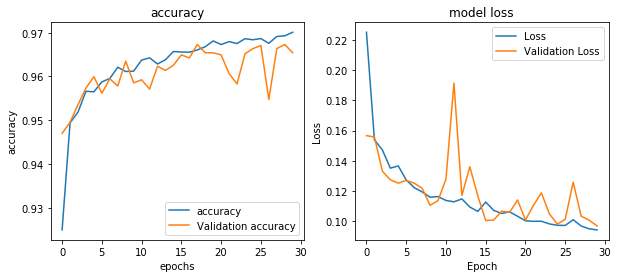

In [20]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(trained_model.history["acc"])
plt.plot(trained_model.history['val_acc'])
plt.title("accuracy"), plt.ylabel("accuracy"), plt.xlabel("epochs")
plt.legend(["accuracy","Validation accuracy"])

fig.add_subplot(1,2,2)
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title("model loss"), plt.ylabel("Loss"), plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
#plt.show()
#plt.savefig('chart loss.png')

### Prediction of some patches

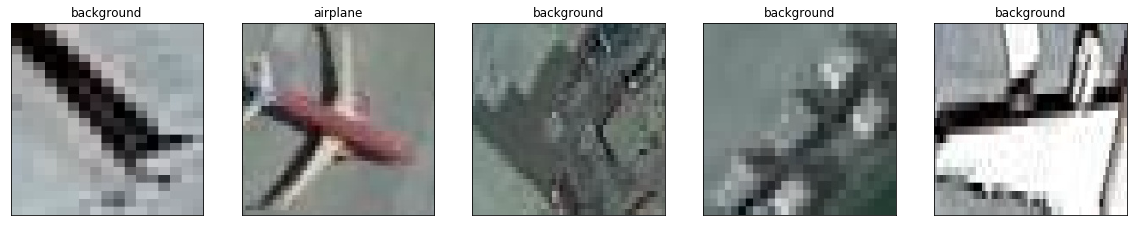

In [21]:
rows = 1
cols = 5
img_files = np.random.choice(os.listdir(test_dir), rows*cols)

fig = plt.figure(figsize=(20,20))
for i, file in enumerate(img_files):
    img = cv2.imread(os.path.join(test_dir,file))
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    out= model.predict(img)
    if out[0][0] > out[0][1]:
        plt.title("airplane")
    else:
        plt.title("background")
    plt.xticks([]), plt.yticks([])

### Display the airplane detection results

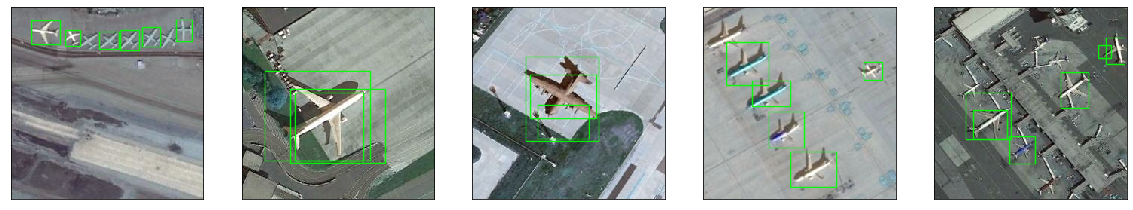

In [23]:
rows = 1
cols = 5
img_files = np.random.choice(os.listdir(image_path), rows*cols)

fig = plt.figure(figsize=(20, 20))

for i, file in enumerate(img_files):
    img = cv2.imread(os.path.join(image_path,file))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    regions = ss.process()
    imout = img.copy()
    for e,region in enumerate(regions):
        if e < 2000:
            x,y,w,h = region
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model.predict(img)
            if out[0][0] > 0.7:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(imout)
    plt.xticks([]), plt.yticks([])